<a href="https://colab.research.google.com/github/JuanJoseMV/neuraltextgen/blob/main/Comparison_of_Attention_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model

In [104]:
%%capture
!pip install simpletransformers
!pip install language-tool-python

In [105]:
import math

import time
import torch
import numpy as np
from transformers import AutoModelForMaskedLM, AutoTokenizer
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
import torch.nn.functional as F


do_basic_tokenize = True
use_fast = True
model_version = 'bert-base-uncased'

model = AutoModelForMaskedLM.from_pretrained(model_version, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_version, do_lower_case="uncased" in model_version,
                                          use_fast=use_fast, do_basic_tokenize=do_basic_tokenize) # added to avoid splitting of unused tokens

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Attention masks

Start with a sentence, mask randomly one token and look at what the various attention masks for the various encoder are looking

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_all_attentions(attentions, index, y_labels=[], num_encoders = 12, num_attention_masks = 12, **sns_heatmap_kwargs):
  ''' Produce one plot for each encoder. In each plot are showed all the attention masks
      for the given index ''' 
  for encoder in range(12):
    fig, axes = plt.subplots(nrows=1, ncols=12, figsize=(40,8))
    print(f"ENCODER {encoder+1}")

    for attention_mask in range(12):
      a = attentions[encoder, attention_mask].detach().numpy()
      a = a[:, index].reshape(-1, 1)
      a = a / sum(a)
      
      sns.heatmap(a, xticklabels=[f'attention-{attention_mask}'], yticklabels=y_labels, cbar=False, linewidths=.5, ax=axes[attention_mask] )
      plt.title(f'Encoder {encoder + 1}', )

    plt.show()   
    print()

def plot_encoders(attention, index, start_ind =1, ax = None, dim=0):
    ''' Single plot with the average of the attention masks for each encode '''
    fig, axes = plt.subplots(nrows=1, ncols=12, figsize=(36,6))

    fig.suptitle('Average of 12 attentions masks for each encoder', fontsize=16)
    for encoder in range(12):
      a = attention[encoder, index].detach().numpy()  #attention[encoder] is 1 x 12 x n_tokens x n_tokens
      a = a.mean(axis=dim).flatten()
      a = a / sum(a)
      
      sns.heatmap(a.reshape(-1,1), xticklabels=[f'encoder-{encoder+1}'], yticklabels=tokens, cbar=False, linewidths=.5, ax=axes[encoder] )


def plot_attention(attention, xticklabels = [], yticklabels = [], title=""):
    sns.heatmap(attention, xticklabels=xticklabels, yticklabels=yticklabels,  cbar=False, linewidths=.5)
    plt.title(title)
    plt.show()


In [ ]:

sentence = "The dog was crossing the street and it was hit by a car"
encoded = torch.tensor(tokenizer.encode(sentence)).reshape(1,-1)
idx_mask = np.random.randint(1, encoded.shape[1]-1)
encoded[0,idx_mask] = tokenizer.mask_token_id

res = model(encoded)
attention = torch.cat(res['attentions'])[:,:,1:-1,1:-1]


ENCODER 1


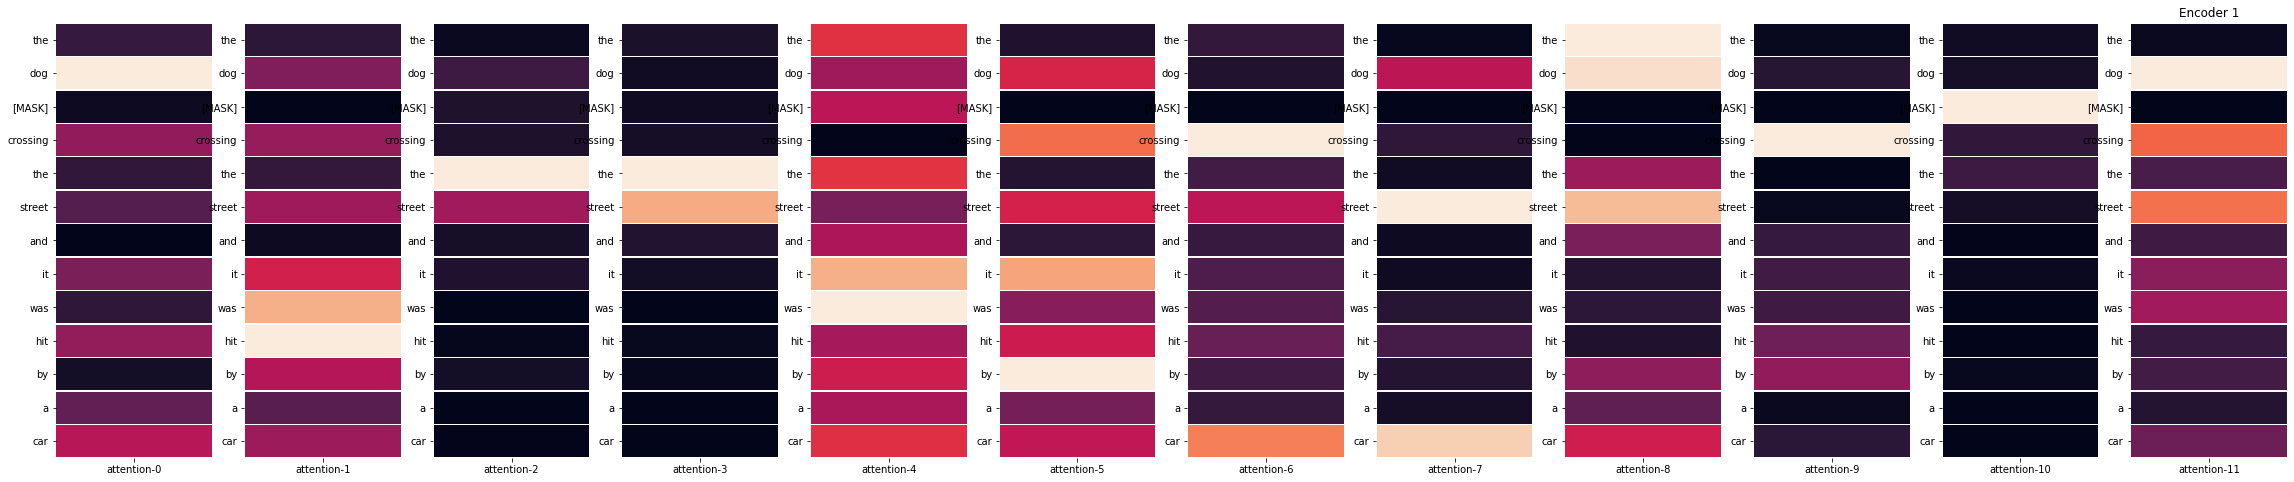


ENCODER 2


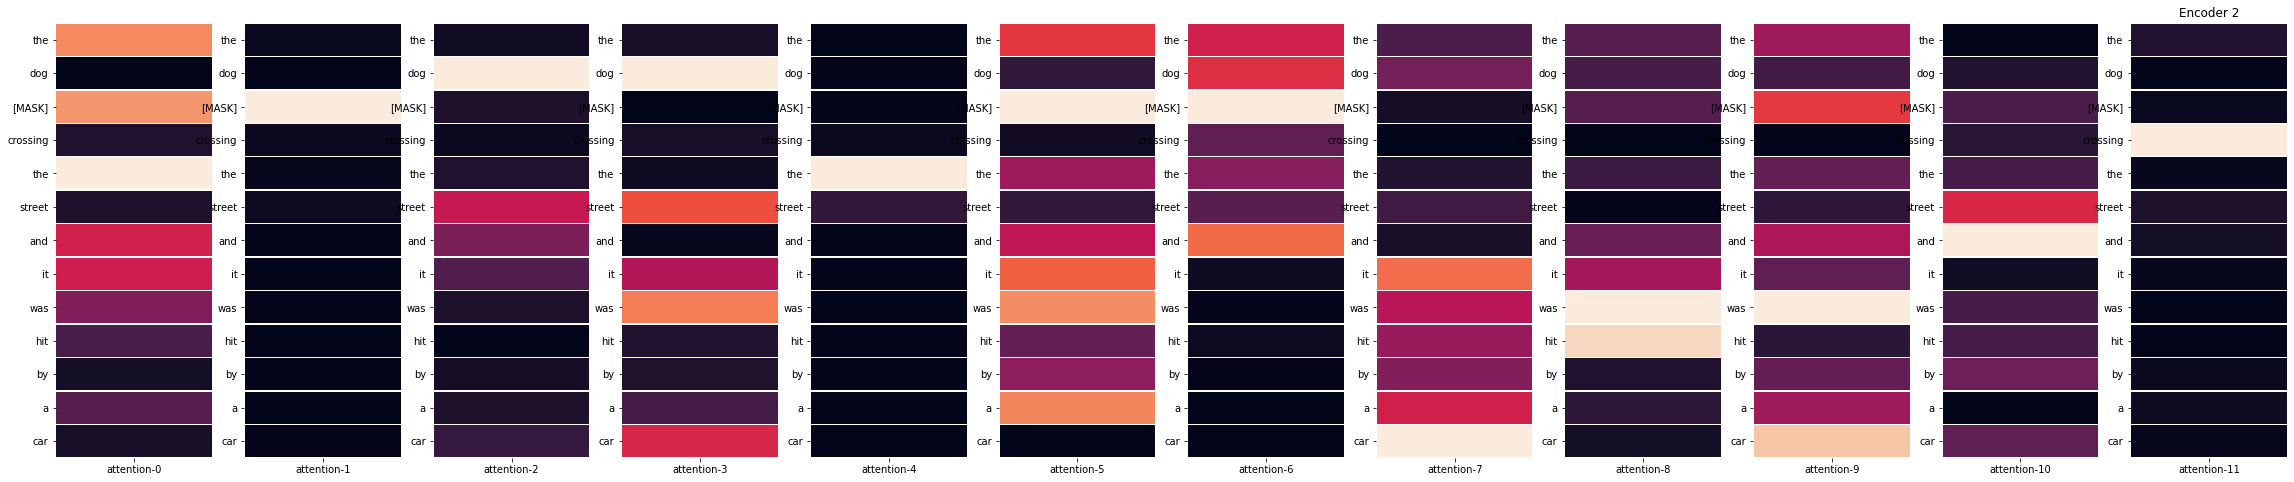


ENCODER 3


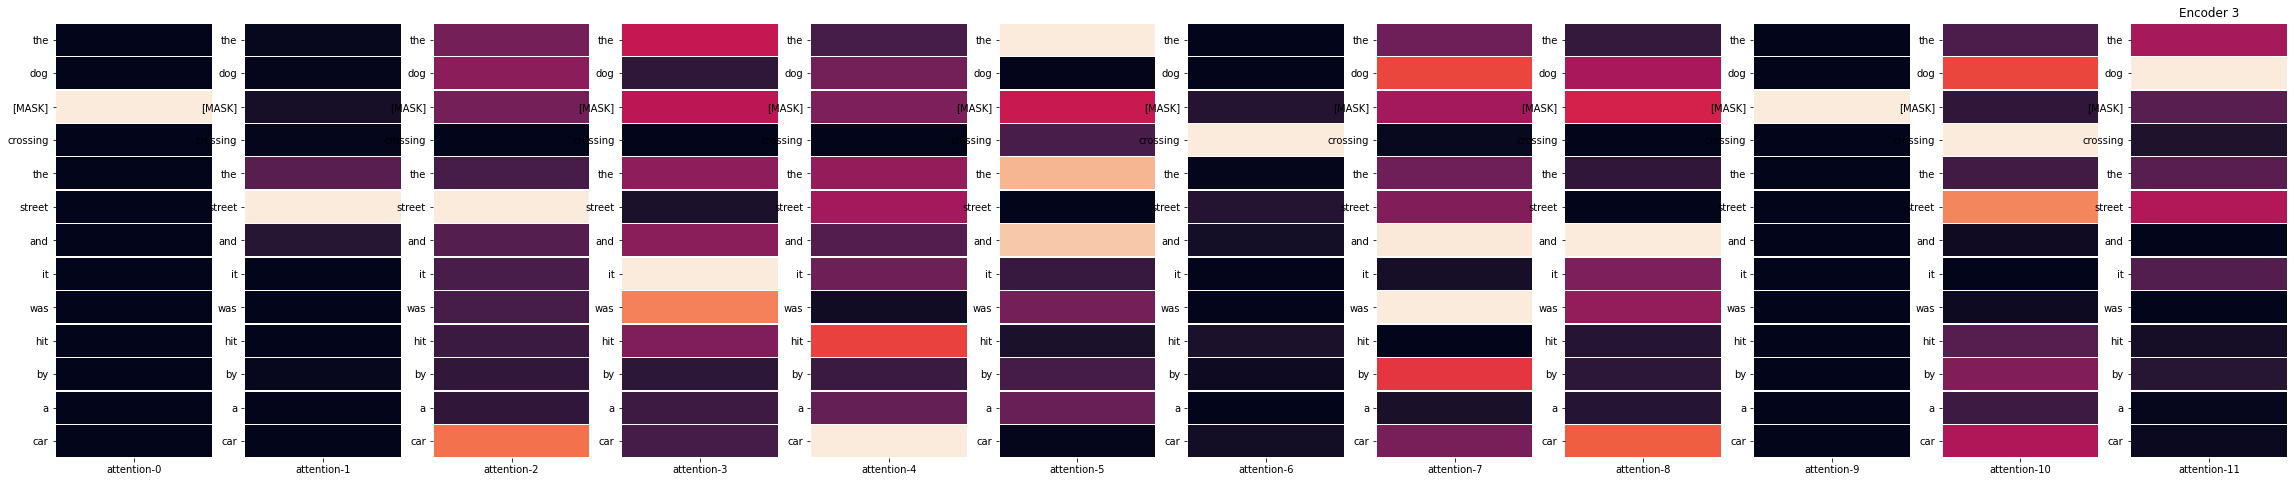


ENCODER 4


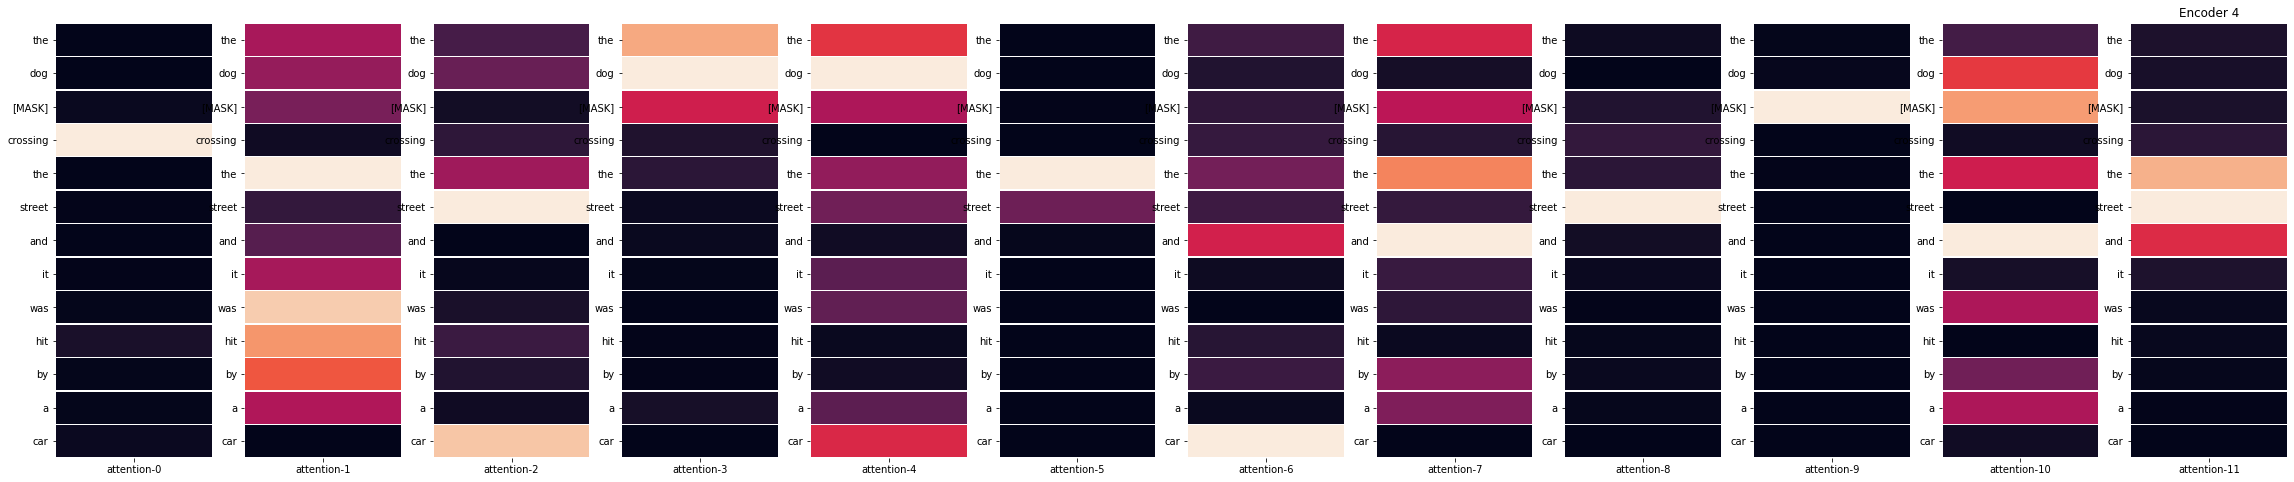


ENCODER 5


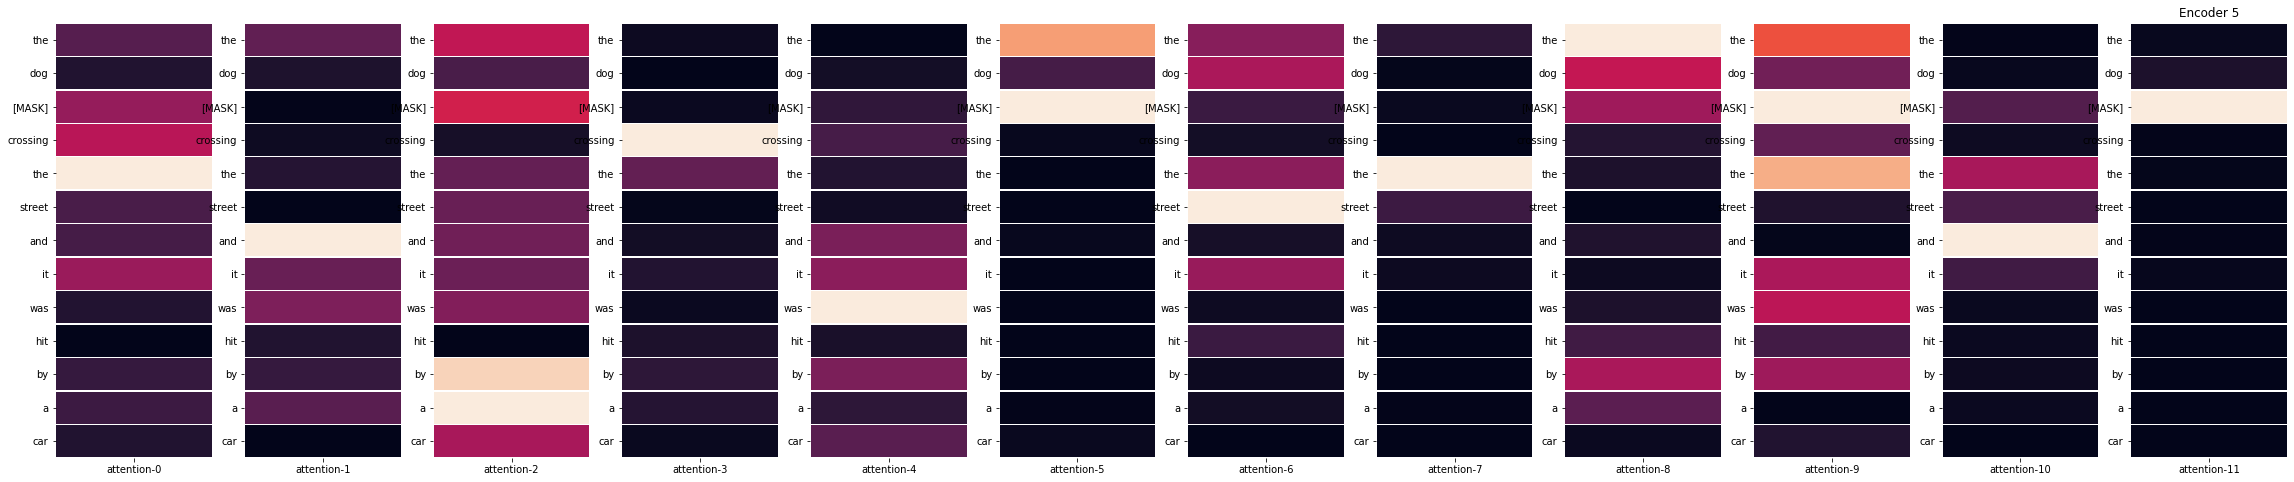


ENCODER 6


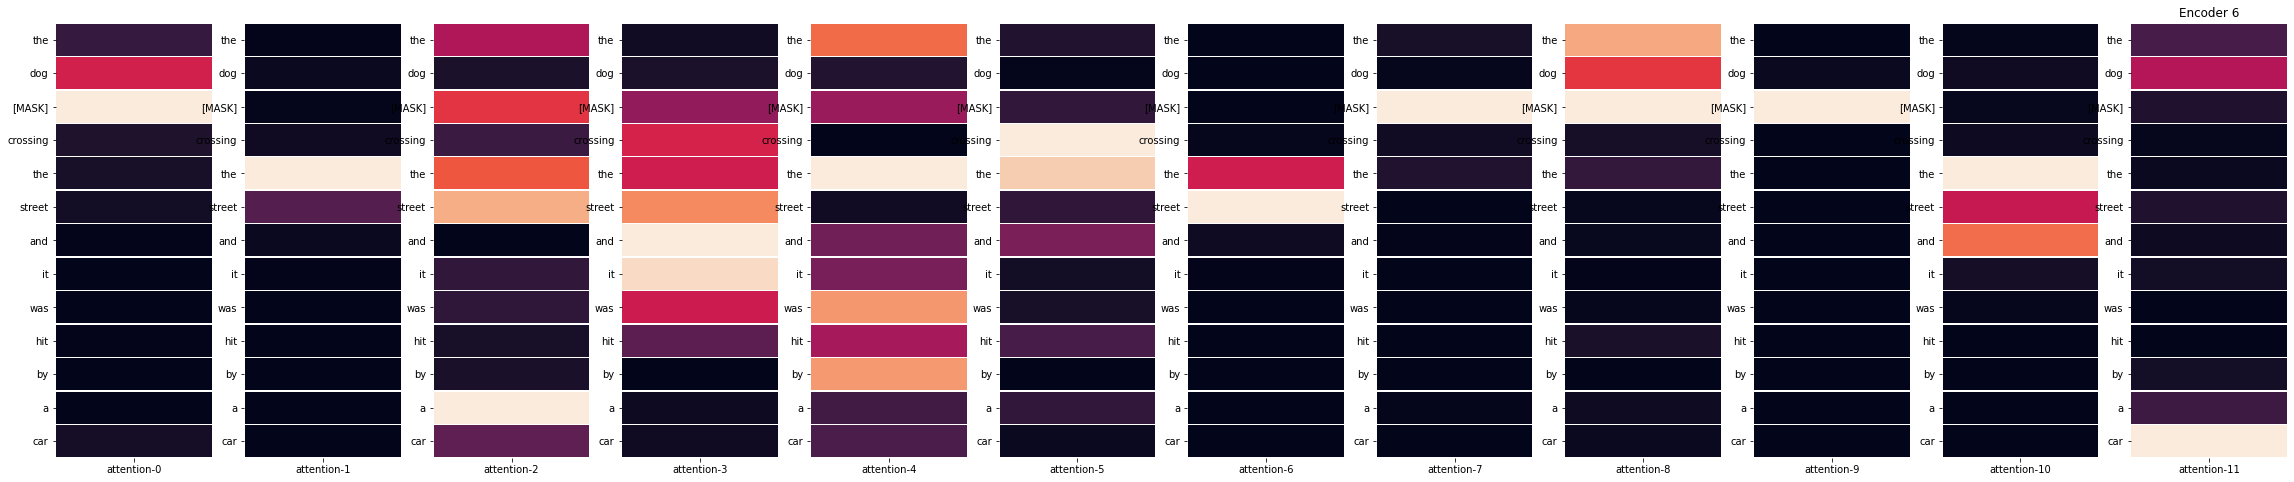


ENCODER 7


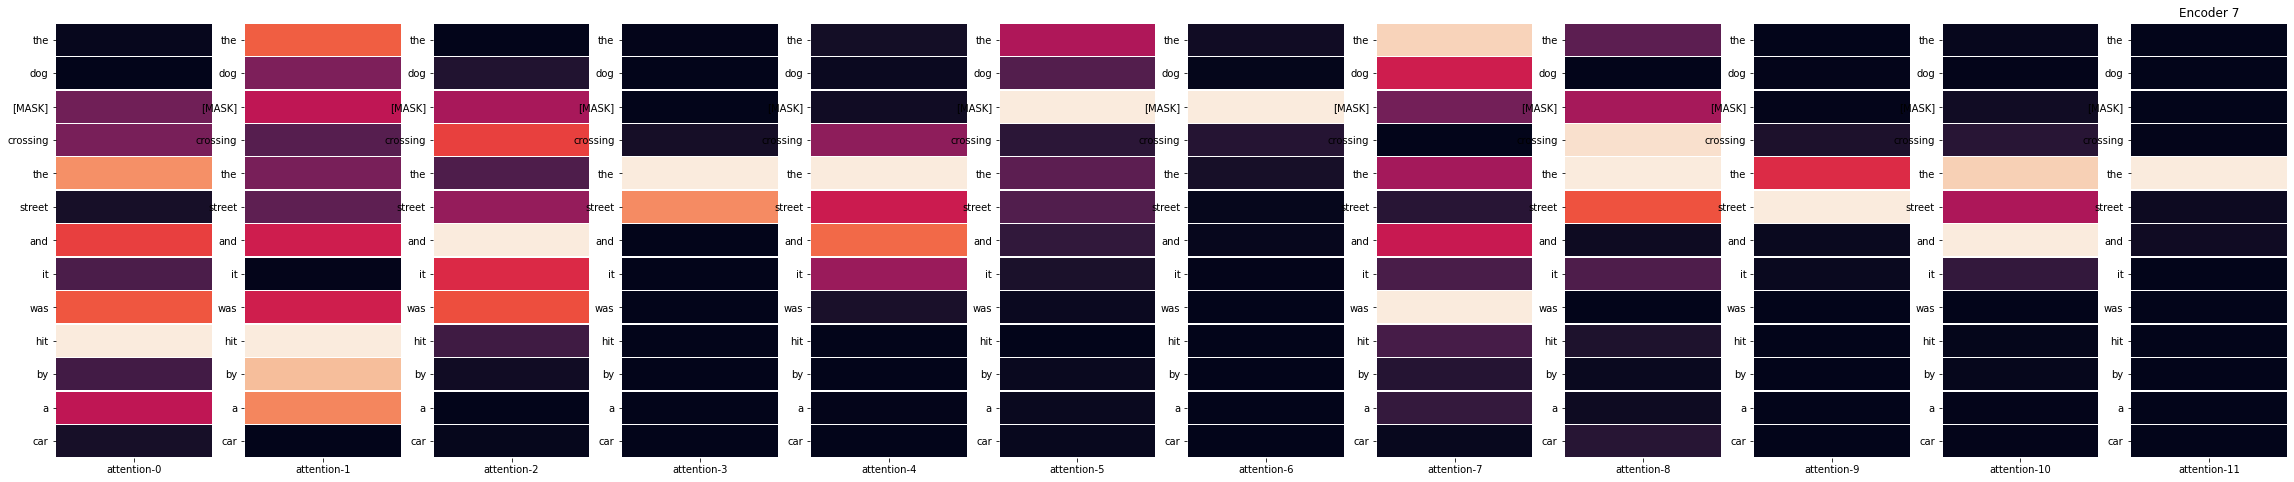


ENCODER 8


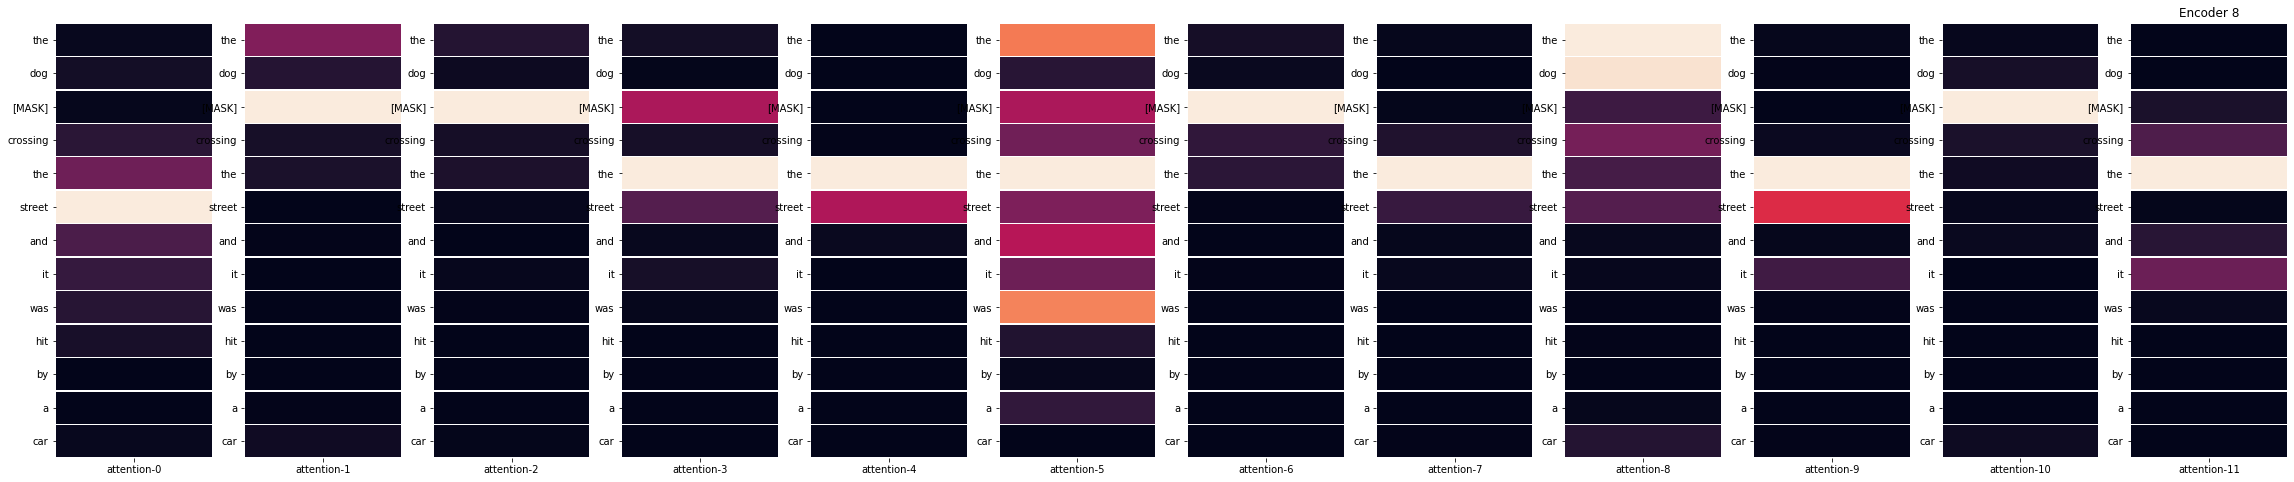


ENCODER 9


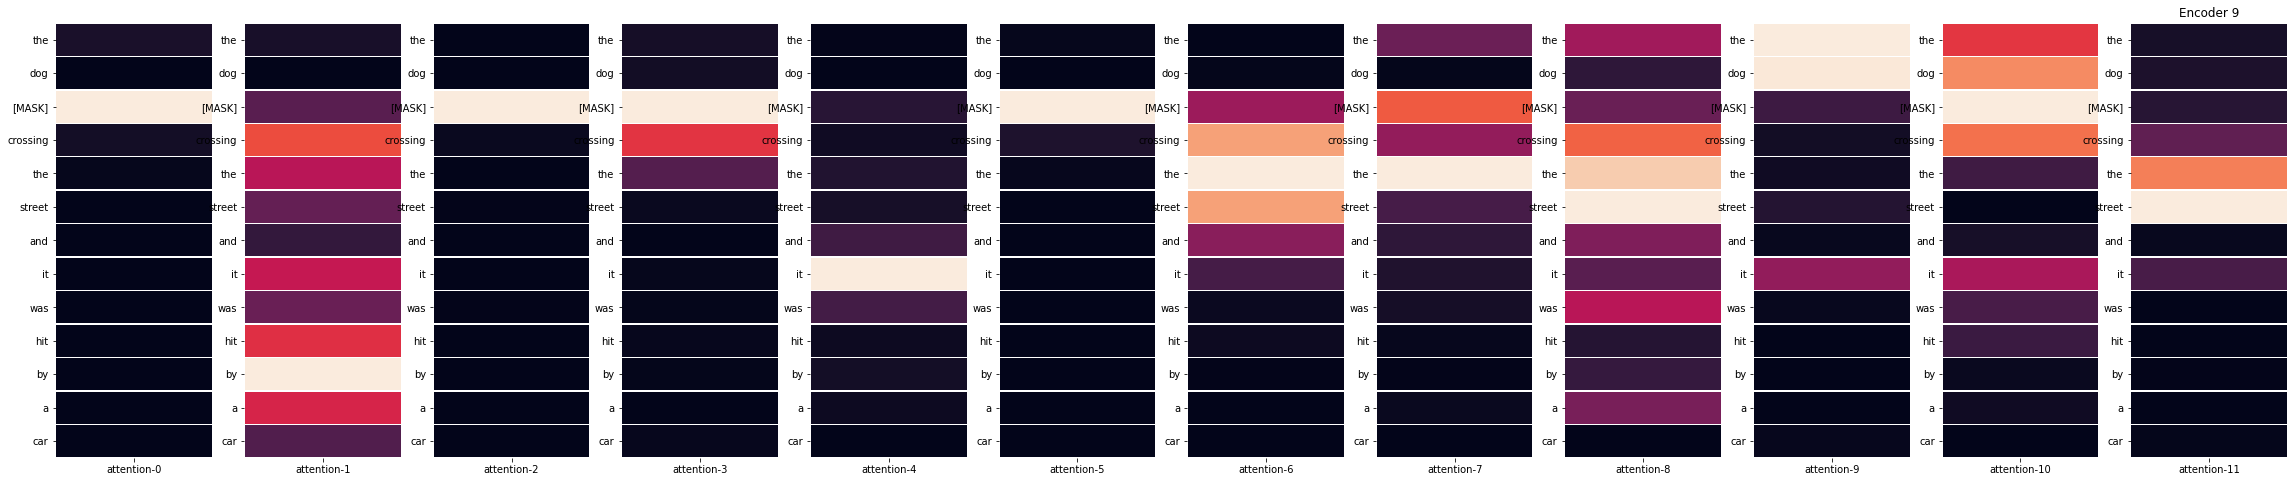


ENCODER 10


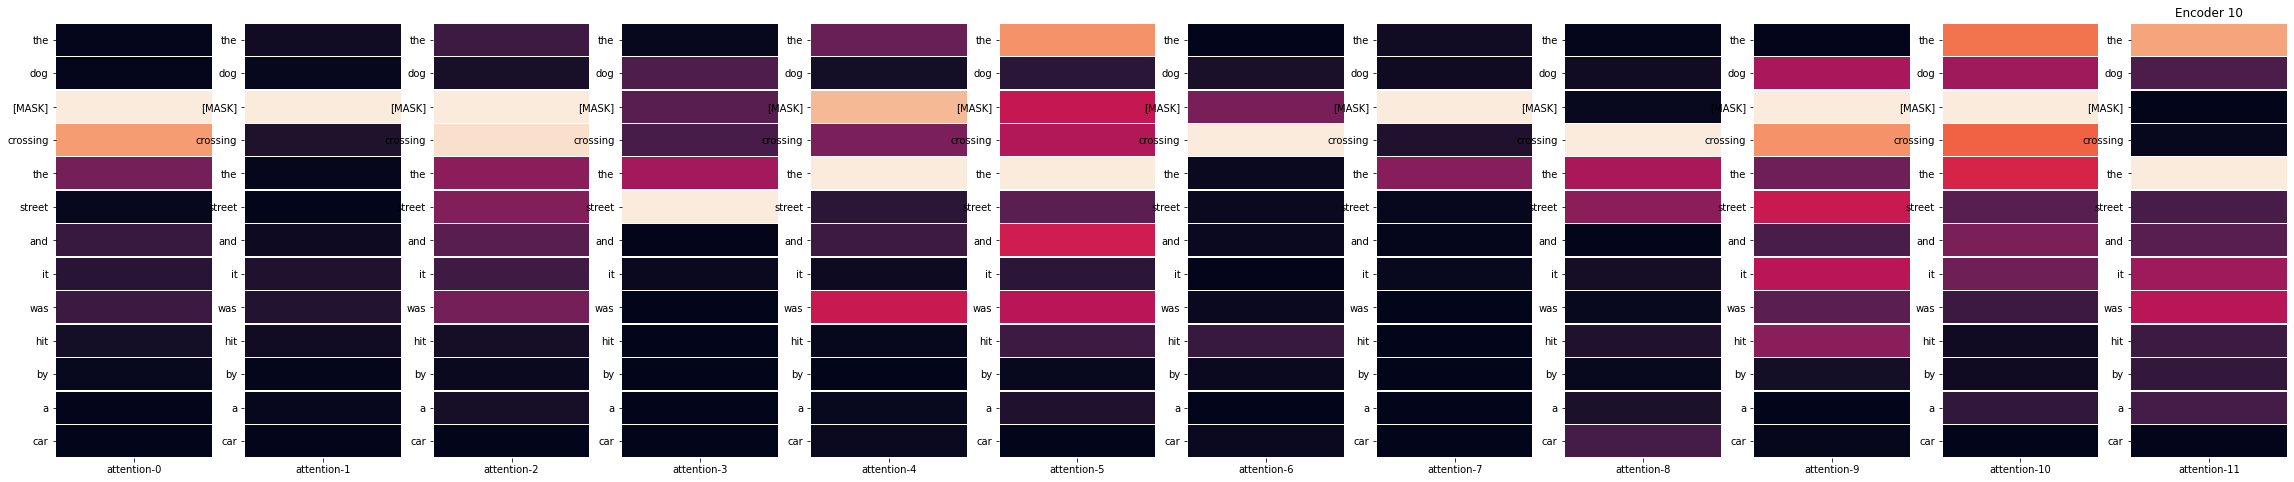


ENCODER 11


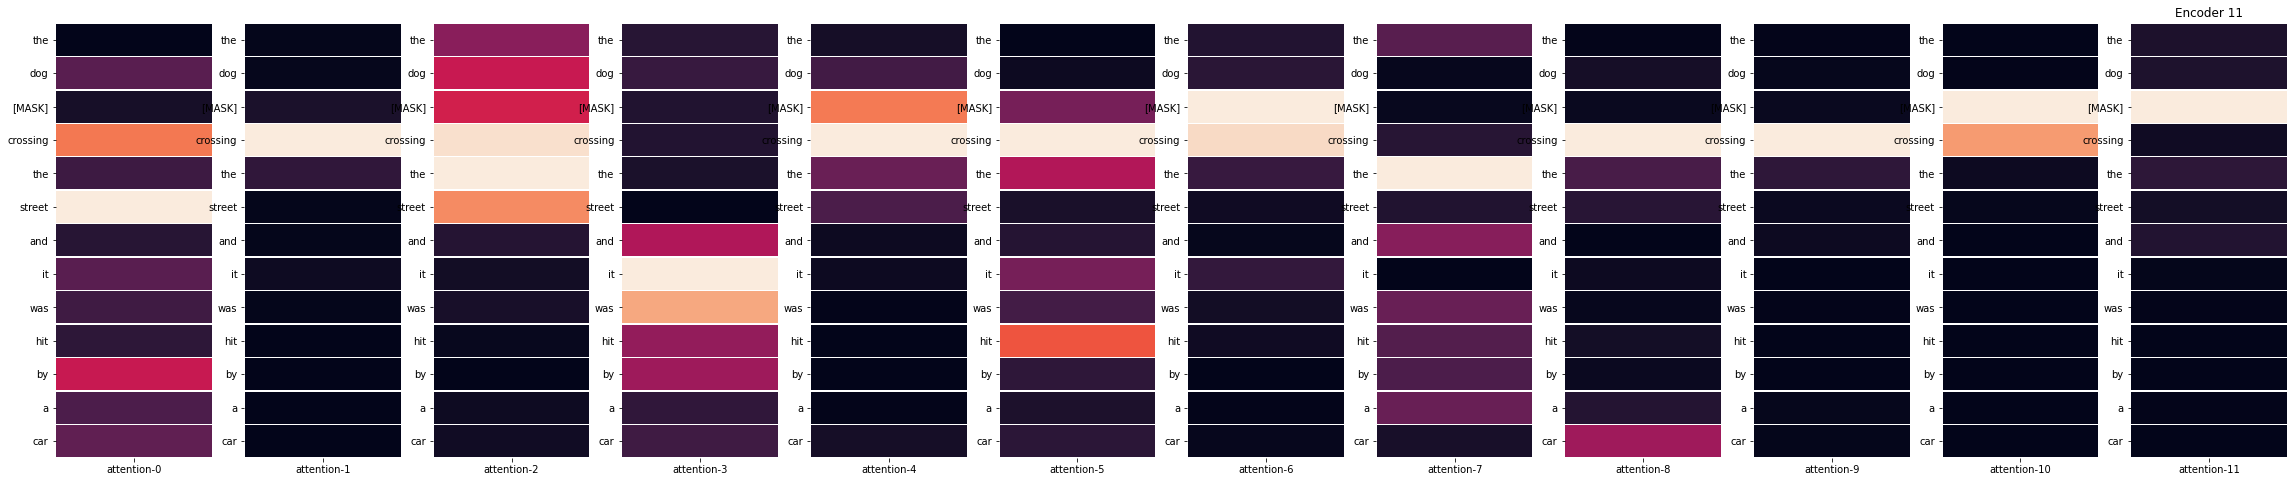


ENCODER 12


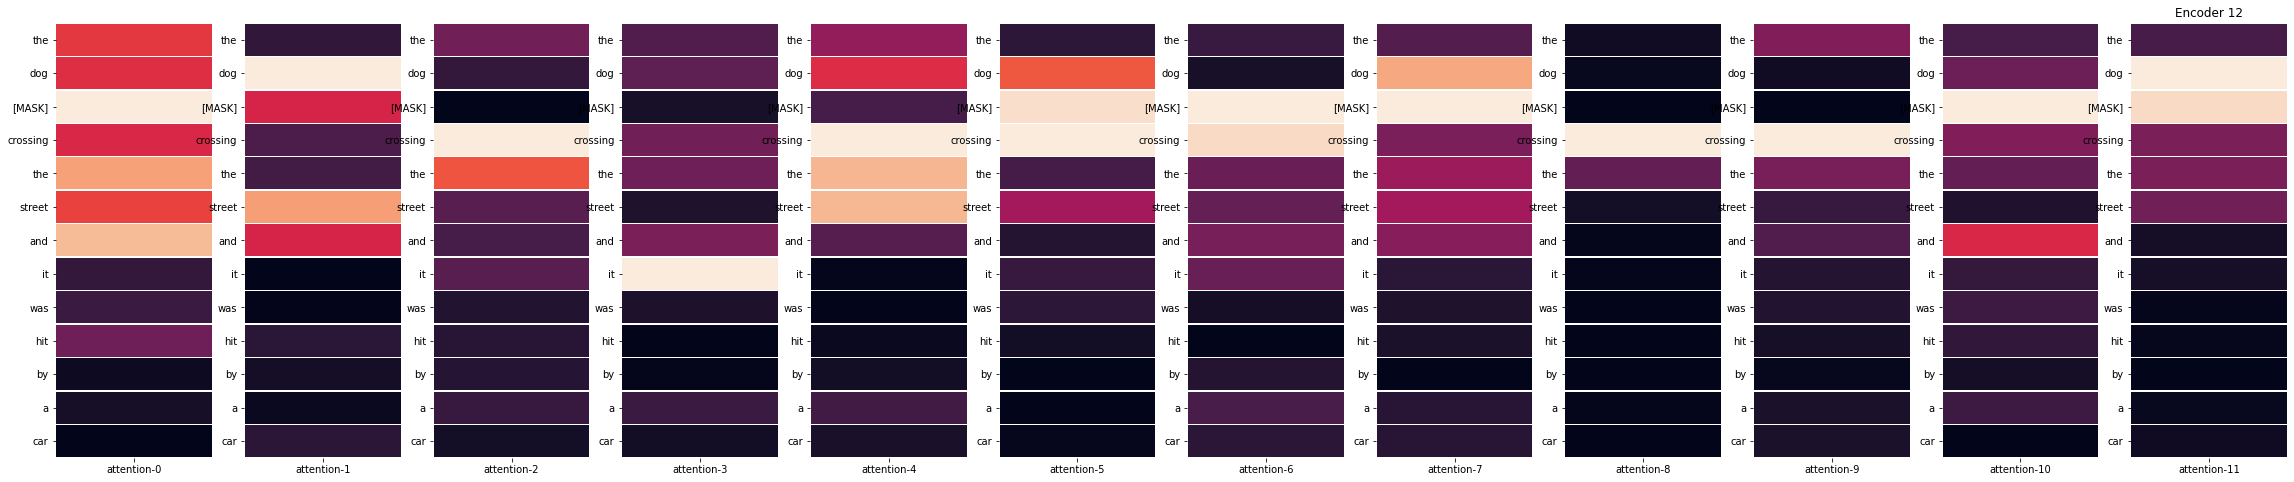

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(encoded[0])[1:-1]
plot_all_attentions(attention, idx_mask, y_labels = tokens)

A lot of attention masks seems to look at near tokens (first following, first preceding) but in general seems there's not a clear pattern

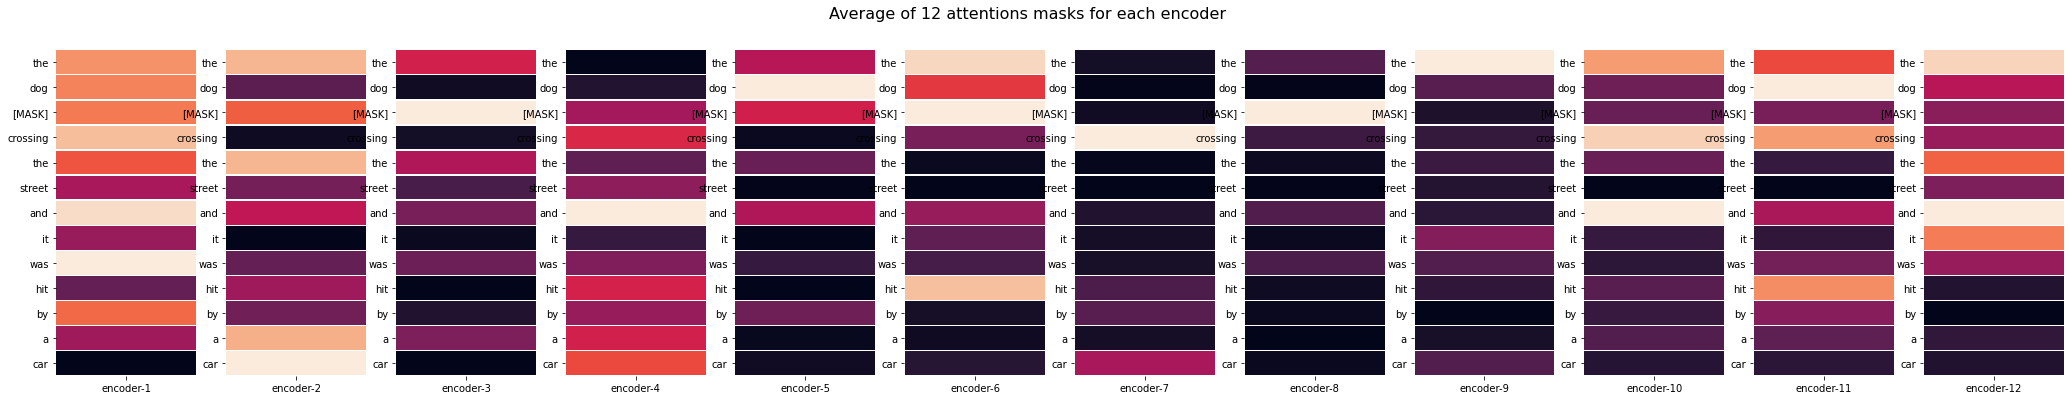

In [ ]:
plot_encoders(attention, idx_mask)

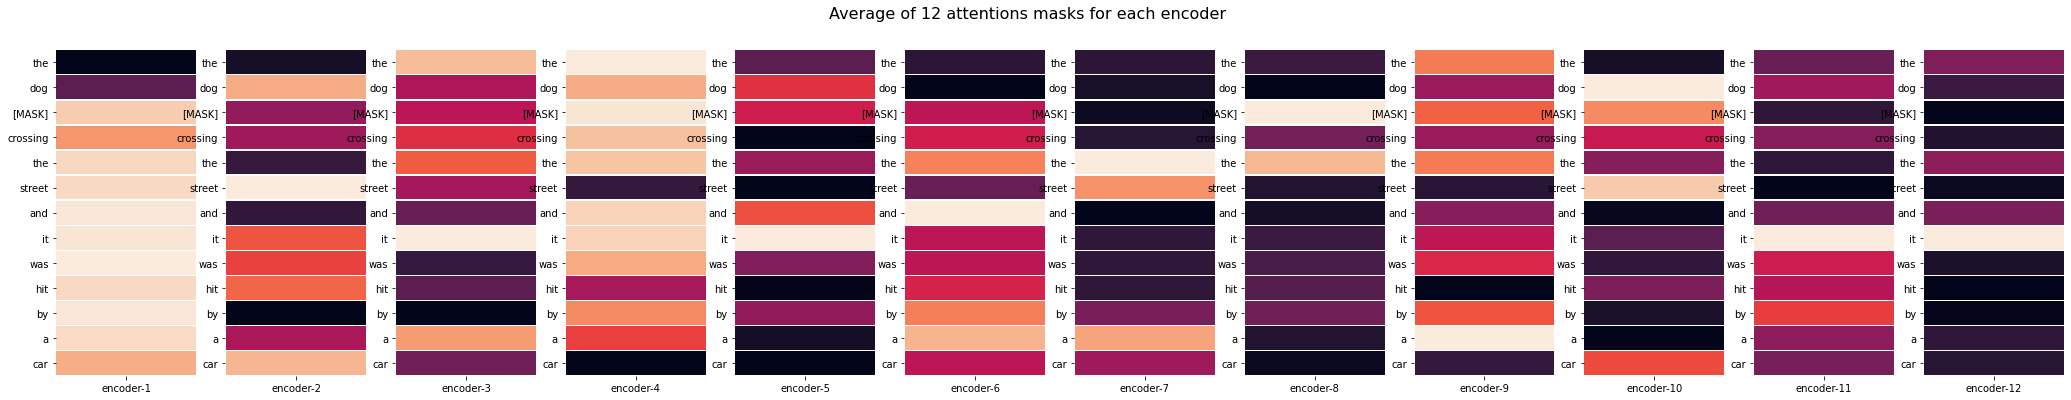

In [ ]:
plot_encoders(attention, idx_mask, dim=1)

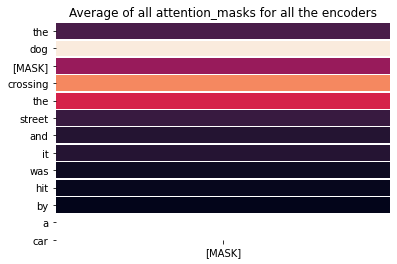

In [ ]:
a = attention.mean(axis=(0,1)).detach().numpy()
a = a[1:-1, idx_mask].reshape(-1, 1)
a = a / sum(a)

plot_attention(a, xticklabels=["[MASK]"], yticklabels=tokens, title='Average of all attention_masks for all the encoders')

# Grammar

In [107]:
import language_tool_python
tool = language_tool_python.LanguageTool('en-US')
text = " [MASK]" * 30
matches = tool.check(text)
len(matches)

0

In [108]:

import itertools

#supporting function
def _split_into_words(sentences):
  """Splits multiple sentences into words and flattens the result"""
  return list(itertools.chain(*[_.split(" ") for _ in sentences]))

#supporting function
def _get_word_ngrams(n, sentences):
  """Calculates word n-grams for multiple sentences.
  """
  assert len(sentences) > 0
  assert n > 0

  words = _split_into_words(sentences)
  return _get_ngrams(n, words)

#supporting function
def _get_ngrams(n, text):
  """Calcualtes n-grams.
  Args:
    n: which n-grams to calculate
    text: An array of tokens
  Returns:
    A set of n-grams
  """
  ngram_set = set()
  text_length = len(text)
  max_index_ngram_start = text_length - n
  for i in range(max_index_ngram_start + 1):
    ngram_set.add(tuple(text[i:i + n]))
  return ngram_set
  
def rouge_n(reference_sentences, evaluated_sentences, n=2):
  """
  Computes ROUGE-N of two text collections of sentences.
  Source: http://research.microsoft.com/en-us/um/people/cyl/download/
  papers/rouge-working-note-v1.3.1.pdf
  Args:
    evaluated_sentences: The sentences that have been picked by the summarizer
    reference_sentences: The sentences from the referene set
    n: Size of ngram.  Defaults to 2.
  Returns:
    recall rouge score(float)
  Raises:
    ValueError: raises exception if a param has len <= 0
  """
  if len(evaluated_sentences) <= 0 or len(reference_sentences) <= 0:
    raise ValueError("Collections must contain at least 1 sentence.")

  evaluated_ngrams = _get_word_ngrams(n, evaluated_sentences)
  reference_ngrams = _get_word_ngrams(n, reference_sentences)
  reference_count = len(reference_ngrams)
  evaluated_count = len(evaluated_ngrams)

  # Gets the overlapping ngrams between evaluated and reference
  overlapping_ngrams = evaluated_ngrams.intersection(reference_ngrams)
  overlapping_count = len(overlapping_ngrams)

  # Handle edge case. This isn't mathematically correct, but it's good enough
  if evaluated_count == 0:
    precision = 0.0
  else:
    precision = overlapping_count / evaluated_count

  if reference_count == 0:
    recall = 0.0
  else:
    recall = overlapping_count / reference_count

  f1_score = 2.0 * ((precision * recall) / (precision + recall + 1e-8))

  #just returning recall count in rouge, useful for our purpose
  return [precision,recall,f1_score]

In [109]:
%%capture
!git clone --recursive https://github.com/JuanJoseMV/neuraltextgen.git
!pip install -r /content/neuraltextgen/texygen/requirements.txt

In [110]:
path = "/content/neuraltextgen/data/wiki103.5k.txt"
file = open(path, "r")
wiki = file.readlines()

In [111]:
wiki[0]

'These impressions show , when alive , they had smooth skin , robust limbs with webbed feet , and a ridge of skin on their undersides .\n'

In [112]:
rougeWiki = []
rougeTBC = []
for k in range(1,5):
  rougeWiki += rouge_n(wiki, ["they had smooth skin"], n=k)

print(rougeWiki)

[1.0, 0.00028214713973337093, 0.0005641351047191712, 1.0, 4.399149497763766e-05, 8.797911874252384e-05, 1.0, 1.9313967861557477e-05, 3.862718929255049e-05, 1.0, 8.748600223964166e-06, 1.7497047198286822e-05]


In [113]:
import math

def test_sampling_method(model, tokenizer, input_tokens, num_iterations=200, top_k=100, next_prob_method=None, plot_probability=True):

    encoded_tokens = input_tokens.clone().detach().numpy()
    num_tokens = len(encoded_tokens) - 2  # we don't need to count [CLS] and [SEP]
    
    #initialize metrics
    counter = np.array([0] * num_tokens)
    number_of_iterations_to_replace_masks = 0
    number_of_masked_tokens = np.sum(encoded_tokens == tokenizer.mask_token_id)
    number_of_changes = 0
    number_of_grammar_errors = []
    distances = []
    rouge_scores = []
    
    old_idx_mask = 0
    prob = np.full( num_tokens , 1/num_tokens )

    # temperature = np.linspace(2, 0.01, num_iterations)
    # temperature = np.logspace(1, -1, num_iterations)

    for i in range(num_iterations):
        # print(f"=== ITERATION {i+1} ===")
        # print(f"Current sentence: \t{tokenizer.decode(encoded_tokens)}")

        # Mask a token
        idx_mask = np.random.choice(range(1, num_tokens + 1), p=prob)
        token_masked = tokenizer.decode([encoded_tokens[idx_mask]])
        encoded_tokens[idx_mask] = tokenizer.mask_token_id
        # print(f"Masked sentence: \t{tokenizer.decode(encoded_tokens)}")
        
        

        # Results
        res = model(torch.tensor([encoded_tokens]))
        logits = res['logits'][0, idx_mask, :]

       # logits = logits / (10 * np.exp(math.e, -1))#temperature[i]

        attention = torch.cat(res['attentions'])

        # top-k selection
        val, ids = torch.topk(logits, top_k)
        # print(f"TOP 10 words: \t\t{tokenizer.convert_ids_to_tokens(ids)}")
        dist = torch.distributions.categorical.Categorical(logits=val)
        idx_replace = ids.gather(dim=-1, index=dist.sample().unsqueeze(-1)).squeeze(-1).item()
        token_replaced = tokenizer.decode(idx_replace)
        # print(f"\nMasked Token: \"{token_masked}\"   |    Replaced Token: \t\"{token_replaced}\"")
        
        # Replacing
        encoded_tokens[idx_mask] = idx_replace

        # Upload Metrics
        counter[idx_mask-1] += 1 # -1 since idx_mask is choosed in range(1, num_tokens+1) to avoid [CLS] and [SEP]

        if token_masked == tokenizer.mask_token: # check if the token choosed to be replaced was already masked
            number_of_masked_tokens -= 1
        
            if number_of_masked_tokens == 0:
                number_of_iterations_to_replace_masks = i + 1
        
        if tokenizer.convert_tokens_to_ids([token_masked])[0] != idx_replace:
            number_of_changes += 1

        distance = np.abs(idx_mask - old_idx_mask)
        distances.append(distance)
        old_idx_mask = idx_mask

        sent = tokenizer.decode(encoded_tokens, skip_special_tokens=True)
        matches = tool.check(sent)
        number_of_grammar_errors.append(len(matches))
        

        # print("\n(Metrics)")
        # print(f'\t · The current token was touched {counter[idx_mask - 1]} times (min = {np.min(list(counter))}, max = {np.max(list(counter))}, avg = {np.mean(list(counter)):.3f})')
        # print(f'\t · Num masked tokens = {np.sum(encoded_tokens == tokenizer.mask_token_id)}' + 
        #       (f" (last mask token removed at iteration {number_of_iterations_to_replace_masks})" if number_of_masked_tokens == 0  and number_of_iterations_to_replace_masks > 0 else ""))
        # print(f'\t · Number of changes {number_of_changes} ({100*number_of_changes/(i+1):.3f}%)')
        # print(f'\t · Distance {distance} (avg = {np.mean(distances):.3f}, L/3 = {num_tokens/3:.3f})')
        # print(f'\t · Number of grammar errors {len(matches)} (avg = {np.mean(number_of_grammar_errors):.3f})', end='\n\n')
        
        rougeWiki = []
        for k in range(1,3):
            rouge = rouge_n(wiki, [sent], n=k)
            rougeWiki += rouge
            # print(f'\t · Rouge-{k} Wiki {rouge}')
        
        rouge_scores.append(rougeWiki)
        # print('\n\n')
        
        # Plot
        kwargs = {'attention':attention, 'idx_mask':idx_mask, 'counter':counter, "number_of_changes":number_of_changes, "distances":distances, "token_masked":token_masked, "token_replaced":token_replaced, "num_tokens":num_tokens}
        prob = next_prob_method(**kwargs)
        
        if plot_probability:
            tokens = tokenizer.convert_ids_to_tokens(encoded)[1:-1]
            plot_attention(prob.reshape(-1, 1), xticklabels=[f'{token_replaced}'], yticklabels=tokens)
        
        # print('\n\n\n')
    
    results = {'encoded_tokens': encoded_tokens, 'counter':counter, 'number_of_iterations_to_replace_masks':number_of_iterations_to_replace_masks,
               'number_of_changes':number_of_changes, 'number_of_grammar_errors':number_of_grammar_errors, 'distances':distances, 'rouge_scores':rouge_scores}
    return results

### Method 1 - Original Parallel

In [114]:
def parallel(**kwargs):
    num_tokens = kwargs["num_tokens"]
    return np.full( num_tokens , 1/num_tokens )

In [ ]:
sentence = " [MASK] " * 30
encoded = torch.tensor(tokenizer.encode(sentence))#.reshape(1,-1)
res = test_sampling_method(model, tokenizer, encoded, next_prob_method=parallel, plot_probability=True)

### Method 2 - Sum of probabilities

In [115]:
def sum_attention(attention, idx_mask, **kwargs):
    a = attention / (12*12)
    a = a.sum(axis=(0,1)).detach().numpy()
    a = a[1:-1, idx_mask].reshape(-1, 1)
    a = a / sum(a)
    
    return a.flatten()

In [ ]:
sentence = " [MASK] " * 30
encoded = torch.tensor(tokenizer.encode(sentence))

results = test_sampling_method(model, tokenizer, encoded, next_prob_method=sum_attention, plot_probability=True)

### Method 3 - Mean of all attention masks

In [116]:
def general_mean(attention, idx_mask, **kwargs):
    a = attention.mean(axis=(0,1)).detach().numpy()  # mean over ax0 that is encoders and ax1 that is attention_mask
    a = a[1:-1, idx_mask].reshape(-1, 1)
    prob = a.flatten()
    prob = prob/sum(prob)
    return prob

In [ ]:
sentence = " [MASK] " * 30
encoded = torch.tensor(tokenizer.encode(sentence))

test_sampling_method(model, tokenizer, encoded, next_prob_method=general_mean, plot_probability=False)

=== ITERATION 1 ===
Current sentence: 	[CLS] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [SEP]
Masked sentence: 	[CLS] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [SEP]
TOP 10 words: 		[',', 'and', '-', '.', 'or', 'the', ':', '/', 'a', ')', '(', 'not', 'of', "'", 'in', ';', 'no', 'for', 'as', '##s', 'other', '"', '?', 'non', 'but', 'all', '&', 'one', 'some', 'more', 'english', 'girls', 'science', 'french', 'german', 'her', 'b', 'that', 'new', 'to', '*', 's', '...', 'i', 'it', '!', 'school', 'from', '2', 'k', 'art', 'students', 'about', 'an', 'music', 'children', 'is', 'my', 'with', '%', 'his', 'two', 'women', 'any', 'their', 'minor', 'de', '3', 'high', 'di', '

{'counter': array([ 6,  5,  6,  6,  2,  5,  2,  6,  4,  9,  5,  7,  4, 10, 11,  7, 10,
         6,  2,  7,  8,  7,  6,  5, 17, 11,  6,  8,  5,  7]),
 'distances': [14,
  8,
  2,
  2,
  23,
  16,
  2,
  1,
  7,
  1,
  2,
  1,
  1,
  15,
  1,
  1,
  9,
  16,
  1,
  4,
  7,
  1,
  5,
  2,
  18,
  0,
  2,
  16,
  6,
  15,
  1,
  2,
  6,
  1,
  16,
  5,
  23,
  20,
  2,
  12,
  2,
  6,
  1,
  1,
  0,
  2,
  2,
  4,
  19,
  20,
  5,
  1,
  14,
  1,
  4,
  7,
  0,
  3,
  1,
  14,
  1,
  3,
  9,
  13,
  10,
  0,
  4,
  8,
  1,
  3,
  0,
  1,
  22,
  1,
  19,
  1,
  16,
  2,
  5,
  24,
  0,
  5,
  29,
  3,
  4,
  5,
  2,
  14,
  29,
  4,
  4,
  5,
  4,
  0,
  7,
  3,
  0,
  5,
  1,
  10,
  0,
  6,
  2,
  3,
  5,
  4,
  1,
  13,
  22,
  3,
  1,
  26,
  5,
  9,
  13,
  0,
  1,
  1,
  2,
  2,
  21,
  7,
  2,
  6,
  3,
  6,
  2,
  10,
  10,
  6,
  1,
  13,
  9,
  2,
  1,
  2,
  10,
  18,
  15,
  21,
  22,
  4,
  1,
  26,
  6,
  10,
  3,
  1,
  8,
  6,
  10,
  0,
  1,
  4,
  1,
  1,
  7,
  18,
  2,


#### Method 3.1 - Mean of the first attention mask

In [117]:
def mean_first(attention, idx_mask, **kwargs):
    a = attention[0].mean(axis=0).detach().numpy()  # mean over ax0 that is encoders and ax1 that is attention_mask
    a = a[1:-1, idx_mask].reshape(-1, 1)
    prob = a.flatten()
    prob = prob/sum(prob)
    return prob

In [ ]:
sentence = " [MASK] " * 30
encoded = torch.tensor(tokenizer.encode(sentence))
res = test_sampling_method(model, tokenizer, encoded, next_prob_method=mean_first, plot_probability=False)

#### Method 3.2 - Mean of the last encoder

In [118]:
%%time
def mean_last(attention, idx_mask, **kwargs):
    a = attention[-1].mean(axis=0).detach().numpy()  # mean over ax0 that is encoders and ax1 that is attention_mask
    a = a[1:-1, idx_mask].reshape(-1, 1)
    prob = a.flatten()
    prob = prob/sum(prob)
    return prob


CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.7 µs


In [ ]:

sentence = " [MASK] " * 30
encoded = torch.tensor(tokenizer.encode(sentence))
res = test_sampling_method(model, tokenizer, encoded, next_prob_method=mean_last, plot_probability=False)

### Method 4 - Counter penalization

In [119]:
def counter_penalization(attention, idx_mask, counter, **kwargs):
      a = attention.mean(axis=(0,1)).detach().numpy()  # mean over ax0 that is encoders and ax1 that is attention_mask
      a = a[1:-1, idx_mask].reshape(-1, 1)
      c = np.array(counter) + 1
      prob = a.flatten()/ c
      prob = prob/sum(prob)
      return prob

In [ ]:
sentence = " [MASK] " * 30
encoded = torch.tensor(tokenizer.encode(sentence))
res = test_sampling_method(model, tokenizer, encoded, next_prob_method=counter_penalization, plot_probability=False)

=== ITERATION 1 ===
Current sentence: 	[CLS] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [SEP]
Masked sentence: 	[CLS] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [SEP]
TOP 10 words: 		['.', ';', '?', '!', '|', "'", '...', ')', '"', '-', ',', ':', '(', 'and', '।', '*', 'a', '[UNK]', 'or', 'one', 'are', 'no', 'the', 'minor', 'in', 'all', 'were', 'for', 'none', 'i', '/', 'to', '%', 'as', 'two', 'she', '##s', 'three', 'from', 'b', 'only', ']', 'but', 'on', 'girls', '#', 'so', 'not', 'he', 'you', '3', 'out', 'of', '1', 'more', 'it', 'without', '2', '0', 'too', 'up', 'if', '##a', 'non', 'first', 'other', 'women', '&', '##i', 'go', 'some', 'who', 'between', 'united'

### Method 5 - Square counter penalization

In [120]:
def square_counter_penalization(attention, idx_mask, counter, **kwargs):
      a = attention.mean(axis=(0,1)).detach().numpy()  # mean over ax0 that is encoders and ax1 that is attention_mask
      a = a[1:-1, idx_mask].reshape(-1, 1)
      c = np.array(counter) + 1
      prob = a.flatten()/ (c**2)
      prob = prob/sum(prob)
      return prob


In [ ]:

sentence = " [MASK] " * 30
encoded = torch.tensor(tokenizer.encode(sentence))
res = test_sampling_method(model, tokenizer, encoded, next_prob_method=square_counter_penalization, plot_probability=False)

=== ITERATION 1 ===
Current sentence: 	[CLS] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [SEP]
Masked sentence: 	[CLS] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [SEP]
TOP 10 words: 		[',', 'and', '-', 'or', '.', 'the', ':', '/', '(', 'a', ')', '##s', 'of', ';', "'", 'not', 'as', 'in', 'for', 'no', '"', 'other', '?', 'non', 'but', 'more', '&', 'one', 'all', 'english', 'some', 'girls', 'french', '*', 'science', 'b', 'german', '!', 's', 'with', 'students', 'k', 'to', 'her', 'an', '...', 'that', 'new', 'is', 'i', '%', '2', 'school', 'it', 'from', 'minor', 'children', '##i', 'are', 'their', 'art', 'two', 'music', 'high', 'about', 'his', '3', 'any', 'books', 'wome

### Method 6 - Random attention mask

In [121]:
def random_attention(attention, idx_mask, **kwargs):
    encoder_idx = np.random.randint(12)
    attention_mask_idx = np.random.randint(12) 
    a = attention[encoder_idx, attention_mask_idx]
    a = a[1:-1, idx_mask].reshape(-1, 1).detach().numpy()
    a = a / sum(a)
    prob = a.flatten()
    return prob

In [ ]:


sentence = " [MASK] " * 30
encoded = torch.tensor(tokenizer.encode(sentence))
res = test_sampling_method(model, tokenizer, encoded, next_prob_method=random_attention, plot_probability=False)

=== ITERATION 1 ===
Current sentence: 	[CLS] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [SEP]
Masked sentence: 	[CLS] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [SEP]
TOP 10 words: 		[',', '-', 'not', ':', 'and', 'the', '.', 'all', 'or', 'in', 'a', '/', '(', ')', 'as', 'no', ';', 'of', "'", 'for', 'from', 'more', 'some', 'one', '...', 'any', 'but', '"', 'to', 'is', '!', 'it', 'by', 'about', 'her', '?', 'that', 'non', 'its', '##s', 'if', '%', 'with', 'like', '*', 'girls', '&', 'just', 'other', 'my', '2', 'only', 'most', '1', 'his', '=', '3', 'two', 'their', 'school', 'less', 'was', 'are', 'were', 'science', 'new', 'art', 'i', 'either', 'b', 'also', 'what', 'c

### Method 7 - Inverse

In [122]:
def inverse(attention, idx_mask, counter, **kwargs):
      a = attention.mean(axis=(0,1)).detach().numpy()  # mean over ax0 that is encoders and ax1 that is attention_mask
      a = a[1:-1, idx_mask].reshape(-1, 1)
      c = np.array(counter) + 1
      prob = a.flatten()
      prob = 1/prob
      prob = prob/sum(prob)
      return prob


In [ ]:

sentence = " [MASK] " * 30
encoded = torch.tensor(tokenizer.encode(sentence))
res = test_sampling_method(model, tokenizer, encoded, next_prob_method=inverse, plot_probability=False)

=== ITERATION 1 ===
Current sentence: 	[CLS] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [SEP]
Masked sentence: 	[CLS] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [SEP]
TOP 10 words: 		['-', ',', ':', 'the', '.', 'and', 'not', 'all', 'a', '(', 'or', 'in', 'no', ')', 'as', 'of', '/', "'", 'for', ';', 'any', '"', 'from', 'one', 'is', '...', 'more', '!', '?', 'it', 'some', 'that', 'but', 'are', 'her', '##s', 'to', 'by', '*', 'about', 'were', 'non', 'other', 'my', 'girls', '=', 'their', 'if', '%', 'i', 'his', 'was', 'its', '2', '1', 'like', 'new', 'b', 'with', 'children', 'german', 'science', 'art', '3', 'two', 'most', 'anything', 'school', 'only', '&', 'just', 'e

#### Method 7.1 - Penalized inverse

In [123]:
def penalized_inverse(attention, idx_mask, counter, **kwargs):
      a = attention.mean(axis=(0,1)).detach().numpy()  # mean over ax0 that is encoders and ax1 that is attention_mask
      a = a[1:-1, idx_mask].reshape(-1, 1)
      c = np.array(counter) + 1
      prob = a.flatten()
      prob = 1/prob
      prob =  prob/c
      prob = prob/sum(prob)
      return prob

In [ ]:


sentence = " [MASK] " * 30
encoded = torch.tensor(tokenizer.encode(sentence))
res = test_sampling_method(model, tokenizer, encoded, next_prob_method=penalized_inverse, plot_probability=False)

=== ITERATION 1 ===
Current sentence: 	[CLS] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [SEP]
Masked sentence: 	[CLS] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [SEP]
TOP 10 words: 		[',', 'and', '-', '.', 'or', 'the', ':', '/', 'a', ')', '(', 'not', 'of', "'", 'in', ';', 'no', 'for', 'as', '##s', 'other', '"', '?', 'non', 'but', 'all', '&', 'one', 'some', 'more', 'english', 'girls', 'science', 'french', 'german', 'her', 'b', 'that', 'new', 'to', '*', 's', '...', 'i', 'it', '!', 'school', 'from', '2', 'k', 'art', 'students', 'about', 'an', 'music', 'children', 'is', 'my', 'with', '%', 'his', 'two', 'women', 'any', 'their', 'minor', 'de', '3', 'high', 'di', '

#### Method 7.2 - Square penalized inverse

In [124]:
def squared_penalized_inverse(attention, idx_mask, counter, **kwargs):
      a = attention.mean(axis=(0,1)).detach().numpy()  # mean over ax0 that is encoders and ax1 that is attention_mask
      a = a[1:-1, idx_mask].reshape(-1, 1)
      c = np.array(counter) + 1
      prob = a.flatten()
      prob = 1/prob
      prob =  prob/(c**2)
      prob = prob/sum(prob)
      return prob

In [ ]:


sentence = " [MASK] " * 30
encoded = torch.tensor(tokenizer.encode(sentence))
res = test_sampling_method(model, tokenizer, encoded, next_prob_method=squared_penalized_inverse, plot_probability=False)

=== ITERATION 1 ===
Current sentence: 	[CLS] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [SEP]
Masked sentence: 	[CLS] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [SEP]
TOP 10 words: 		[',', 'and', '-', '.', 'or', 'the', ':', '(', ')', '/', 'a', 'of', 'for', ';', '##s', 'in', 'not', "'", 'as', 'no', 'non', '"', 'but', '?', 'all', 'one', 'more', 'other', 'english', '*', 'with', '&', 'science', 'girls', 'is', 'french', 'some', 'i', 'german', 'b', 'are', '2', 'from', 'her', 'to', '!', 'an', 'that', 'k', 'students', '%', 'it', 'class', '3', '...', 'new', 'about', 'school', 'two', 's', 'music', '1', 'books', 'their', 'art', 'were', 'on', 'my', 'minor', 'children', 

# Automatize

In [126]:
import tqdm
def test_method(method, repetitions = 20, num_iterations = 200):

    list_final_tokens = []
    list_sentences = []
    list_of_counters = []
    list_num_of_iterations_to_replace_masks = []
    list_num_of_changes = []
    list_num_of_errors = []
    list_distances = []
    list_rouge_scores = []
    
    for i in tqdm.tqdm(range(repetitions)):
        print(f'  Iteration {i+1}')
        sentence = " [MASK] " * 30
        encoded = torch.tensor(tokenizer.encode(sentence))
        res = test_sampling_method(model, tokenizer, encoded, num_iterations=num_iterations, next_prob_method=method, plot_probability=False)

        final_tokens = res['encoded_tokens']
        list_final_tokens.append(tokenizer.decode(final_tokens, skip_special_tokens=True))
        list_of_counters.append(res['counter'])
        list_num_of_iterations_to_replace_masks.append(res['number_of_iterations_to_replace_masks'])
        list_num_of_changes.append(res['number_of_changes'])
        list_num_of_errors.append(res['number_of_grammar_errors'])
        list_distances.append(res['distances'])
        list_rouge_scores.append(res['rouge_scores'])

    results = {'sentences': list_final_tokens, 
               'list_of_counters': list_of_counters, 
               'avg_num_iter_mask':np.mean(list_num_of_iterations_to_replace_masks), 
               'std_num_iter_mask':np.std(list_num_of_iterations_to_replace_masks),
               'avg_num_changes':np.mean(list_num_of_changes),
               'std_num_changes':np.std(list_num_of_changes),
               'avg_num_errors':np.mean(list_num_of_errors),
               'std_num_errors':np.std(list_num_of_errors),
               'avg_distance':np.mean(list_distances),
               'std_distance':np.std(list_distances),
               'list_rouge_scores':np.array(list_rouge_scores)}
    
    return results


Store the results

In [127]:
import pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

# Comparing methods

In [128]:
def parallel(**kwargs):
    num_tokens = kwargs["num_tokens"]
    return np.full( num_tokens , 1/num_tokens )
    
def sum_attention(attention, idx_mask, **kwargs):
    a = attention / (12*12)
    a = a.sum(axis=(0,1)).detach().numpy()
    a = a[1:-1, idx_mask].reshape(-1, 1)
    a = a / sum(a)
    
    return a.flatten()

def general_mean(attention, idx_mask, **kwargs):
    a = attention.mean(axis=(0,1)).detach().numpy()  # mean over ax0 that is encoders and ax1 that is attention_mask
    a = a[1:-1, idx_mask].reshape(-1, 1)
    prob = a.flatten()
    prob = prob/sum(prob)
    return prob

def mean_first(attention, idx_mask, **kwargs):
    a = attention[0].mean(axis=0).detach().numpy()  # mean over ax0 that is encoders and ax1 that is attention_mask
    a = a[1:-1, idx_mask].reshape(-1, 1)
    prob = a.flatten()
    prob = prob/sum(prob)
    return prob

def mean_last(attention, idx_mask, **kwargs):
    a = attention[-1].mean(axis=0).detach().numpy()  # mean over ax0 that is encoders and ax1 that is attention_mask
    a = a[1:-1, idx_mask].reshape(-1, 1)
    prob = a.flatten()
    prob = prob/sum(prob)
    return prob

def counter_penalization(attention, idx_mask, counter, **kwargs):
      a = attention.mean(axis=(0,1)).detach().numpy()  # mean over ax0 that is encoders and ax1 that is attention_mask
      a = a[1:-1, idx_mask].reshape(-1, 1)
      c = np.array(counter) + 1
      prob = a.flatten()/ c
      prob = prob/sum(prob)
      return prob

def square_counter_penalization(attention, idx_mask, counter, **kwargs):
      a = attention.mean(axis=(0,1)).detach().numpy()  # mean over ax0 that is encoders and ax1 that is attention_mask
      a = a[1:-1, idx_mask].reshape(-1, 1)
      c = np.array(counter) + 1
      prob = a.flatten()/ (c**2)
      prob = prob/sum(prob)
      return prob

def random_attention(attention, idx_mask, **kwargs):
    encoder_idx = np.random.randint(12)
    attention_mask_idx = np.random.randint(12) 
    a = attention[encoder_idx, attention_mask_idx]
    a = a[1:-1, idx_mask].reshape(-1, 1).detach().numpy()
    a = a / sum(a)
    prob = a.flatten()
    return prob

def inverse(attention, idx_mask, counter, **kwargs):
      a = attention.mean(axis=(0,1)).detach().numpy()  # mean over ax0 that is encoders and ax1 that is attention_mask
      a = a[1:-1, idx_mask].reshape(-1, 1)
      c = np.array(counter) + 1
      prob = a.flatten()
      prob = 1/prob
      prob = prob/sum(prob)
      return prob

def penalized_inverse(attention, idx_mask, counter, **kwargs):
      a = attention.mean(axis=(0,1)).detach().numpy()  # mean over ax0 that is encoders and ax1 that is attention_mask
      a = a[1:-1, idx_mask].reshape(-1, 1)
      c = np.array(counter) + 1
      prob = a.flatten()
      prob = 1/prob
      prob =  prob/c
      prob = prob/sum(prob)
      return prob

def squared_penalized_inverse(attention, idx_mask, counter, **kwargs):
      a = attention.mean(axis=(0,1)).detach().numpy()  # mean over ax0 that is encoders and ax1 that is attention_mask
      a = a[1:-1, idx_mask].reshape(-1, 1)
      c = np.array(counter) + 1
      prob = a.flatten()
      prob = 1/prob
      prob =  prob/(c**2)
      prob = prob/sum(prob)
      return prob

In [131]:
list_methods = [parallel, sum_attention, general_mean, mean_first, mean_last, 
           counter_penalization, square_counter_penalization, random_attention, 
           inverse, penalized_inverse, squared_penalized_inverse]


for method in list_methods[:6]:
  res = test_method(method, repetitions = 20, num_iterations=200)

  # Store results
  save_obj(res, '/content/drive/MyDrive/attention_results/' + method.__name__ + '_results')


  0%|          | 0/20 [00:00<?, ?it/s]

  Iteration 1


  5%|▌         | 1/20 [01:34<29:57, 94.62s/it]

  Iteration 2


 10%|█         | 2/20 [03:04<27:28, 91.57s/it]

  Iteration 3


 15%|█▌        | 3/20 [04:32<25:31, 90.11s/it]

  Iteration 4


 20%|██        | 4/20 [06:15<25:23, 95.24s/it]

  Iteration 5


 25%|██▌       | 5/20 [07:39<22:49, 91.31s/it]

  Iteration 6


 30%|███       | 6/20 [09:09<21:09, 90.71s/it]

  Iteration 7


 35%|███▌      | 7/20 [10:34<19:13, 88.76s/it]

  Iteration 8


 40%|████      | 8/20 [12:05<17:56, 89.73s/it]

  Iteration 9


 45%|████▌     | 9/20 [13:30<16:08, 88.05s/it]

  Iteration 10


 50%|█████     | 10/20 [14:56<14:34, 87.46s/it]

  Iteration 11


 55%|█████▌    | 11/20 [16:29<13:22, 89.16s/it]

  Iteration 12


 60%|██████    | 12/20 [18:23<12:52, 96.61s/it]

  Iteration 13


 65%|██████▌   | 13/20 [19:50<10:57, 93.93s/it]

  Iteration 14


 70%|███████   | 14/20 [21:12<09:02, 90.34s/it]

  Iteration 15


 75%|███████▌  | 15/20 [22:58<07:55, 95.04s/it]

  Iteration 16


 80%|████████  | 16/20 [24:24<06:09, 92.31s/it]

  Iteration 17


 85%|████████▌ | 17/20 [25:53<04:33, 91.14s/it]

  Iteration 18


 90%|█████████ | 18/20 [27:16<02:57, 88.71s/it]

  Iteration 19


 95%|█████████▌| 19/20 [28:38<01:26, 86.64s/it]

  Iteration 20


100%|██████████| 20/20 [30:06<00:00, 90.34s/it]


TypeError: ignored


[ITERATION 1]
Current sentence: 	[CLS] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [SEP]
Masked sentence: 	[CLS] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [SEP]
Predictions: 	"-,,"


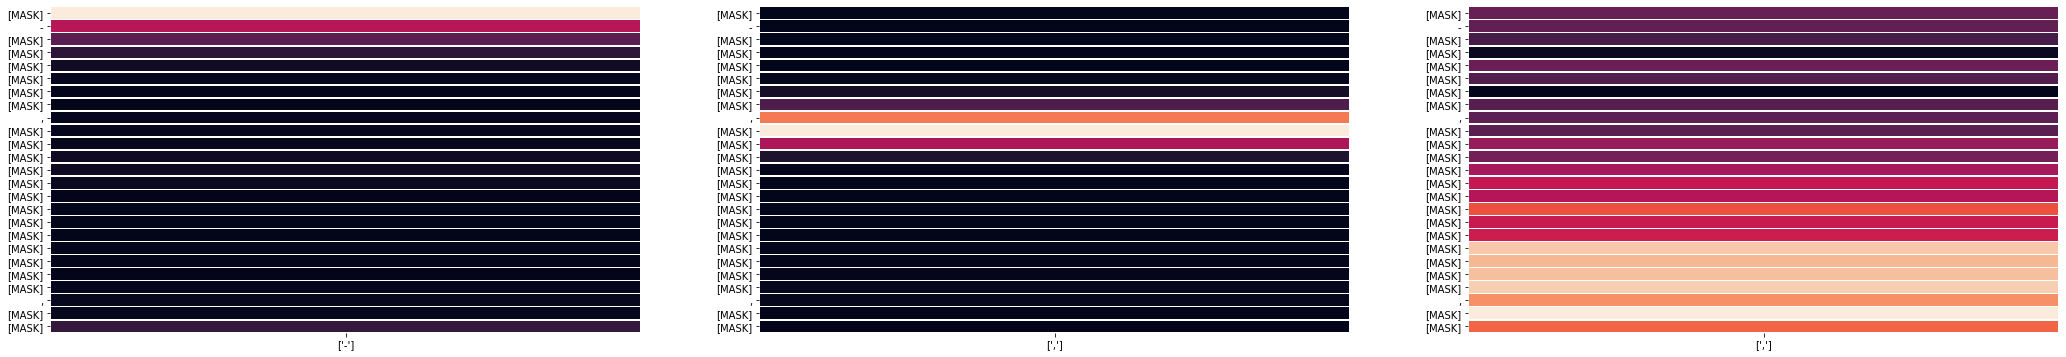


[ITERATION 2]
Current sentence: 	[CLS] [MASK] - [MASK] [MASK] [MASK] [MASK] [MASK] [MASK], [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK], [MASK] [MASK] [SEP]
Masked sentence: 	[CLS] [MASK] - [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK], [MASK] [MASK] [SEP]
Predictions: 	"-. &"


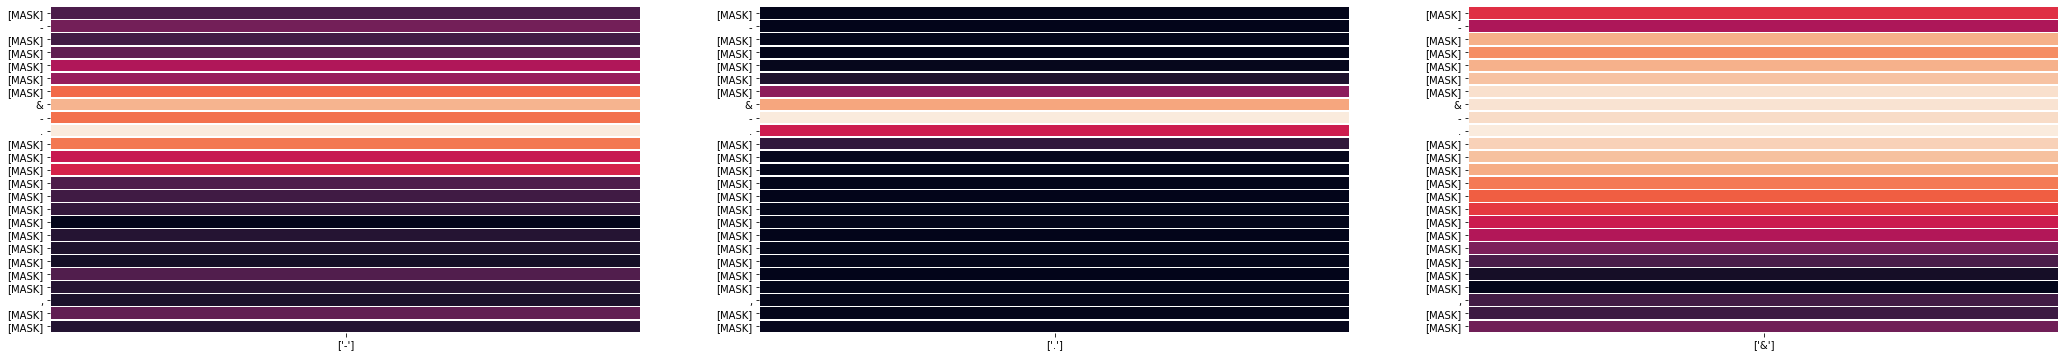


[ITERATION 3]
Current sentence: 	[CLS] [MASK] - [MASK] [MASK] [MASK] [MASK] [MASK] & -. [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK], [MASK] [MASK] [SEP]
Masked sentence: 	[CLS] [MASK] - [MASK] [MASK] [MASK] [MASK] [MASK] & [MASK]. [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK], [MASK] [MASK] [SEP]
Predictions: 	"com co ""


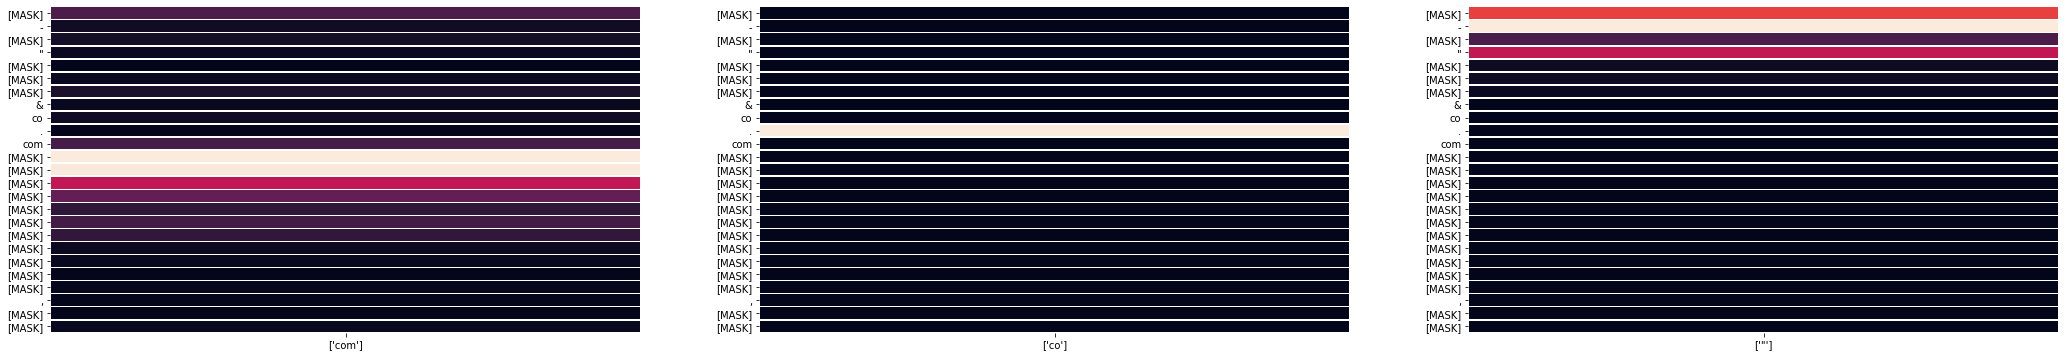


[ITERATION 4]
Current sentence: 	[CLS] [MASK] - [MASK] " [MASK] [MASK] [MASK] & co. com [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK], [MASK] [MASK] [SEP]
Masked sentence: 	[CLS] [MASK] [MASK] [MASK] " [MASK] [MASK] [MASK] & co [MASK] com [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK], [MASK] [MASK] [SEP]
Predictions: 	"market. on"


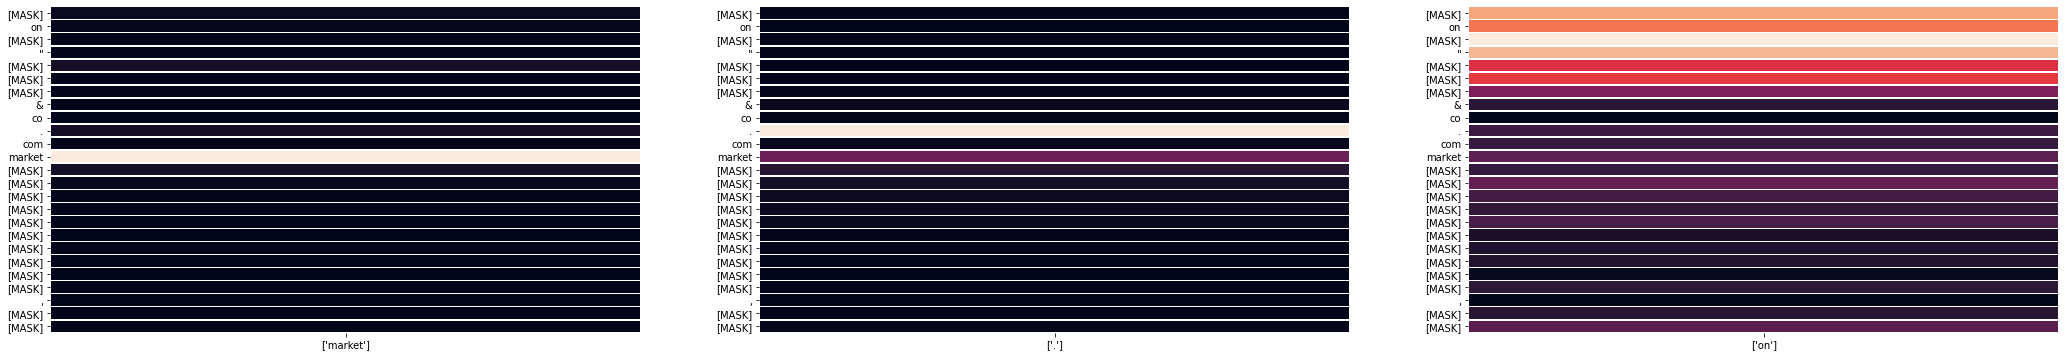


[ITERATION 5]
Current sentence: 	[CLS] [MASK] on [MASK] " [MASK] [MASK] [MASK] & co. com market [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK], [MASK] [MASK] [SEP]
Masked sentence: 	[CLS] [MASK] on [MASK] " [MASK] [MASK] [MASK] & co [MASK] com [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK], [MASK] [MASK] [SEP]
Predictions: 	"". /"


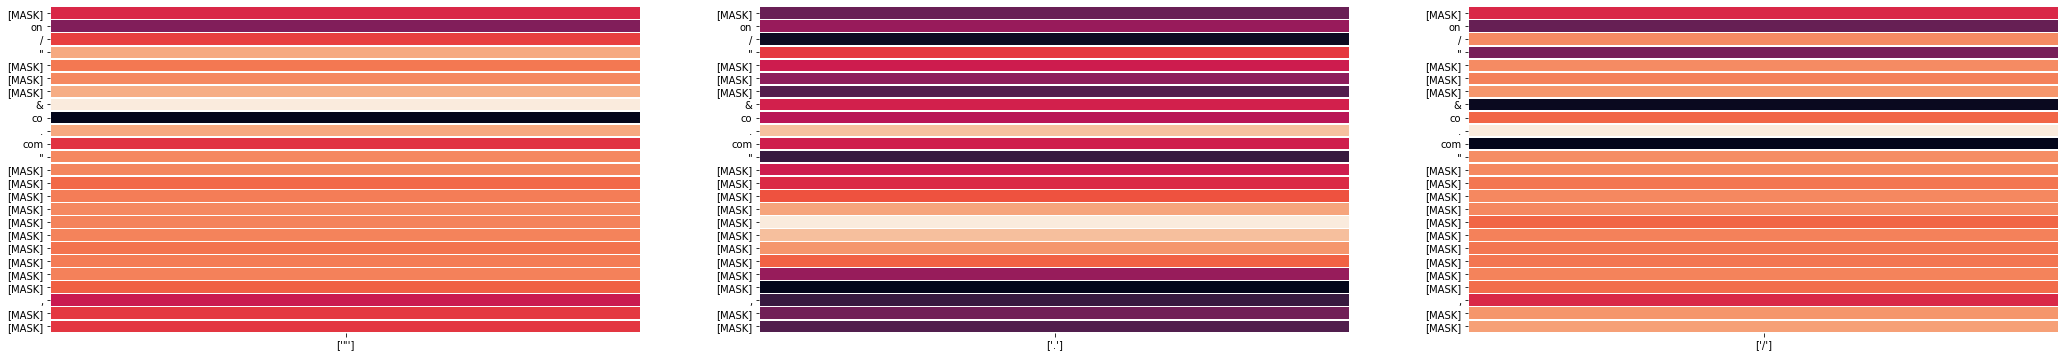


[ITERATION 6]
Current sentence: 	[CLS] [MASK] on / " [MASK] [MASK] [MASK] & co. com " [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK], [MASK] [MASK] [SEP]
Masked sentence: 	[CLS] [MASK] on / " [MASK] [MASK] [MASK] & [MASK]. com [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK], [MASK] [MASK] [SEP]
Predictions: 	"" archive smashwords"


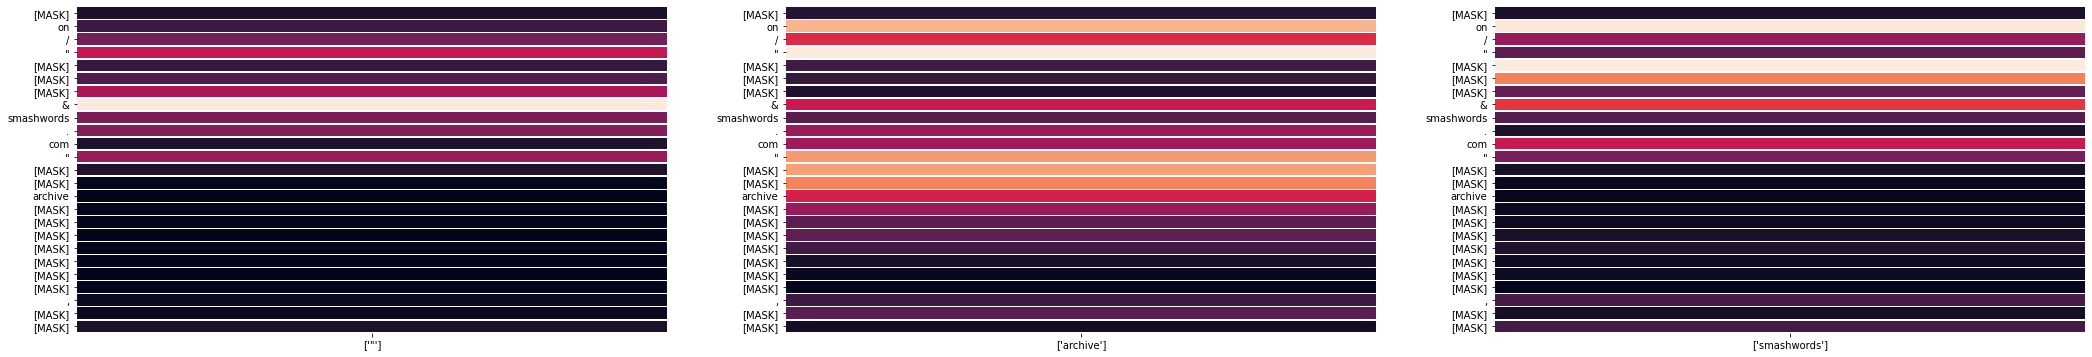


[ITERATION 7]
Current sentence: 	[CLS] [MASK] on / " [MASK] [MASK] [MASK] & smashwords. com " [MASK] [MASK] archive [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK], [MASK] [MASK] [SEP]
Masked sentence: 	[CLS] [MASK] [MASK] / " [MASK] [MASK] [MASK] & smashwords [MASK] com " [MASK] [MASK] archive [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK], [MASK] [MASK] [SEP]
Predictions: 	".. 3"


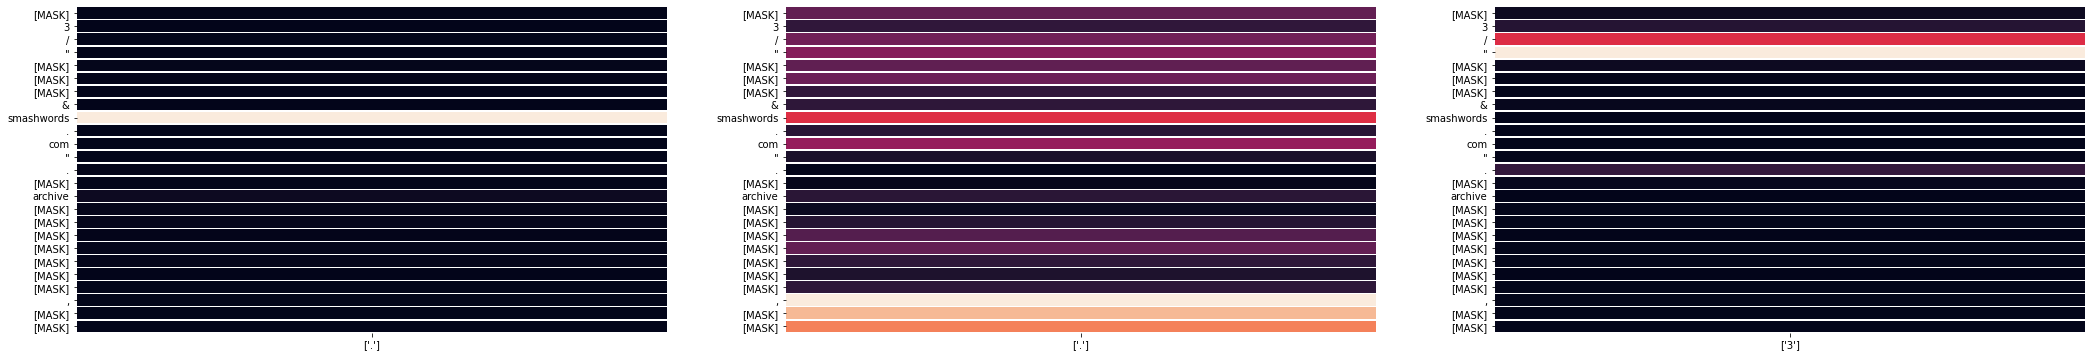


[ITERATION 8]
Current sentence: 	[CLS] [MASK] 3 / " [MASK] [MASK] [MASK] & smashwords. com ". [MASK] archive [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK], [MASK] [MASK] [SEP]
Masked sentence: 	[CLS] [MASK] 3 [MASK] " [MASK] [MASK] [MASK] & smashwords. com ". [MASK] archive [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK], [MASK] [MASK] [SEP]
Predictions: 	",.."


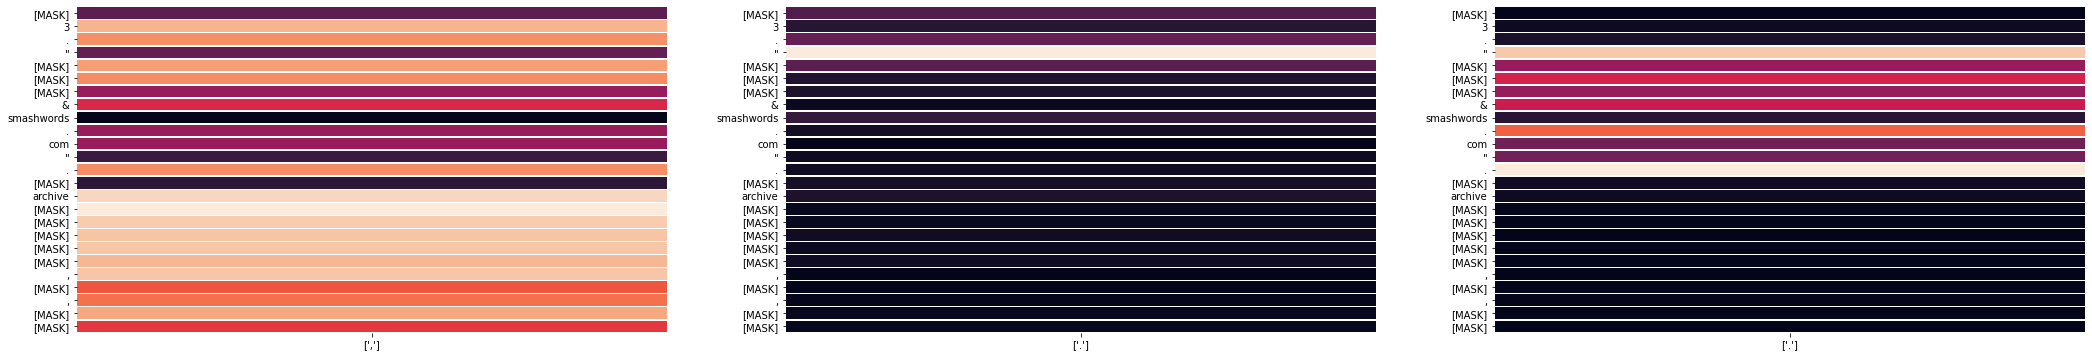


[ITERATION 9]
Current sentence: 	[CLS] [MASK] 3. " [MASK] [MASK] [MASK] & smashwords. com ". [MASK] archive [MASK] [MASK] [MASK] [MASK] [MASK], [MASK], [MASK] [MASK] [SEP]
Masked sentence: 	[CLS] [MASK] 3. [MASK] [MASK] [MASK] [MASK] & smashwords. com ". [MASK] archive [MASK] [MASK] [MASK] [MASK] [MASK], [MASK], [MASK] [MASK] [SEP]
Predictions: 	". on 4"


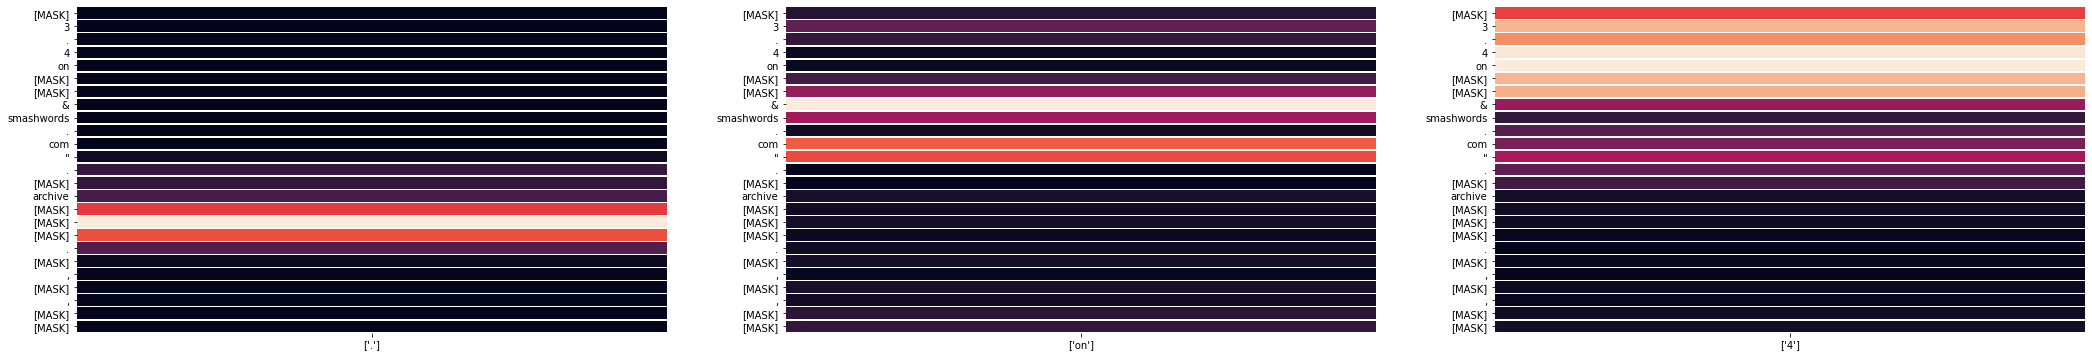


[ITERATION 10]
Current sentence: 	[CLS] [MASK] 3. 4 on [MASK] [MASK] & smashwords. com ". [MASK] archive [MASK] [MASK] [MASK]. [MASK], [MASK], [MASK] [MASK] [SEP]
Masked sentence: 	[CLS] [MASK] 3 [MASK] 4 [MASK] [MASK] [MASK] & smashwords. com ". [MASK] archive [MASK] [MASK] [MASK]. [MASK], [MASK], [MASK] [MASK] [SEP]
Predictions: 	"sec /,"


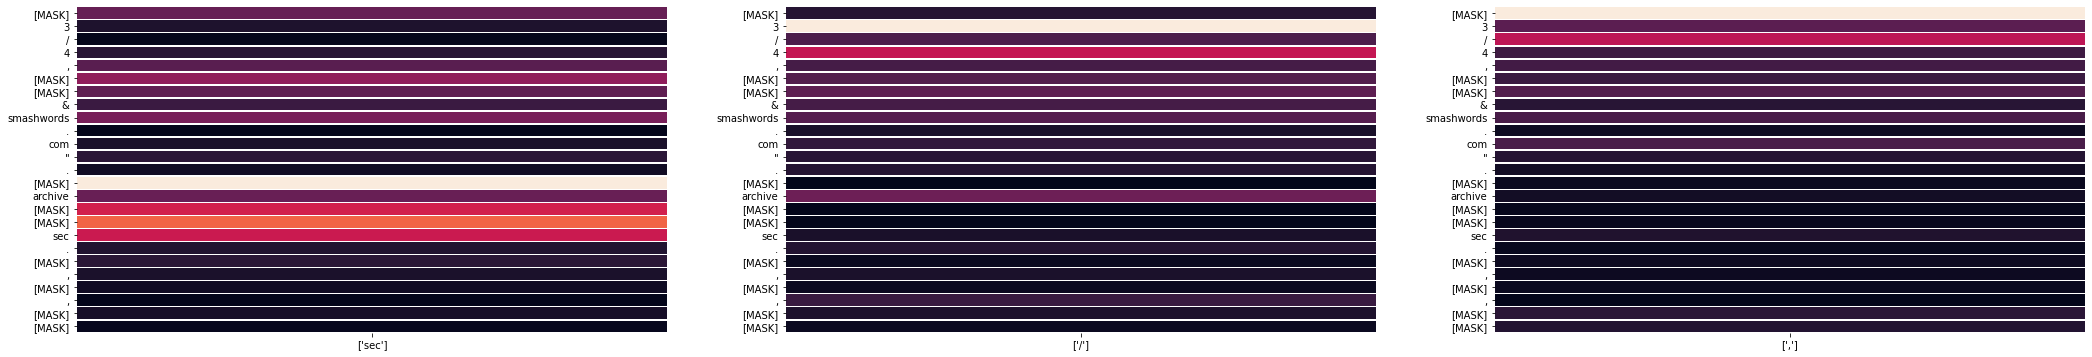


[ITERATION 11]
Current sentence: 	[CLS] [MASK] 3 / 4, [MASK] [MASK] & smashwords. com ". [MASK] archive [MASK] [MASK] sec. [MASK], [MASK], [MASK] [MASK] [SEP]
Masked sentence: 	[CLS] [MASK] 3 / 4, [MASK] [MASK] & smashwords. com ". [MASK] archive [MASK] [MASK] sec. [MASK], [MASK], [MASK] [MASK] [SEP]
Predictions: 	", 2 7"


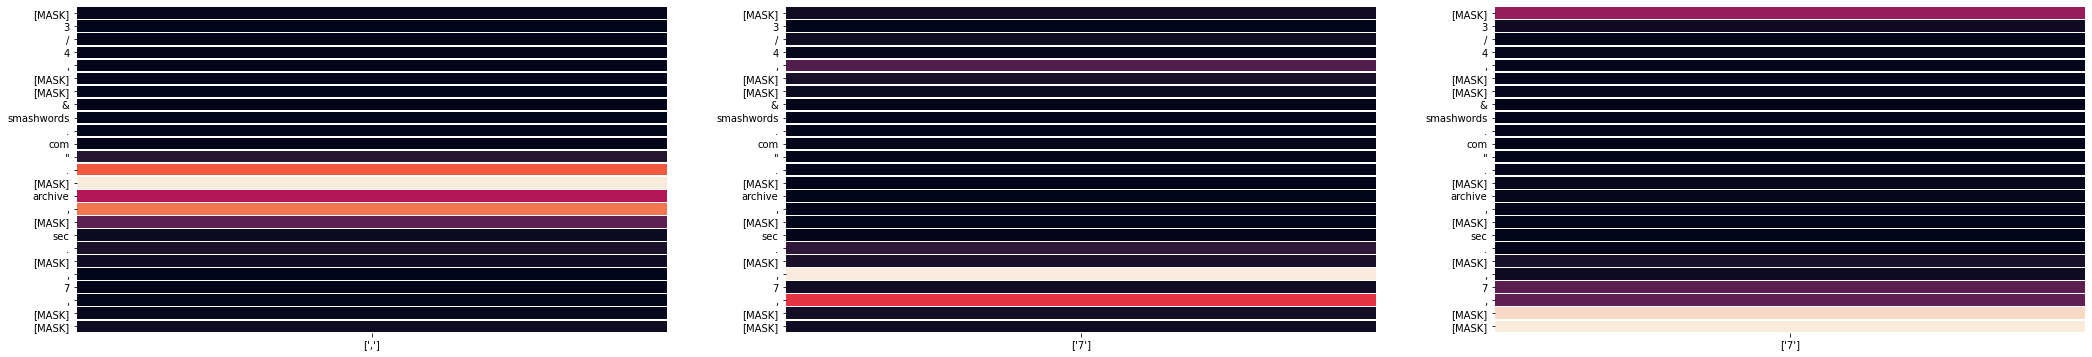


[ITERATION 12]
Current sentence: 	[CLS] [MASK] 3 / 4, [MASK] [MASK] & smashwords. com ". [MASK] archive, [MASK] sec. [MASK], 7, [MASK] [MASK] [SEP]
Masked sentence: 	[CLS] [MASK] 3 / 4, [MASK] [MASK] & smashwords. com ". [MASK] archive, [MASK] sec. [MASK] [MASK] 7, [MASK] [MASK] [SEP]
Predictions: 	"internet :."


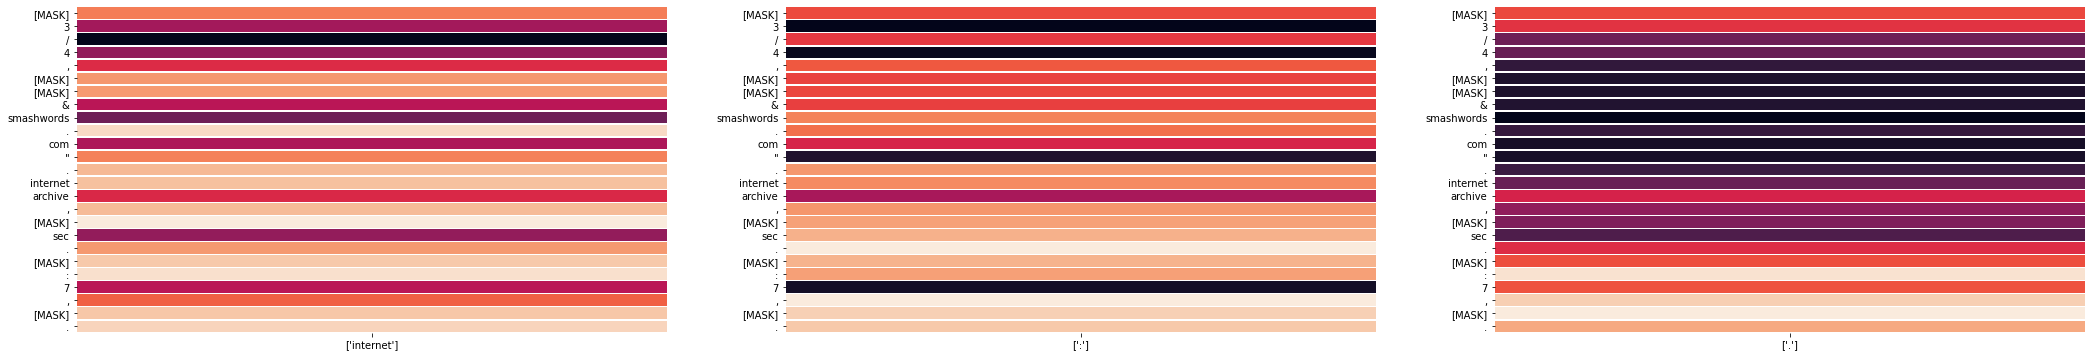


[ITERATION 13]
Current sentence: 	[CLS] [MASK] 3 / 4, [MASK] [MASK] & smashwords. com ". internet archive, [MASK] sec. [MASK] : 7, [MASK]. [SEP]
Masked sentence: 	[CLS] [MASK] 3 / 4, [MASK] [MASK] & smashwords. com ". internet archive, [MASK] sec [MASK] [MASK] : 7, [MASK] [MASK] [SEP]
Predictions: 	". "."


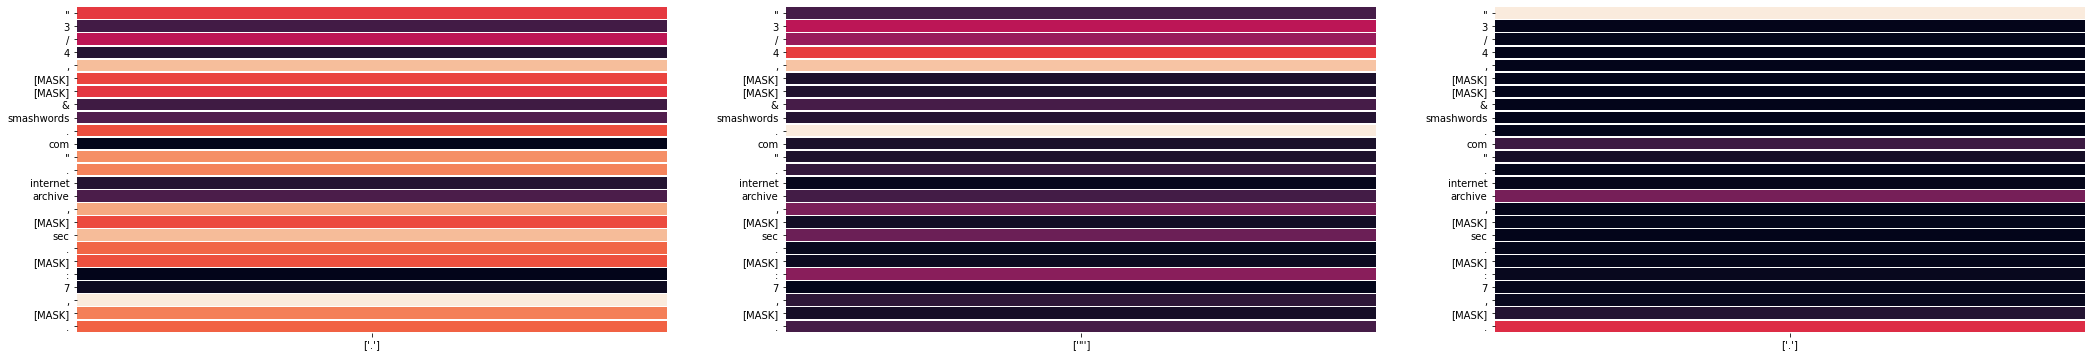


[ITERATION 14]
Current sentence: 	[CLS] " 3 / 4, [MASK] [MASK] & smashwords. com ". internet archive, [MASK] sec. [MASK] : 7, [MASK]. [SEP]
Masked sentence: 	[CLS] " 3 / 4, [MASK] [MASK] [MASK] smashwords [MASK] com [MASK]. internet archive, [MASK] sec. [MASK] : 7, [MASK]. [SEP]
Predictions: 	".. ""


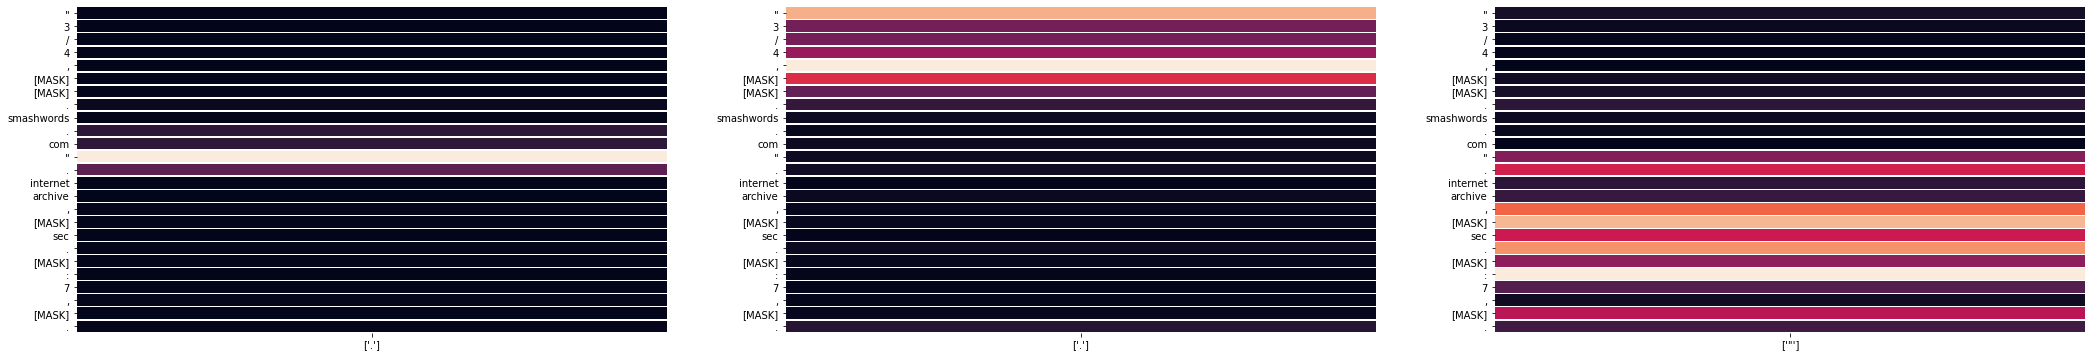


[ITERATION 15]
Current sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. smashwords. com ". internet archive, [MASK] sec. [MASK] : 7, [MASK]. [SEP]
Masked sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. smashwords. com [MASK]. internet archive, [MASK] sec [MASK] [MASK] [MASK] 7, [MASK]. [SEP]
Predictions: 	"" 8 november"


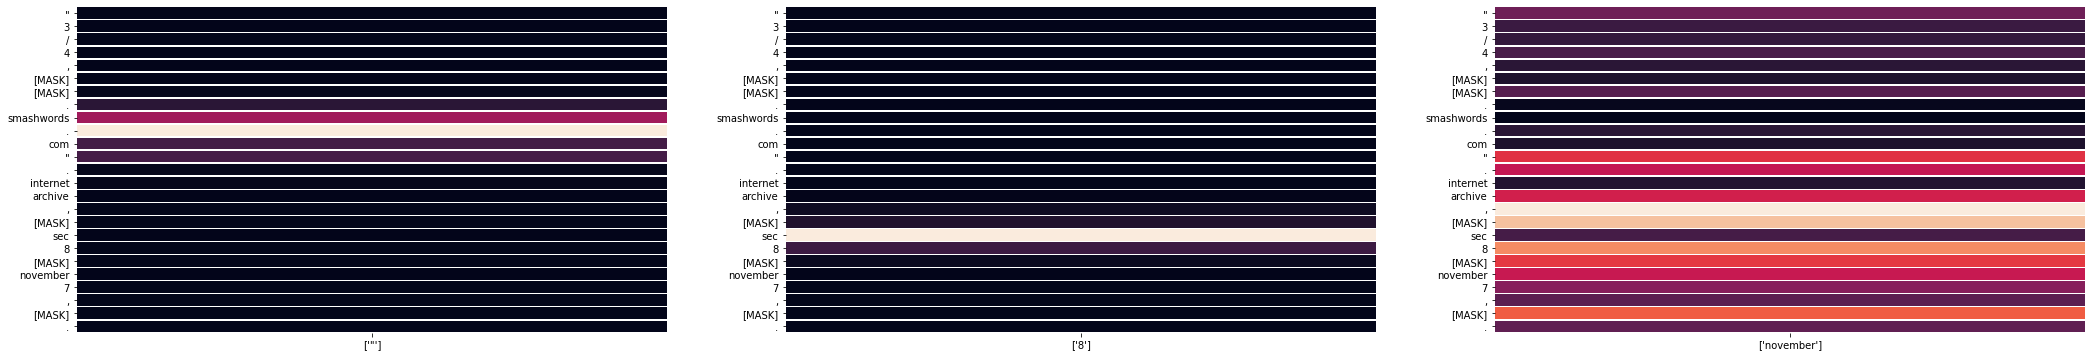


[ITERATION 16]
Current sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. smashwords. com ". internet archive, [MASK] sec 8 [MASK] november 7, [MASK]. [SEP]
Masked sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. smashwords. com [MASK]. internet archive [MASK] [MASK] [MASK] 8 [MASK] november 7, [MASK]. [SEP]
Predictions: 	"" :."


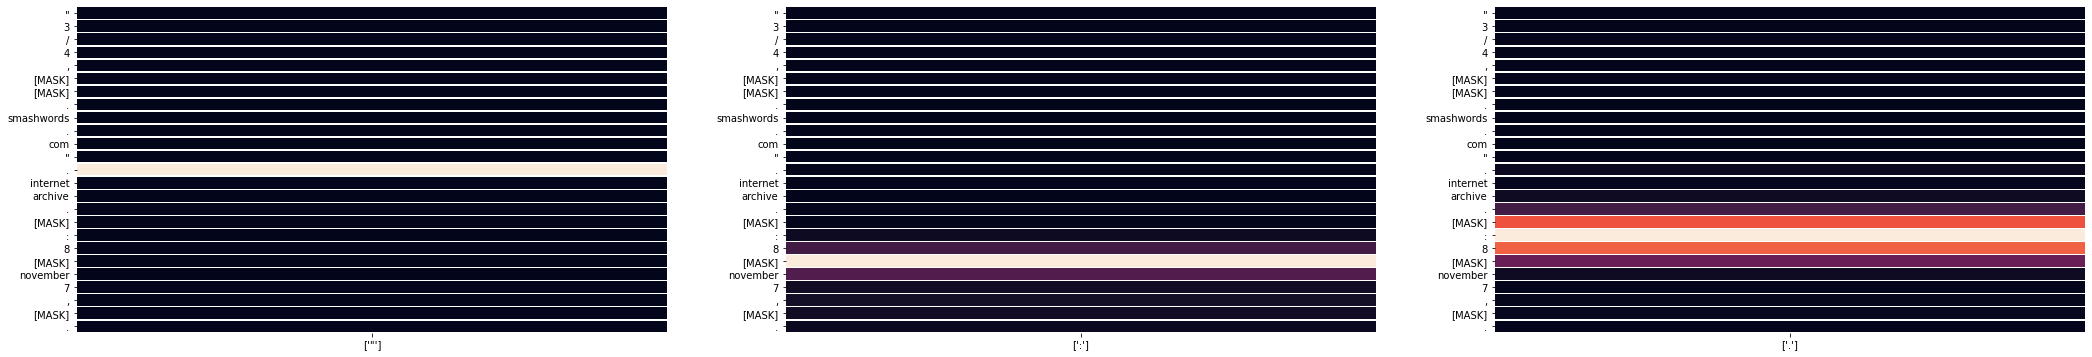


[ITERATION 17]
Current sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. smashwords. com ". internet archive. [MASK] : 8 [MASK] november 7, [MASK]. [SEP]
Masked sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. smashwords. com " [MASK] internet archive. [MASK] [MASK] 8 [MASK] november 7, [MASK]. [SEP]
Predictions: 	"., -"


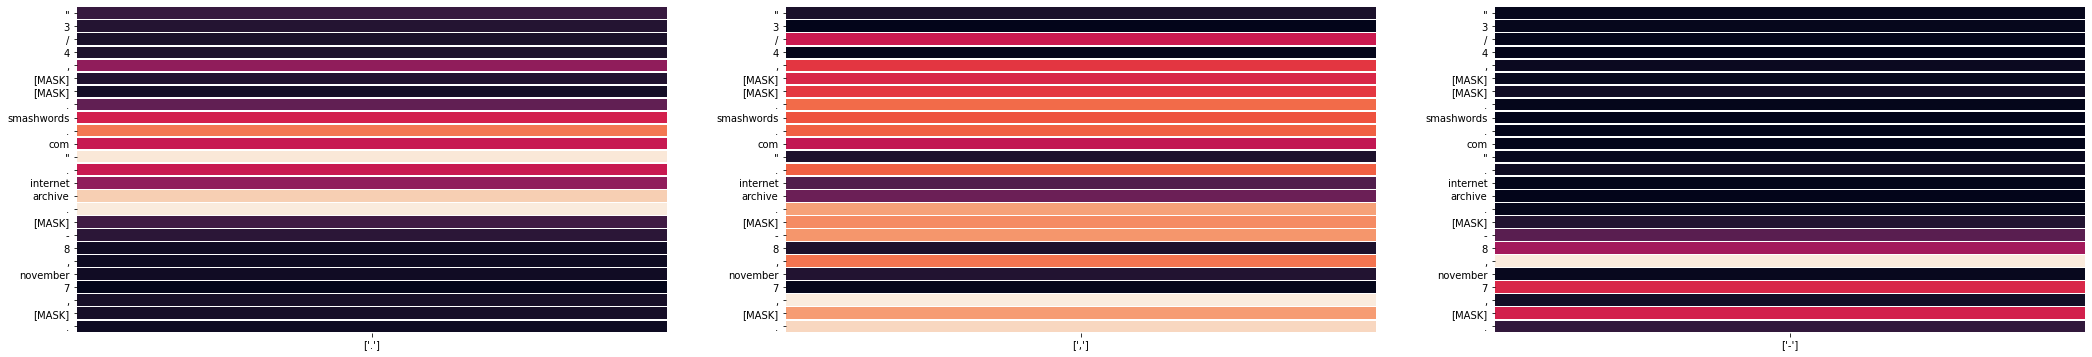


[ITERATION 18]
Current sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. smashwords. com ". internet archive. [MASK] - 8, november 7, [MASK]. [SEP]
Masked sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. smashwords. com " [MASK] internet archive. [MASK] - 8, november [MASK], [MASK]. [SEP]
Predictions: 	". 7 28"


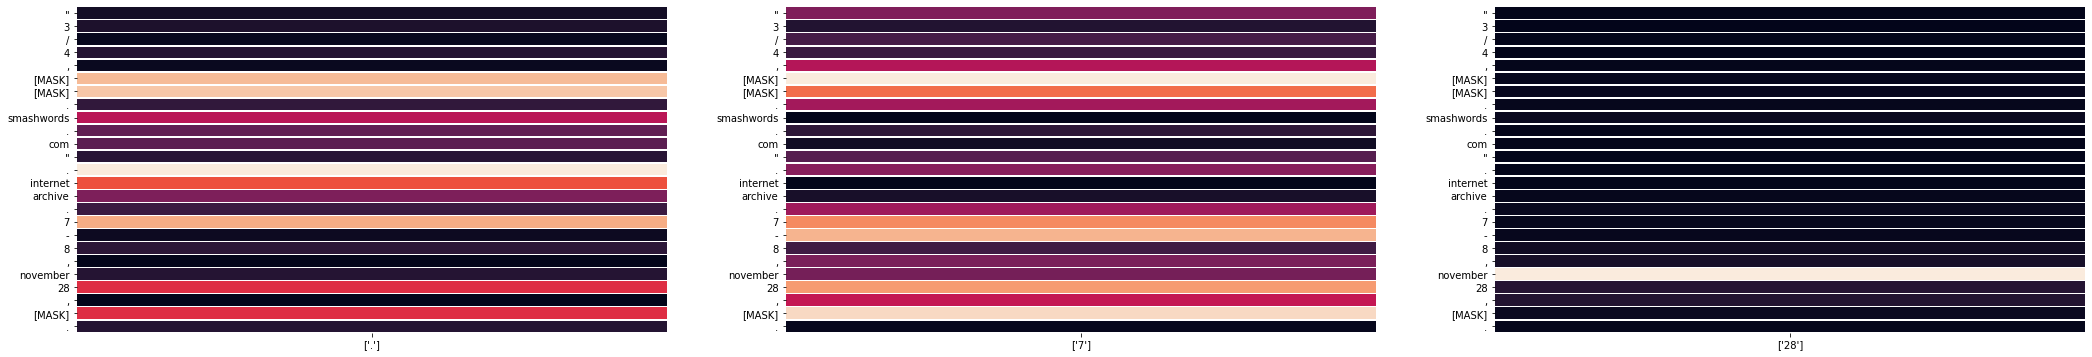


[ITERATION 19]
Current sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. smashwords. com ". internet archive. 7 - 8, november 28, [MASK]. [SEP]
Masked sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. smashwords. com ". [MASK] archive. 7 - 8, [MASK] 28, [MASK]. [SEP]
Predictions: 	"amazon june april"


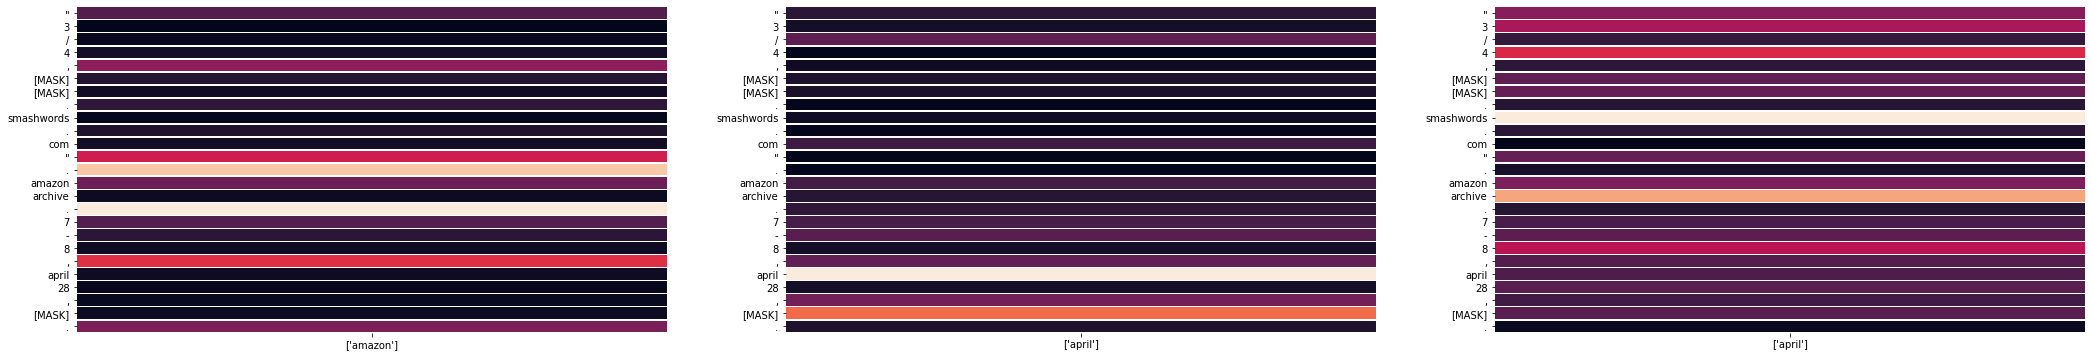


[ITERATION 20]
Current sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. smashwords. com ". amazon archive. 7 - 8, april 28, [MASK]. [SEP]
Masked sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. [MASK]. com ". amazon archive [MASK] 7 - 8, april 28, [MASK]. [SEP]
Predictions: 	". 2015 amazon"


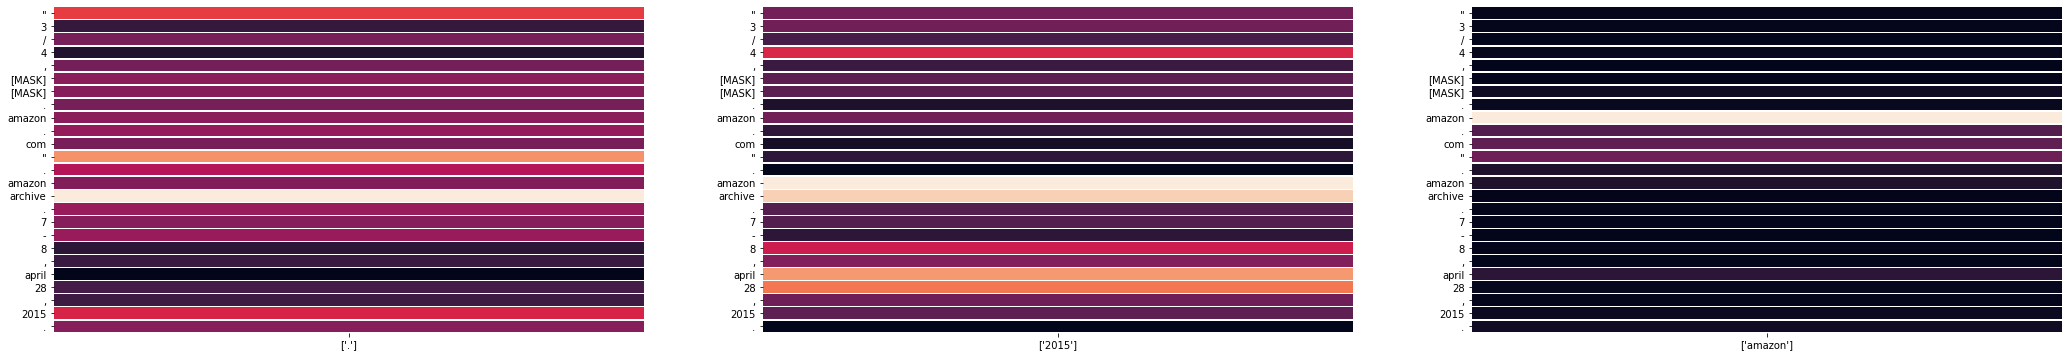


[ITERATION 21]
Current sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. amazon. com ". amazon archive. 7 - 8, april 28, 2015. [SEP]
Masked sentence: 	[CLS] [MASK] 3 / 4, [MASK] [MASK]. amazon. [MASK] ". amazon archive. 7 - 8 [MASK] april 28, 2015. [SEP]
Predictions: 	"", com"


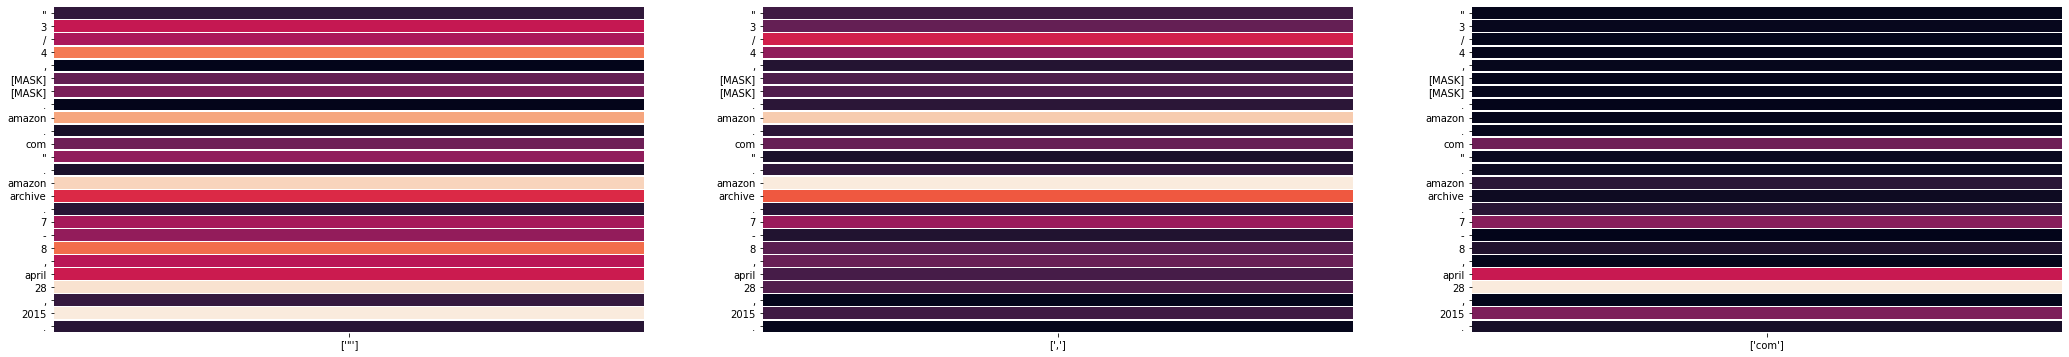


[ITERATION 22]
Current sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. amazon. com ". amazon archive. 7 - 8, april 28, 2015. [SEP]
Masked sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. amazon. com ". [MASK] archive. 7 - 8, [MASK] 28, [MASK]. [SEP]
Predictions: 	"internet p november"


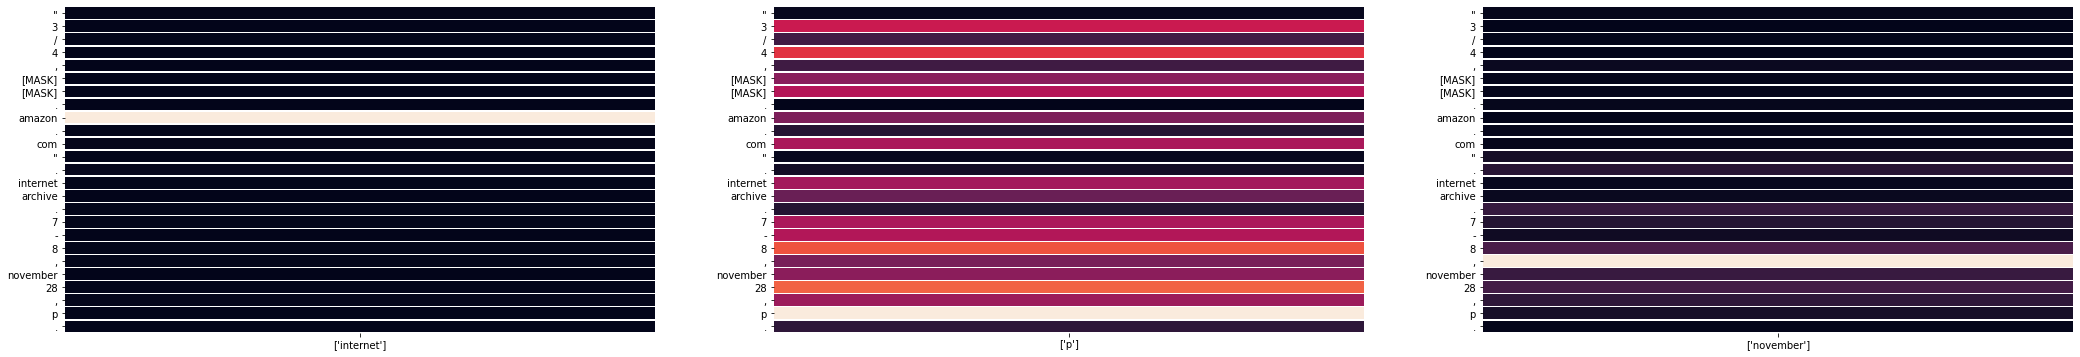


[ITERATION 23]
Current sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. amazon. com ". internet archive. 7 - 8, november 28, p. [SEP]
Masked sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. [MASK]. com ". internet archive. 7 - 8, november [MASK], [MASK]. [SEP]
Predictions: 	"amazon 25 2011"


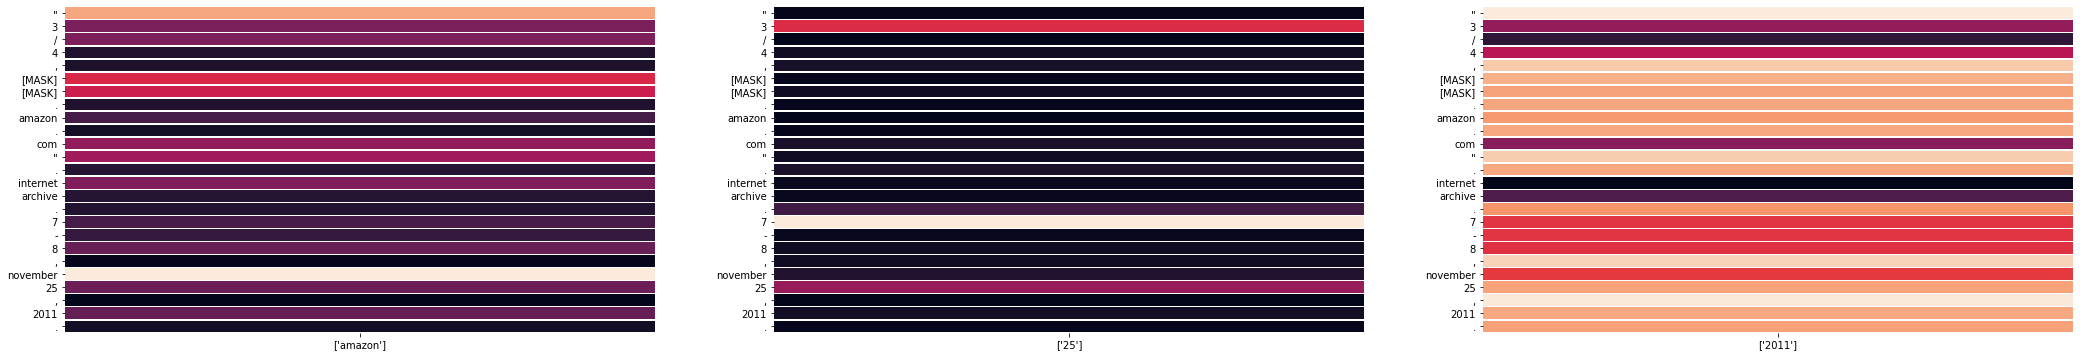


[ITERATION 24]
Current sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. amazon. com ". internet archive. 7 - 8, november 25, 2011. [SEP]
Masked sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. amazon. com ". internet archive. [MASK] - 8 [MASK] [MASK] 25, 2011. [SEP]
Predictions: 	"november 1 -"


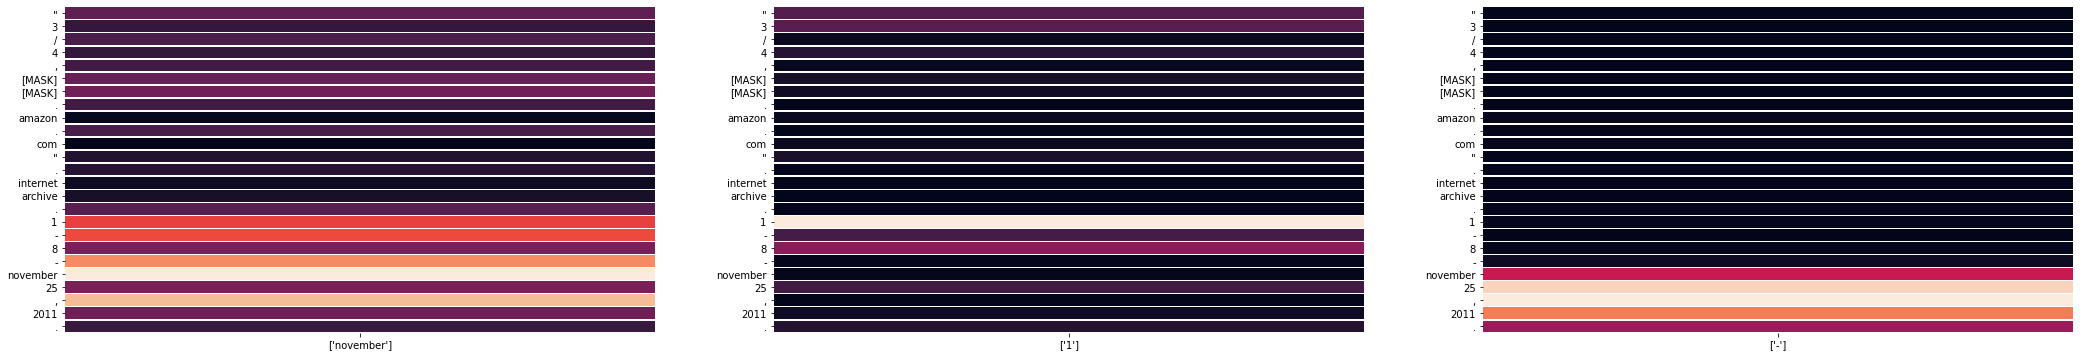


[ITERATION 25]
Current sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. amazon. com ". internet archive. 1 - 8 - november 25, 2011. [SEP]
Masked sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. amazon. com ". internet archive. [MASK] - 8 - november [MASK], 2011. [SEP]
Predictions: 	"4 7 20"


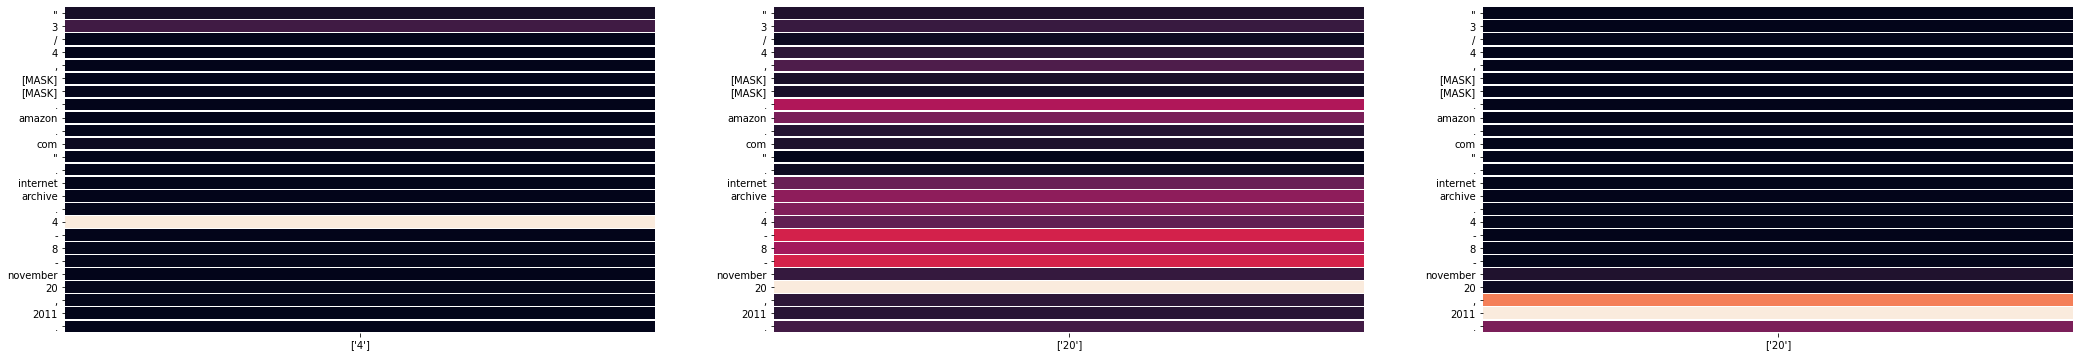


[ITERATION 26]
Current sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. amazon. com ". internet archive. 4 - 8 - november 20, 2011. [SEP]
Masked sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. amazon. com ". internet archive. [MASK] - 8 - november [MASK], 2011 [MASK] [SEP]
Predictions: 	"11 22."


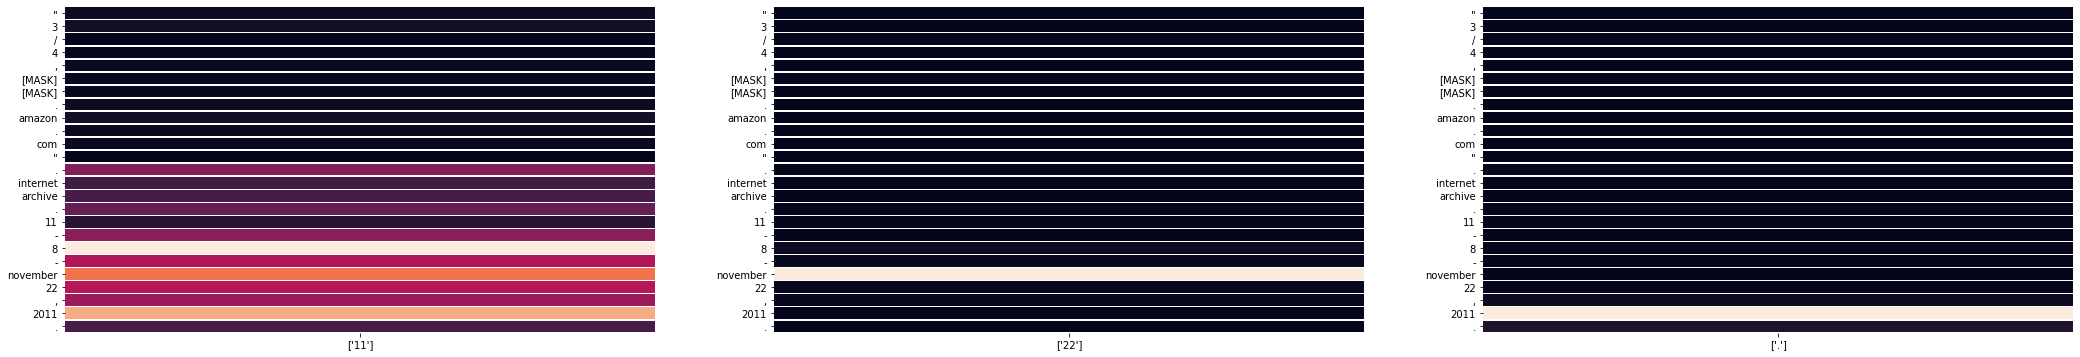


[ITERATION 27]
Current sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. amazon. com ". internet archive. 11 - 8 - november 22, 2011. [SEP]
Masked sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. amazon. com ". internet archive. 11 - 8 - [MASK] 22, [MASK]. [SEP]
Predictions: 	"october july p"


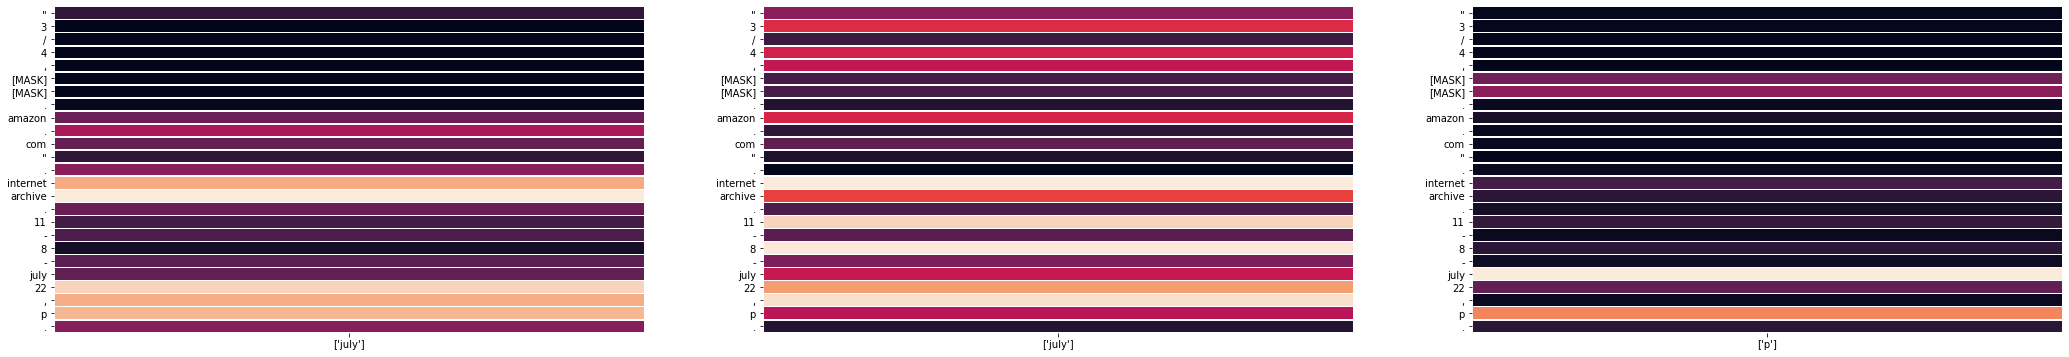


[ITERATION 28]
Current sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. amazon. com ". internet archive. 11 - 8 - july 22, p. [SEP]
Masked sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. amazon. com " [MASK] internet archive. 11 - 8 - [MASK] 22, [MASK]. [SEP]
Predictions: 	". p november"


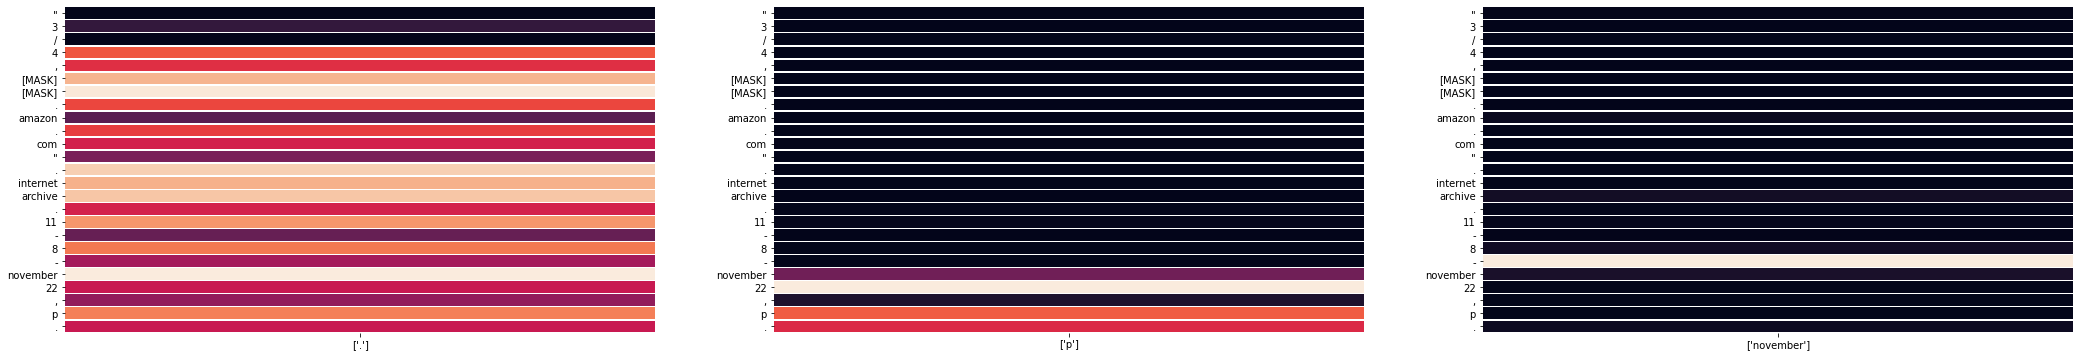


[ITERATION 29]
Current sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. amazon. com ". internet archive. 11 - 8 - november 22, p. [SEP]
Masked sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. amazon. com ". internet archive. 11 - 8 [MASK] november 22 [MASK] [MASK]. [SEP]
Predictions: 	") 1995."


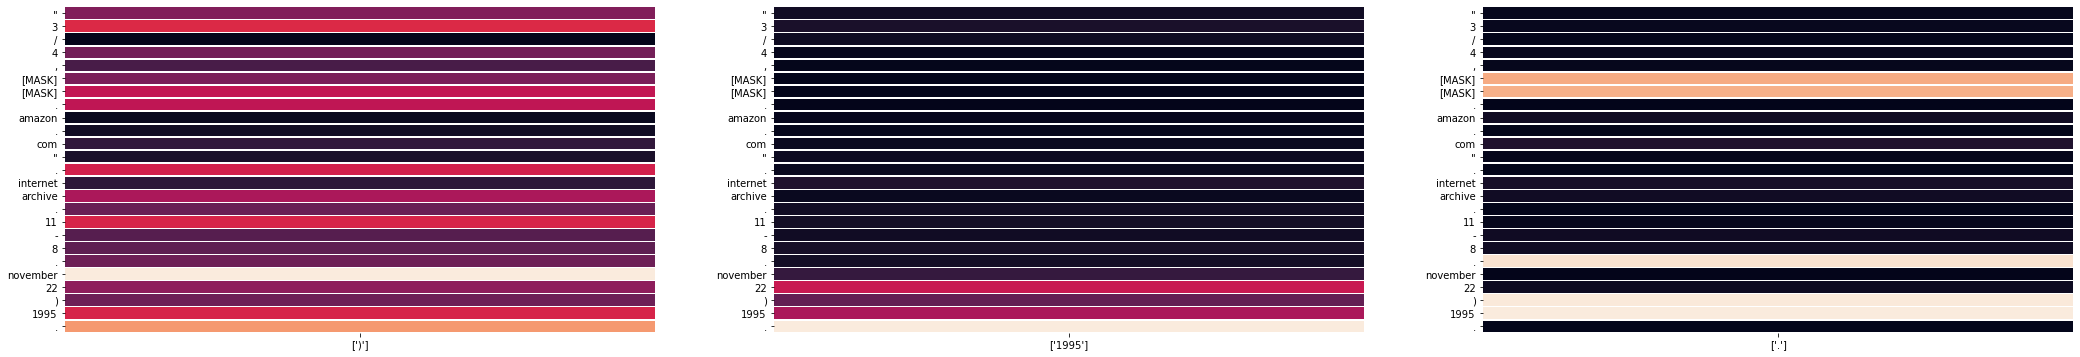


[ITERATION 30]
Current sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. amazon. com ". internet archive. 11 - 8. november 22 ) 1995. [SEP]
Masked sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. amazon. com ". [MASK] archive. 11 - 8. november [MASK] [MASK] 1995. [SEP]
Predictions: 	"digital 4,"


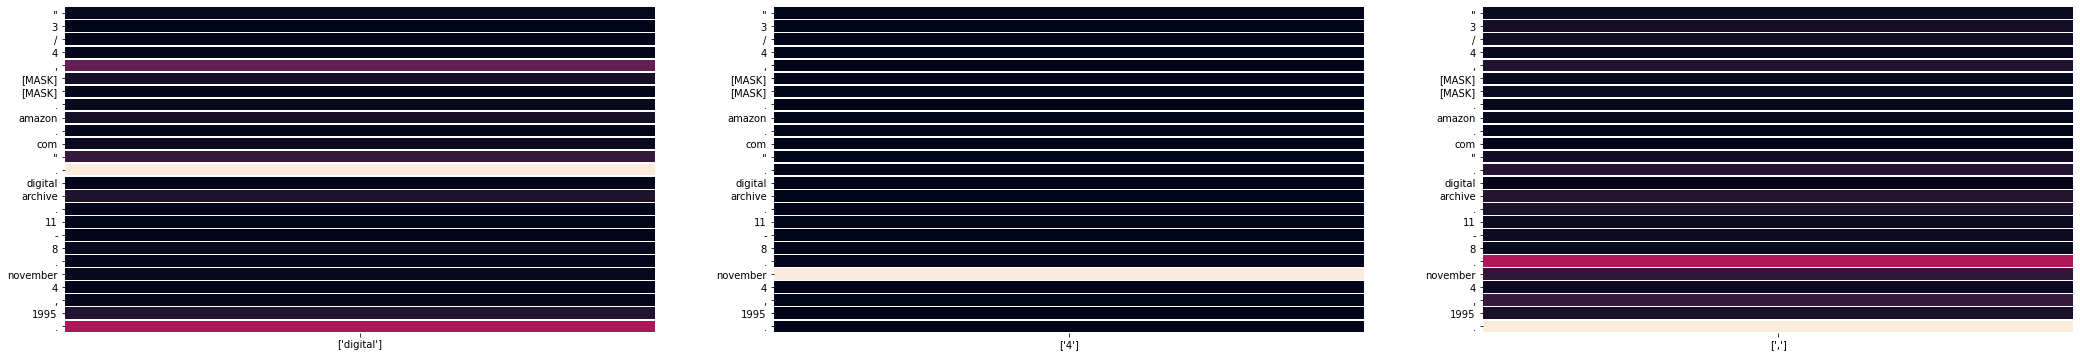


[ITERATION 31]
Current sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. amazon. com ". digital archive. 11 - 8. november 4, 1995. [SEP]
Masked sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. amazon. com " [MASK] digital archive. 11 - 8. [MASK] 4, 1995. [SEP]
Predictions: 	". july."


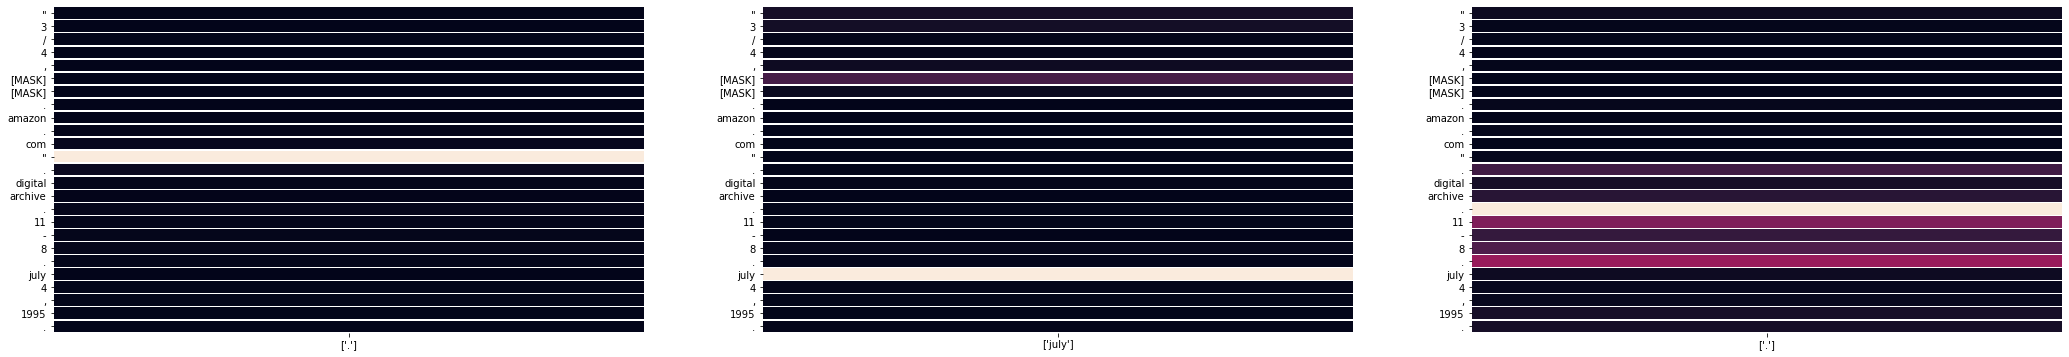


[ITERATION 32]
Current sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. amazon. com ". digital archive. 11 - 8. july 4, 1995. [SEP]
Masked sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. amazon. com [MASK]. digital archive. 11 - [MASK]. [MASK] 4, 1995. [SEP]
Predictions: 	"" june 1"


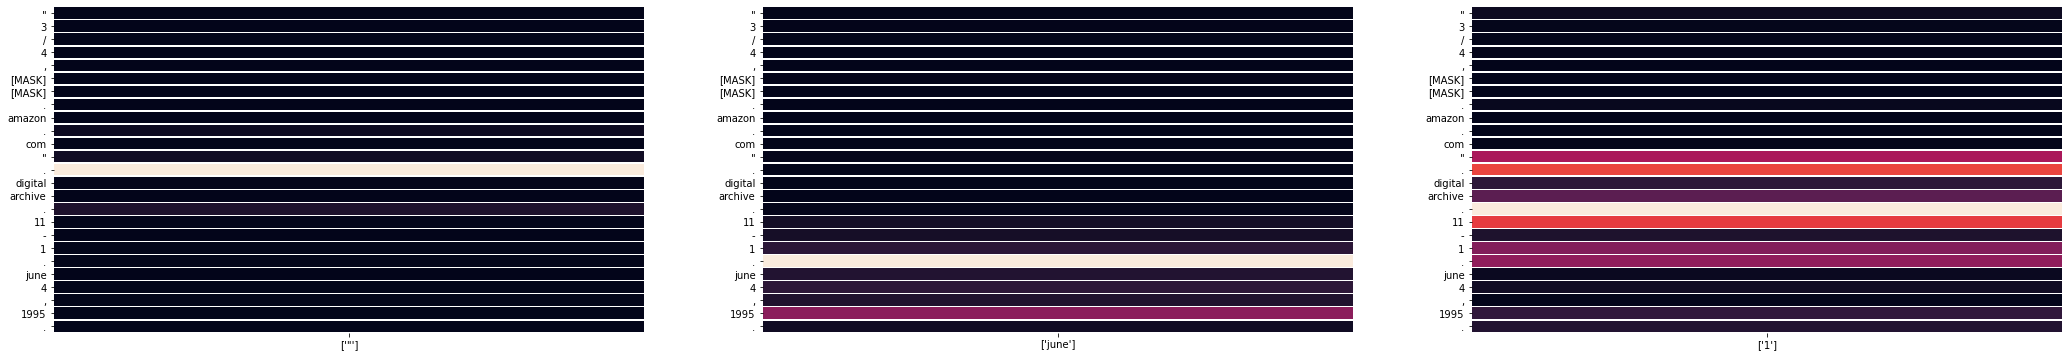


[ITERATION 33]
Current sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. amazon. com ". digital archive. 11 - 1. june 4, 1995. [SEP]
Masked sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. amazon. com " [MASK] digital archive. [MASK] - 1. june [MASK], 1995. [SEP]
Predictions: 	". 4 11"


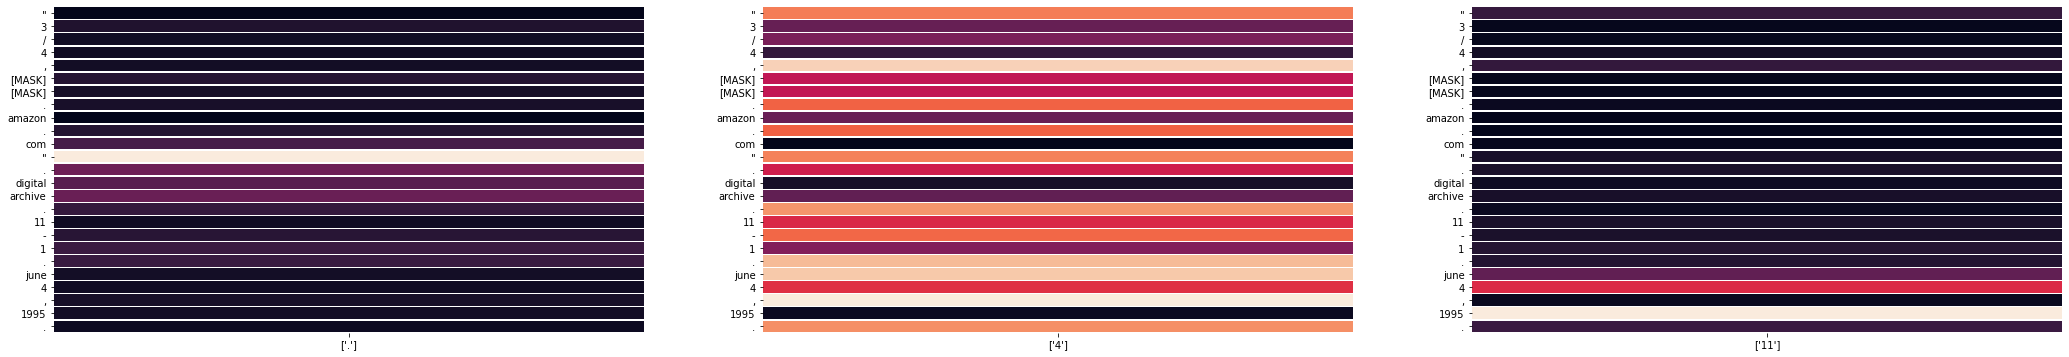


[ITERATION 34]
Current sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. amazon. com ". digital archive. 11 - 1. june 4, 1995. [SEP]
Masked sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. amazon. com [MASK]. digital archive. [MASK] - 1. june 4, [MASK]. [SEP]
Predictions: 	"" 73 2018"


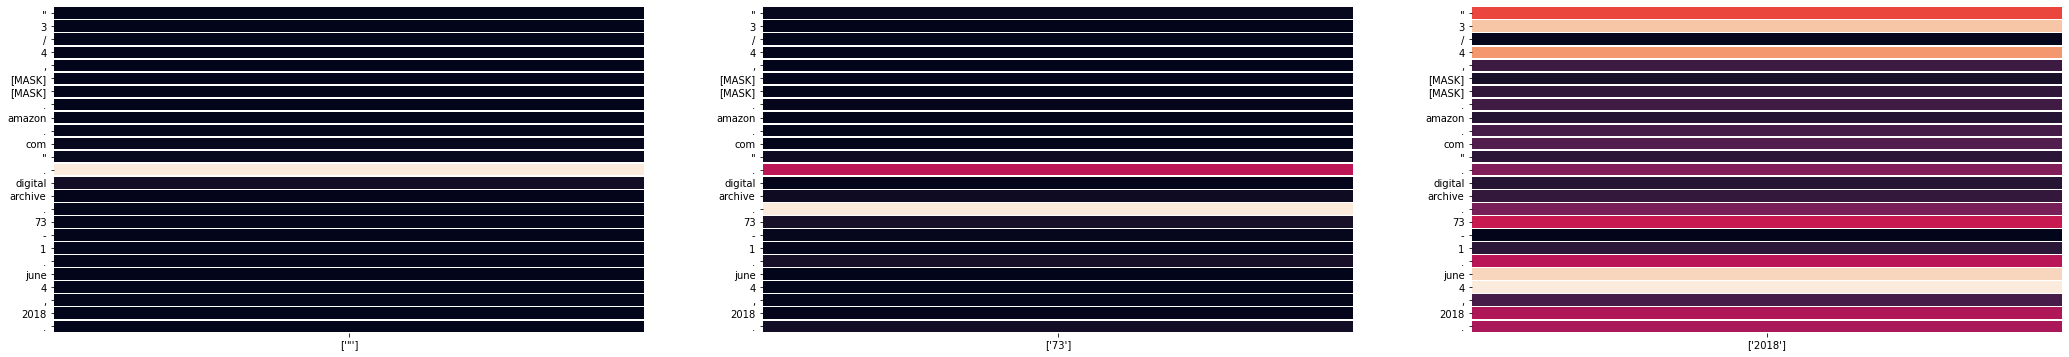


[ITERATION 35]
Current sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. amazon. com ". digital archive. 73 - 1. june 4, 2018. [SEP]
Masked sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. amazon. com " [MASK] digital archive [MASK] 73 - 1. june 4, 2018 [MASK] [SEP]
Predictions: 	". :."


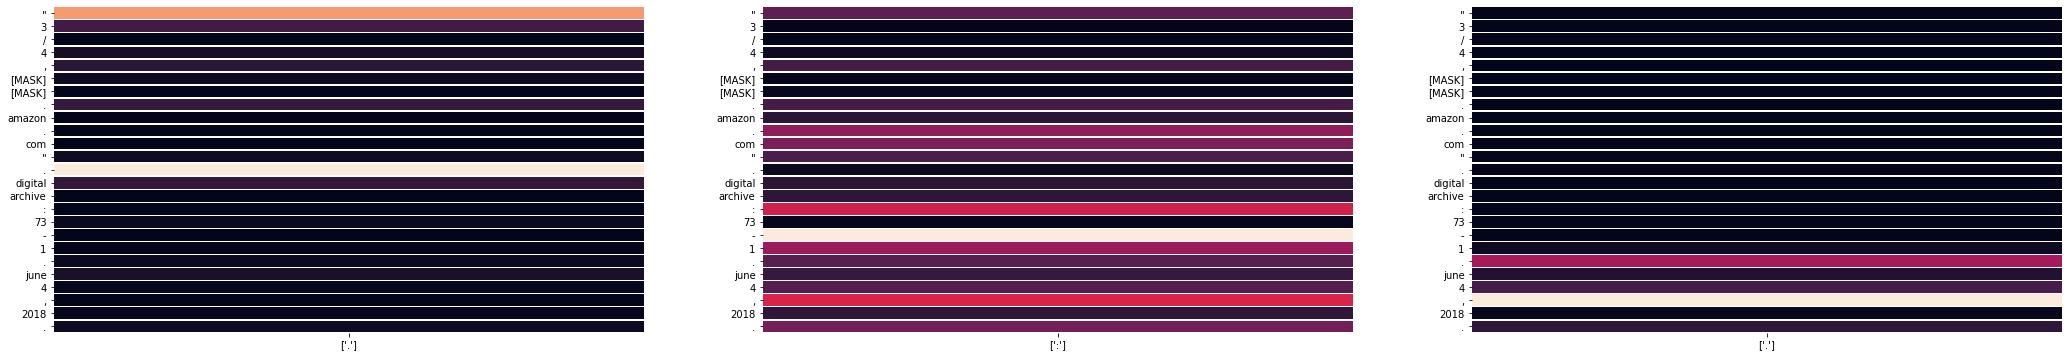


[ITERATION 36]
Current sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. amazon. com ". digital archive : 73 - 1. june 4, 2018. [SEP]
Masked sentence: 	[CLS] [MASK] 3 / 4, [MASK] [MASK]. amazon. com ". digital archive : 73 [MASK] 1. june 4 [MASK] 2018. [SEP]
Predictions: 	"" :,"


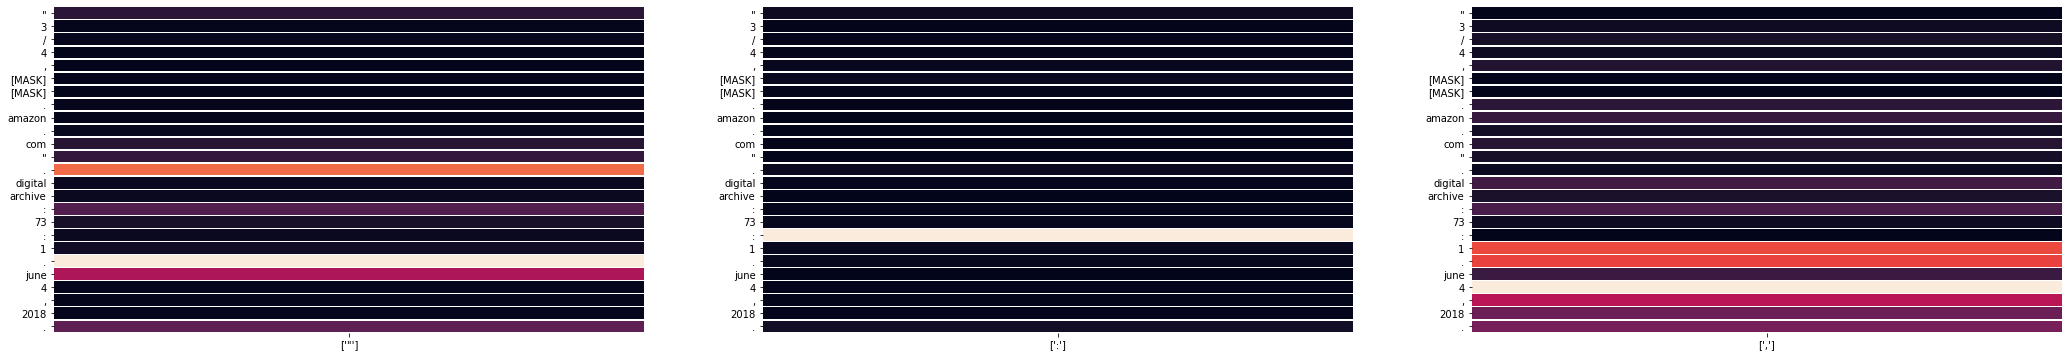


[ITERATION 37]
Current sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. amazon. com ". digital archive : 73 : 1. june 4, 2018. [SEP]
Masked sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. amazon. com " [MASK] digital archive : 73 : 1 [MASK] [MASK] 4, 2018. [SEP]
Predictions: 	"- - -"


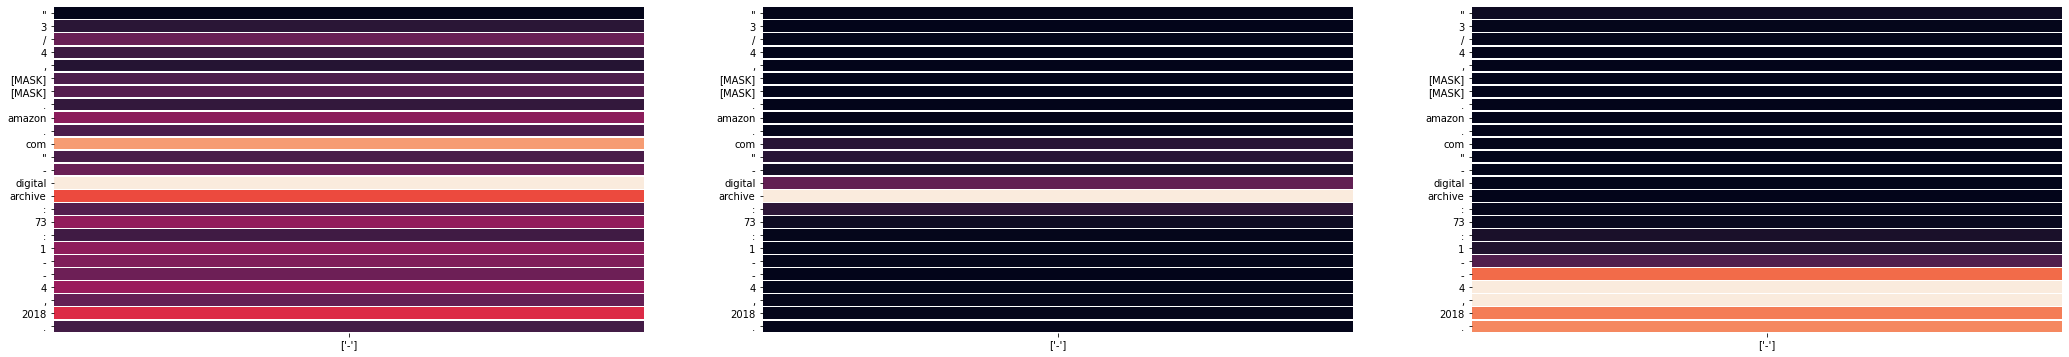


[ITERATION 38]
Current sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. amazon. com " - digital archive : 73 : 1 - - 4, 2018. [SEP]
Masked sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. amazon. com " - digital [MASK] : 73 [MASK] 1 - - 4, 2018 [MASK] [SEP]
Predictions: 	": series ;"


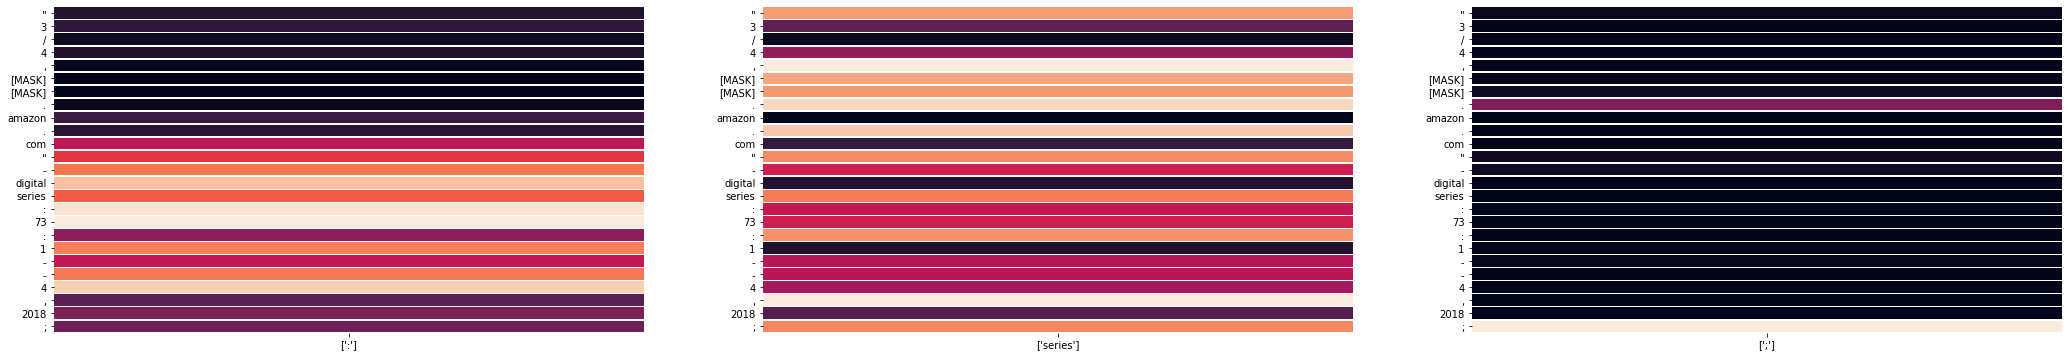


[ITERATION 39]
Current sentence: 	[CLS] " 3 / 4, [MASK] [MASK]. amazon. com " - digital series : 73 : 1 - - 4, 2018 ; [SEP]
Masked sentence: 	[CLS] " 3 [MASK] 4, [MASK] [MASK]. amazon. com " - digital series : 73 : 1 - - [MASK], 2018 [MASK] [SEP]
Predictions: 	"-, ;"


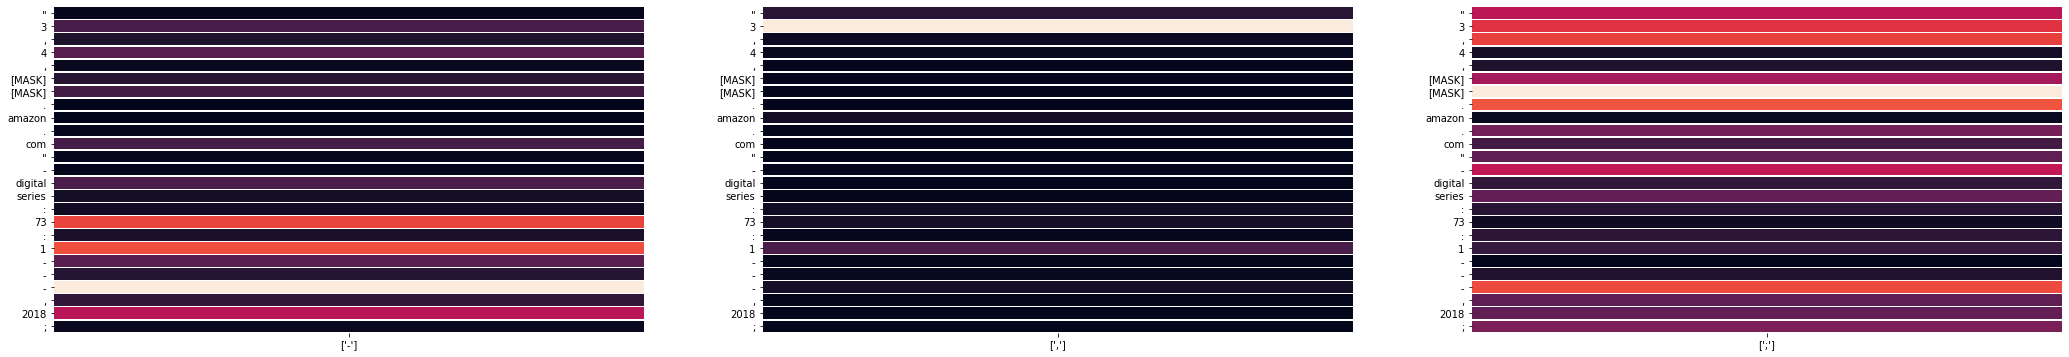


[ITERATION 40]
Current sentence: 	[CLS] " 3, 4, [MASK] [MASK]. amazon. com " - digital series : 73 : 1 - - -, 2018 ; [SEP]
Masked sentence: 	[CLS] " [MASK], 4, [MASK] [MASK]. amazon. com " - digital series : [MASK] : 1 - - [MASK], 2018 ; [SEP]
Predictions: 	"3 - 32"


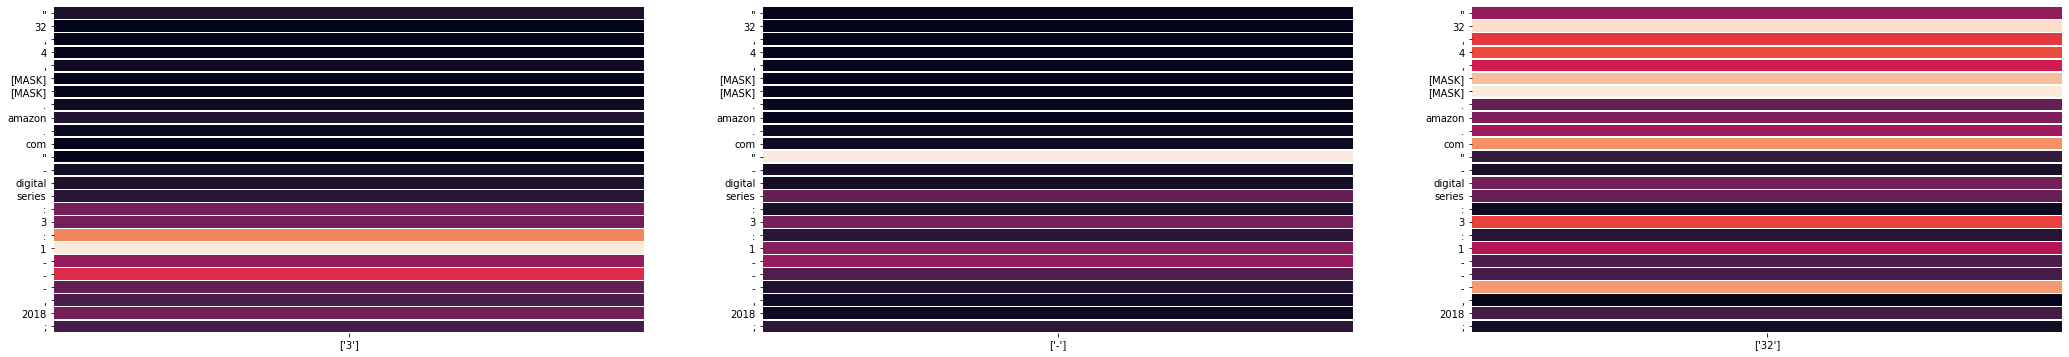


[ITERATION 41]
Current sentence: 	[CLS] " 32, 4, [MASK] [MASK]. amazon. com " - digital series : 3 : 1 - - -, 2018 ; [SEP]
Masked sentence: 	[CLS] " 32, 4, [MASK] [MASK]. amazon. com " - [MASK] series : [MASK] : 1 [MASK] - -, 2018 ; [SEP]
Predictions: 	"4 1 index"


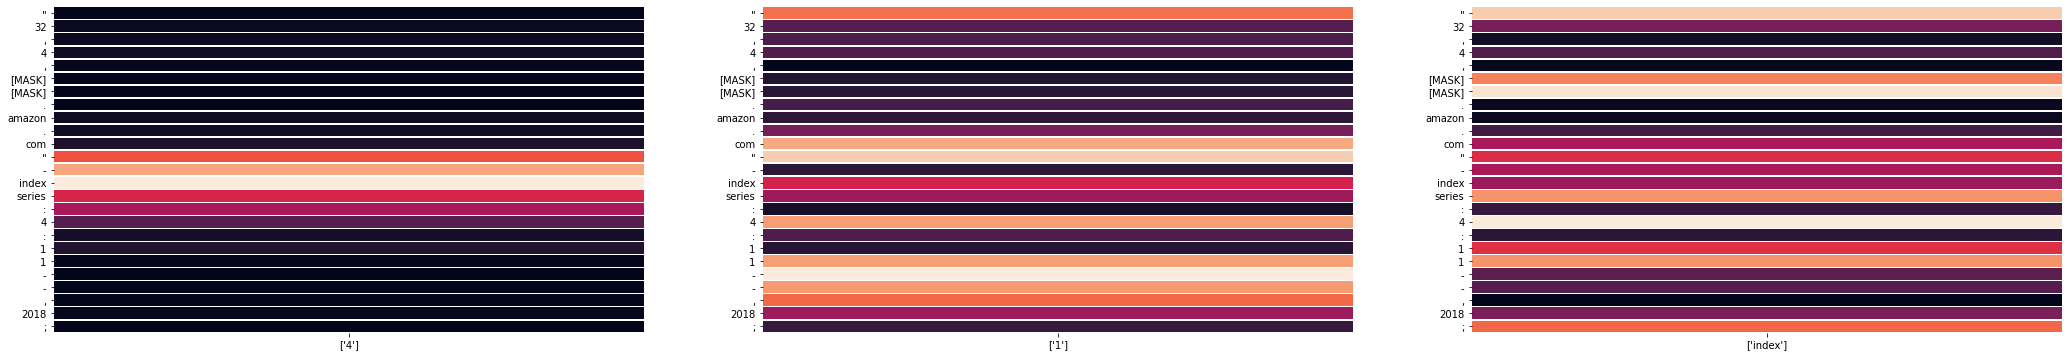


[ITERATION 42]
Current sentence: 	[CLS] " 32, 4, [MASK] [MASK]. amazon. com " - index series : 4 : 1 1 - -, 2018 ; [SEP]
Masked sentence: 	[CLS] " 32, [MASK], [MASK] [MASK]. amazon. com [MASK] - index series : 4 : 1 1 - -, 2018 ; [SEP]
Predictions: 	"sub 37 33"


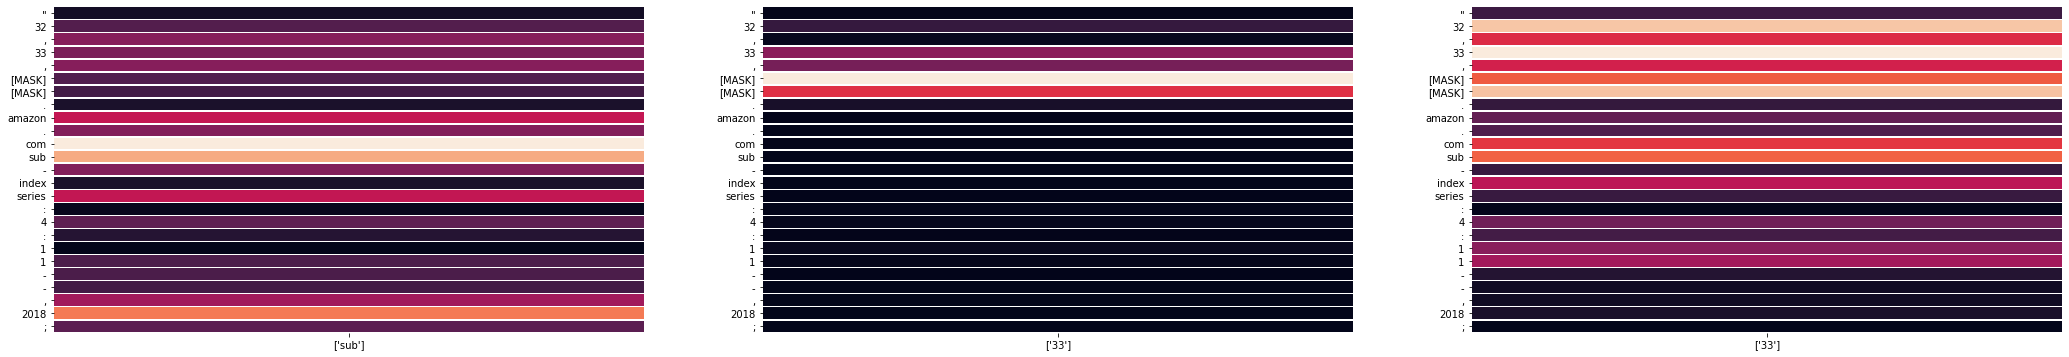


[ITERATION 43]
Current sentence: 	[CLS] " 32, 33, [MASK] [MASK]. amazon. com sub - index series : 4 : 1 1 - -, 2018 ; [SEP]
Masked sentence: 	[CLS] " [MASK], 33, [MASK] [MASK]. [MASK]. [MASK] sub - index series : 4 : 1 1 - -, 2018 ; [SEP]
Predictions: 	"" 1 ""


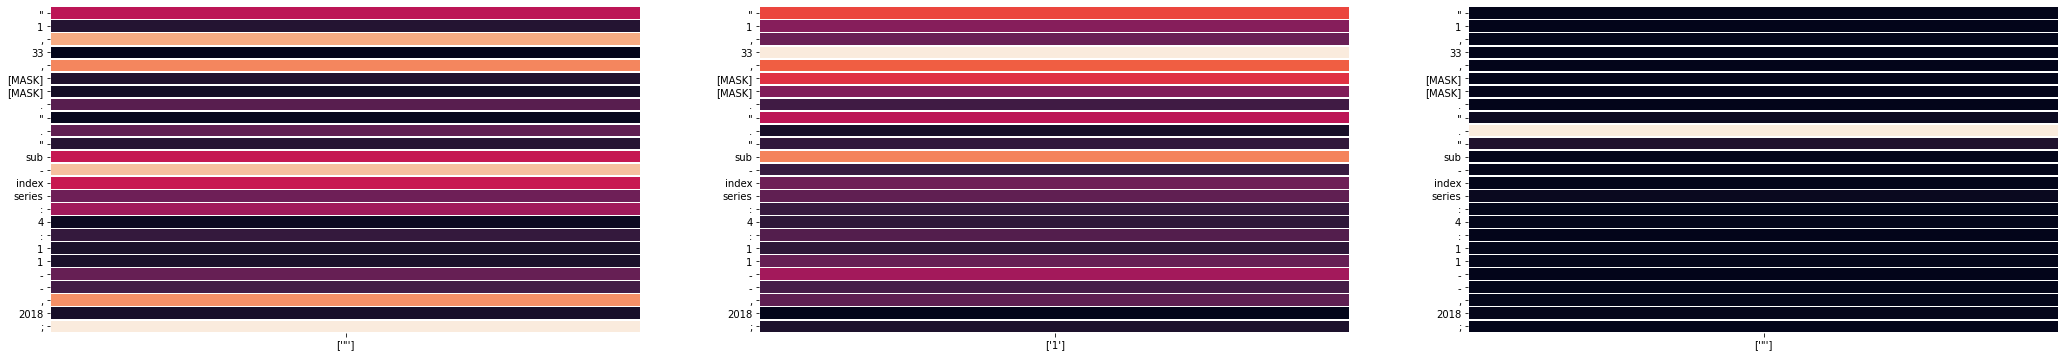


[ITERATION 44]
Current sentence: 	[CLS] " 1, 33, [MASK] [MASK]. ". " sub - index series : 4 : 1 1 - -, 2018 ; [SEP]
Masked sentence: 	[CLS] " 1, [MASK], [MASK] [MASK]. " [MASK] " sub - [MASK] series : 4 : 1 1 - -, 2018 ; [SEP]
Predictions: 	"- 000 timeline"


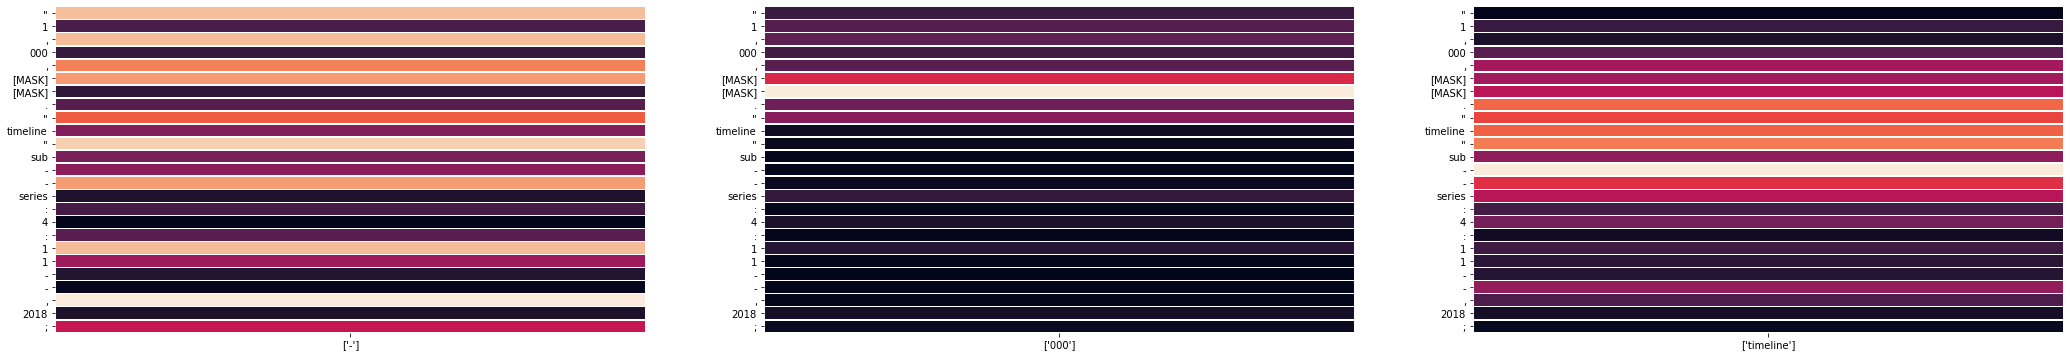


[ITERATION 45]
Current sentence: 	[CLS] " 1, 000, [MASK] [MASK]. " timeline " sub - - series : 4 : 1 1 - -, 2018 ; [SEP]
Masked sentence: 	[CLS] " [MASK], 000, [MASK] [MASK]. " timeline " sub - - series [MASK] [MASK] : 1 1 - -, 2018 ; [SEP]
Predictions: 	"- 1 ""


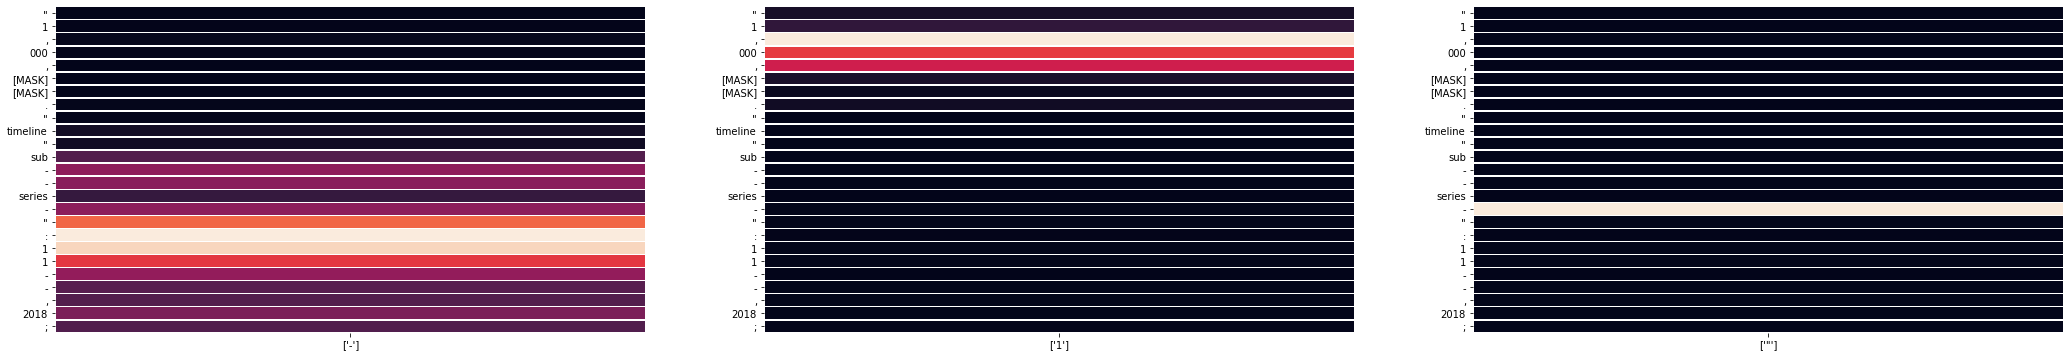


[ITERATION 46]
Current sentence: 	[CLS] " 1, 000, [MASK] [MASK]. " timeline " sub - - series - " : 1 1 - -, 2018 ; [SEP]
Masked sentence: 	[CLS] " 1, 000, [MASK] [MASK]. " timeline " sub - - series [MASK] " [MASK] 1 1 - -, 2018 ; [SEP]
Predictions: 	"# 000 20"


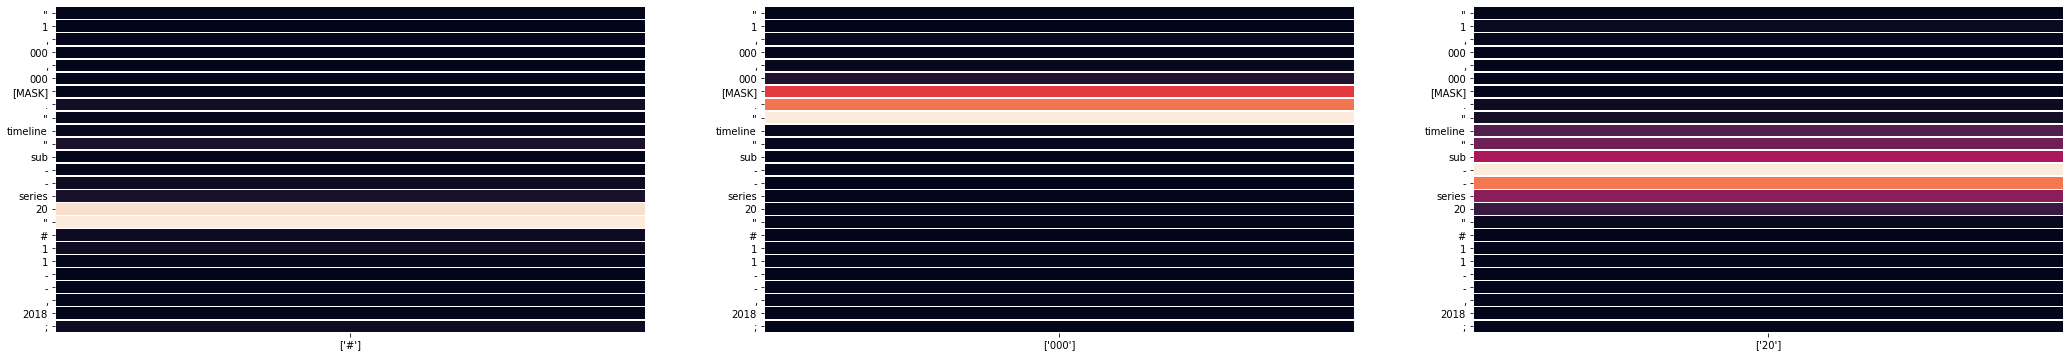


[ITERATION 47]
Current sentence: 	[CLS] " 1, 000, 000 [MASK]. " timeline " sub - - series 20 " # 1 1 - -, 2018 ; [SEP]
Masked sentence: 	[CLS] " 1, 000, 000 [MASK]. [MASK] timeline " sub - [MASK] series [MASK] " # 1 1 - -, 2018 ; [SEP]
Predictions: 	"tales " zero"


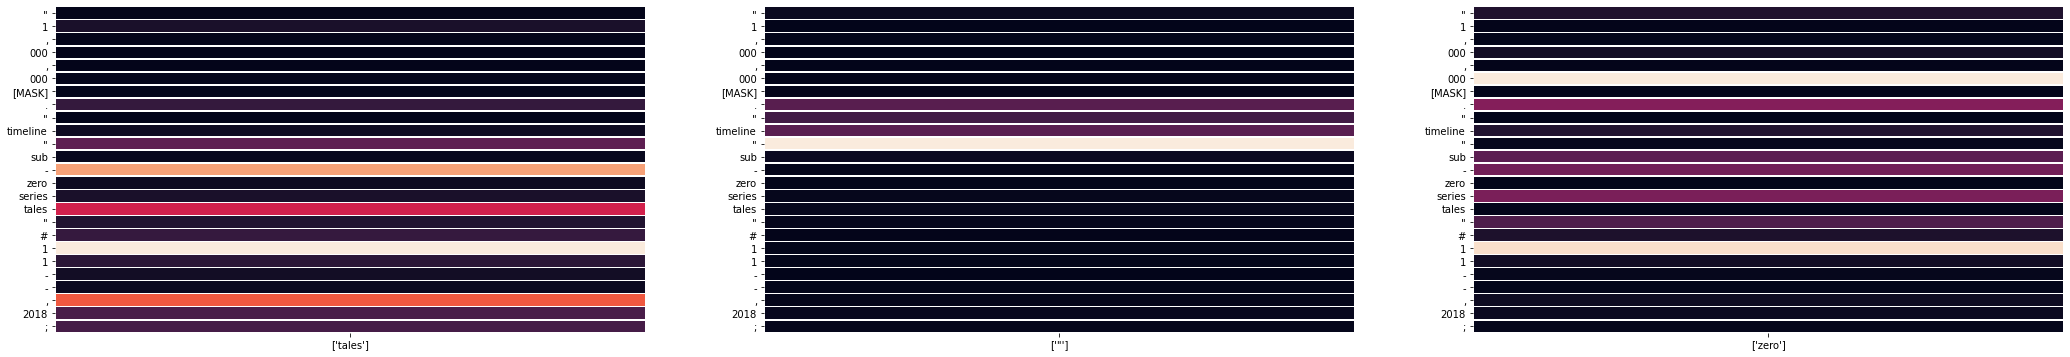


[ITERATION 48]
Current sentence: 	[CLS] " 1, 000, 000 [MASK]. " timeline " sub - zero series tales " # 1 1 - -, 2018 ; [SEP]
Masked sentence: 	[CLS] " 1, 000, 000 [MASK]. " timeline [MASK] [MASK] - zero series [MASK] " # 1 1 - -, 2018 ; [SEP]
Predictions: 	":. sub"


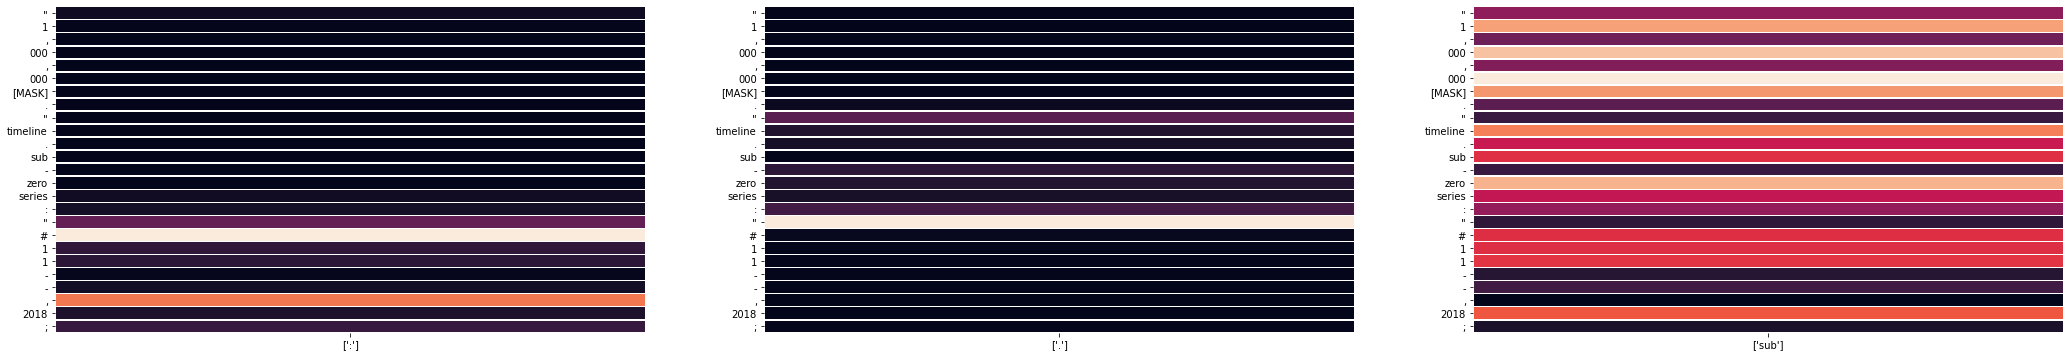


[ITERATION 49]
Current sentence: 	[CLS] " 1, 000, 000 [MASK]. " timeline. sub - zero series : " # 1 1 - -, 2018 ; [SEP]
Masked sentence: 	[CLS] " 1, [MASK], 000 [MASK] [MASK] " timeline. sub - zero series : " [MASK] 1 1 - -, 2018 ; [SEP]
Predictions: 	"zero years 000"


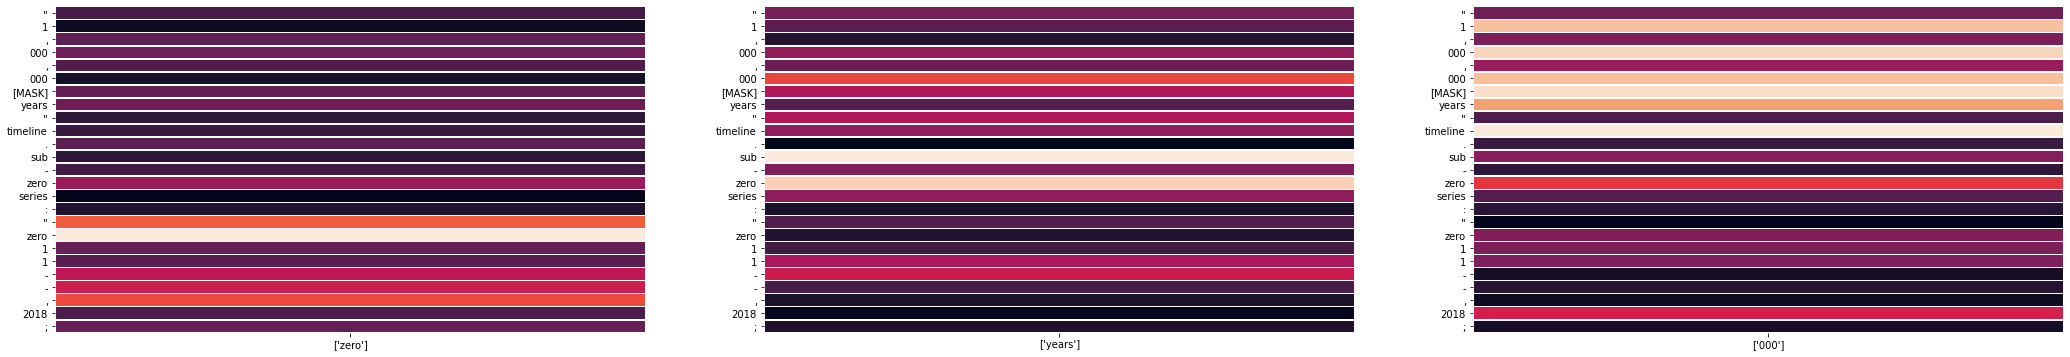


[ITERATION 50]
Current sentence: 	[CLS] " 1, 000, 000 [MASK] years " timeline. sub - zero series : " zero 1 1 - -, 2018 ; [SEP]
Masked sentence: 	[CLS] " 1, 000, 000 [MASK] years " [MASK]. sub - [MASK] series : " [MASK] 1 1 - -, 2018 ; [SEP]
Predictions: 	", 100 part"


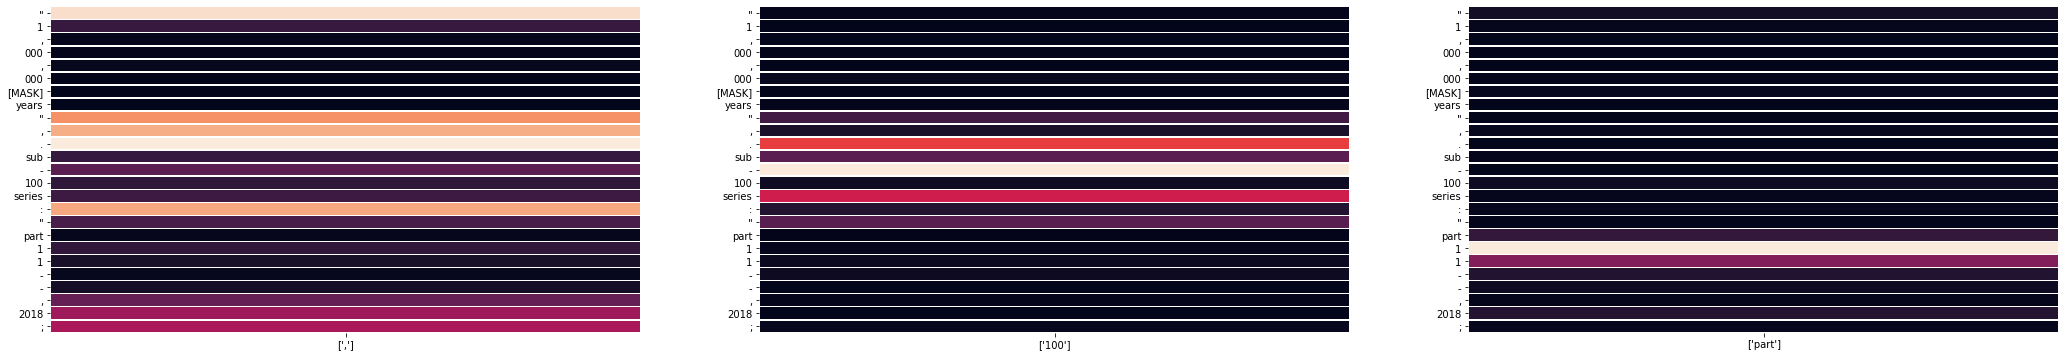


[ITERATION 51]
Current sentence: 	[CLS] " 1, 000, 000 [MASK] years ",. sub - 100 series : " part 1 1 - -, 2018 ; [SEP]
Masked sentence: 	[CLS] " 1, 000, 000 [MASK] years [MASK],. sub - 100 series [MASK] " part [MASK] 1 - -, 2018 ; [SEP]
Predictions: 	"ago. -"


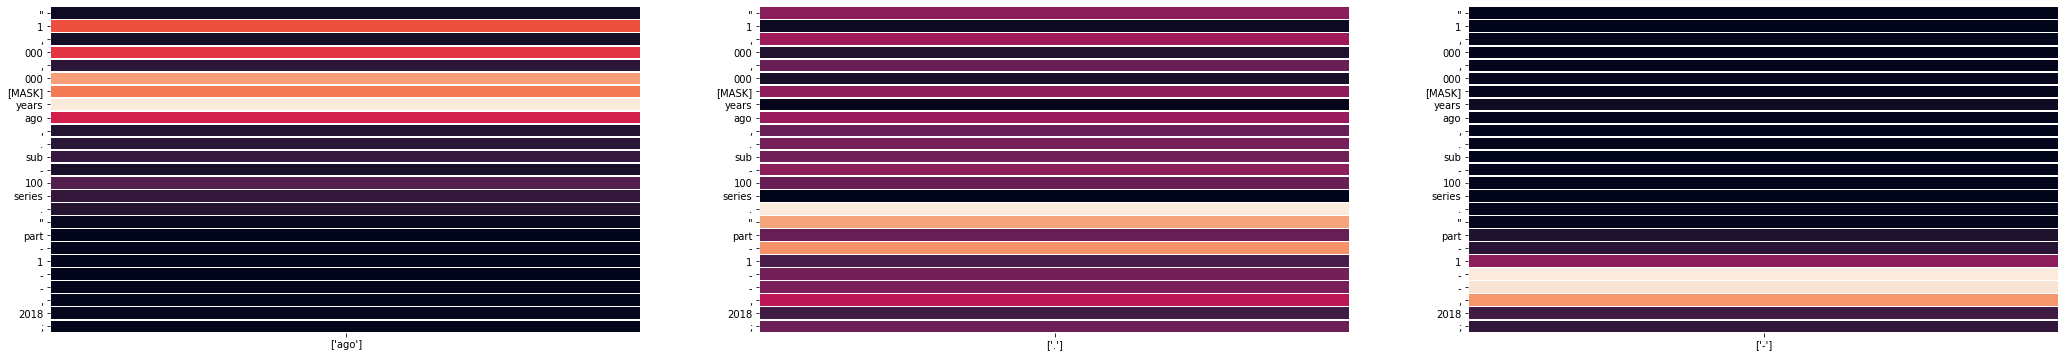


[ITERATION 52]
Current sentence: 	[CLS] " 1, 000, 000 [MASK] years ago,. sub - 100 series. " part - 1 - -, 2018 ; [SEP]
Masked sentence: 	[CLS] " 1, 000, [MASK] [MASK] years ago,. sub - 100 series [MASK] " part - 1 - -, 2018 [MASK] [SEP]
Predictions: 	"000, ;"


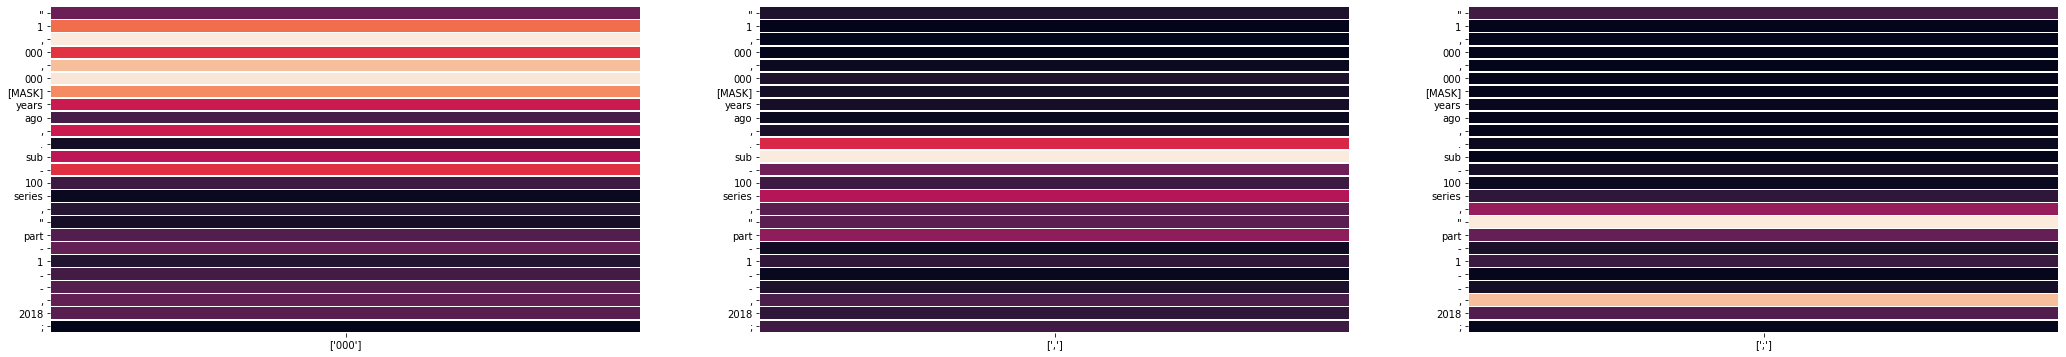


[ITERATION 53]
Current sentence: 	[CLS] " 1, 000, 000 [MASK] years ago,. sub - 100 series, " part - 1 - -, 2018 ; [SEP]
Masked sentence: 	[CLS] " 1, 000, 000 [MASK] years ago,. sub - 100 series [MASK] " [MASK] - [MASK] - -, 2018 ; [SEP]
Predictions: 	"- -."


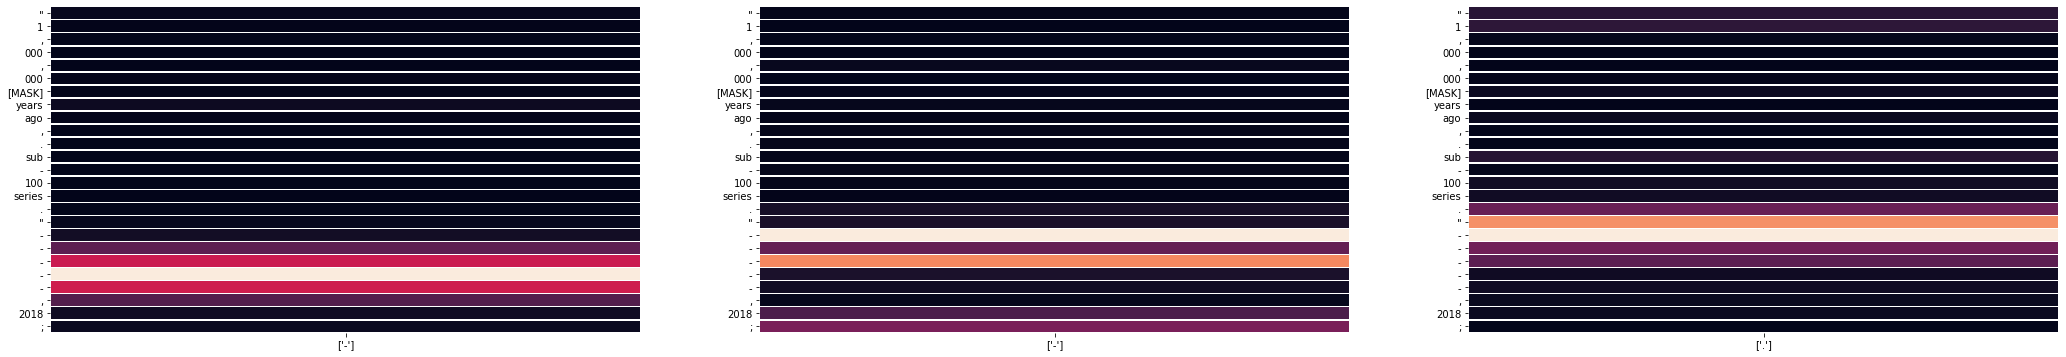


[ITERATION 54]
Current sentence: 	[CLS] " 1, 000, 000 [MASK] years ago,. sub - 100 series. " - - - - -, 2018 ; [SEP]
Masked sentence: 	[CLS] " 1, 000, 000 [MASK] years ago,. sub - 100 series. [MASK] - - - - [MASK], [MASK] ; [SEP]
Predictions: 	"suzuki peter ""


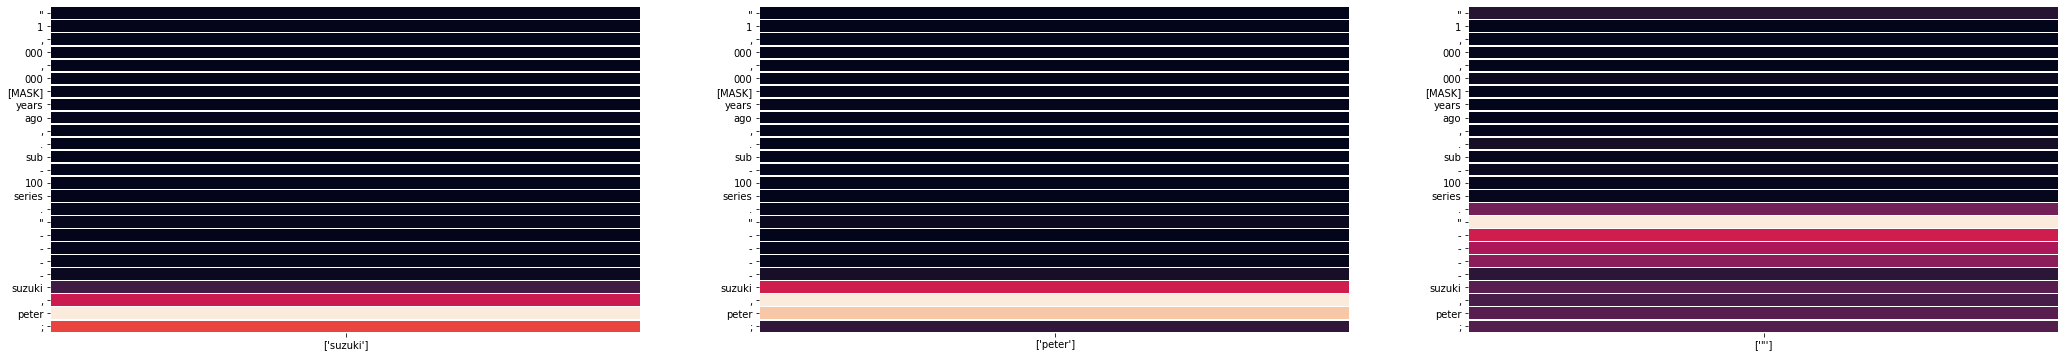


[ITERATION 55]
Current sentence: 	[CLS] " 1, 000, 000 [MASK] years ago,. sub - 100 series. " - - - - suzuki, peter ; [SEP]
Masked sentence: 	[CLS] " 1, 000, 000 [MASK] years ago,. sub - 100 series. [MASK] - - - - suzuki, [MASK] [MASK] [SEP]
Predictions: 	"; ken ""


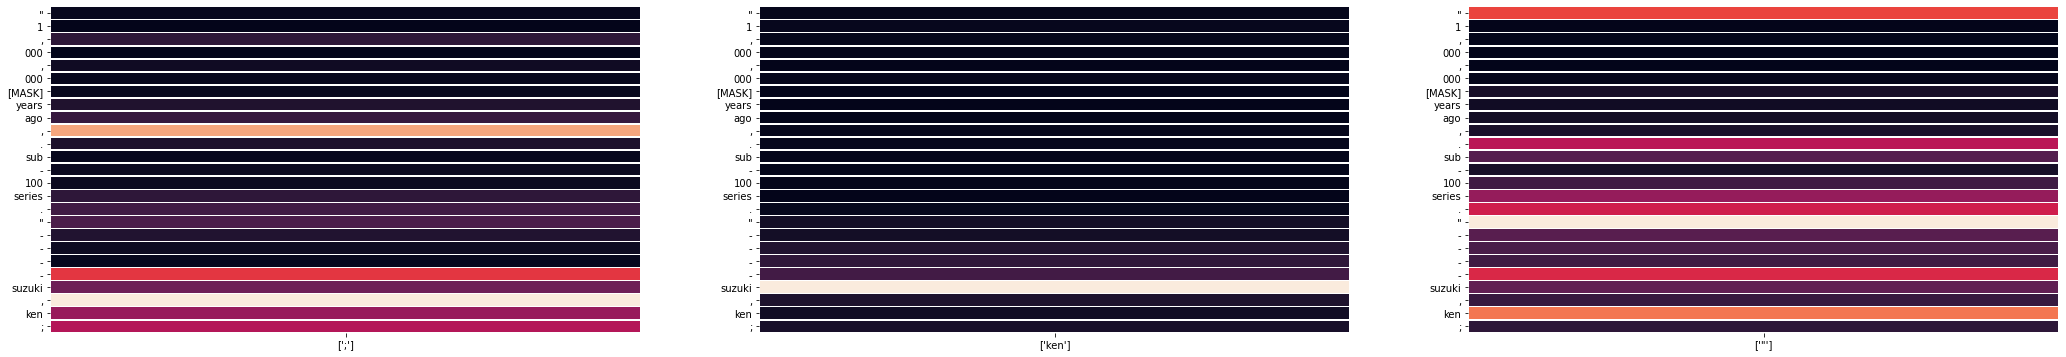


[ITERATION 56]
Current sentence: 	[CLS] " 1, 000, 000 [MASK] years ago,. sub - 100 series. " - - - - suzuki, ken ; [SEP]
Masked sentence: 	[CLS] " 1, 000, 000 [MASK] years ago, [MASK] sub - 100 series. " - - - - [MASK], [MASK] ; [SEP]
Predictions: 	"peter bennett the"


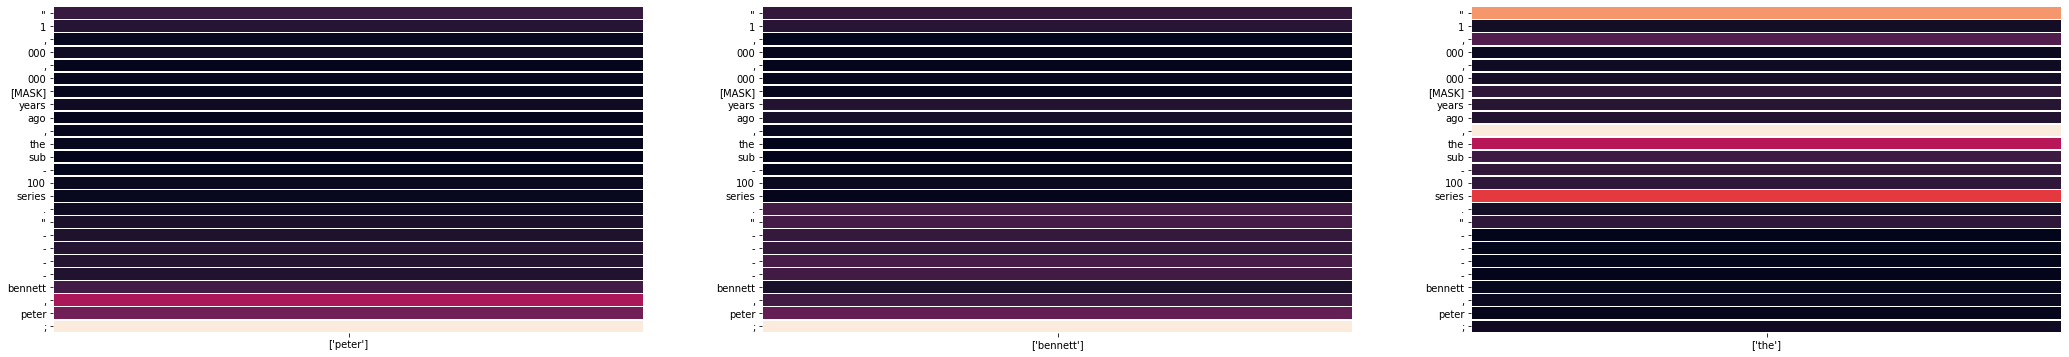


[ITERATION 57]
Current sentence: 	[CLS] " 1, 000, 000 [MASK] years ago, the sub - 100 series. " - - - - bennett, peter ; [SEP]
Masked sentence: 	[CLS] [MASK] 1, 000, 000 [MASK] years ago, the sub - 100 series. [MASK] [MASK] - - - bennett, peter ; [SEP]
Predictions: 	"" " almost"


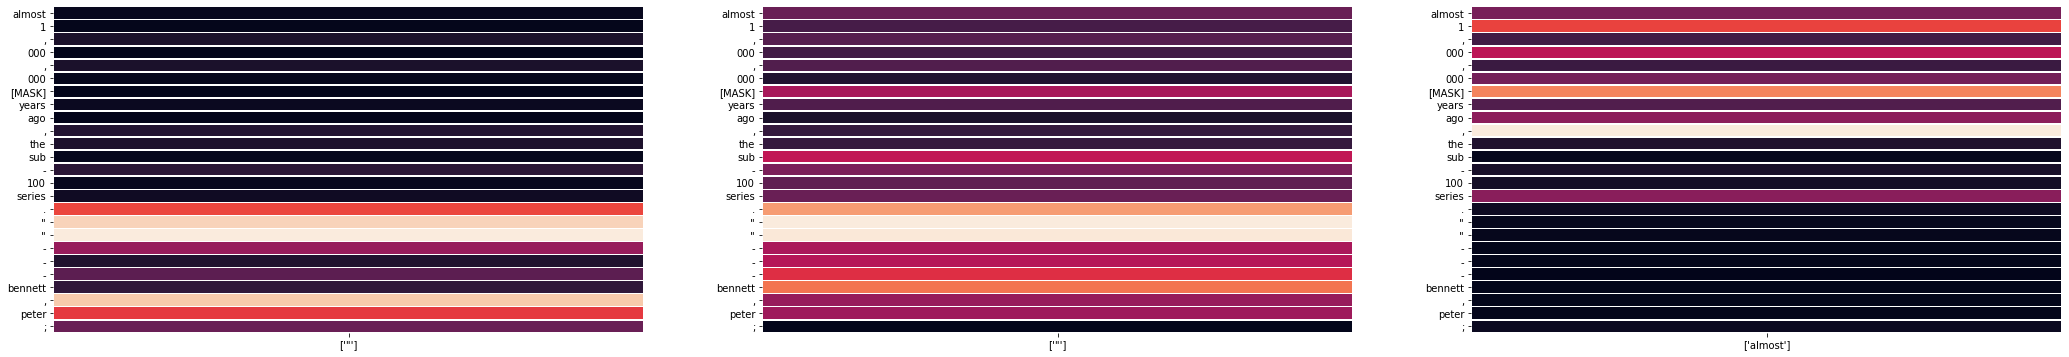


[ITERATION 58]
Current sentence: 	[CLS] almost 1, 000, 000 [MASK] years ago, the sub - 100 series. " " - - - bennett, peter ; [SEP]
Masked sentence: 	[CLS] almost 1, 000, 000 [MASK] years [MASK], the sub - 100 [MASK]. " " - - - bennett [MASK] peter ; [SEP]
Predictions: 	", million ago"


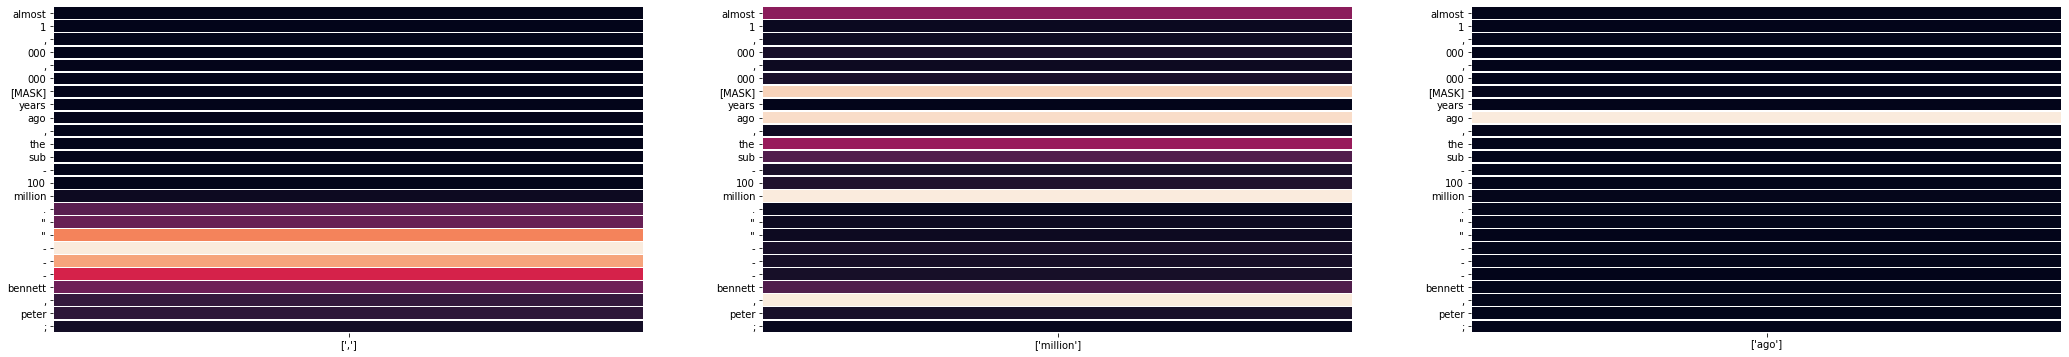


[ITERATION 59]
Current sentence: 	[CLS] almost 1, 000, 000 [MASK] years ago, the sub - 100 million. " " - - - bennett, peter ; [SEP]
Masked sentence: 	[CLS] almost 1, 000, 000 [MASK] years ago, the sub - 100 million [MASK] " " [MASK] - - bennett, peter ; [SEP]
Predictions: 	"" million bce"


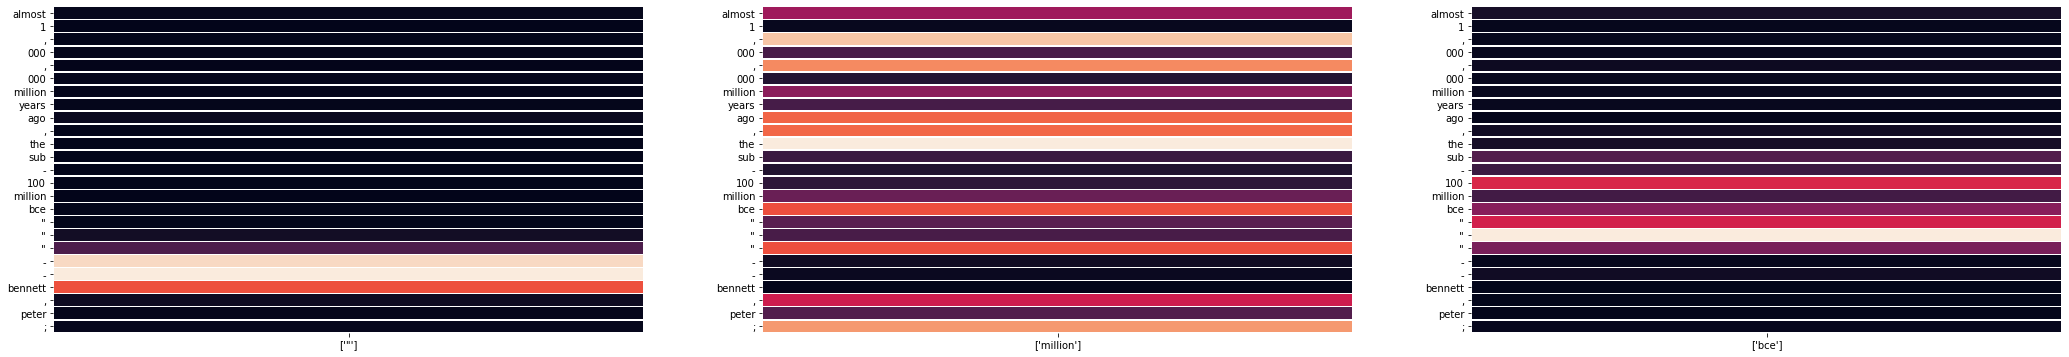


[ITERATION 60]
Current sentence: 	[CLS] almost 1, 000, 000 million years ago, the sub - 100 million bce " " " - - bennett, peter ; [SEP]
Masked sentence: 	[CLS] almost 1 [MASK] 000, 000 million years ago, the sub - [MASK] million bce " " " - [MASK] bennett, peter ; [SEP]
Predictions: 	"in, 330"


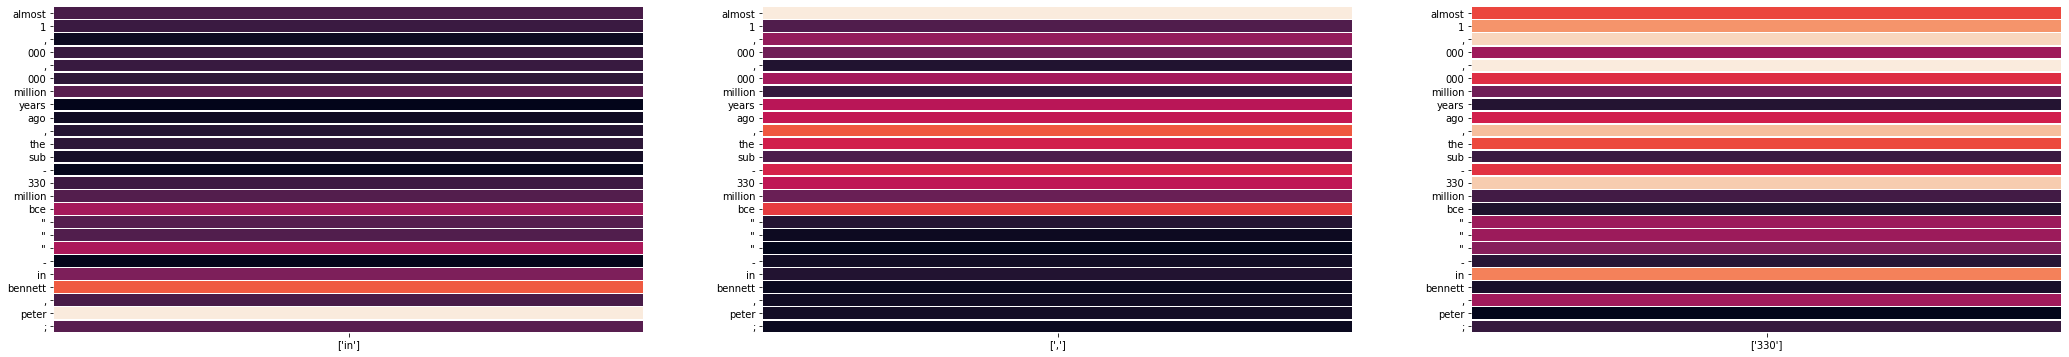


[ITERATION 61]
Current sentence: 	[CLS] almost 1, 000, 000 million years ago, the sub - 330 million bce " " " - in bennett, peter ; [SEP]
Masked sentence: 	[CLS] almost 1, 000, 000 million years ago [MASK] the sub [MASK] 330 million bce " [MASK] " - in bennett, peter ; [SEP]
Predictions: 	"given - age"


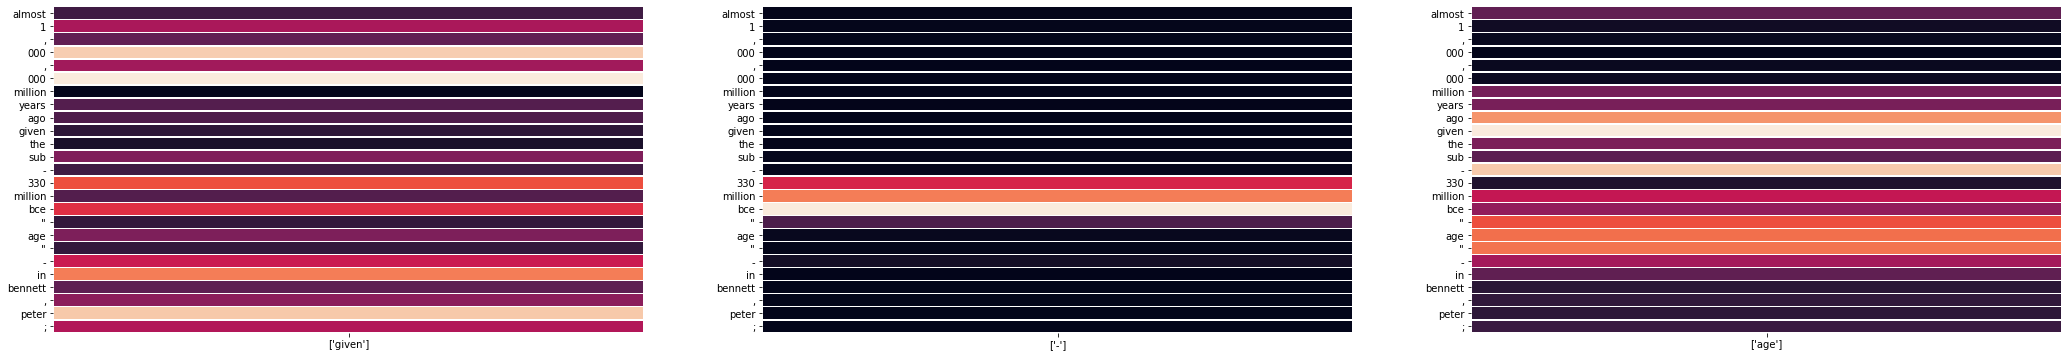


[ITERATION 62]
Current sentence: 	[CLS] almost 1, 000, 000 million years ago given the sub - 330 million bce " age " - in bennett, peter ; [SEP]
Masked sentence: 	[CLS] almost 1, 000, 000 million years ago given the sub - [MASK] million [MASK] " age " [MASK] in bennett, peter ; [SEP]
Predictions: 	"year 17."


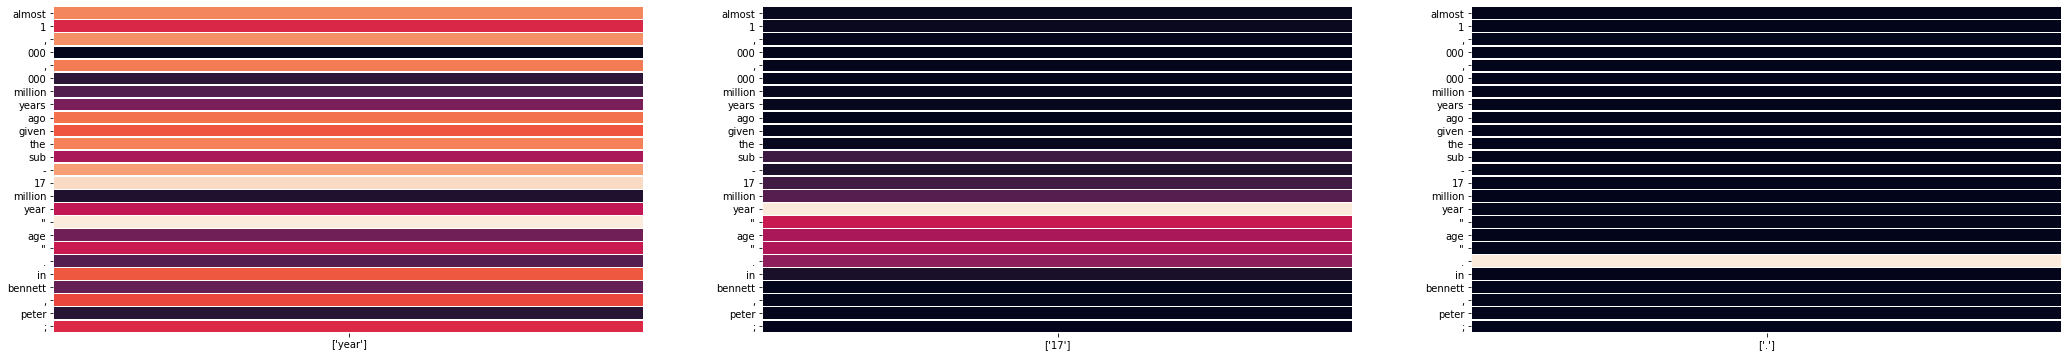


[ITERATION 63]
Current sentence: 	[CLS] almost 1, 000, 000 million years ago given the sub - 17 million year " age ". in bennett, peter ; [SEP]
Masked sentence: 	[CLS] almost 1, 000, 000 million years ago given [MASK] sub - 17 million [MASK] " age " [MASK] in bennett, peter ; [SEP]
Predictions: 	"the year published"


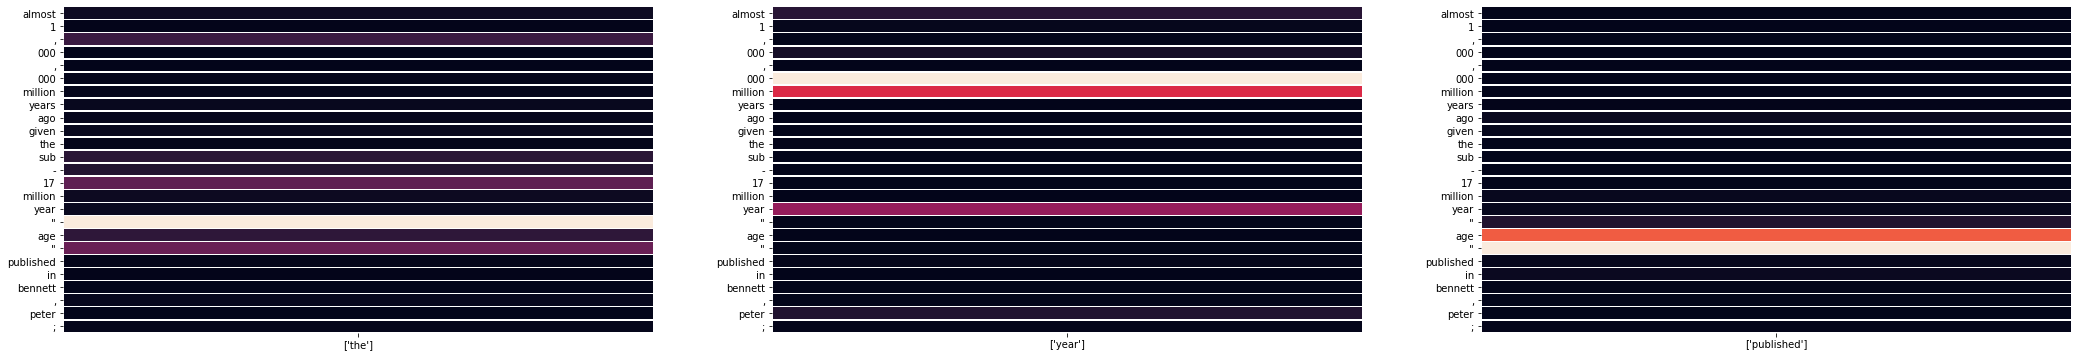


[ITERATION 64]
Current sentence: 	[CLS] almost 1, 000, 000 million years ago given the sub - 17 million year " age " published in bennett, peter ; [SEP]
Masked sentence: 	[CLS] almost 1, 000, [MASK] million years ago given the sub - 17 million year " age [MASK] published in bennett, peter [MASK] [SEP]
Predictions: 	". 000 ""


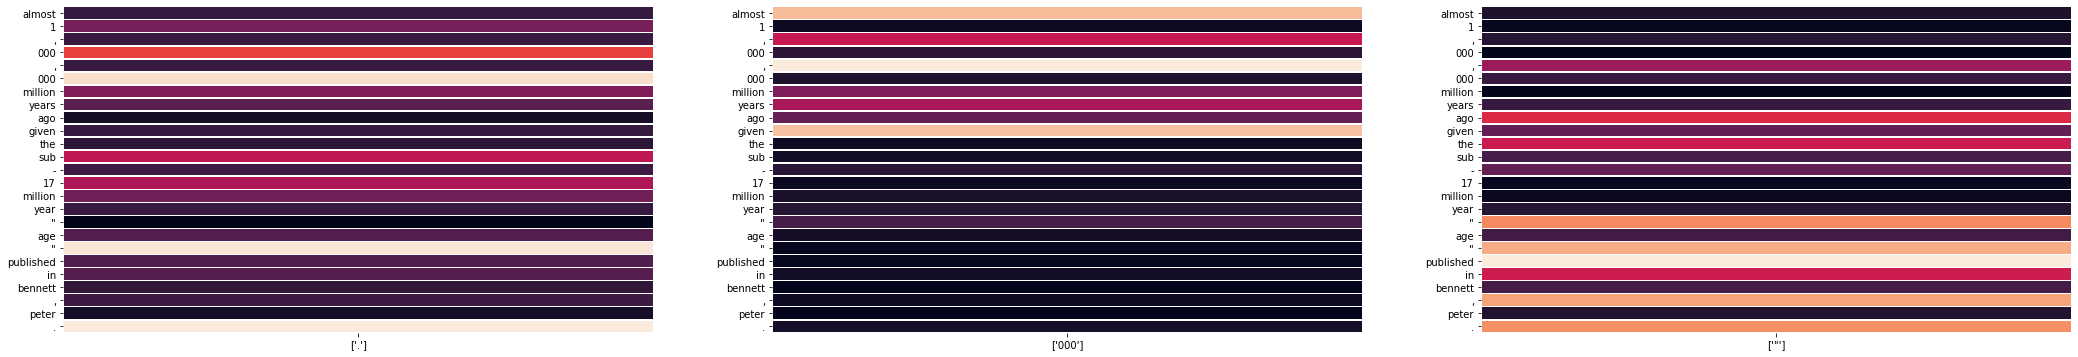


[ITERATION 65]
Current sentence: 	[CLS] almost 1, 000, 000 million years ago given the sub - 17 million year " age " published in bennett, peter. [SEP]
Masked sentence: 	[CLS] almost 1, 000, 000 [MASK] years ago given the sub - 17 million [MASK] [MASK] age " published in bennett, peter. [SEP]
Predictions: 	"year million year"


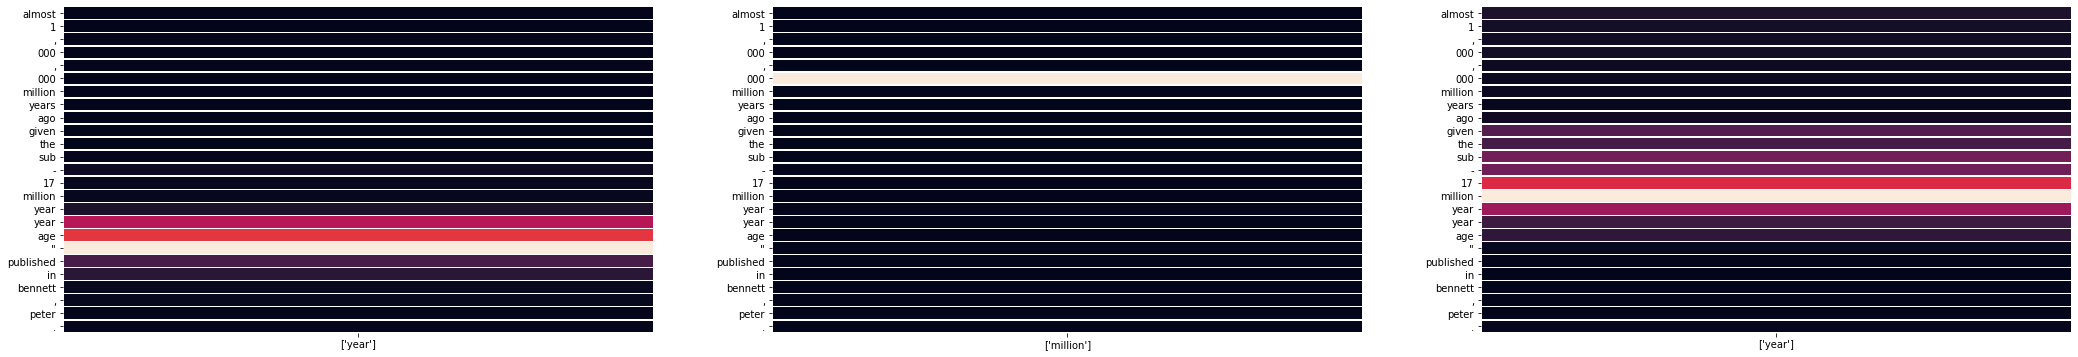


[ITERATION 66]
Current sentence: 	[CLS] almost 1, 000, 000 million years ago given the sub - 17 million year year age " published in bennett, peter. [SEP]
Masked sentence: 	[CLS] almost 1, 000, [MASK] million years ago given the sub - 17 million [MASK] [MASK] age " published in bennett, peter. [SEP]
Predictions: 	"year 000 year"


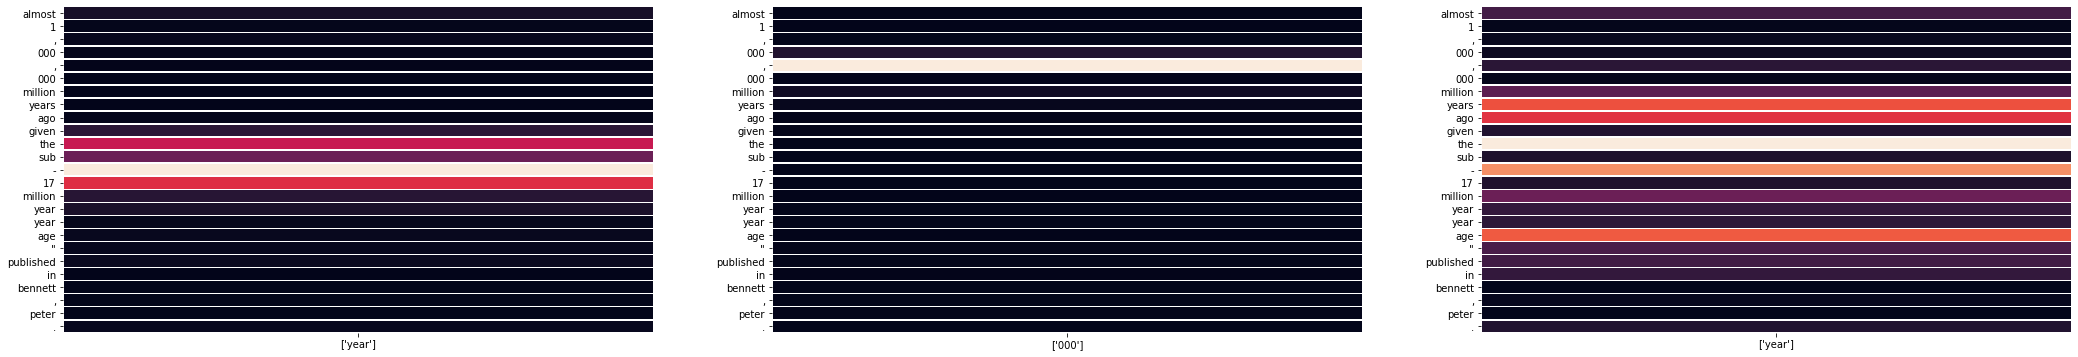


[ITERATION 67]
Current sentence: 	[CLS] almost 1, 000, 000 million years ago given the sub - 17 million year year age " published in bennett, peter. [SEP]
Masked sentence: 	[CLS] almost 1, 000 [MASK] 000 million [MASK] ago given [MASK] sub - 17 million year year age " published in bennett, peter. [SEP]
Predictions: 	"", years"


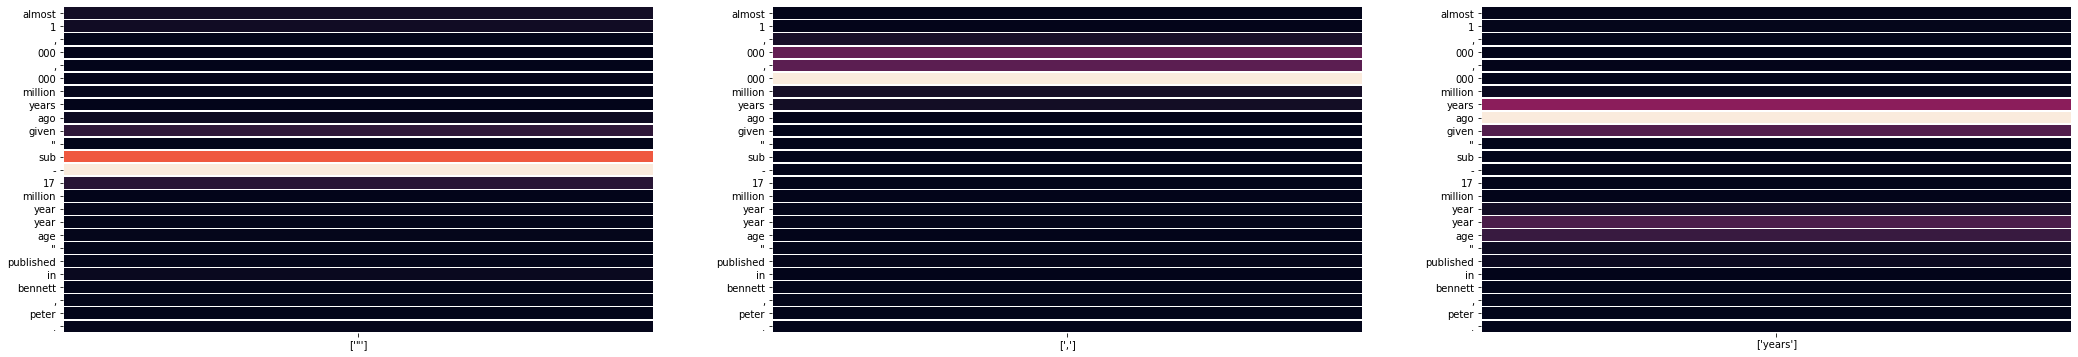


[ITERATION 68]
Current sentence: 	[CLS] almost 1, 000, 000 million years ago given " sub - 17 million year year age " published in bennett, peter. [SEP]
Masked sentence: 	[CLS] almost 1, 000 [MASK] 000 million years ago [MASK] " sub [MASK] 17 million year year age " published in bennett, peter. [SEP]
Predictions: 	"-,."


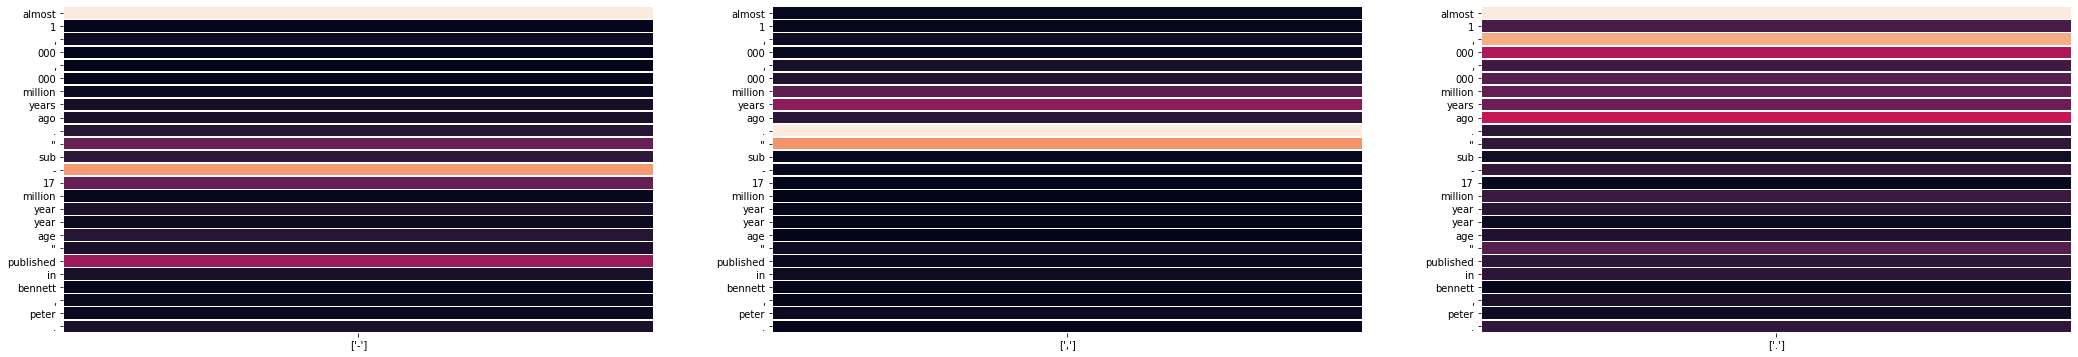


[ITERATION 69]
Current sentence: 	[CLS] almost 1, 000, 000 million years ago. " sub - 17 million year year age " published in bennett, peter. [SEP]
Masked sentence: 	[CLS] [MASK] 1, 000, 000 million [MASK] ago. " sub - [MASK] million year year age " published in bennett, peter. [SEP]
Predictions: 	"1 years about"


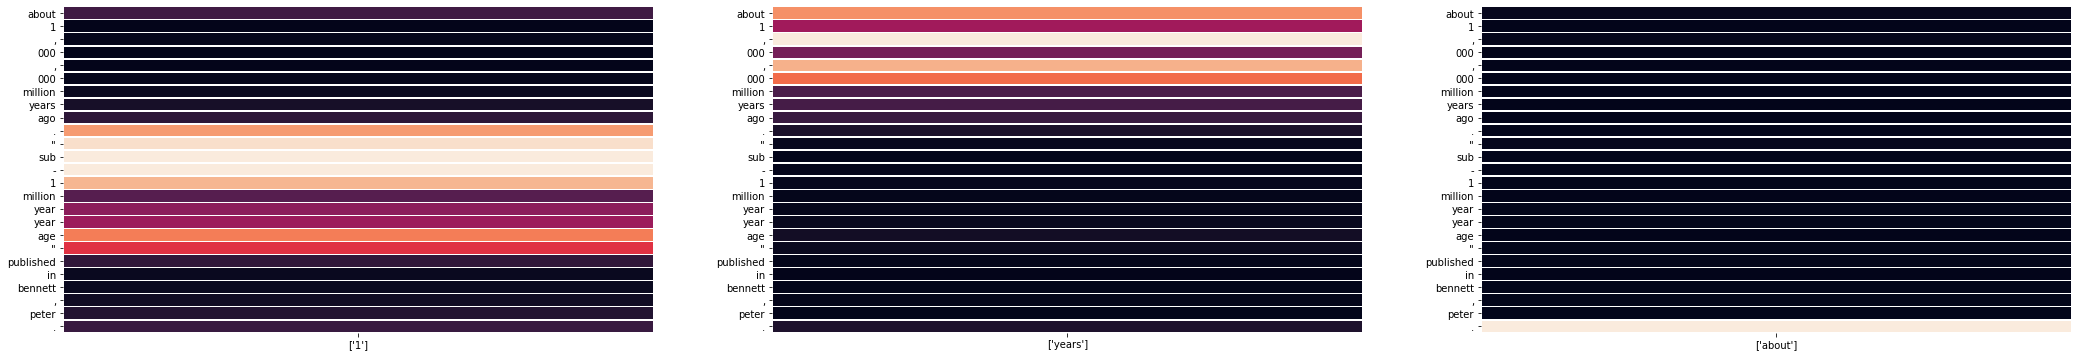


[ITERATION 70]
Current sentence: 	[CLS] about 1, 000, 000 million years ago. " sub - 1 million year year age " published in bennett, peter. [SEP]
Masked sentence: 	[CLS] about 1, 000 [MASK] 000 million years ago. " [MASK] - 1 million year year age " published in bennett, peter [MASK] [SEP]
Predictions: 	"100,."


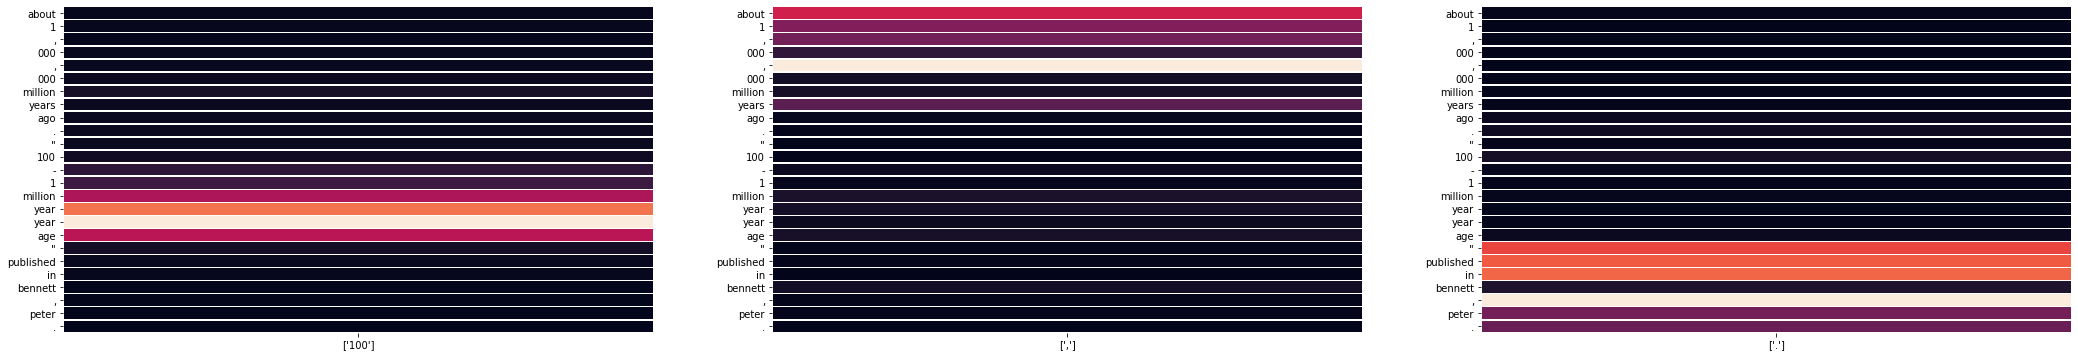


[ITERATION 71]
Current sentence: 	[CLS] about 1, 000, 000 million years ago. " 100 - 1 million year year age " published in bennett, peter. [SEP]
Masked sentence: 	[CLS] [MASK] 1, 000, 000 million years ago. " 100 - 1 million [MASK] year age " published in bennett [MASK] peter. [SEP]
Predictions: 	"- around,"


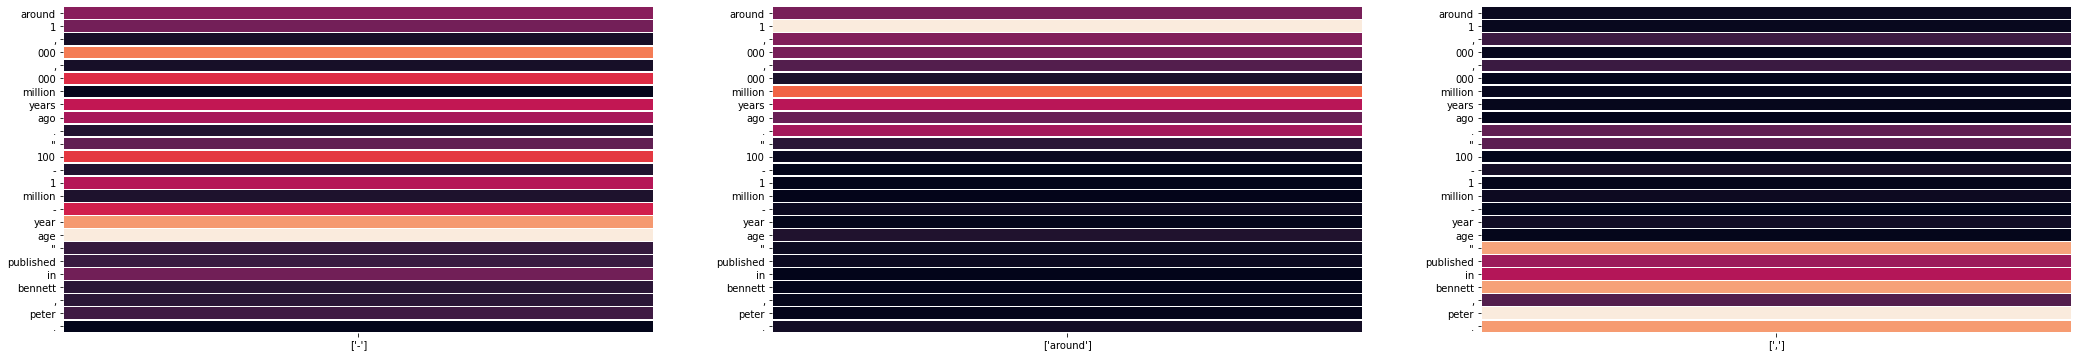


[ITERATION 72]
Current sentence: 	[CLS] around 1, 000, 000 million years ago. " 100 - 1 million - year age " published in bennett, peter. [SEP]
Masked sentence: 	[CLS] around 1, 000, 000 million years ago [MASK] " 100 - 1 million - year age [MASK] published in bennett [MASK] peter. [SEP]
Predictions: 	",. ""


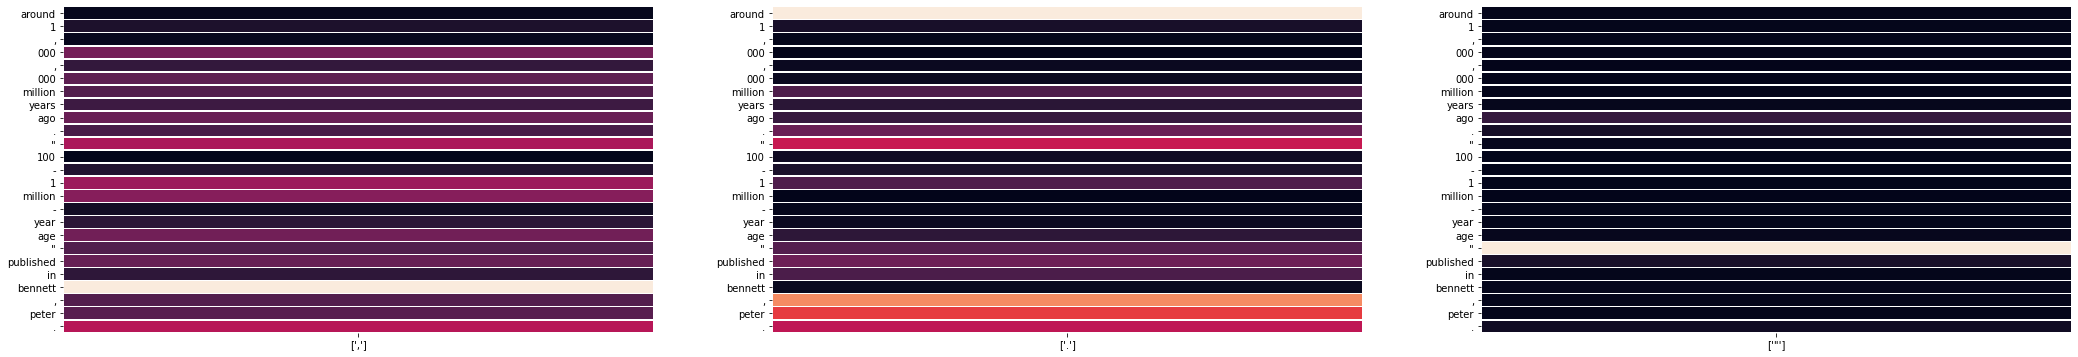


[ITERATION 73]
Current sentence: 	[CLS] around 1, 000, 000 million years ago. " 100 - 1 million - year age " published in bennett, peter. [SEP]
Masked sentence: 	[CLS] around 1, 000, 000 million years ago. " 100 - 1 million - year age [MASK] published in [MASK], peter. [SEP]
Predictions: 	"cooper " ""


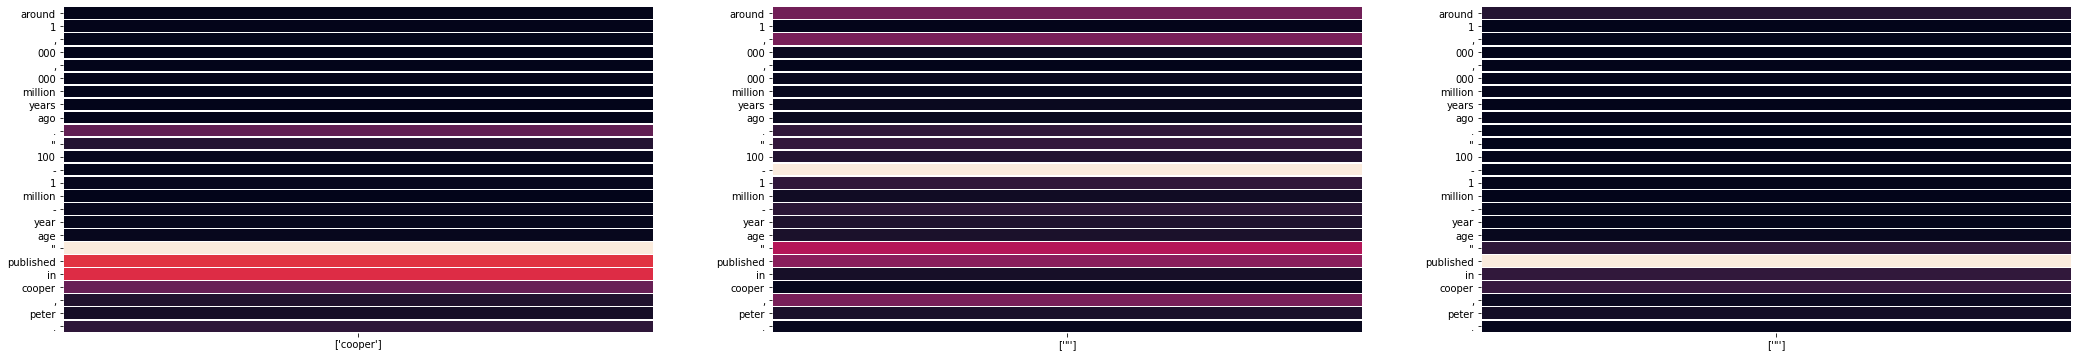


[ITERATION 74]
Current sentence: 	[CLS] around 1, 000, 000 million years ago. " 100 - 1 million - year age " published in cooper, peter. [SEP]
Masked sentence: 	[CLS] around 1, 000, 000 million years ago. " 100 [MASK] 1 million - year age " [MASK] in [MASK], peter. [SEP]
Predictions: 	"barnes.."


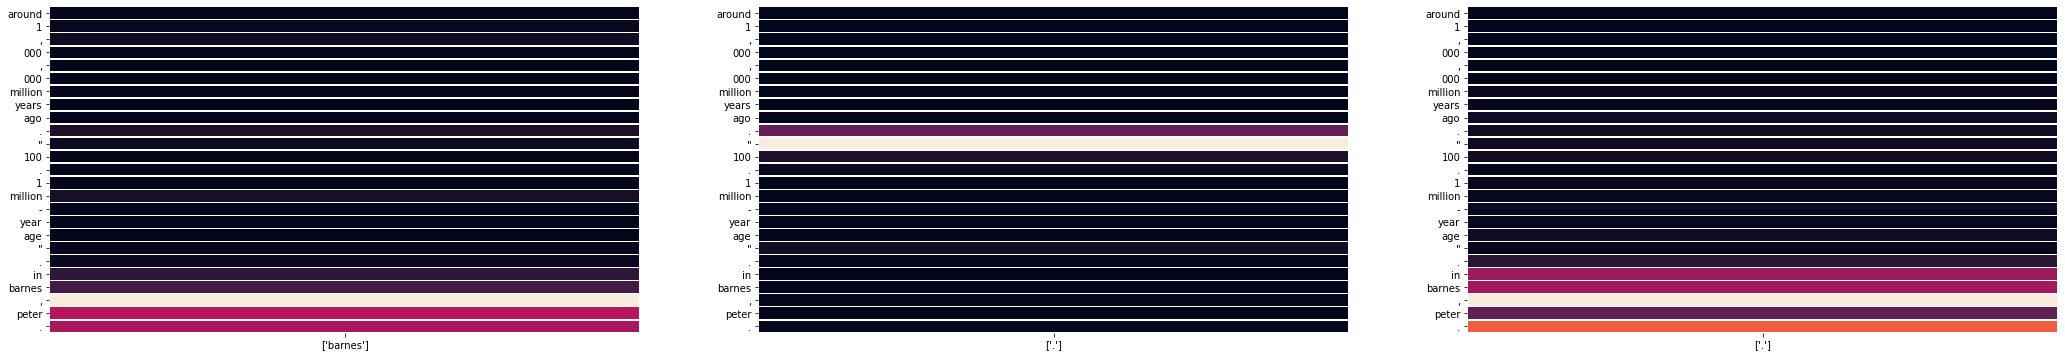


[ITERATION 75]
Current sentence: 	[CLS] around 1, 000, 000 million years ago. " 100. 1 million - year age ". in barnes, peter. [SEP]
Masked sentence: 	[CLS] around 1, 000, 000 million years ago. " 100. 1 million - [MASK] age ". in barnes [MASK] peter [MASK] [SEP]
Predictions: 	". year,"


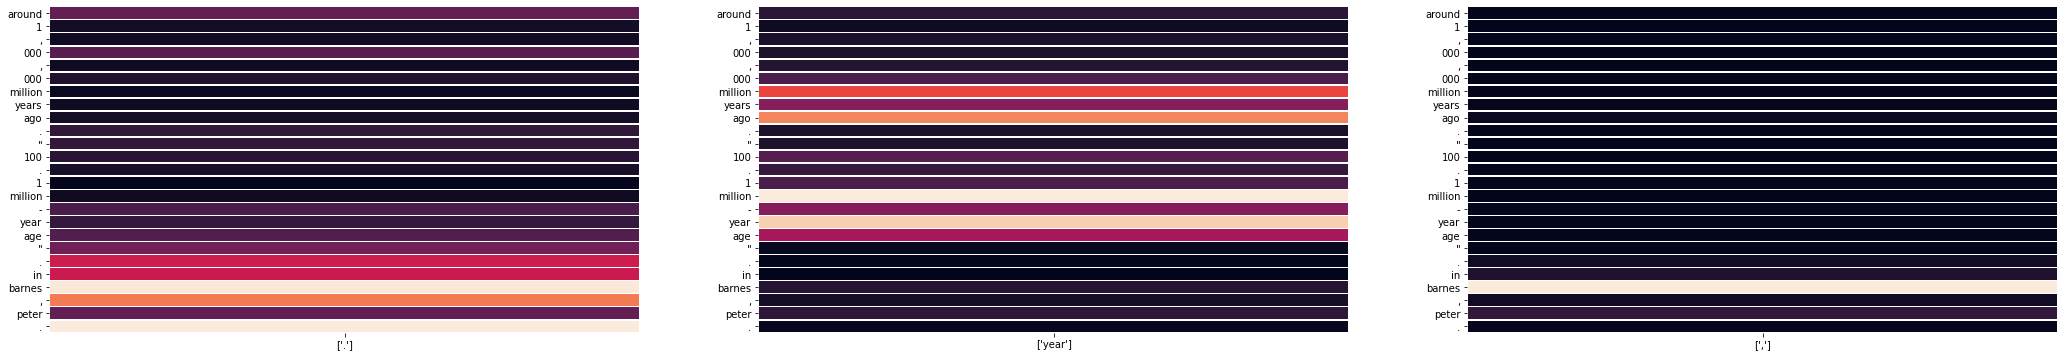


[ITERATION 76]
Current sentence: 	[CLS] around 1, 000, 000 million years ago. " 100. 1 million - year age ". in barnes, peter. [SEP]
Masked sentence: 	[CLS] around 1, 000, 000 million years ago. " 100. 1 million - year [MASK] " [MASK] [MASK] barnes, peter. [SEP]
Predictions: 	". period."


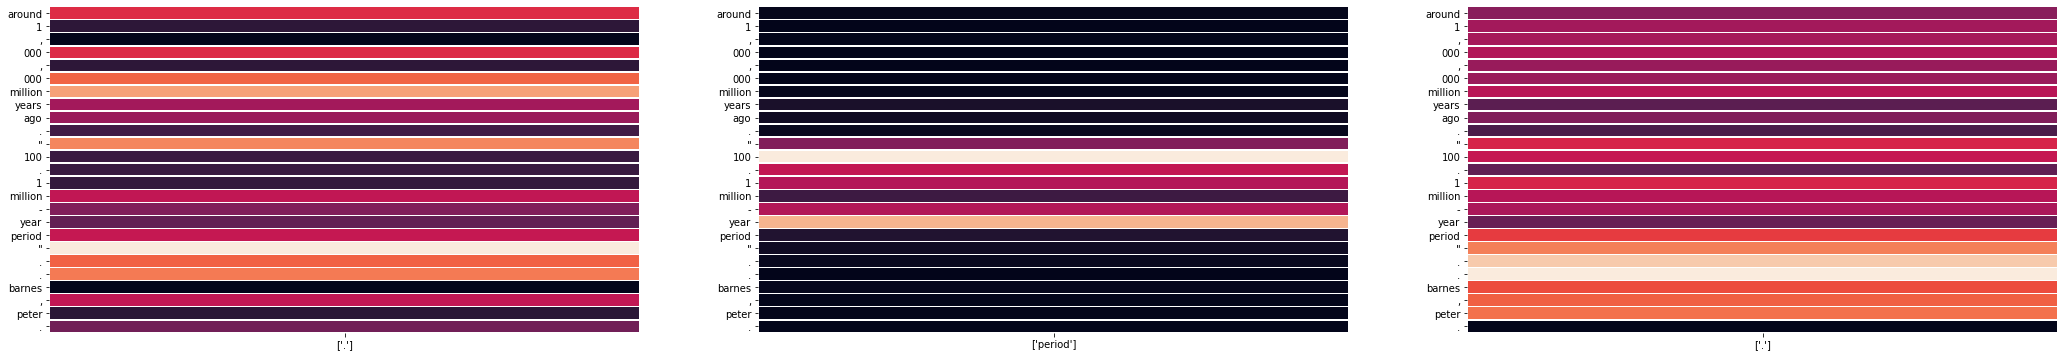


[ITERATION 77]
Current sentence: 	[CLS] around 1, 000, 000 million years ago. " 100. 1 million - year period ".. barnes, peter. [SEP]
Masked sentence: 	[CLS] around 1, 000, 000 million years ago. [MASK] 100 [MASK] 1 million - year period ". [MASK] barnes, peter. [SEP]
Predictions: 	"in. ""


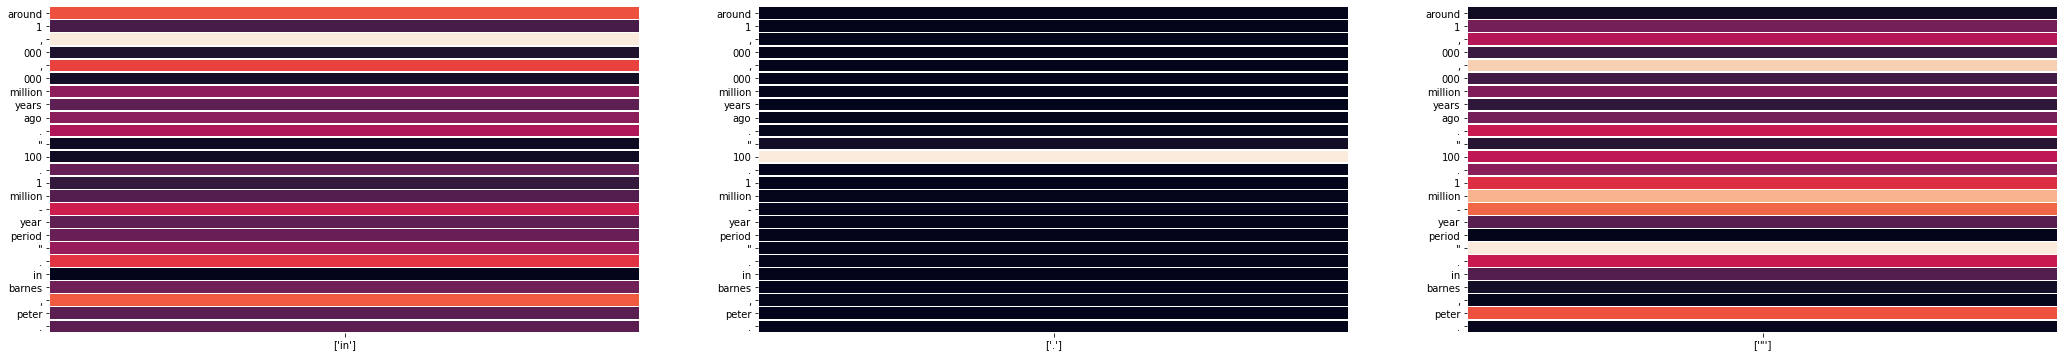


[ITERATION 78]
Current sentence: 	[CLS] around 1, 000, 000 million years ago. " 100. 1 million - year period ". in barnes, peter. [SEP]
Masked sentence: 	[CLS] around 1, 000, [MASK] million years [MASK]. " [MASK]. 1 million - year period ". in barnes, peter. [SEP]
Predictions: 	"ago 43 000"


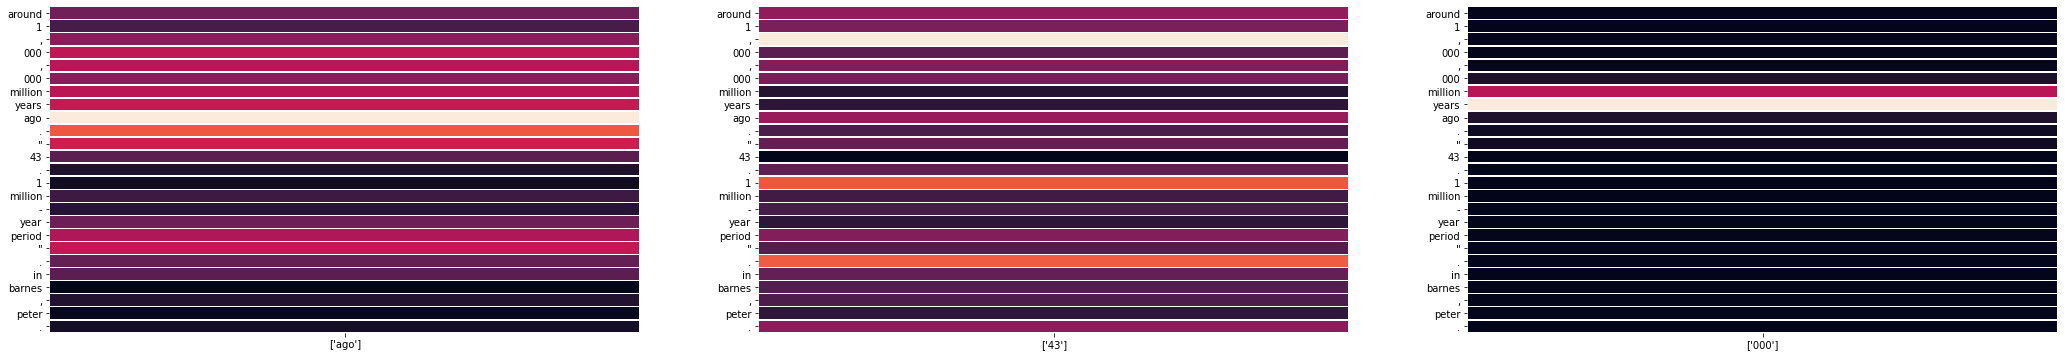


[ITERATION 79]
Current sentence: 	[CLS] around 1, 000, 000 million years ago. " 43. 1 million - year period ". in barnes, peter. [SEP]
Masked sentence: 	[CLS] [MASK] 1, 000, 000 million years [MASK]. " 43. 1 million - year period ". in barnes, peter. [SEP]
Predictions: 	"" " ""


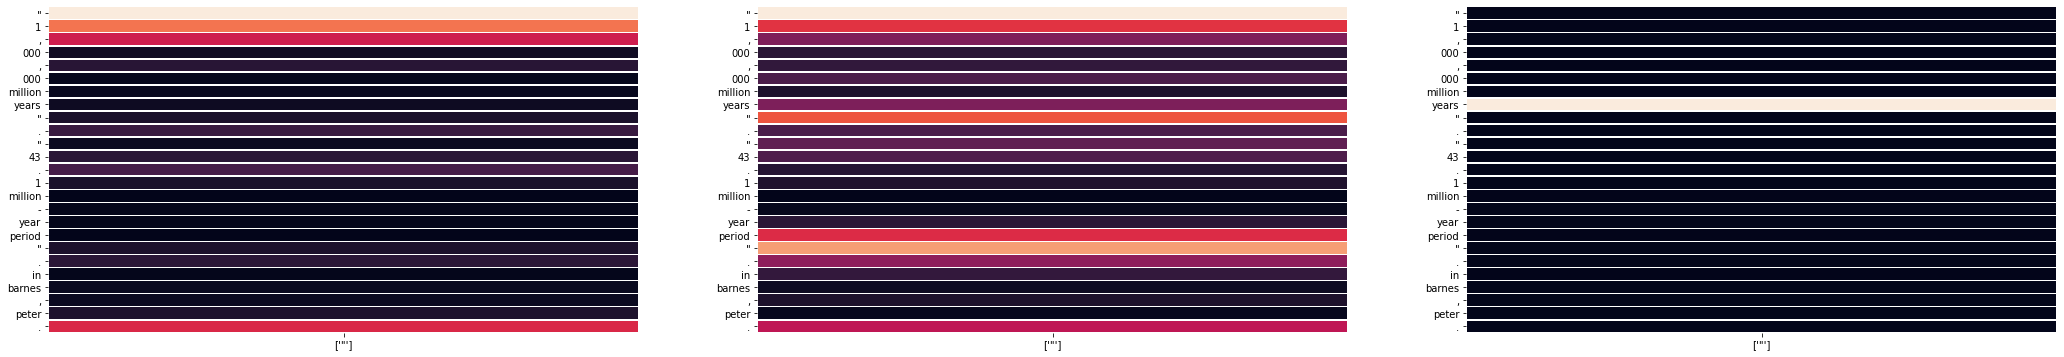


[ITERATION 80]
Current sentence: 	[CLS] " 1, 000, 000 million years ". " 43. 1 million - year period ". in barnes, peter. [SEP]
Masked sentence: 	[CLS] " [MASK], 000, 000 million [MASK] ". [MASK] 43. 1 million - year period ". in barnes, peter. [SEP]
Predictions: 	"30 " years"


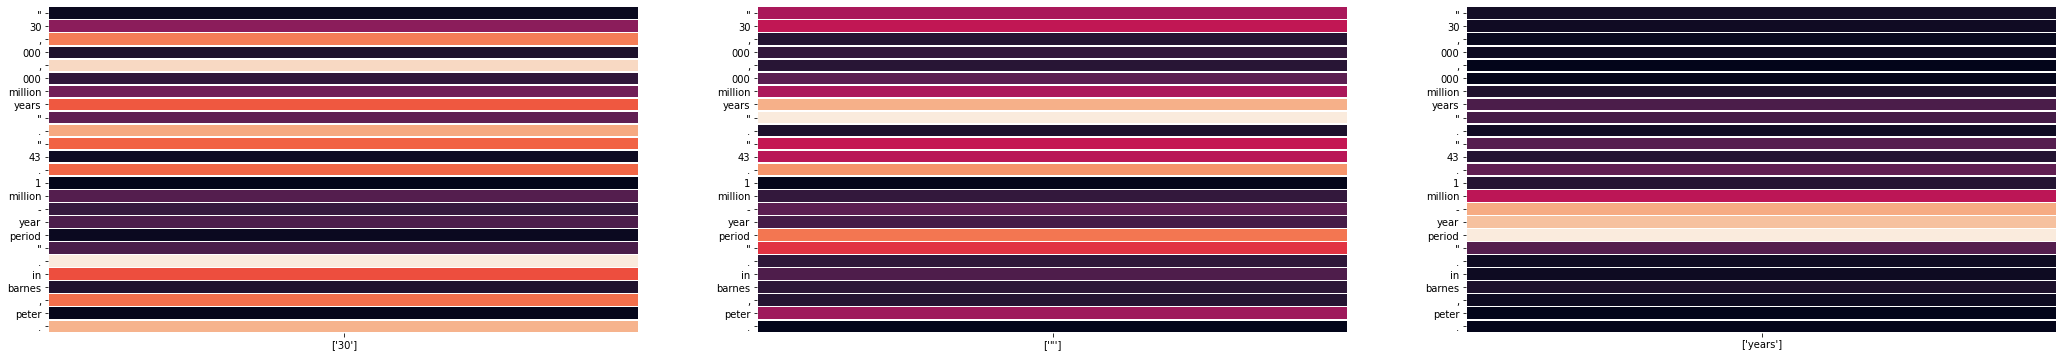


[ITERATION 81]
Current sentence: 	[CLS] " 30, 000, 000 million years ". " 43. 1 million - year period ". in barnes, peter. [SEP]
Masked sentence: 	[CLS] " 30, 000, 000 million [MASK] ". " 43. 1 million - year [MASK] [MASK]. in barnes, peter. [SEP]
Predictions: 	"years " extension"


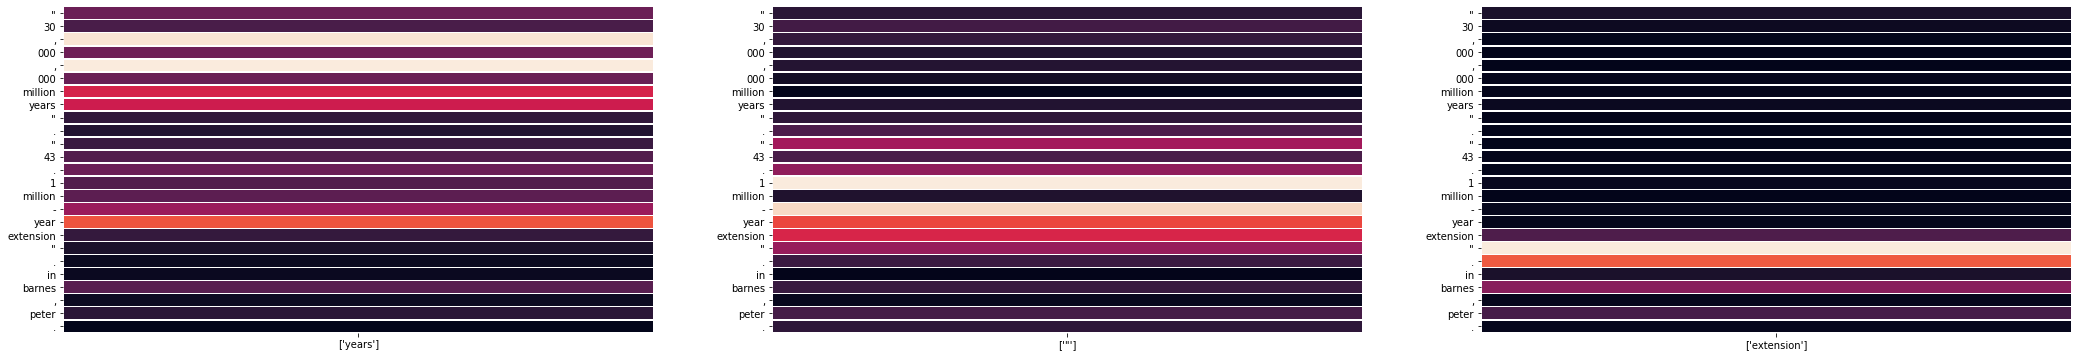


[ITERATION 82]
Current sentence: 	[CLS] " 30, 000, 000 million years ". " 43. 1 million - year extension ". in barnes, peter. [SEP]
Masked sentence: 	[CLS] " 30, 000 [MASK] 000 million years ". " 43 [MASK] 1 million - year extension " [MASK] in barnes, peter. [SEP]
Predictions: 	",.."


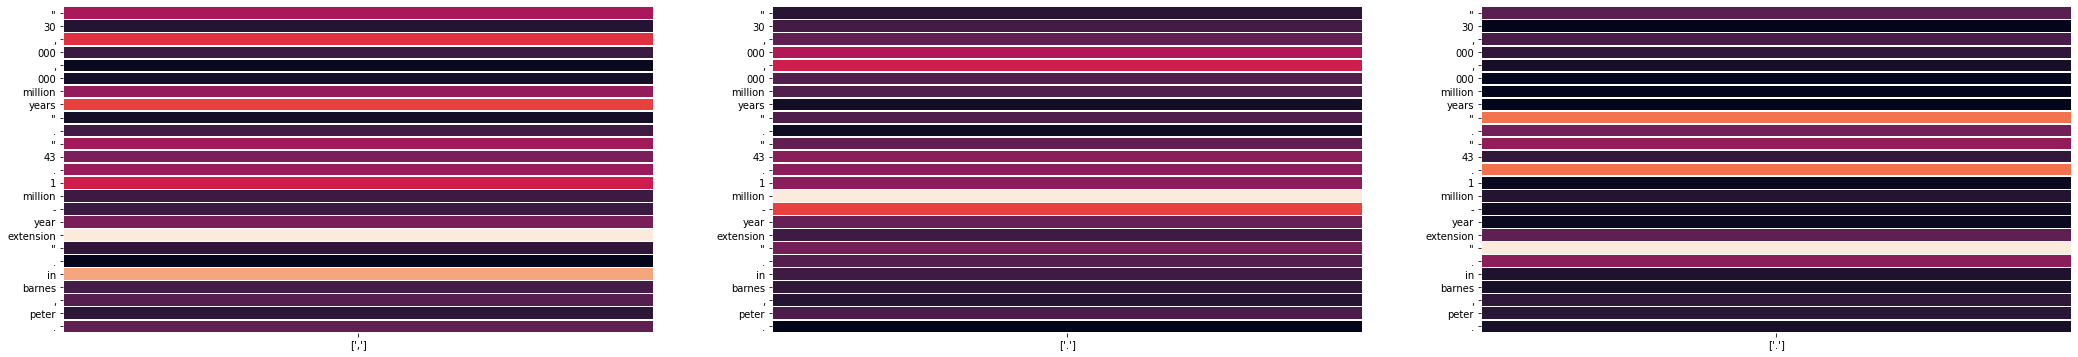


[ITERATION 83]
Current sentence: 	[CLS] " 30, 000, 000 million years ". " 43. 1 million - year extension ". in barnes, peter. [SEP]
Masked sentence: 	[CLS] " 30, [MASK], 000 million years ". " 43. 1 million - [MASK] extension ". in barnes, peter [MASK] [SEP]
Predictions: 	". 000 year"


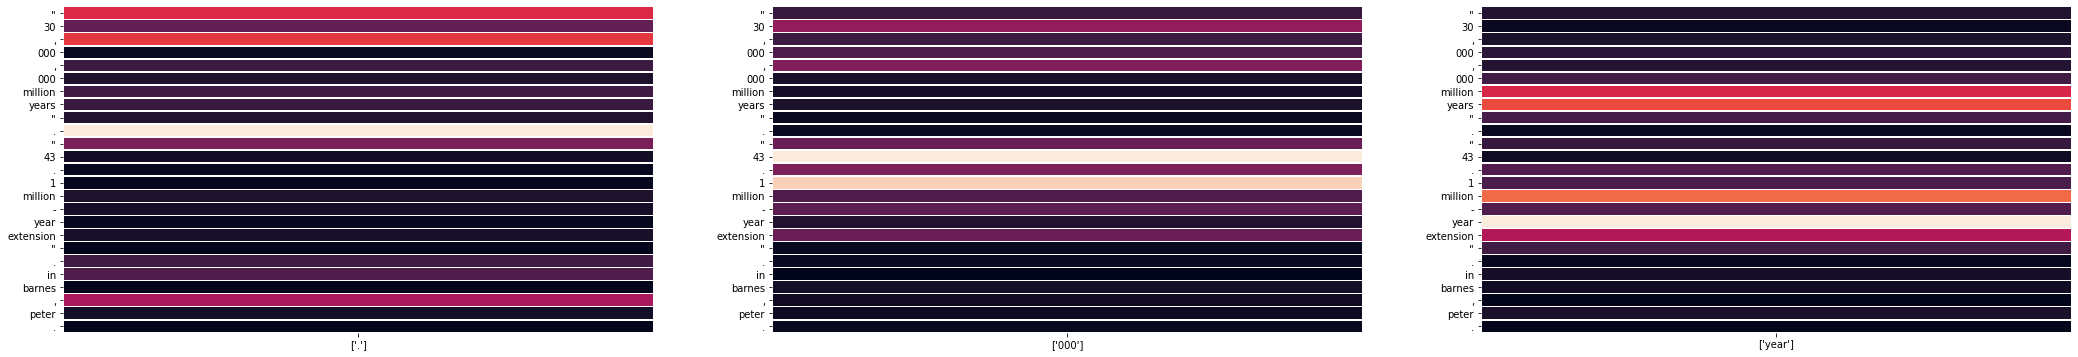


[ITERATION 84]
Current sentence: 	[CLS] " 30, 000, 000 million years ". " 43. 1 million - year extension ". in barnes, peter. [SEP]
Masked sentence: 	[CLS] " 30, 000, 000 million years " [MASK] " 43 [MASK] 1 million - year extension ". in barnes, [MASK]. [SEP]
Predictions: 	". paul."


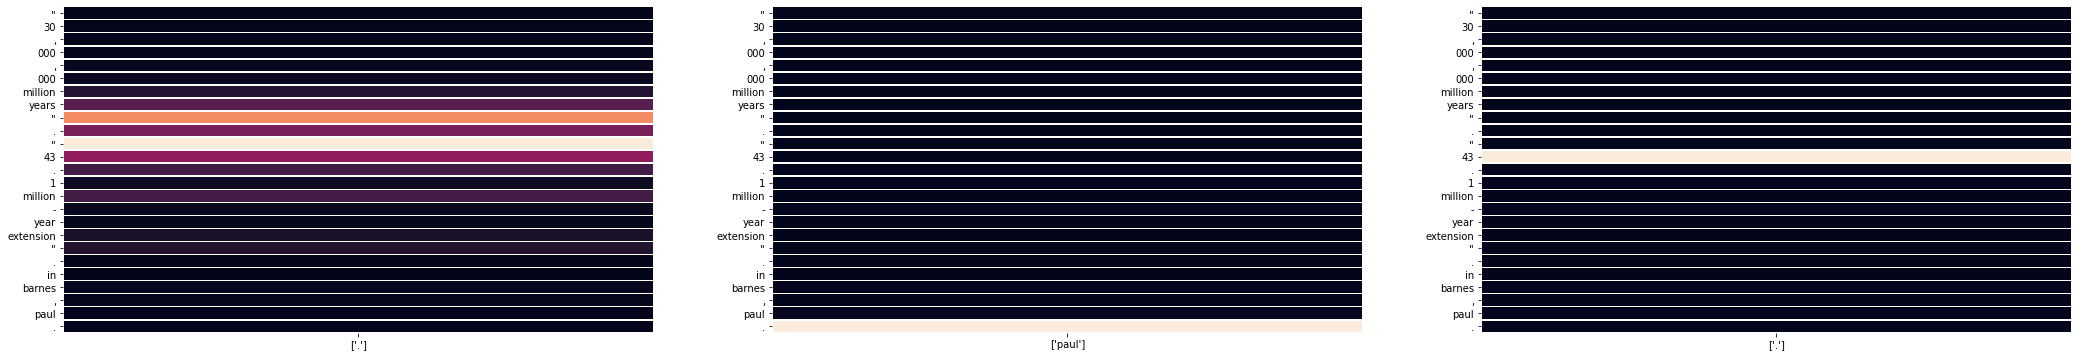


[ITERATION 85]
Current sentence: 	[CLS] " 30, 000, 000 million years ". " 43. 1 million - year extension ". in barnes, paul. [SEP]
Masked sentence: 	[CLS] " 30, 000, 000 million years " [MASK] " [MASK]. 1 million - year extension ". in barnes, paul [MASK] [SEP]
Predictions: 	".. 33"


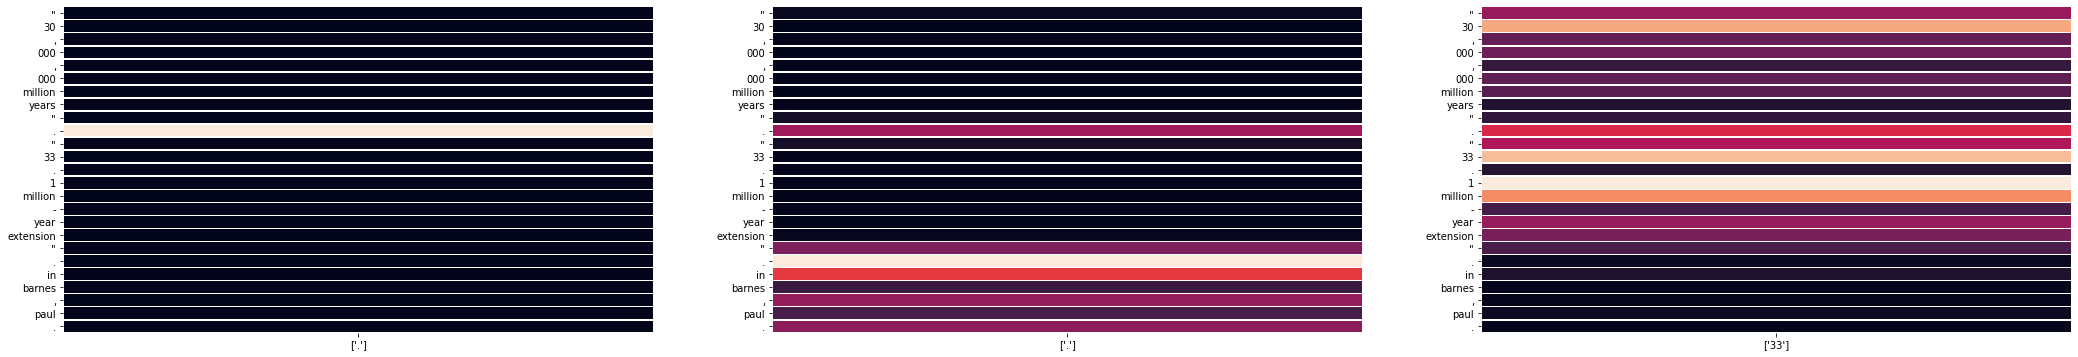


[ITERATION 86]
Current sentence: 	[CLS] " 30, 000, 000 million years ". " 33. 1 million - year extension ". in barnes, paul. [SEP]
Masked sentence: 	[CLS] " 30, 000, 000 million years ". " 33. 1 million - year [MASK] " [MASK] [MASK] barnes, paul. [SEP]
Predictions: 	".. ago"


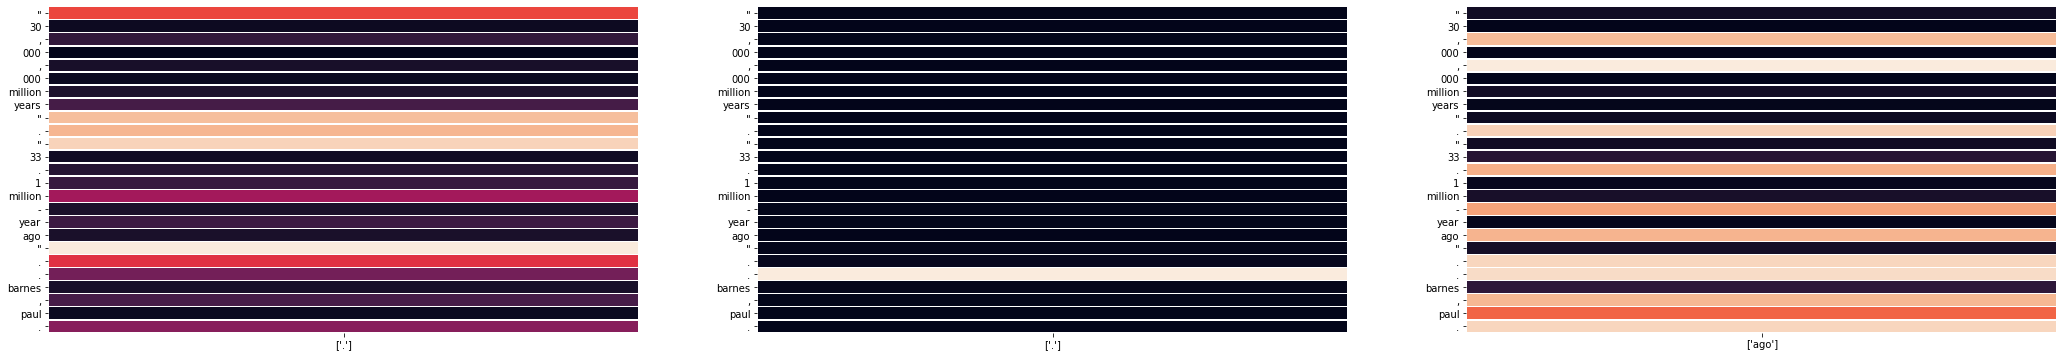


[ITERATION 87]
Current sentence: 	[CLS] " 30, 000, 000 million years ". " 33. 1 million - year ago ".. barnes, paul. [SEP]
Masked sentence: 	[CLS] " 30, 000, 000 million years ". " 33. 1 [MASK] - year ago ". [MASK] barnes [MASK] paul. [SEP]
Predictions: 	"billion in,"


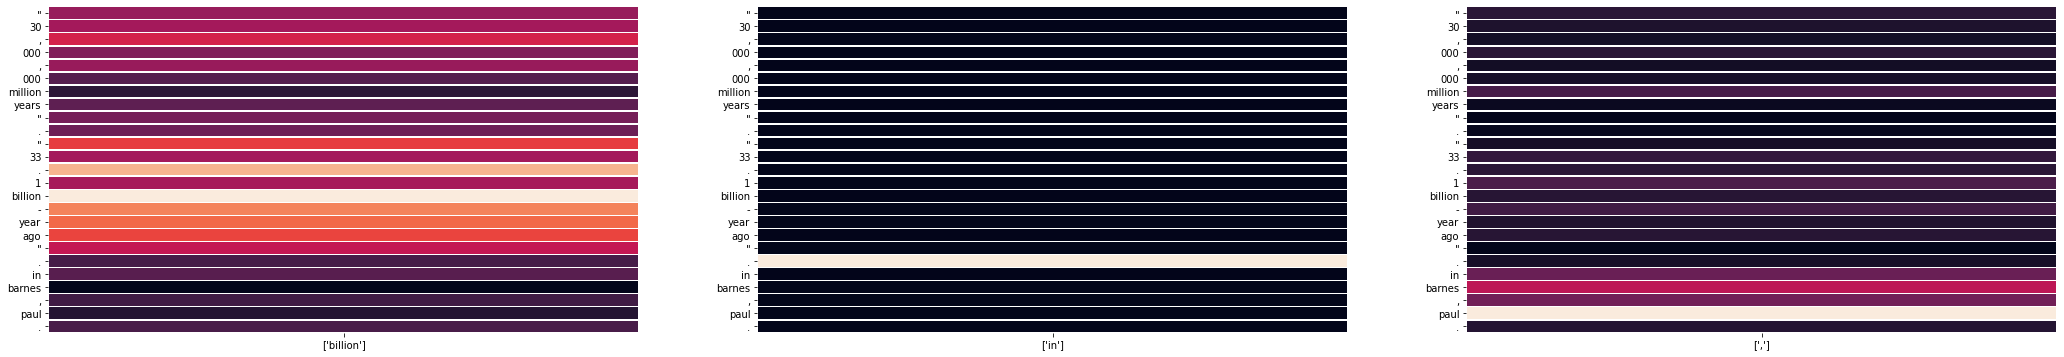


[ITERATION 88]
Current sentence: 	[CLS] " 30, 000, 000 million years ". " 33. 1 billion - year ago ". in barnes, paul. [SEP]
Masked sentence: 	[CLS] " 30, 000, 000 million years ". " 33. [MASK] billion - year [MASK] " [MASK] in barnes, paul. [SEP]
Predictions: 	"history. 3"


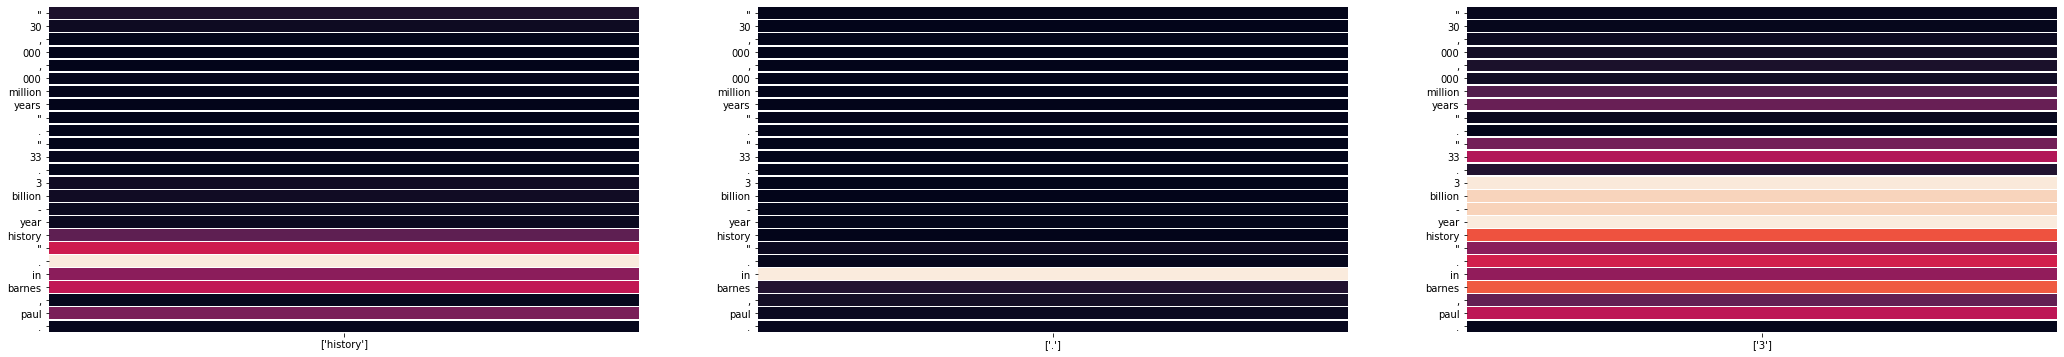


[ITERATION 89]
Current sentence: 	[CLS] " 30, 000, 000 million years ". " 33. 3 billion - year history ". in barnes, paul. [SEP]
Masked sentence: 	[CLS] " 30, 000, 000 million years ". " 33. 3 billion [MASK] year history ". in [MASK], paul. [SEP]
Predictions: 	"taylor brown -"


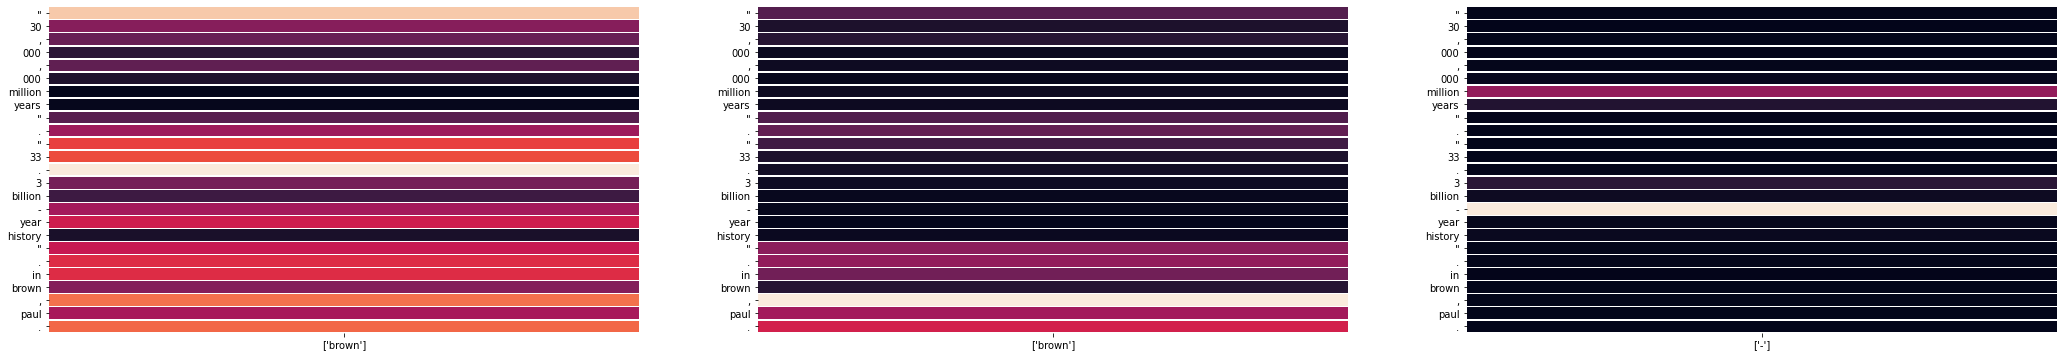


[ITERATION 90]
Current sentence: 	[CLS] " 30, 000, 000 million years ". " 33. 3 billion - year history ". in brown, paul. [SEP]
Masked sentence: 	[CLS] " 30, 000, 000 million years ". " 33. 3 [MASK] [MASK] year [MASK] ". in brown, paul. [SEP]
Predictions: 	"billion people billion"


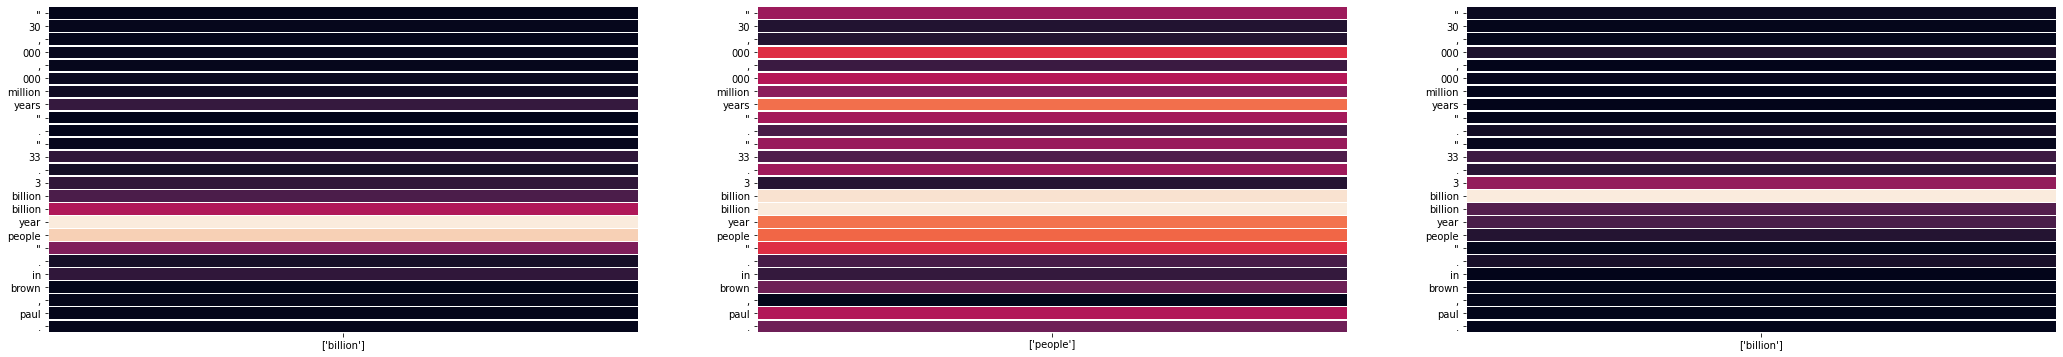


[ITERATION 91]
Current sentence: 	[CLS] " 30, 000, 000 million years ". " 33. 3 billion billion year people ". in brown, paul. [SEP]
Masked sentence: 	[CLS] " 30, 000, 000 million [MASK] ". " 33. [MASK] billion billion year [MASK] ". in brown, paul. [SEP]
Predictions: 	"rise trees 7"


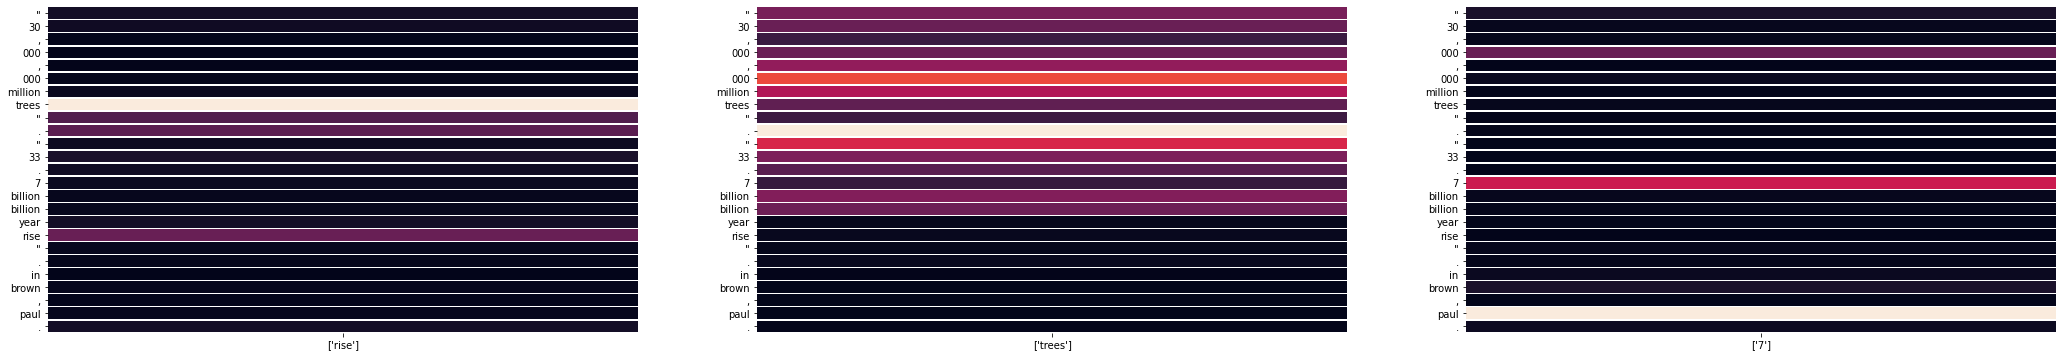


[ITERATION 92]
Current sentence: 	[CLS] " 30, 000, 000 million trees ". " 33. 7 billion billion year rise ". in brown, paul. [SEP]
Masked sentence: 	[CLS] " 30, 000, 000 million [MASK] [MASK]. " 33. 7 billion billion year rise ". in brown, [MASK]. [SEP]
Predictions: 	"years " david"


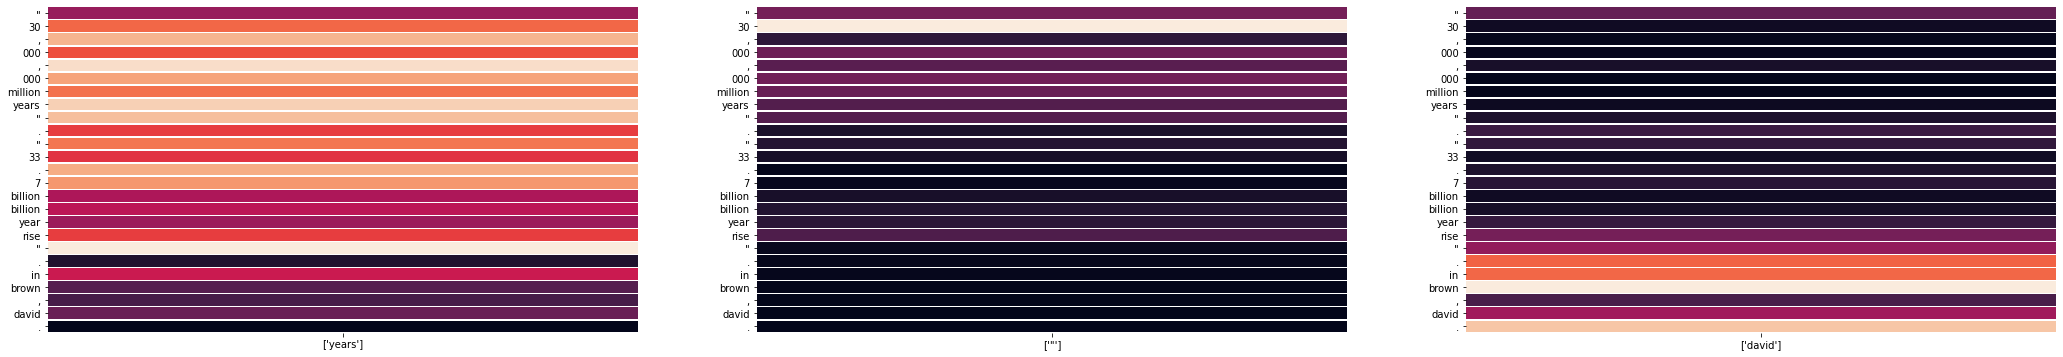


[ITERATION 93]
Current sentence: 	[CLS] " 30, 000, 000 million years ". " 33. 7 billion billion year rise ". in brown, david. [SEP]
Masked sentence: 	[CLS] " 30, 000, 000 million years ". " 33. 7 billion billion year [MASK] [MASK]. in brown, david. [SEP]
Predictions: 	"time " ""


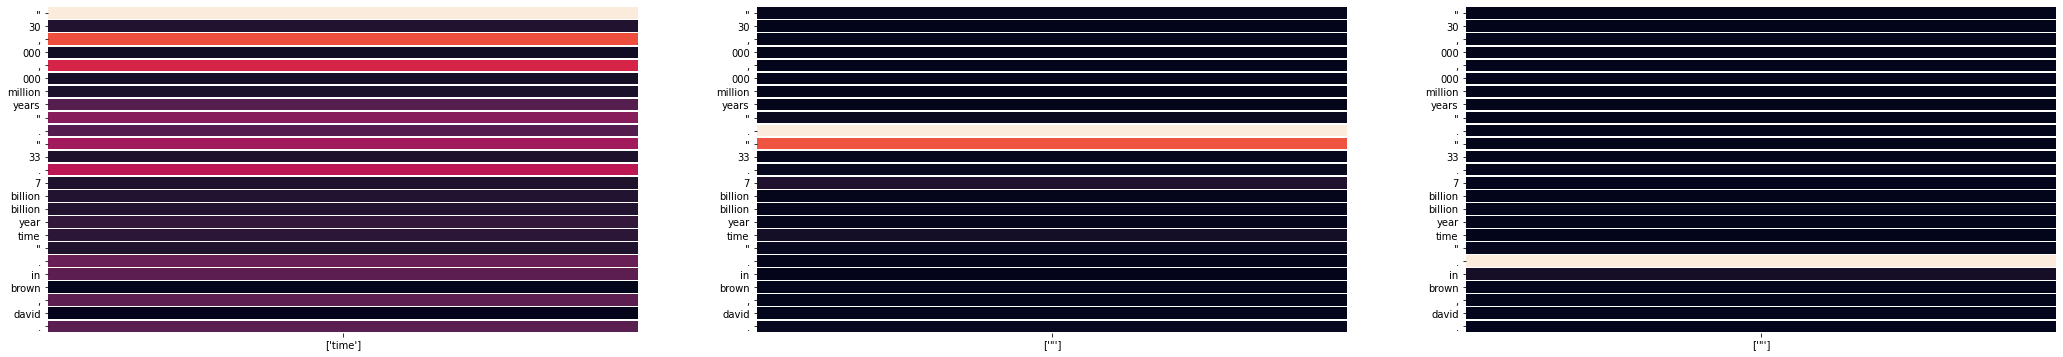


[ITERATION 94]
Current sentence: 	[CLS] " 30, 000, 000 million years ". " 33. 7 billion billion year time ". in brown, david. [SEP]
Masked sentence: 	[CLS] " 30, 000 [MASK] 000 million years " [MASK] " 33. 7 billion billion year time " [MASK] in brown, david. [SEP]
Predictions: 	", and,"


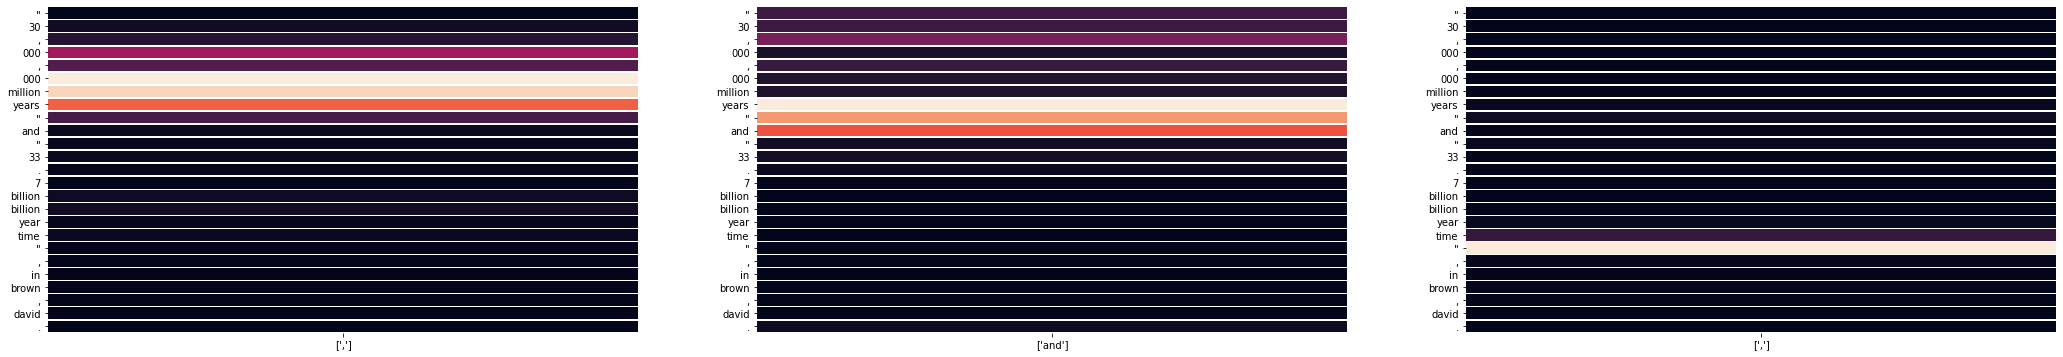


[ITERATION 95]
Current sentence: 	[CLS] " 30, 000, 000 million years " and " 33. 7 billion billion year time ", in brown, david. [SEP]
Masked sentence: 	[CLS] " 30, 000, 000 million years " [MASK] " 33. 7 billion billion year time [MASK], in brown, david. [SEP]
Predictions: 	"and, ""


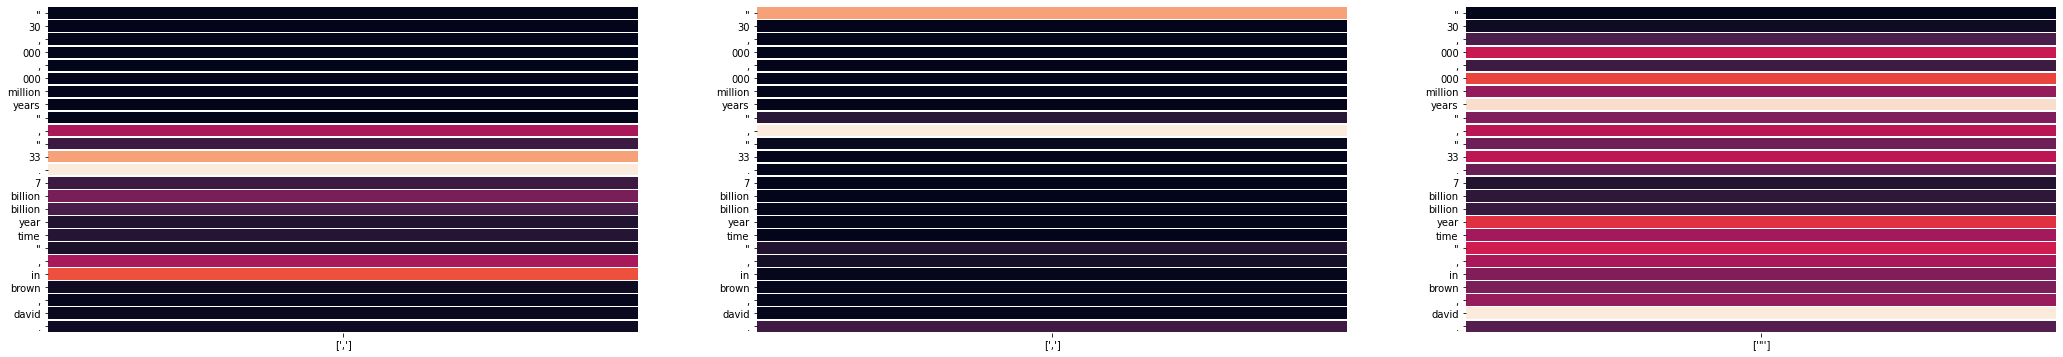


[ITERATION 96]
Current sentence: 	[CLS] " 30, 000, 000 million years ", " 33. 7 billion billion year time ", in brown, david. [SEP]
Masked sentence: 	[CLS] " 30, 000, 000 million years ", [MASK] 33. 7 [MASK] billion year time [MASK], in brown, david. [SEP]
Predictions: 	"billion zones in"


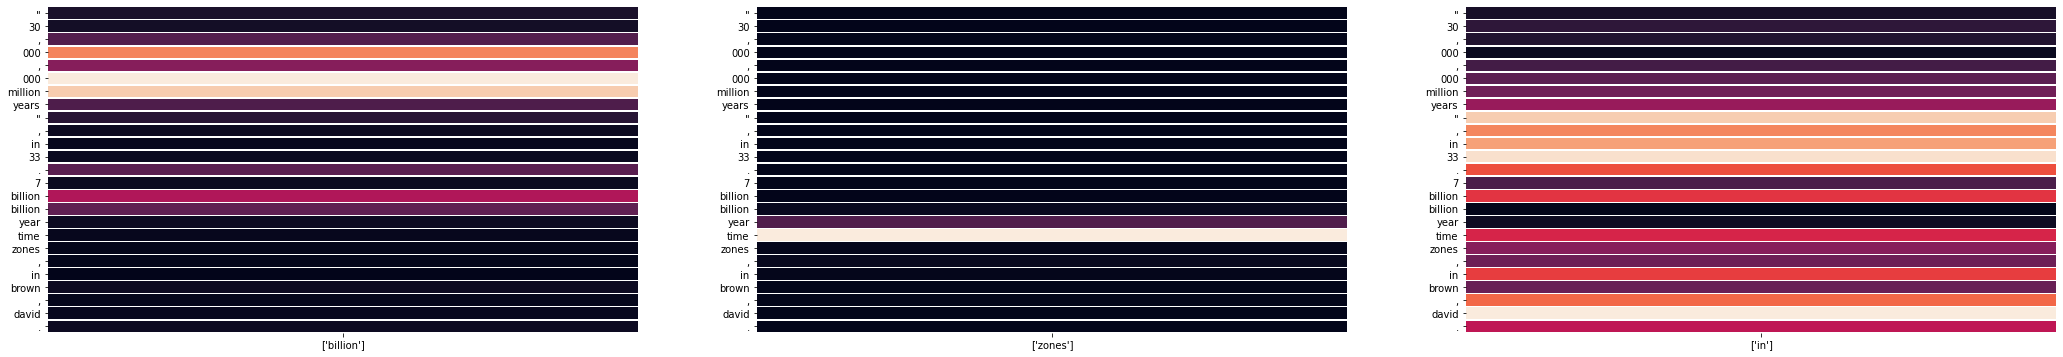


[ITERATION 97]
Current sentence: 	[CLS] " 30, 000, 000 million years ", in 33. 7 billion billion year time zones, in brown, david. [SEP]
Masked sentence: 	[CLS] [MASK] 30, 000, 000 million [MASK] ", in 33. 7 billion billion year [MASK] zones, in brown, david. [SEP]
Predictions: 	"scientists climate ""


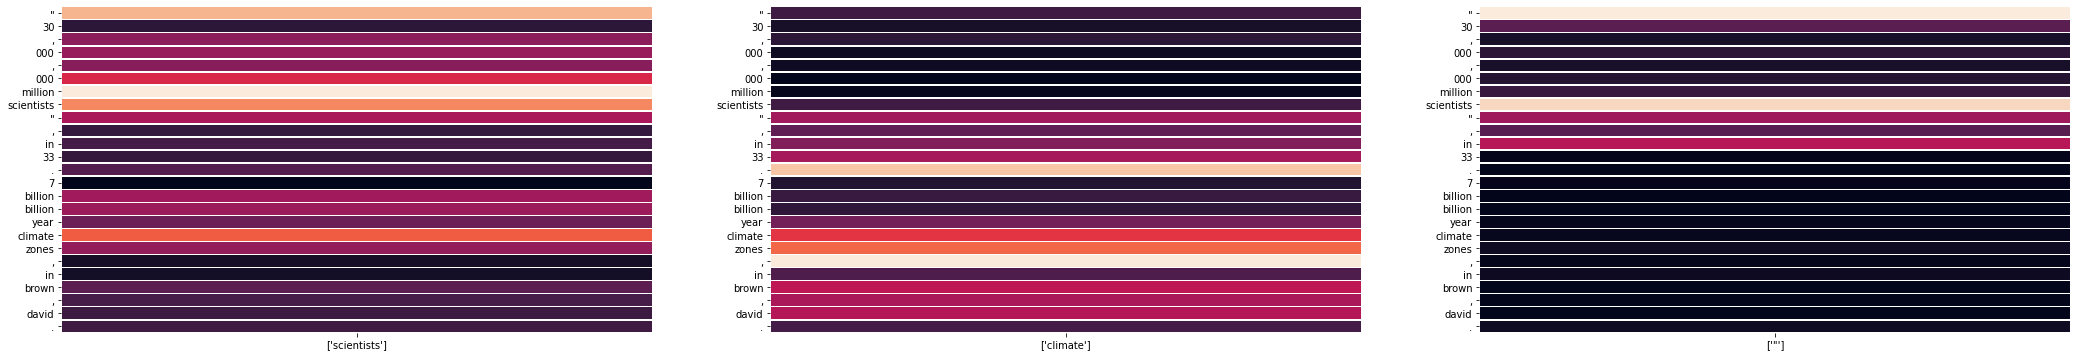


[ITERATION 98]
Current sentence: 	[CLS] " 30, 000, 000 million scientists ", in 33. 7 billion billion year climate zones, in brown, david. [SEP]
Masked sentence: 	[CLS] [MASK] 30, 000, 000 million scientists ", in 33. 7 billion billion year climate zones, in [MASK], [MASK]. [SEP]
Predictions: 	"usa berlin ""


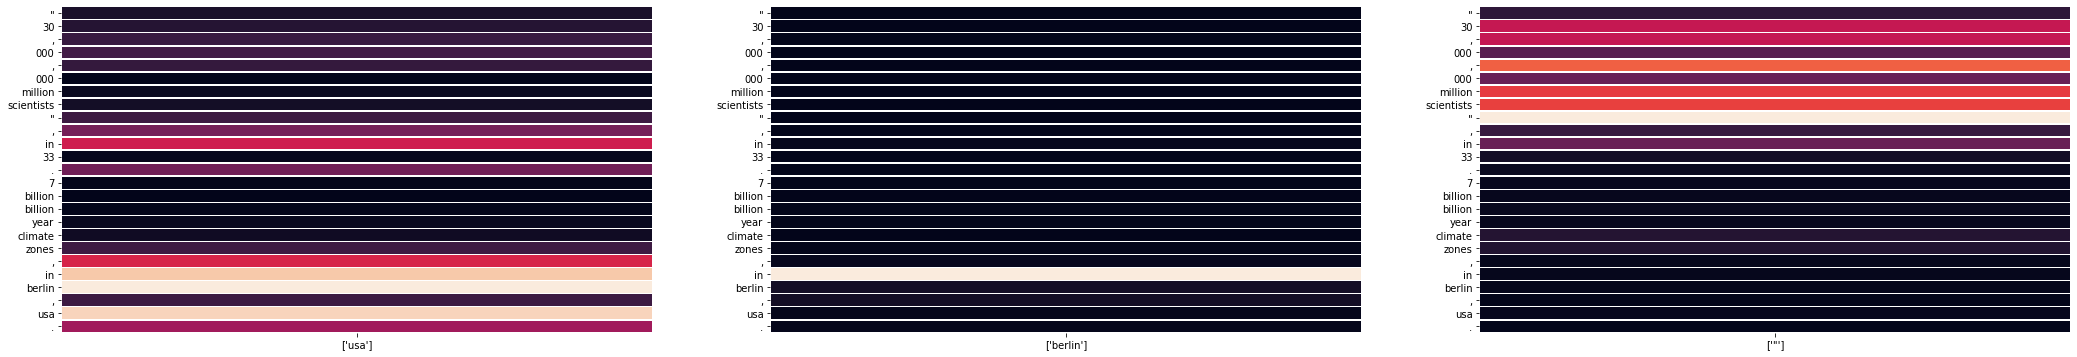


[ITERATION 99]
Current sentence: 	[CLS] " 30, 000, 000 million scientists ", in 33. 7 billion billion year climate zones, in berlin, usa. [SEP]
Masked sentence: 	[CLS] " 30, 000, 000 million scientists [MASK], [MASK] 33. 7 billion billion year climate zones, [MASK] berlin, usa. [SEP]
Predictions: 	"and " worldwide"


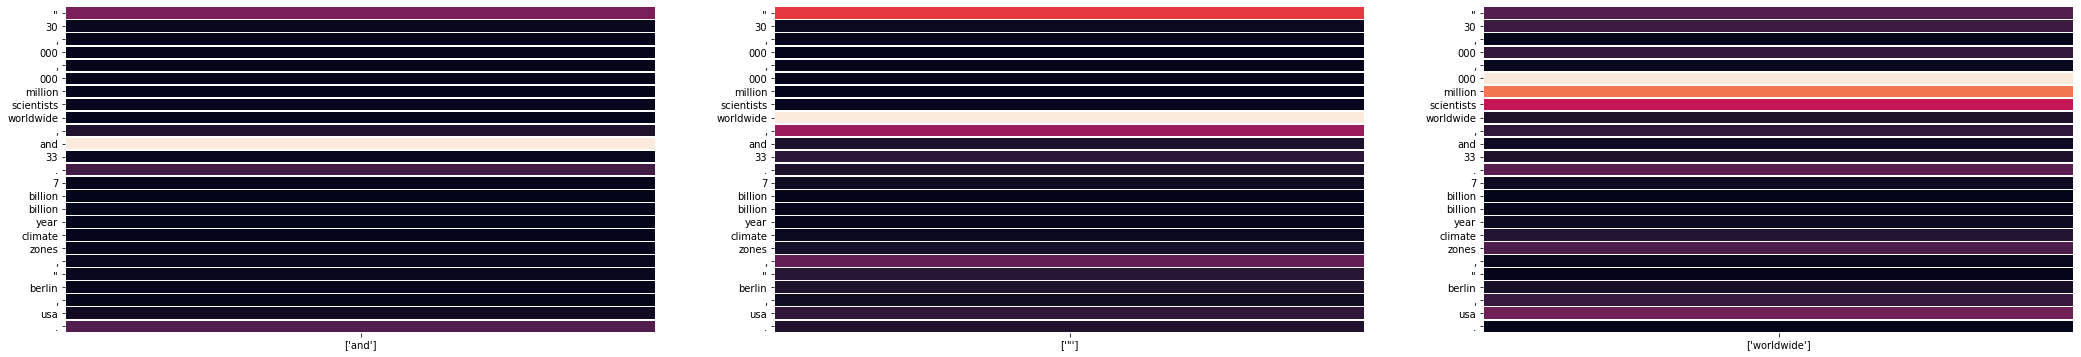


[ITERATION 100]
Current sentence: 	[CLS] " 30, 000, 000 million scientists worldwide, and 33. 7 billion billion year climate zones, " berlin, usa. [SEP]
Masked sentence: 	[CLS] " 30, 000, 000 million scientists worldwide, [MASK] [MASK]. 7 billion billion year climate zones, " berlin, [MASK]. [SEP]
Predictions: 	"about 3 germany"


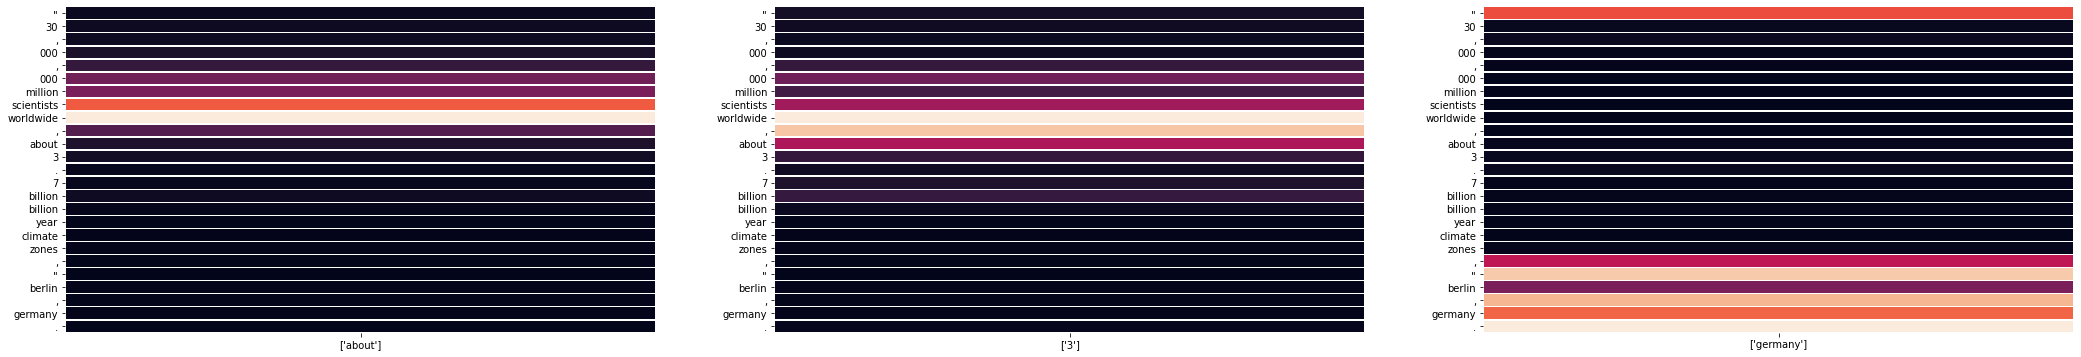


[ITERATION 101]
Current sentence: 	[CLS] " 30, 000, 000 million scientists worldwide, about 3. 7 billion billion year climate zones, " berlin, germany. [SEP]
Masked sentence: 	[CLS] " 30, 000, 000 [MASK] scientists worldwide, [MASK] 3. 7 billion billion year climate zones, [MASK] berlin, germany. [SEP]
Predictions: 	"across climate ""


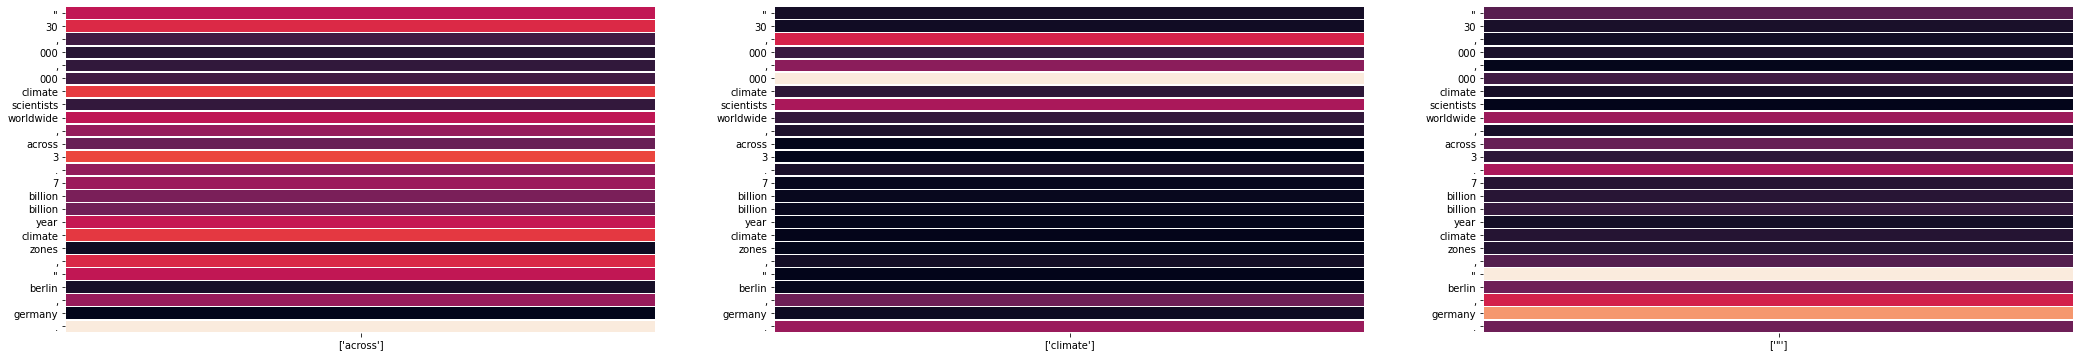


[ITERATION 102]
Current sentence: 	[CLS] " 30, 000, 000 climate scientists worldwide, across 3. 7 billion billion year climate zones, " berlin, germany. [SEP]
Masked sentence: 	[CLS] " 30, 000, 000 climate scientists worldwide, across 3. 7 billion billion year climate zones [MASK] [MASK] berlin, germany [MASK] [SEP]
Predictions: 	"". -"


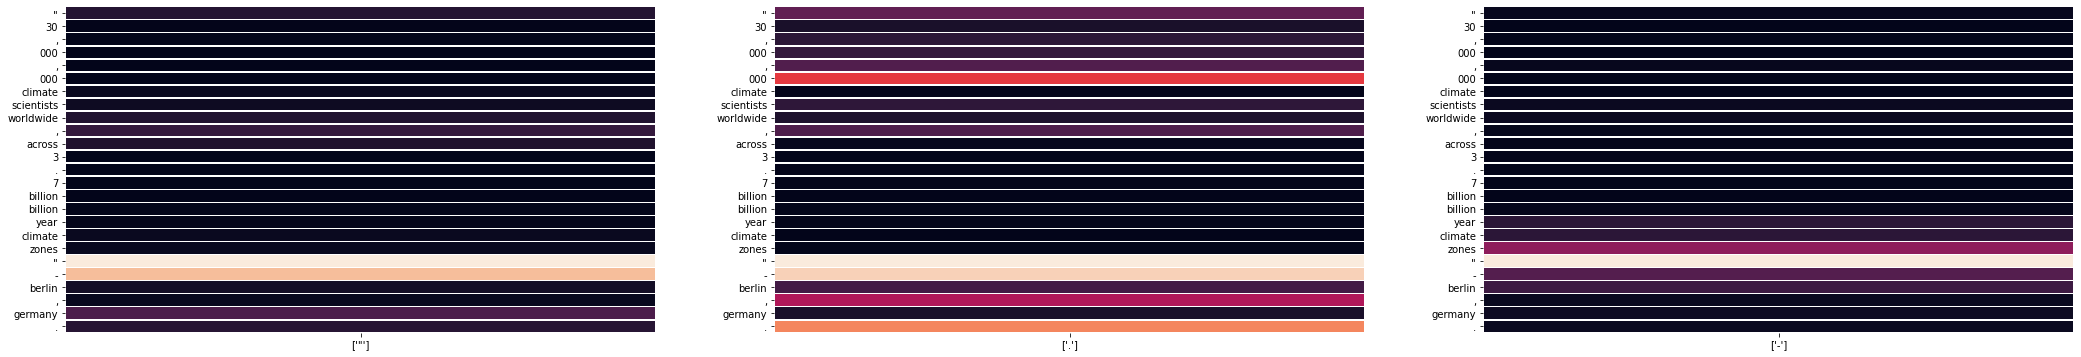


[ITERATION 103]
Current sentence: 	[CLS] " 30, 000, 000 climate scientists worldwide, across 3. 7 billion billion year climate zones " - berlin, germany. [SEP]
Masked sentence: 	[CLS] " 30, 000, [MASK] climate scientists worldwide, across 3. 7 billion billion year climate zones [MASK] - berlin, germany. [SEP]
Predictions: 	"" 000 ""


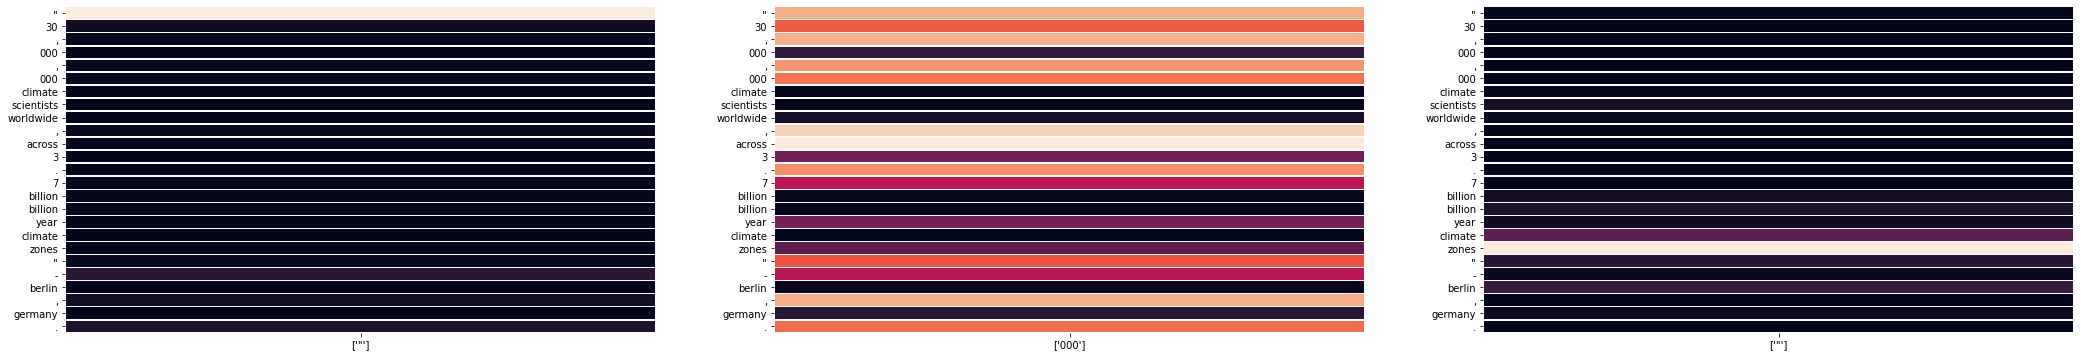


[ITERATION 104]
Current sentence: 	[CLS] " 30, 000, 000 climate scientists worldwide, across 3. 7 billion billion year climate zones " - berlin, germany. [SEP]
Masked sentence: 	[CLS] " 30 [MASK] 000, 000 climate scientists worldwide, across 3. 7 [MASK] billion year climate [MASK] " - berlin, germany. [SEP]
Predictions: 	"billion, system"


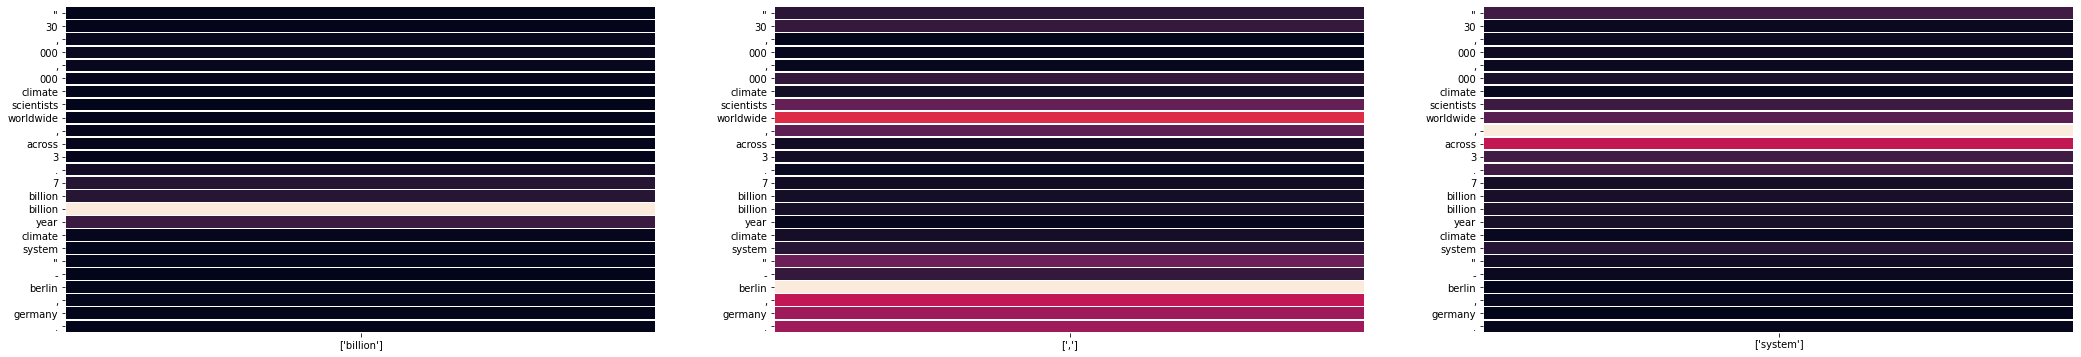


[ITERATION 105]
Current sentence: 	[CLS] " 30, 000, 000 climate scientists worldwide, across 3. 7 billion billion year climate system " - berlin, germany. [SEP]
Masked sentence: 	[CLS] [MASK] 30, 000, 000 climate scientists worldwide, across 3. 7 [MASK] [MASK] year climate system " - berlin, germany. [SEP]
Predictions: 	"billion " billion"


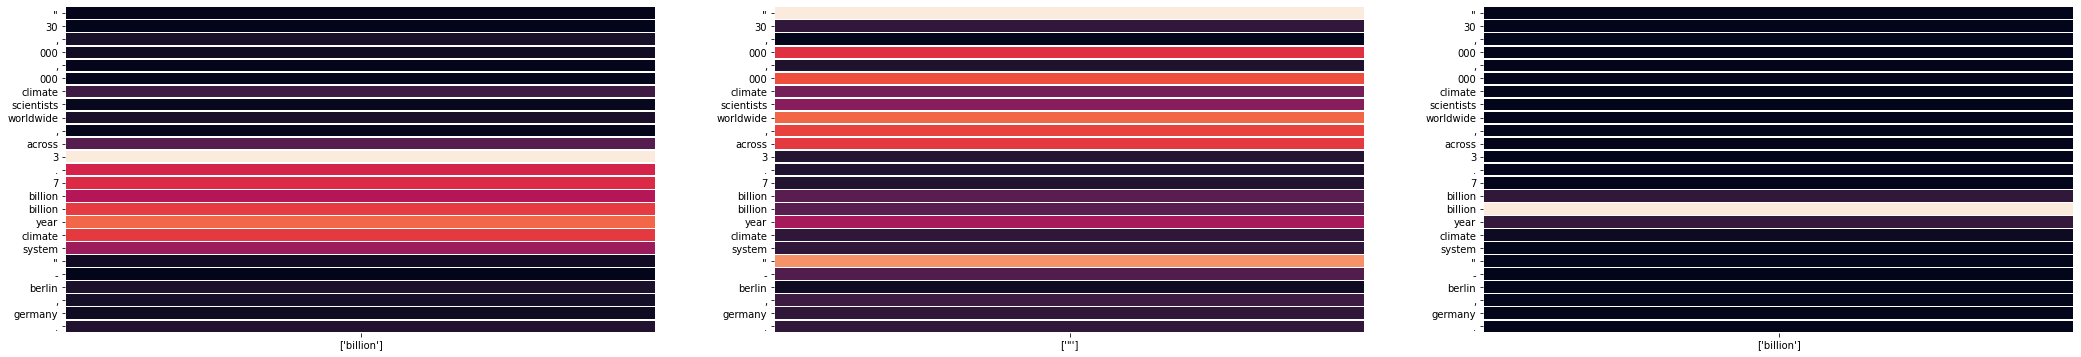


[ITERATION 106]
Current sentence: 	[CLS] " 30, 000, 000 climate scientists worldwide, across 3. 7 billion billion year climate system " - berlin, germany. [SEP]
Masked sentence: 	[CLS] " 30, 000, 000 climate scientists worldwide, across [MASK]. 7 billion [MASK] year climate system " - berlin [MASK] germany. [SEP]
Predictions: 	", 2 -"


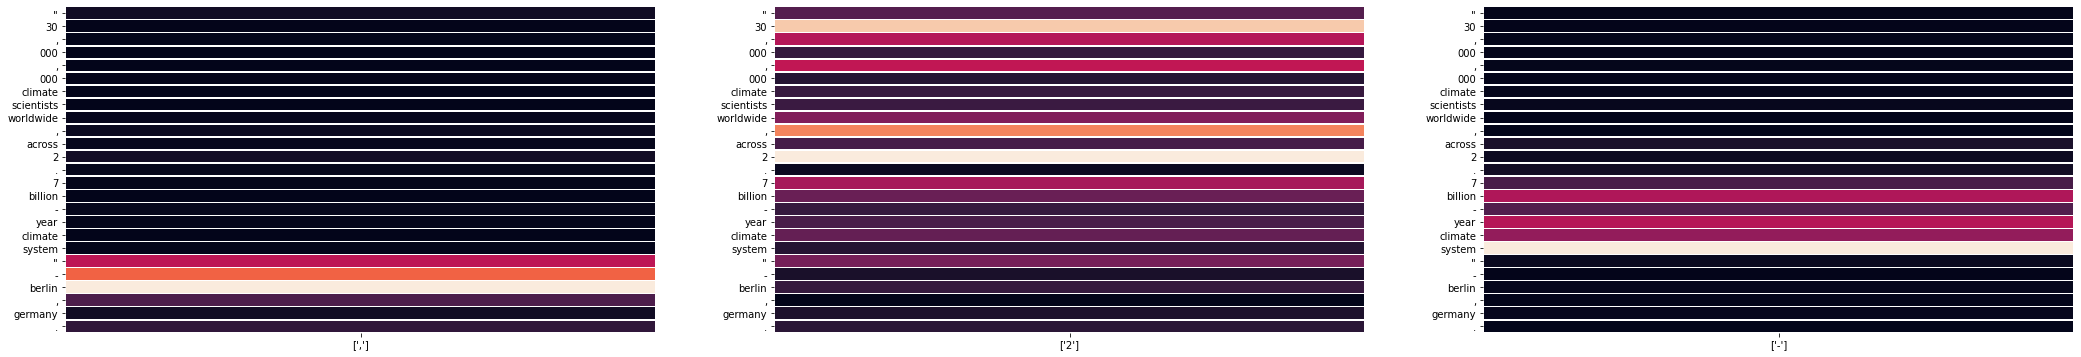


[ITERATION 107]
Current sentence: 	[CLS] " 30, 000, 000 climate scientists worldwide, across 2. 7 billion - year climate system " - berlin, germany. [SEP]
Masked sentence: 	[CLS] " 30, 000 [MASK] 000 climate scientists worldwide, across 2. 7 [MASK] - year climate system " [MASK] berlin, germany. [SEP]
Predictions: 	"., billion"


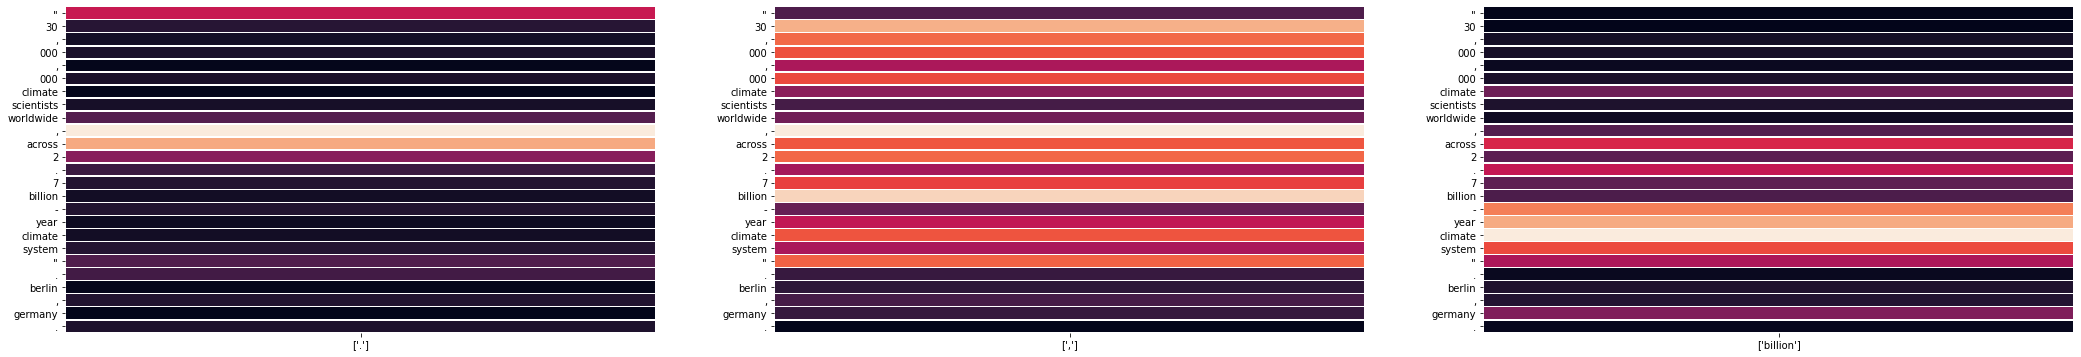


[ITERATION 108]
Current sentence: 	[CLS] " 30, 000, 000 climate scientists worldwide, across 2. 7 billion - year climate system ". berlin, germany. [SEP]
Masked sentence: 	[CLS] " 30, 000, 000 climate scientists worldwide [MASK] [MASK] 2. 7 billion - year climate system [MASK]. berlin, germany. [SEP]
Predictions: 	"" a researching"


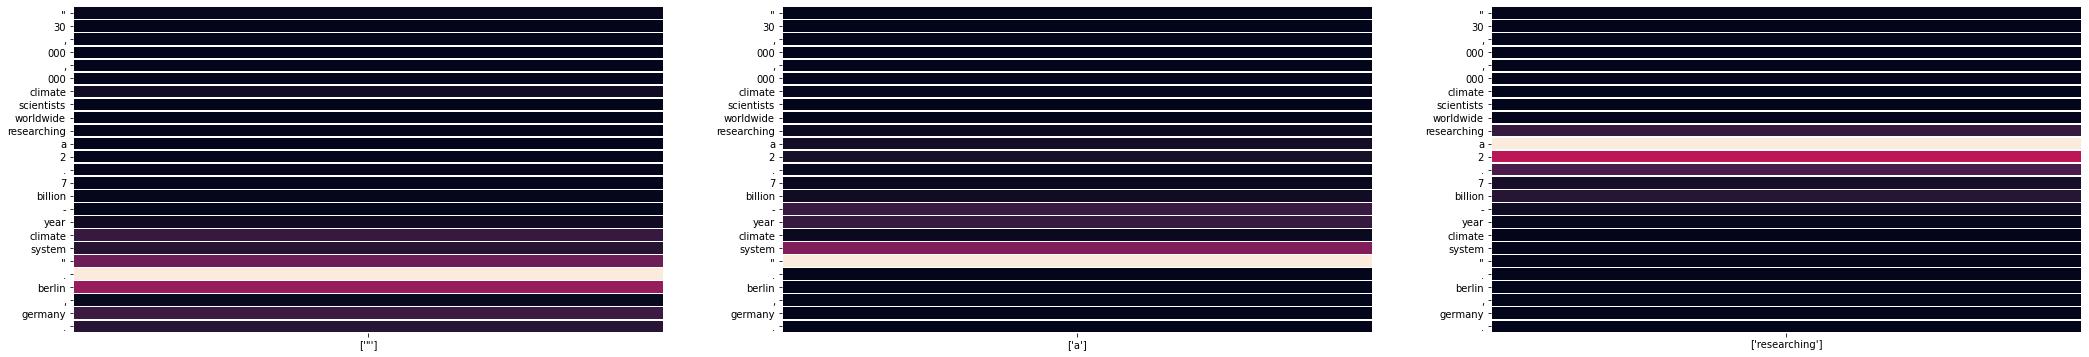


[ITERATION 109]
Current sentence: 	[CLS] " 30, 000, 000 climate scientists worldwide researching a 2. 7 billion - year climate system ". berlin, germany. [SEP]
Masked sentence: 	[CLS] " 30, 000, 000 climate scientists worldwide researching [MASK] 2. 7 billion - [MASK] climate system [MASK]. berlin, germany. [SEP]
Predictions: 	"" year the"


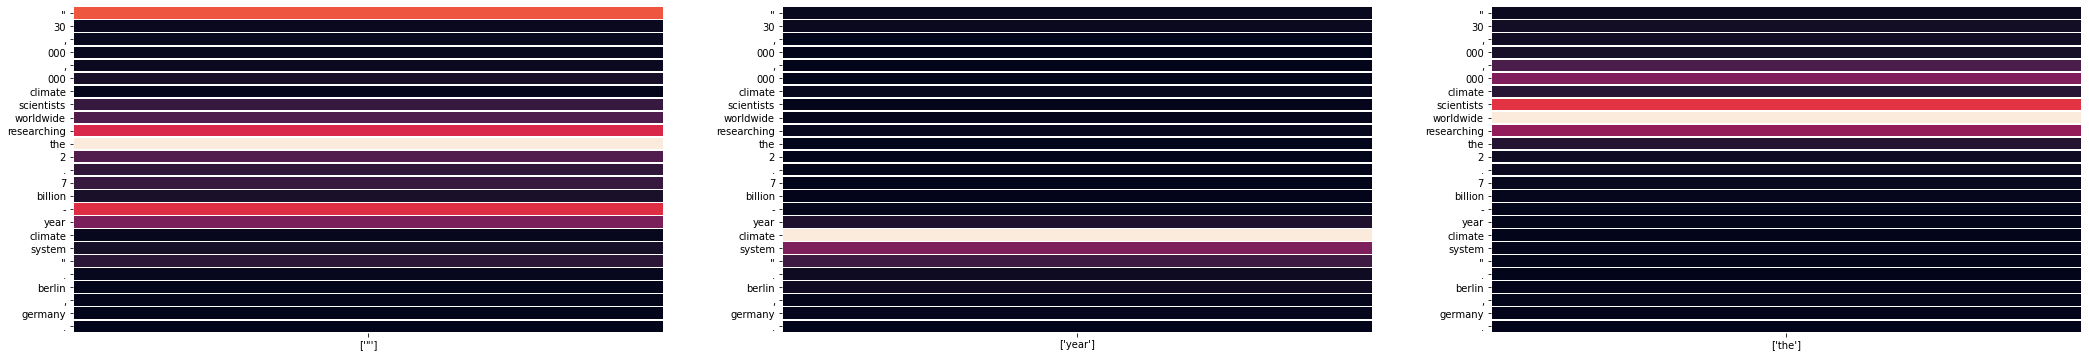


[ITERATION 110]
Current sentence: 	[CLS] " 30, 000, 000 climate scientists worldwide researching the 2. 7 billion - year climate system ". berlin, germany. [SEP]
Masked sentence: 	[CLS] " 30, 000, 000 climate [MASK] worldwide researching [MASK] 2. 7 billion - [MASK] climate system ". berlin, germany. [SEP]
Predictions: 	"the year scientists"


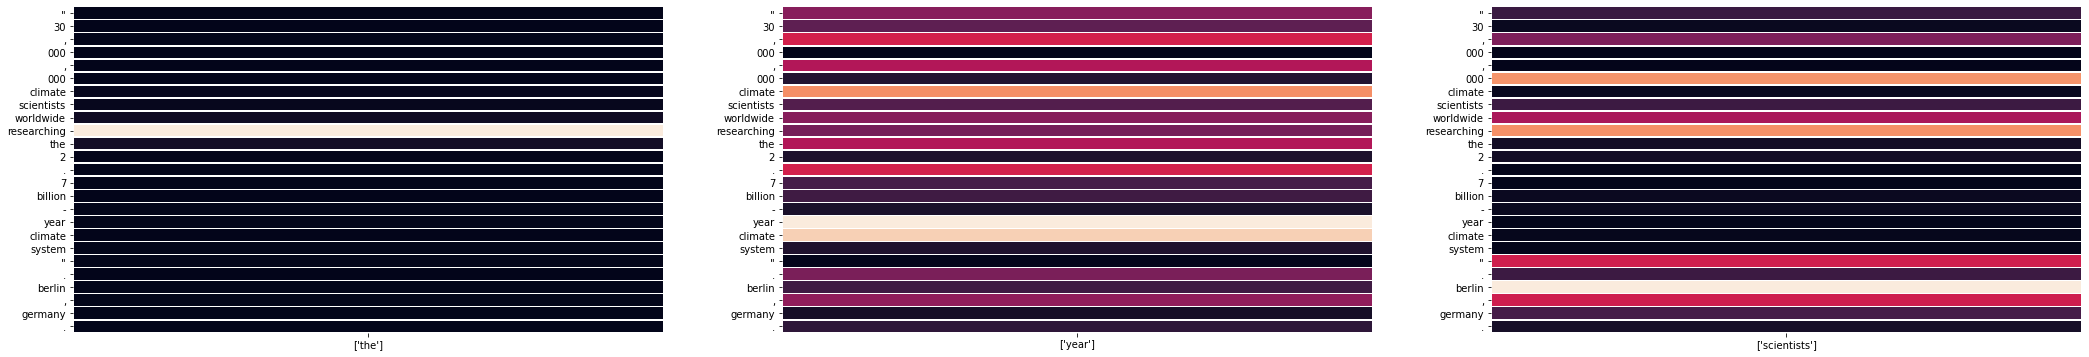


[ITERATION 111]
Current sentence: 	[CLS] " 30, 000, 000 climate scientists worldwide researching the 2. 7 billion - year climate system ". berlin, germany. [SEP]
Masked sentence: 	[CLS] " 30, 000, 000 climate scientists worldwide [MASK] the 2. [MASK] billion - year climate system ". berlin, germany. [SEP]
Predictions: 	"investigate 6 predict"


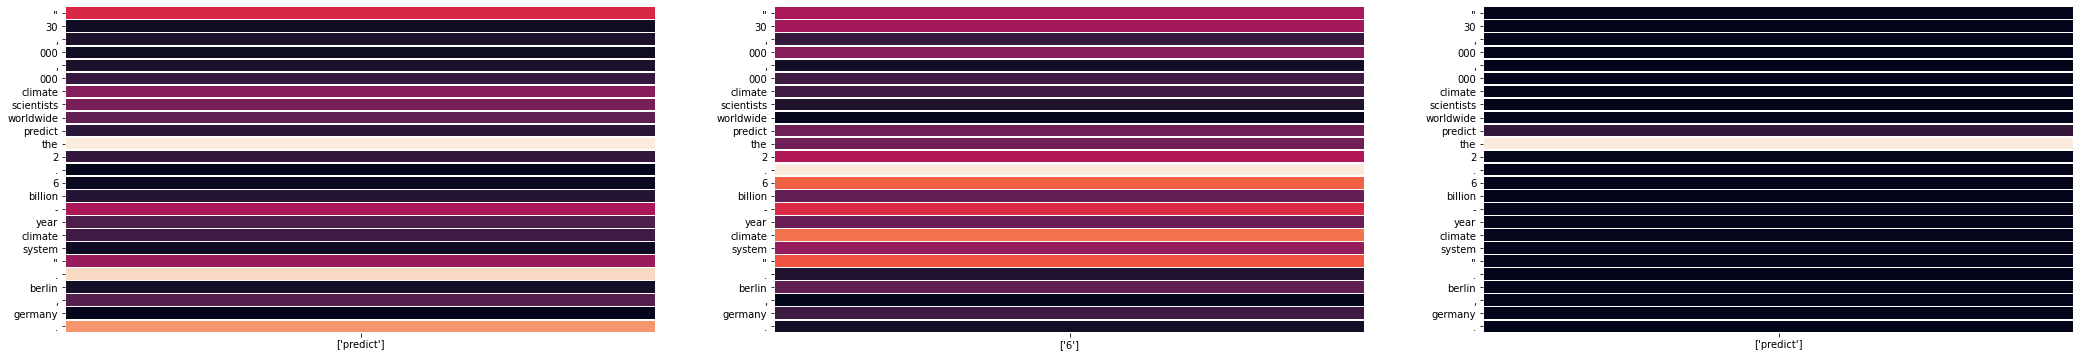


[ITERATION 112]
Current sentence: 	[CLS] " 30, 000, 000 climate scientists worldwide predict the 2. 6 billion - year climate system ". berlin, germany. [SEP]
Masked sentence: 	[CLS] " 30, 000 [MASK] 000 climate scientists worldwide predict [MASK] 2. 6 billion - year climate system ". berlin, germany [MASK] [SEP]
Predictions: 	"., a"


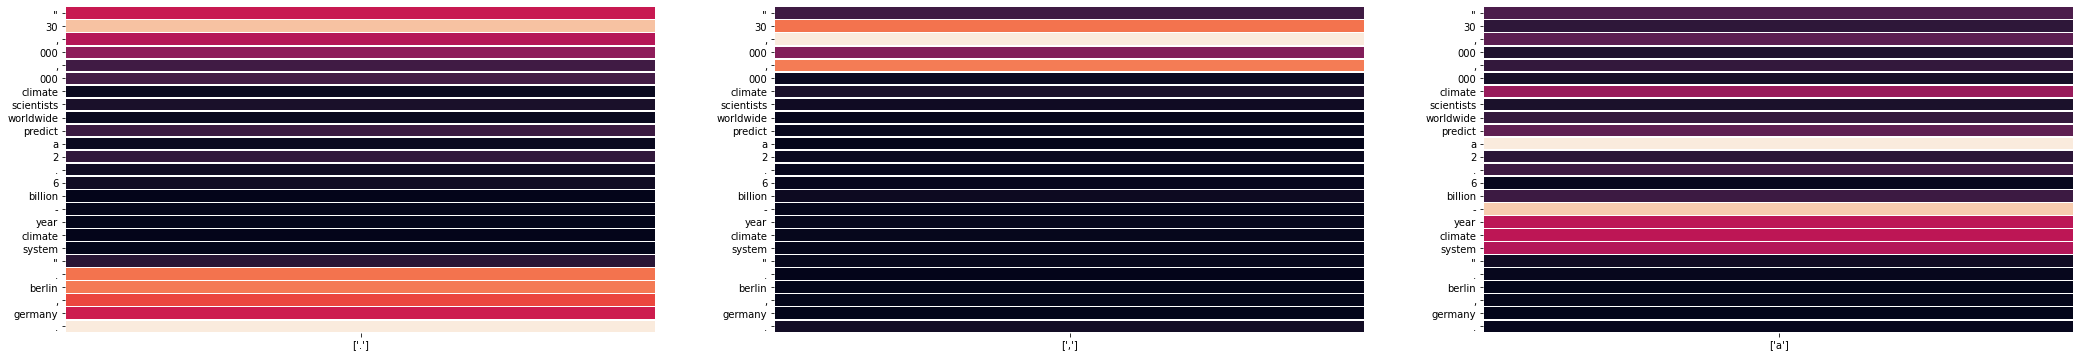


[ITERATION 113]
Current sentence: 	[CLS] " 30, 000, 000 climate scientists worldwide predict a 2. 6 billion - year climate system ". berlin, germany. [SEP]
Masked sentence: 	[CLS] " 30 [MASK] 000, 000 climate scientists worldwide predict a 2. 6 billion [MASK] year climate system ". [MASK], germany. [SEP]
Predictions: 	"leipzig, -"


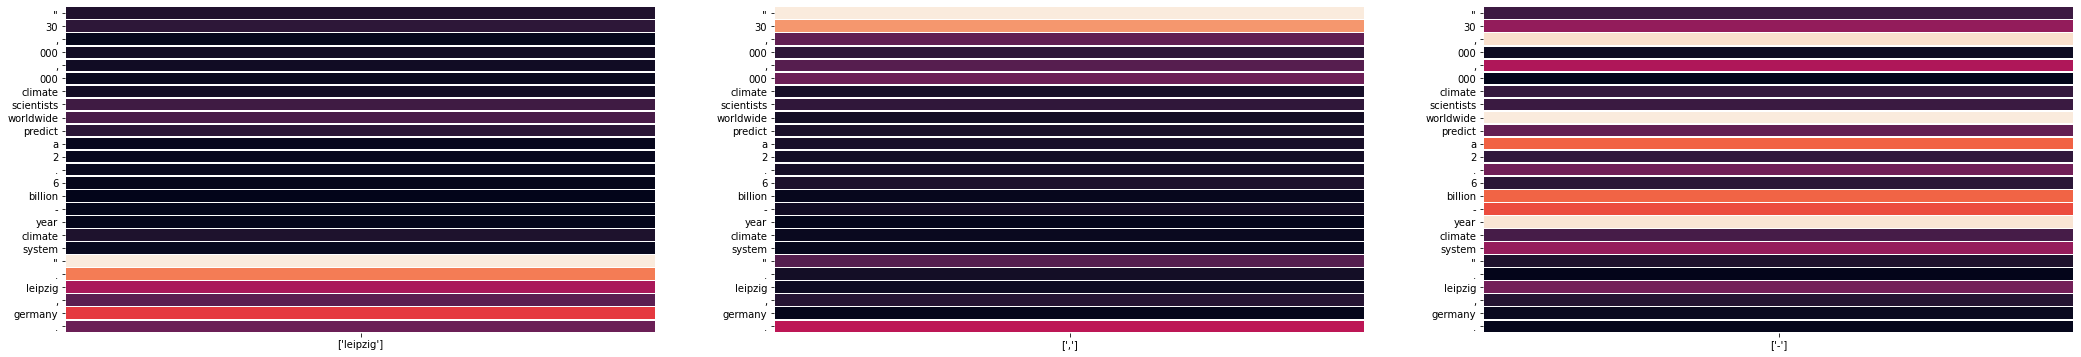


[ITERATION 114]
Current sentence: 	[CLS] " 30, 000, 000 climate scientists worldwide predict a 2. 6 billion - year climate system ". leipzig, germany. [SEP]
Masked sentence: 	[CLS] " 30, 000, 000 climate scientists worldwide predict a 2. 6 billion [MASK] year climate system [MASK] [MASK] leipzig, germany. [SEP]
Predictions: 	"". -"


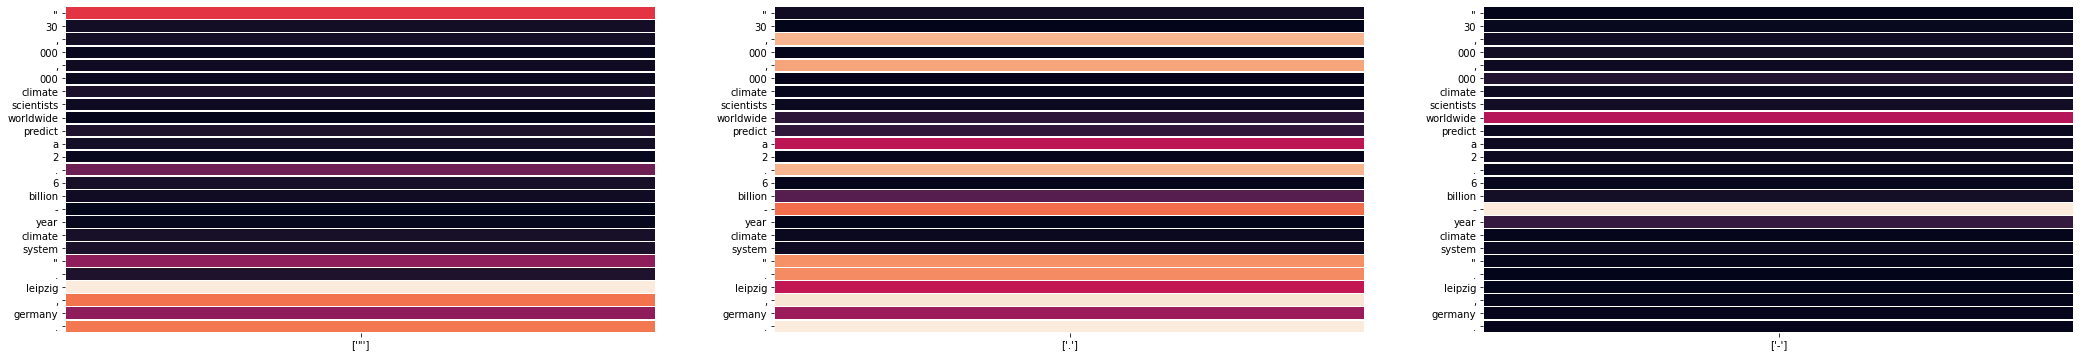


[ITERATION 115]
Current sentence: 	[CLS] " 30, 000, 000 climate scientists worldwide predict a 2. 6 billion - year climate system ". leipzig, germany. [SEP]
Masked sentence: 	[CLS] " 30, 000, 000 climate scientists worldwide predict [MASK] 2. 6 [MASK] - year climate system ". [MASK], germany. [SEP]
Predictions: 	"london the billion"


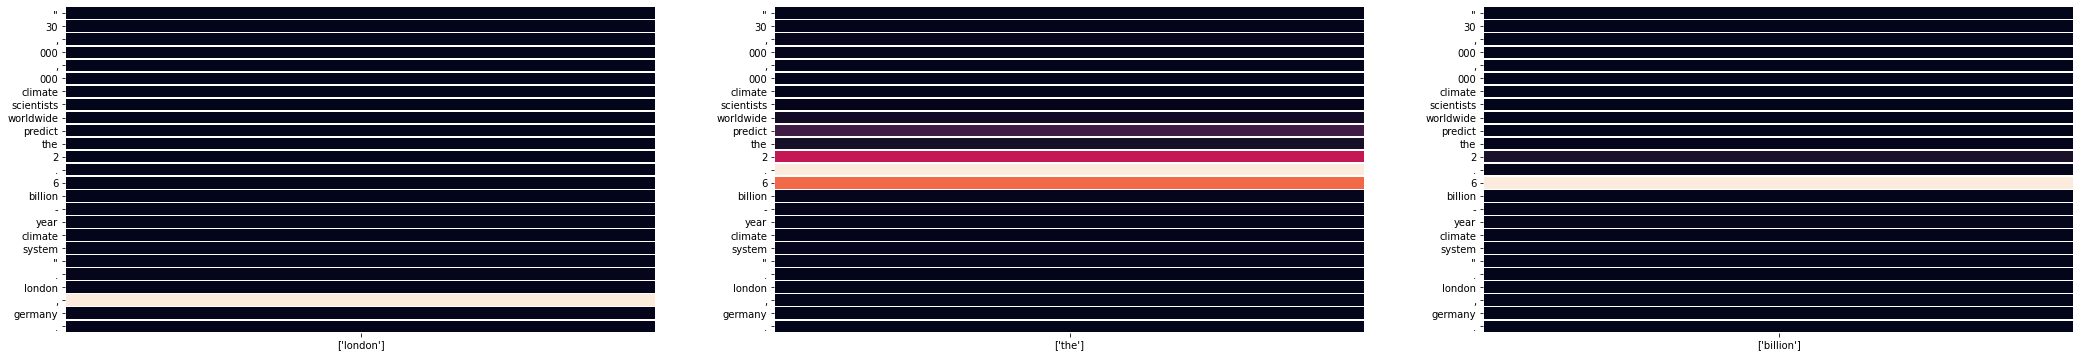


[ITERATION 116]
Current sentence: 	[CLS] " 30, 000, 000 climate scientists worldwide predict the 2. 6 billion - year climate system ". london, germany. [SEP]
Masked sentence: 	[CLS] " 30, 000, 000 climate scientists worldwide predict the [MASK]. [MASK] billion - year climate system ". london [MASK] germany. [SEP]
Predictions: 	", 5 1"


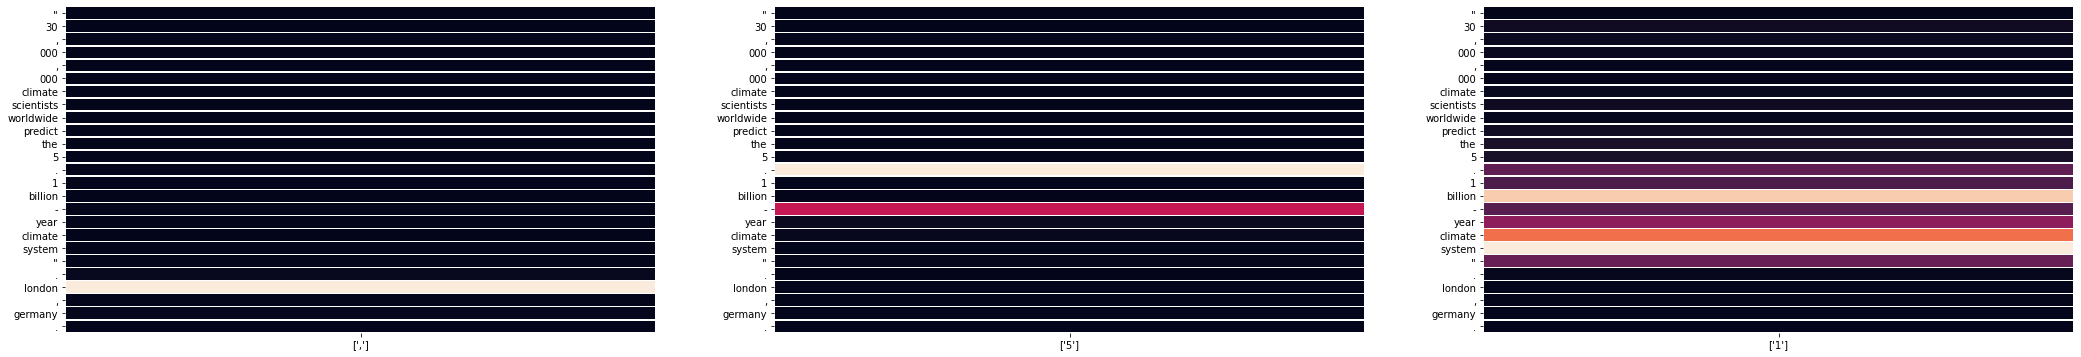


[ITERATION 117]
Current sentence: 	[CLS] " 30, 000, 000 climate scientists worldwide predict the 5. 1 billion - year climate system ". london, germany. [SEP]
Masked sentence: 	[CLS] " 30, 000, 000 climate scientists worldwide predict the 5 [MASK] 1 billion - year climate [MASK] ". [MASK], germany. [SEP]
Predictions: 	"hamburg. gap"


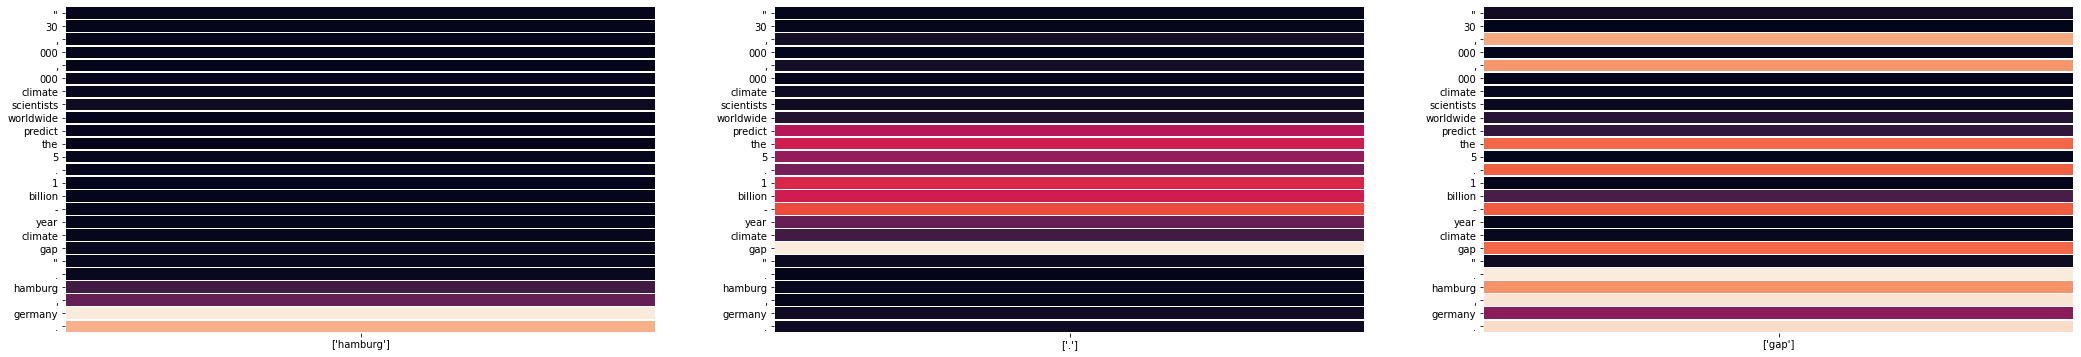


[ITERATION 118]
Current sentence: 	[CLS] " 30, 000, 000 climate scientists worldwide predict the 5. 1 billion - year climate gap ". hamburg, germany. [SEP]
Masked sentence: 	[CLS] " 30, 000, 000 climate scientists worldwide predict the 5. [MASK] billion - year climate gap " [MASK] hamburg, [MASK]. [SEP]
Predictions: 	"germany 5."


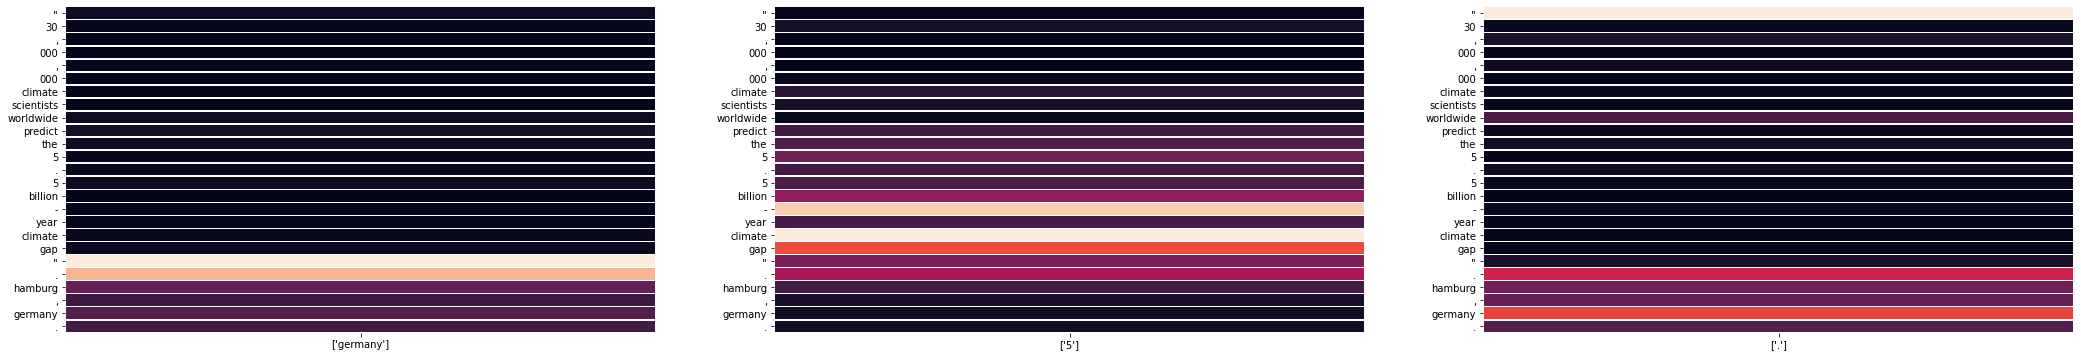


[ITERATION 119]
Current sentence: 	[CLS] " 30, 000, 000 climate scientists worldwide predict the 5. 5 billion - year climate gap ". hamburg, germany. [SEP]
Masked sentence: 	[CLS] " 30, 000, 000 climate scientists worldwide predict the 5. 5 billion - year climate gap [MASK] [MASK] [MASK], germany. [SEP]
Predictions: 	"heidelberg in berlin"


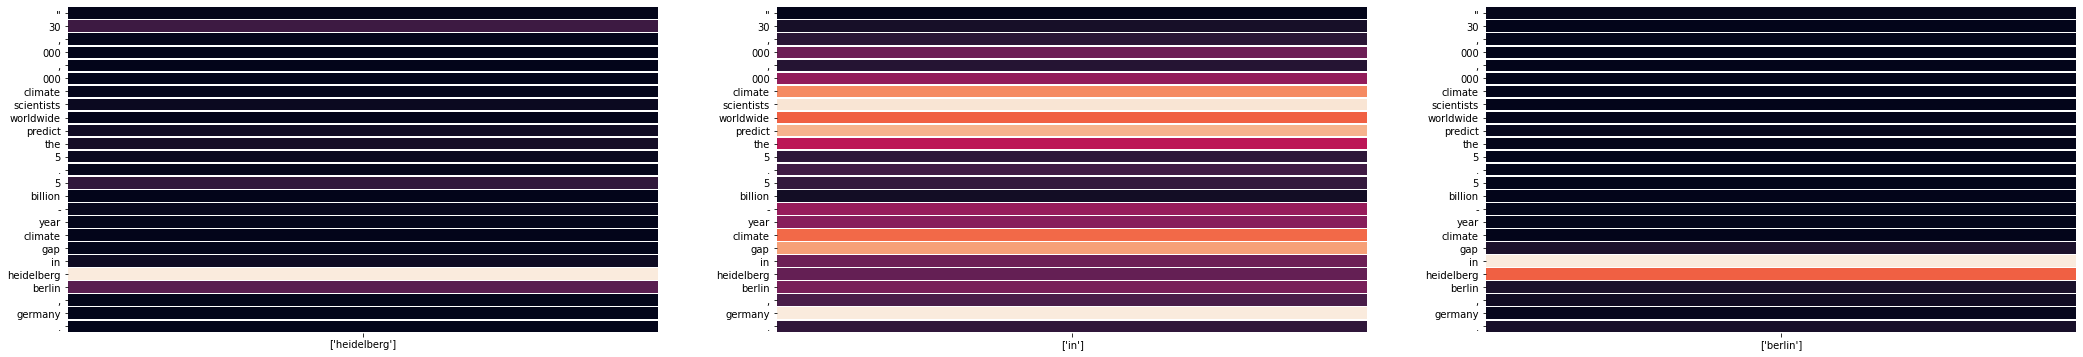


[ITERATION 120]
Current sentence: 	[CLS] " 30, 000, 000 climate scientists worldwide predict the 5. 5 billion - year climate gap in heidelberg berlin, germany. [SEP]
Masked sentence: 	[CLS] " 30, 000, 000 climate scientists worldwide predict the 5. [MASK] billion - year climate gap [MASK] heidelberg berlin, germany. [SEP]
Predictions: 	"9 " ""


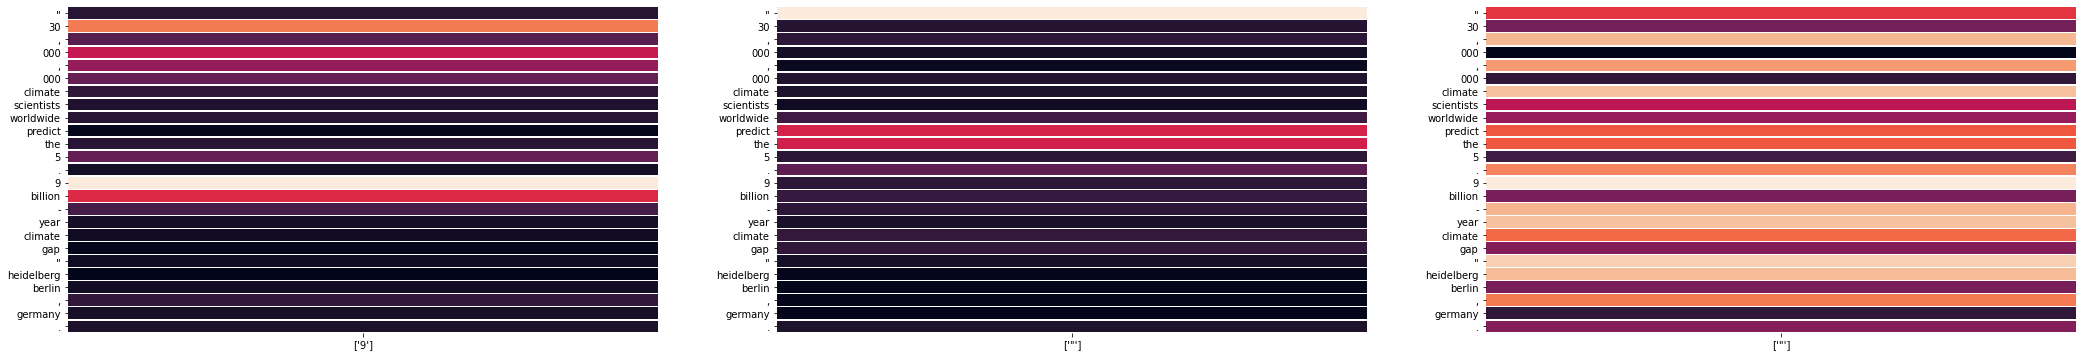


[ITERATION 121]
Current sentence: 	[CLS] " 30, 000, 000 climate scientists worldwide predict the 5. 9 billion - year climate gap " heidelberg berlin, germany. [SEP]
Masked sentence: 	[CLS] [MASK] 30, 000, 000 climate scientists worldwide predict the 5. 9 [MASK] - [MASK] climate gap " heidelberg berlin, germany. [SEP]
Predictions: 	"km " year"


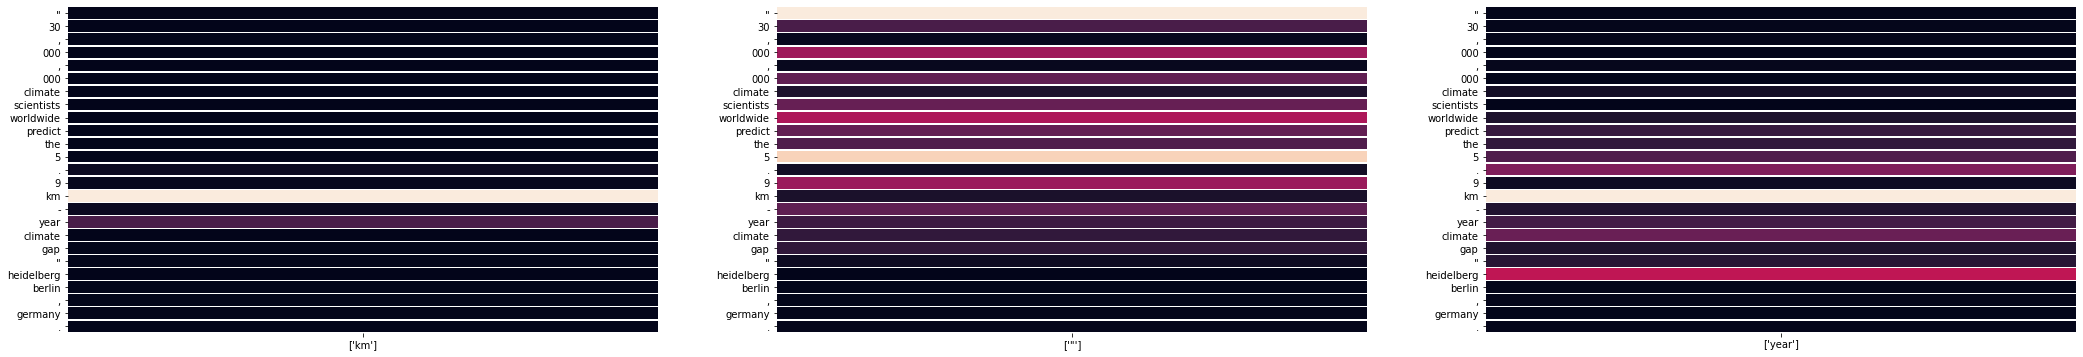


[ITERATION 122]
Current sentence: 	[CLS] " 30, 000, 000 climate scientists worldwide predict the 5. 9 km - year climate gap " heidelberg berlin, germany. [SEP]
Masked sentence: 	[CLS] " 30, 000, 000 climate scientists [MASK] predict the 5. 9 [MASK] - year climate gap " heidelberg berlin, germany. [SEP]
Predictions: 	"billion to million"


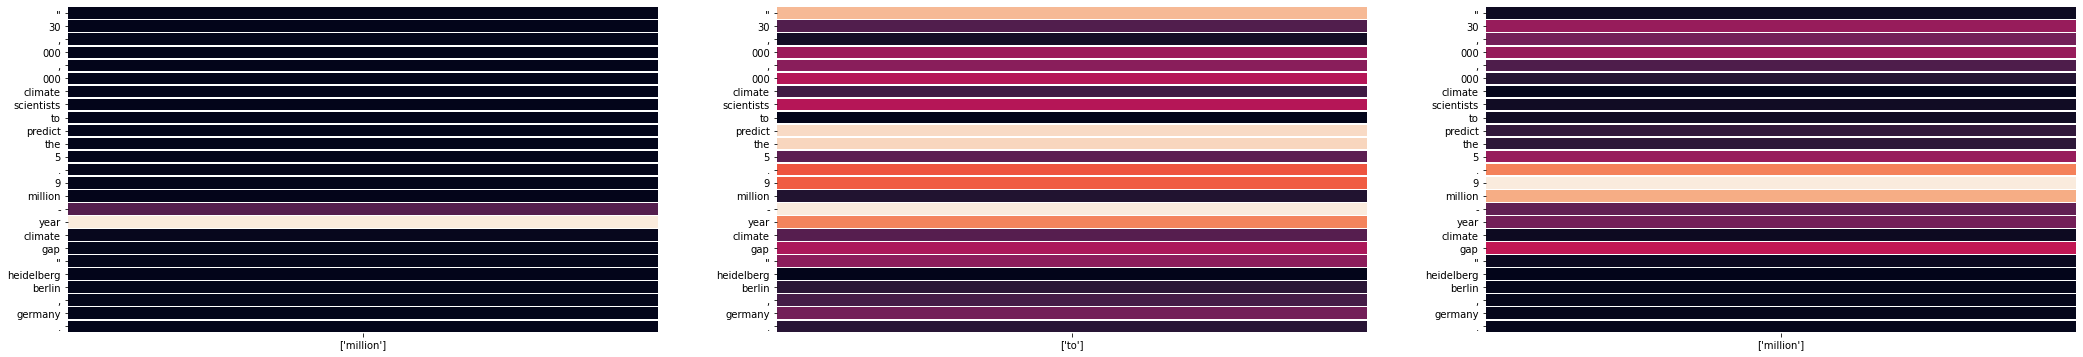


[ITERATION 123]
Current sentence: 	[CLS] " 30, 000, 000 climate scientists to predict the 5. 9 million - year climate gap " heidelberg berlin, germany. [SEP]
Masked sentence: 	[CLS] " 30 [MASK] [MASK], 000 climate scientists to predict the 5. 9 million [MASK] year climate gap " heidelberg berlin, germany. [SEP]
Predictions: 	"-, 000"


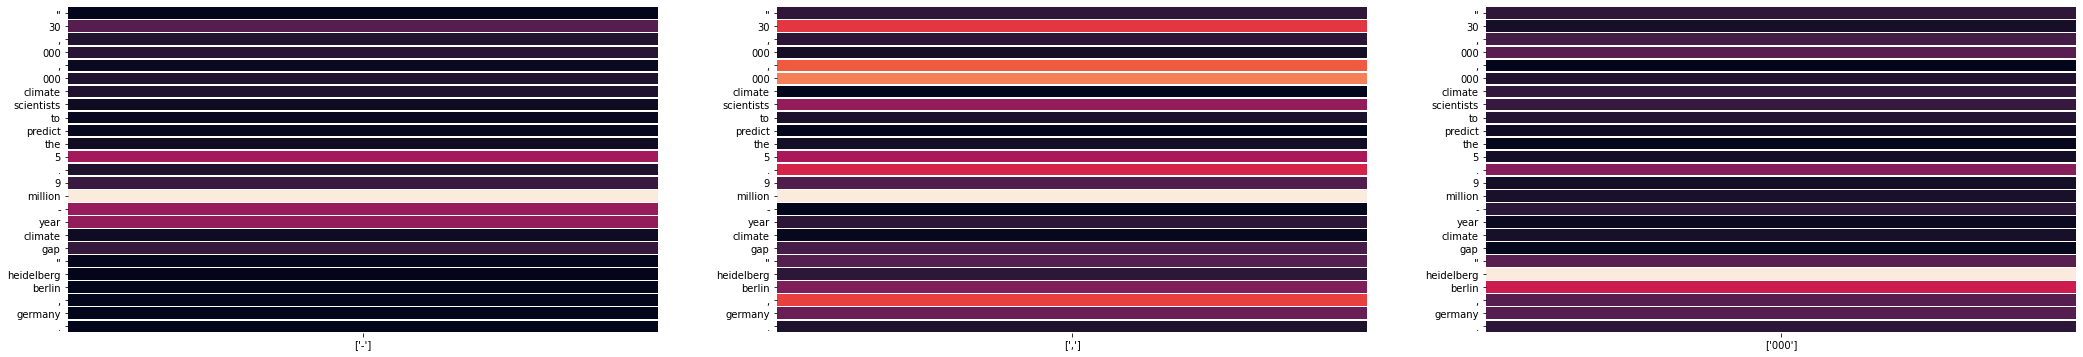


[ITERATION 124]
Current sentence: 	[CLS] " 30, 000, 000 climate scientists to predict the 5. 9 million - year climate gap " heidelberg berlin, germany. [SEP]
Masked sentence: 	[CLS] " 30 [MASK] 000, [MASK] climate scientists to predict the 5. 9 [MASK] - year climate gap " heidelberg berlin, germany. [SEP]
Predictions: 	"one 000,"


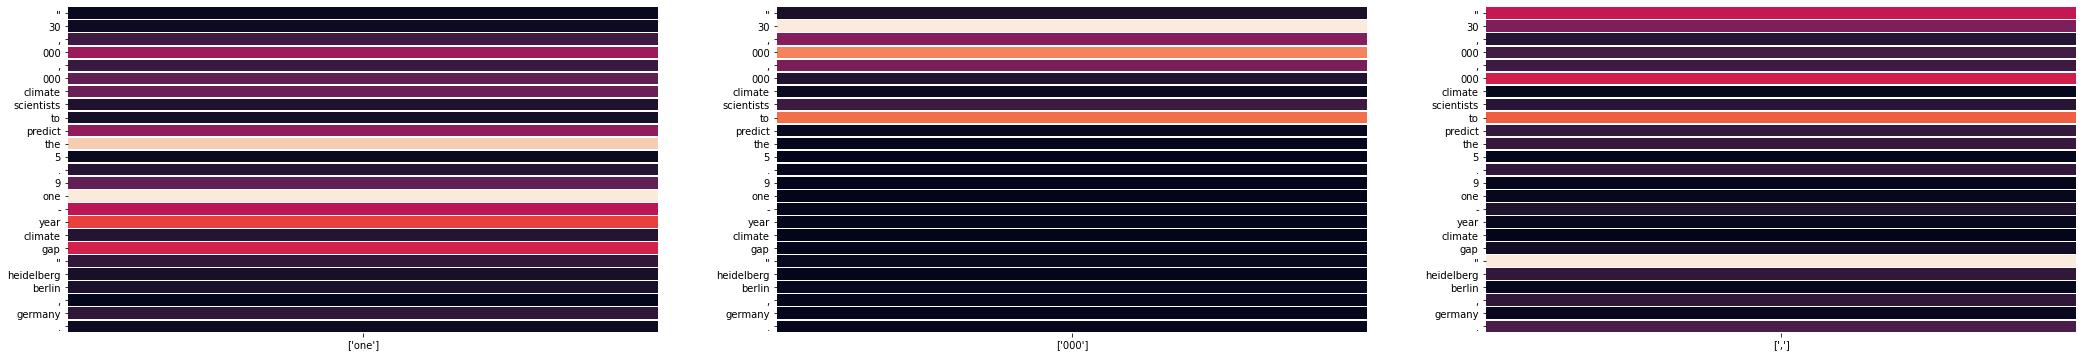


[ITERATION 125]
Current sentence: 	[CLS] " 30, 000, 000 climate scientists to predict the 5. 9 one - year climate gap " heidelberg berlin, germany. [SEP]
Masked sentence: 	[CLS] " [MASK], 000, [MASK] climate scientists to predict the 5. 9 one - year climate [MASK] " heidelberg berlin, germany. [SEP]
Predictions: 	"scale 10 000"


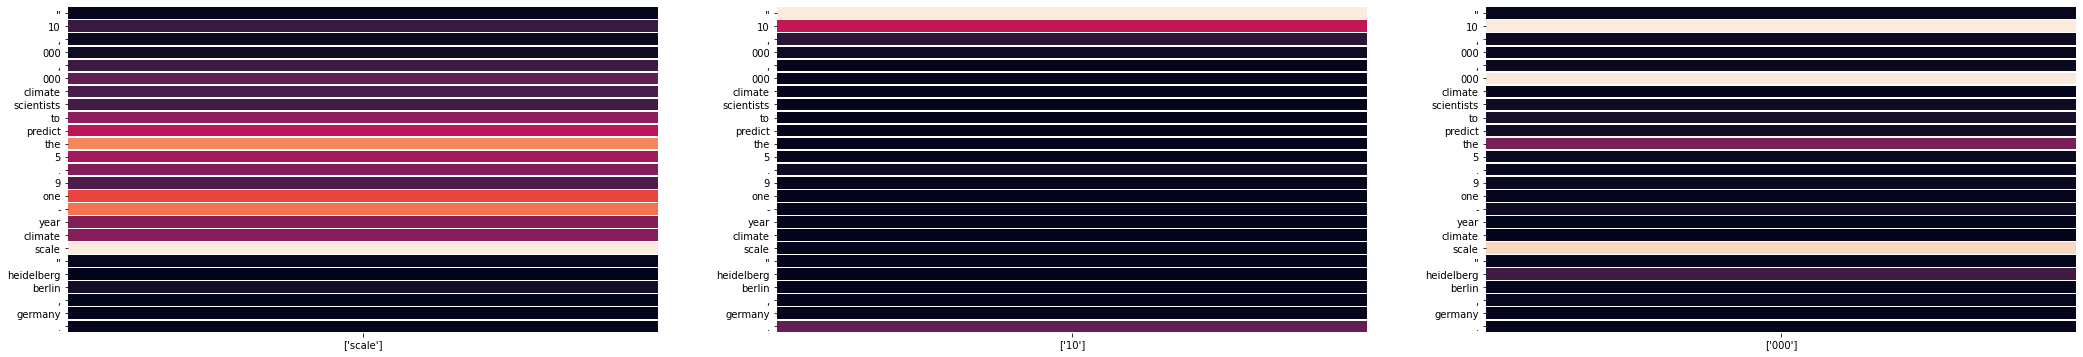


[ITERATION 126]
Current sentence: 	[CLS] " 10, 000, 000 climate scientists to predict the 5. 9 one - year climate scale " heidelberg berlin, germany. [SEP]
Masked sentence: 	[CLS] " 10, 000, [MASK] climate scientists to predict the 5. 9 one - year climate scale " heidelberg berlin, germany [MASK] [SEP]
Predictions: 	"000. 000"


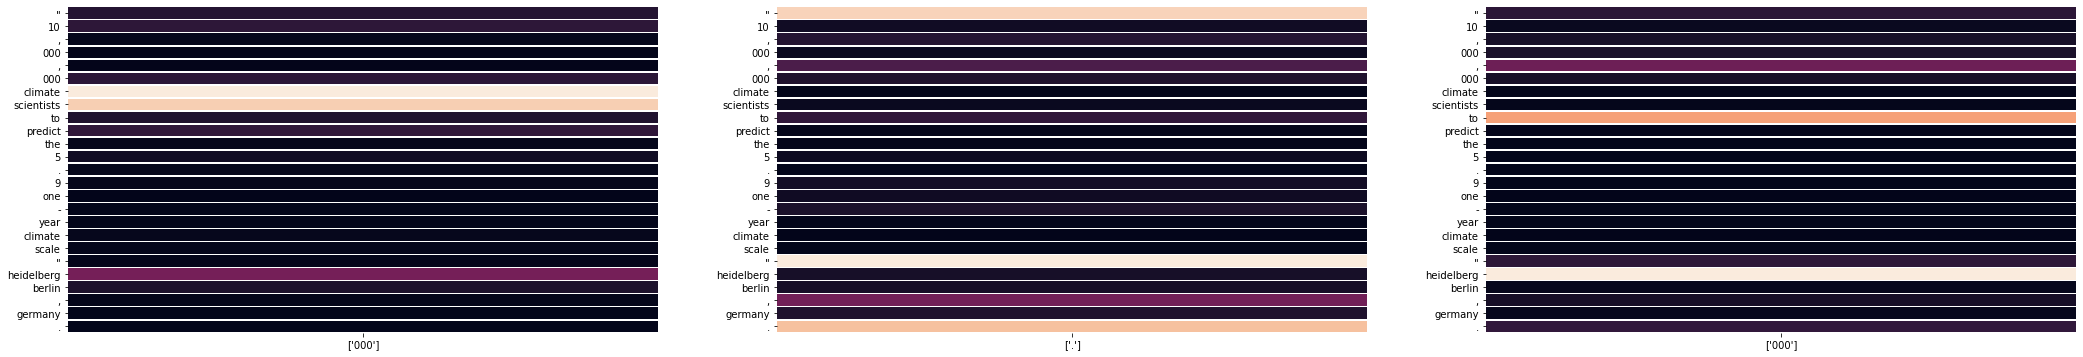


[ITERATION 127]
Current sentence: 	[CLS] " 10, 000, 000 climate scientists to predict the 5. 9 one - year climate scale " heidelberg berlin, germany. [SEP]
Masked sentence: 	[CLS] [MASK] 10, 000, 000 climate [MASK] to predict the 5. 9 one - year climate scale " [MASK] berlin, germany. [SEP]
Predictions: 	"models "."


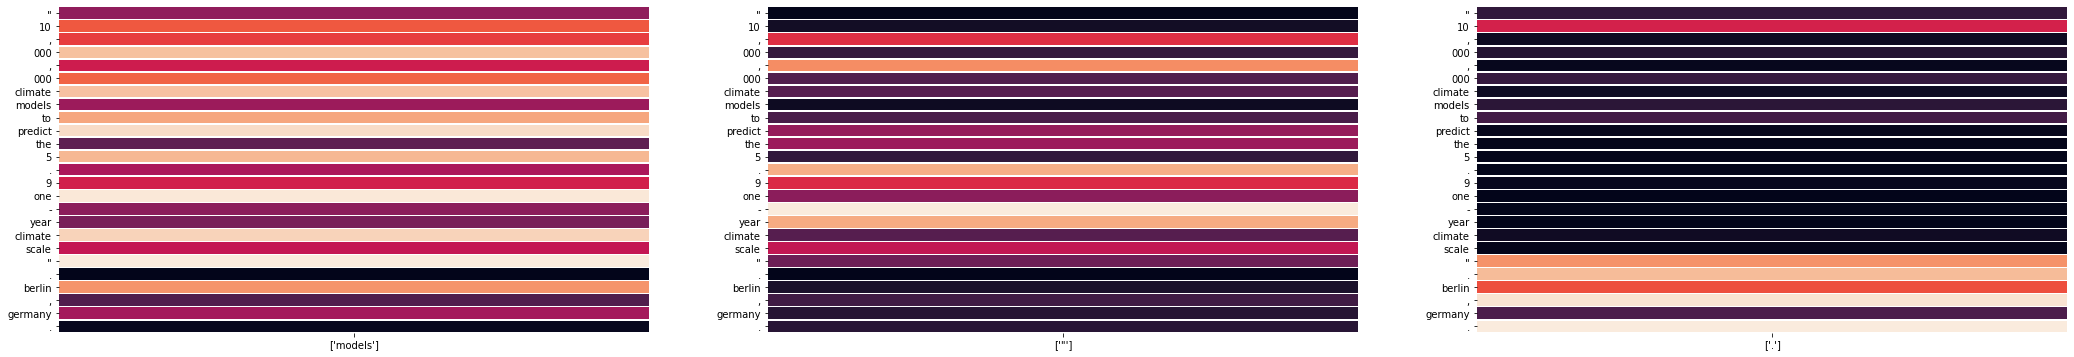


[ITERATION 128]
Current sentence: 	[CLS] " 10, 000, 000 climate models to predict the 5. 9 one - year climate scale ". berlin, germany. [SEP]
Masked sentence: 	[CLS] " 10, 000, 000 [MASK] models [MASK] predict the 5. 9 one - year climate scale ". [MASK], germany. [SEP]
Predictions: 	"that climate cologne"


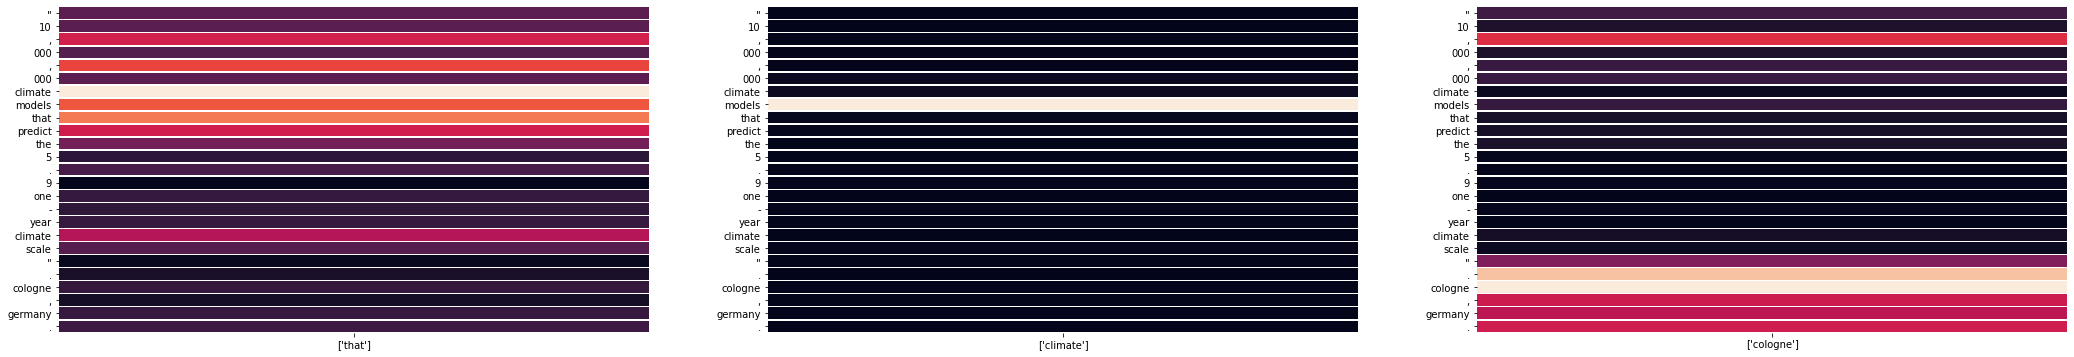


[ITERATION 129]
Current sentence: 	[CLS] " 10, 000, 000 climate models that predict the 5. 9 one - year climate scale ". cologne, germany. [SEP]
Masked sentence: 	[CLS] " 10, 000, 000 climate [MASK] that predict the 5. 9 one - year climate [MASK] " [MASK] cologne, germany. [SEP]
Predictions: 	"change variables."


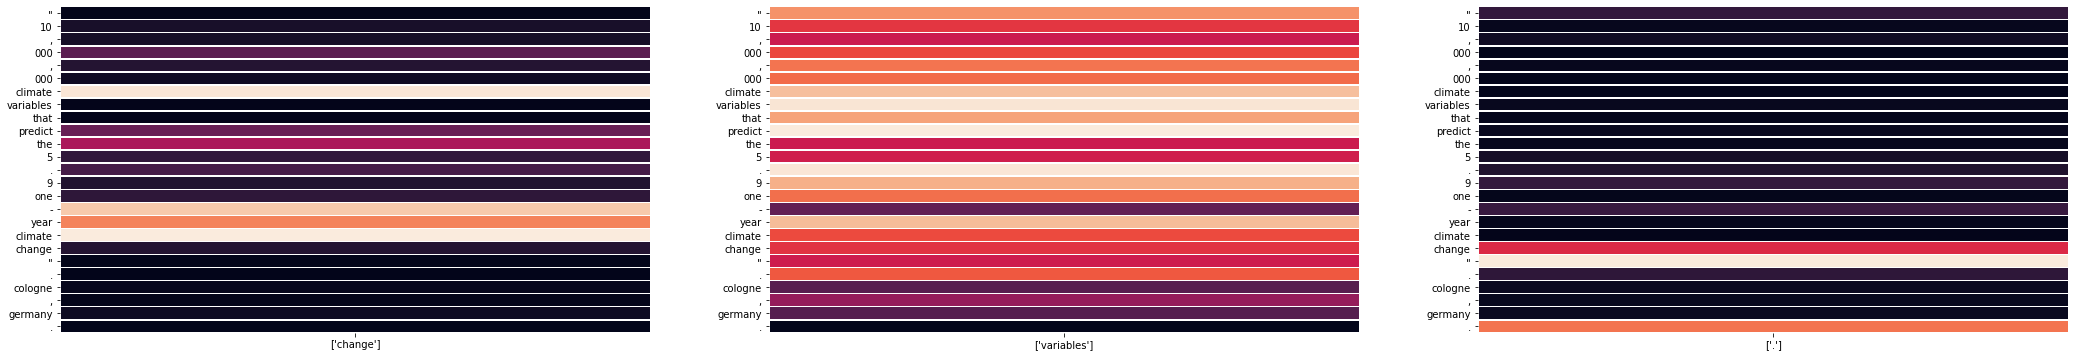


[ITERATION 130]
Current sentence: 	[CLS] " 10, 000, 000 climate variables that predict the 5. 9 one - year climate change ". cologne, germany. [SEP]
Masked sentence: 	[CLS] " 10, 000, 000 [MASK] variables that predict the 5. 9 one - year climate change ". cologne [MASK] germany [MASK] [SEP]
Predictions: 	"climate,."


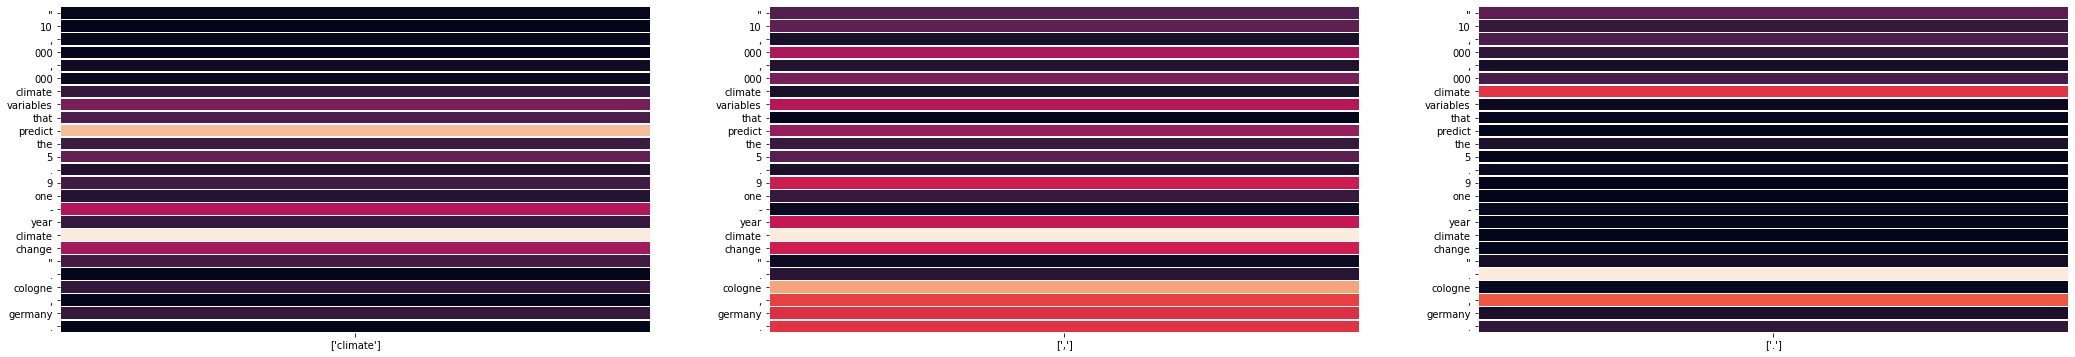


[ITERATION 131]
Current sentence: 	[CLS] " 10, 000, 000 climate variables that predict the 5. 9 one - year climate change ". cologne, germany. [SEP]
Masked sentence: 	[CLS] " 10, 000, 000 climate variables that predict the [MASK]. [MASK] one - year climate change " [MASK] cologne, germany. [SEP]
Predictions: 	"future for."


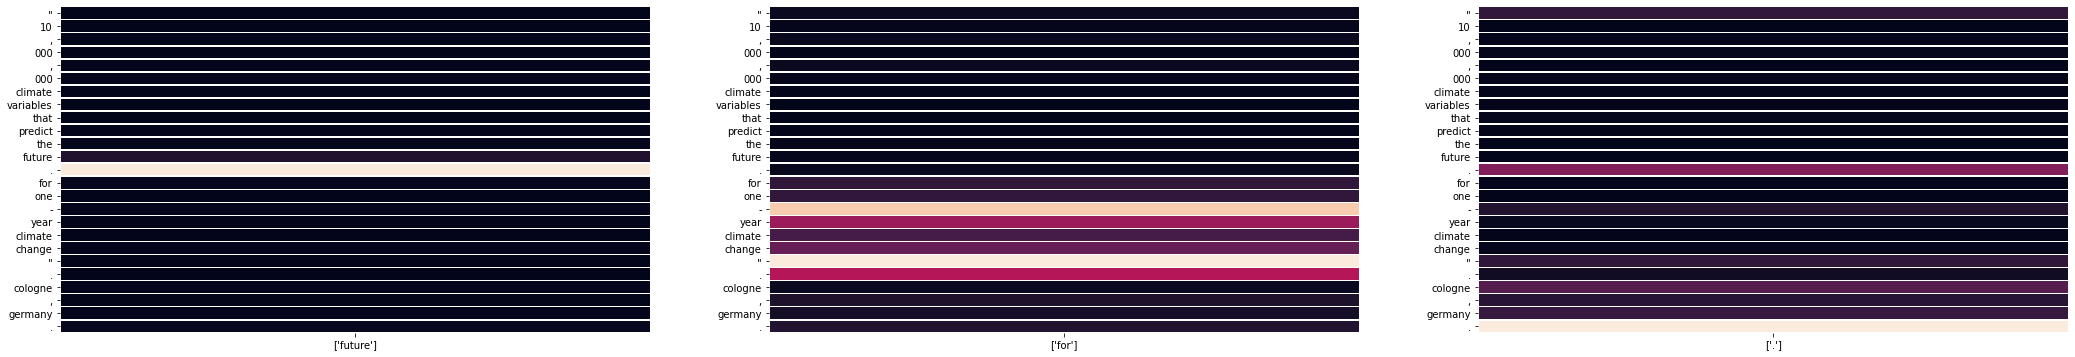


[ITERATION 132]
Current sentence: 	[CLS] " 10, 000, 000 climate variables that predict the future. for one - year climate change ". cologne, germany. [SEP]
Masked sentence: 	[CLS] " 10, 000, 000 climate variables that predict the future [MASK] for one [MASK] year climate change ". cologne, germany [MASK] [SEP]
Predictions: 	"timeline -."


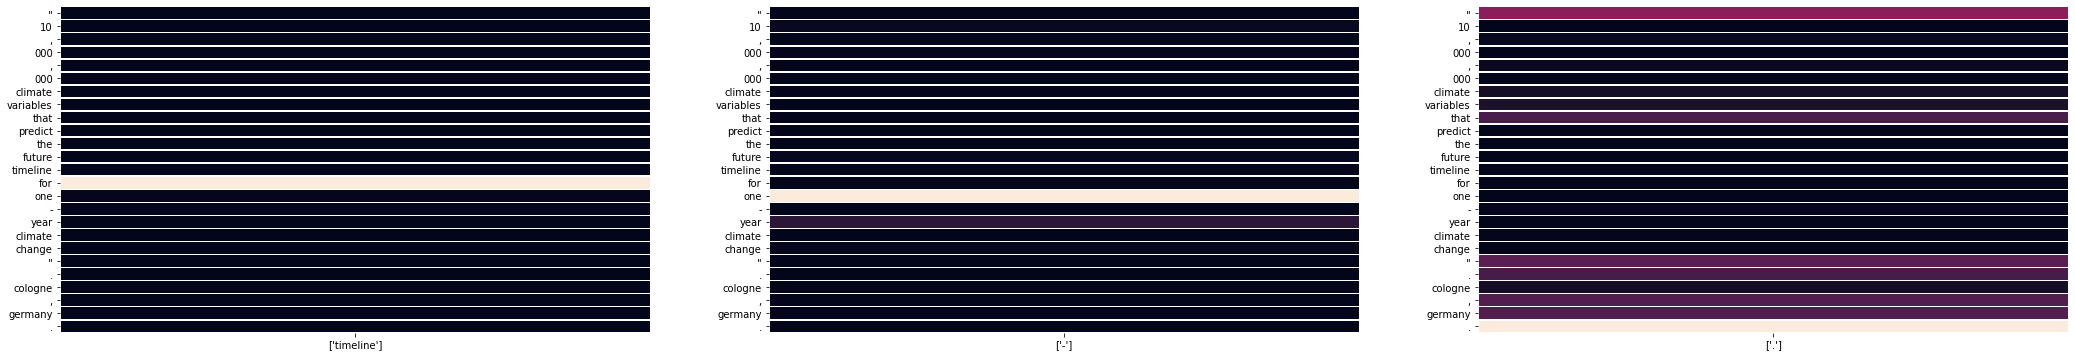


[ITERATION 133]
Current sentence: 	[CLS] " 10, 000, 000 climate variables that predict the future timeline for one - year climate change ". cologne, germany. [SEP]
Masked sentence: 	[CLS] " 10 [MASK] 000, 000 climate variables that predict the future timeline [MASK] [MASK] - year climate change ". cologne, germany. [SEP]
Predictions: 	"of 40,"


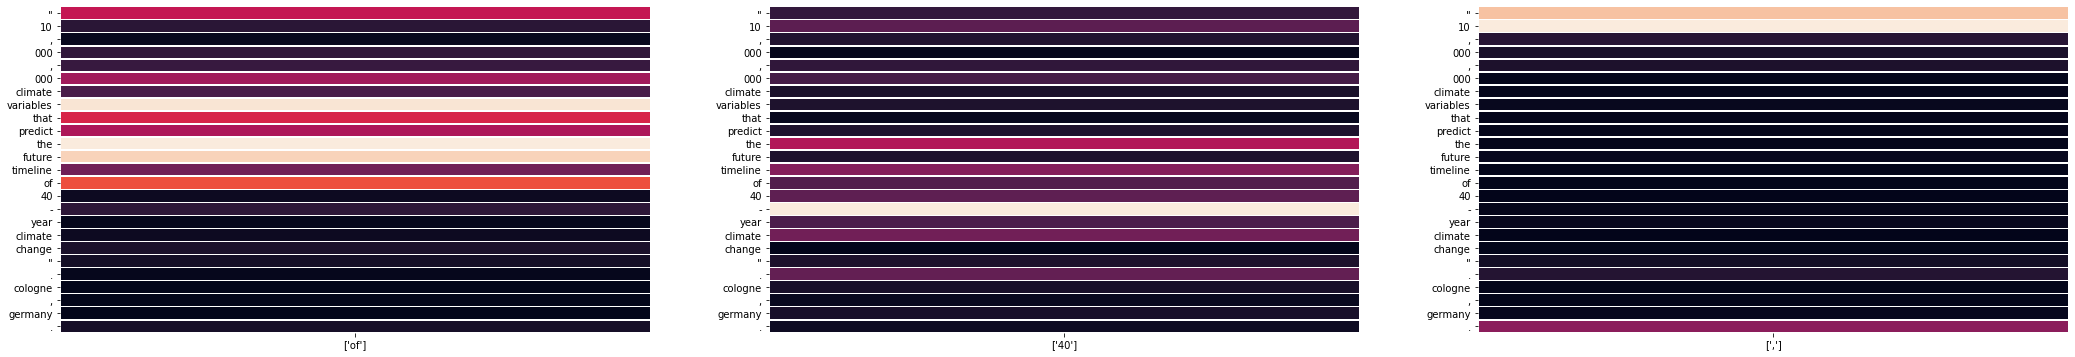


[ITERATION 134]
Current sentence: 	[CLS] " 10, 000, 000 climate variables that predict the future timeline of 40 - year climate change ". cologne, germany. [SEP]
Masked sentence: 	[CLS] " 10, [MASK] [MASK] 000 climate variables that predict the future [MASK] of 40 - year climate change ". cologne, germany. [SEP]
Predictions: 	", risk 000"


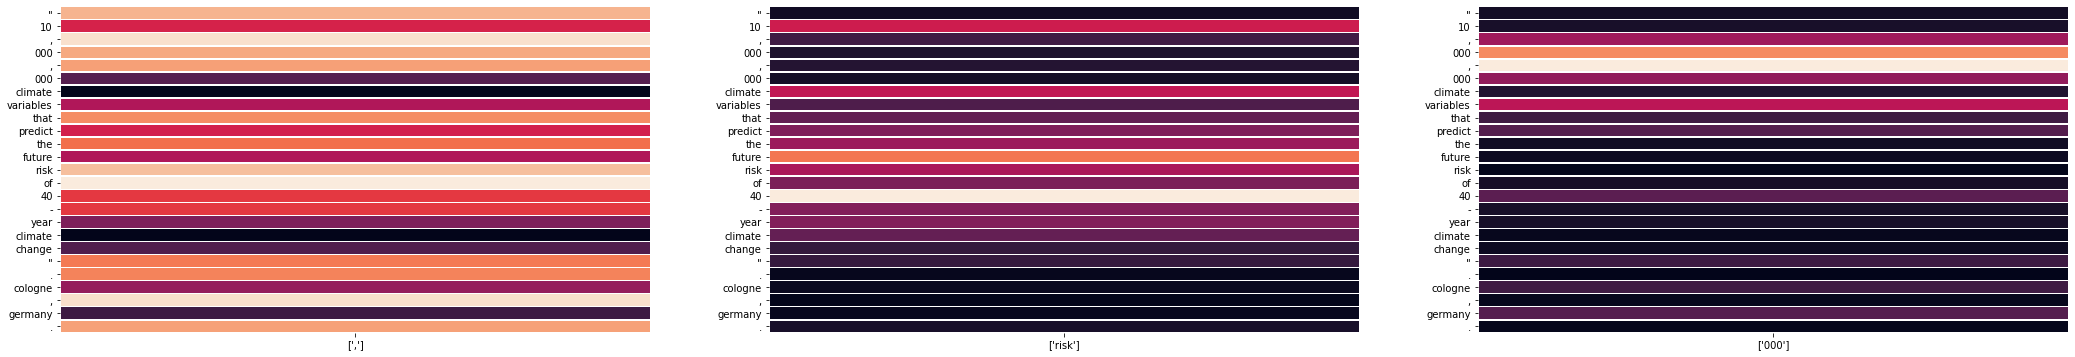


[ITERATION 135]
Current sentence: 	[CLS] " 10, 000, 000 climate variables that predict the future risk of 40 - year climate change ". cologne, germany. [SEP]
Masked sentence: 	[CLS] " 10, 000, 000 climate variables [MASK] [MASK] the future risk of 40 - year climate change [MASK]. cologne, germany. [SEP]
Predictions: 	"" weigh affect"


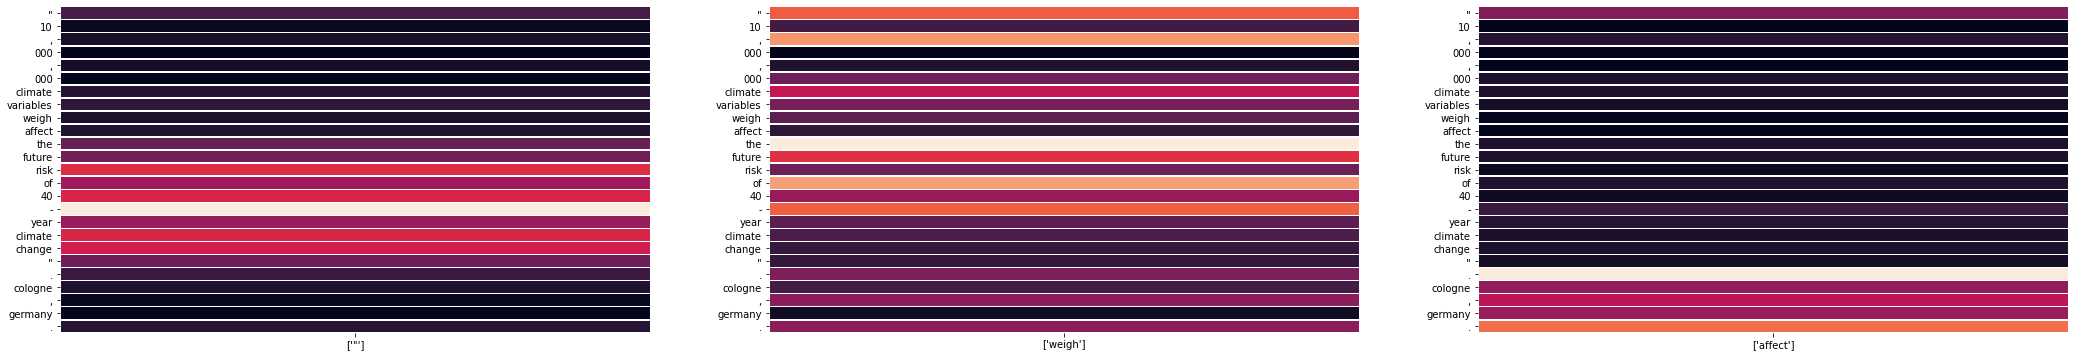


[ITERATION 136]
Current sentence: 	[CLS] " 10, 000, 000 climate variables weigh affect the future risk of 40 - year climate change ". cologne, germany. [SEP]
Masked sentence: 	[CLS] " 10, 000, 000 climate variables weigh affect the future [MASK] of 40 [MASK] year climate change ". [MASK], germany. [SEP]
Predictions: 	"- risk frankfurt"


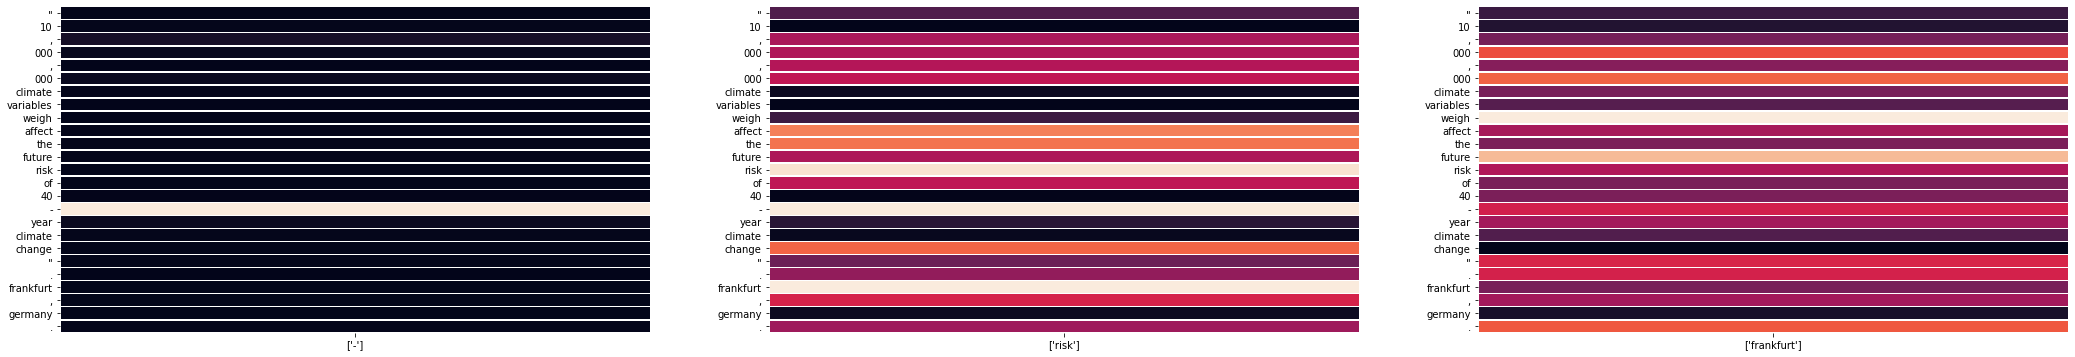


[ITERATION 137]
Current sentence: 	[CLS] " 10, 000, 000 climate variables weigh affect the future risk of 40 - year climate change ". frankfurt, germany. [SEP]
Masked sentence: 	[CLS] " 10 [MASK] 000, 000 climate variables weigh [MASK] the future risk of 40 - year climate change ". frankfurt [MASK] germany. [SEP]
Predictions: 	", out,"


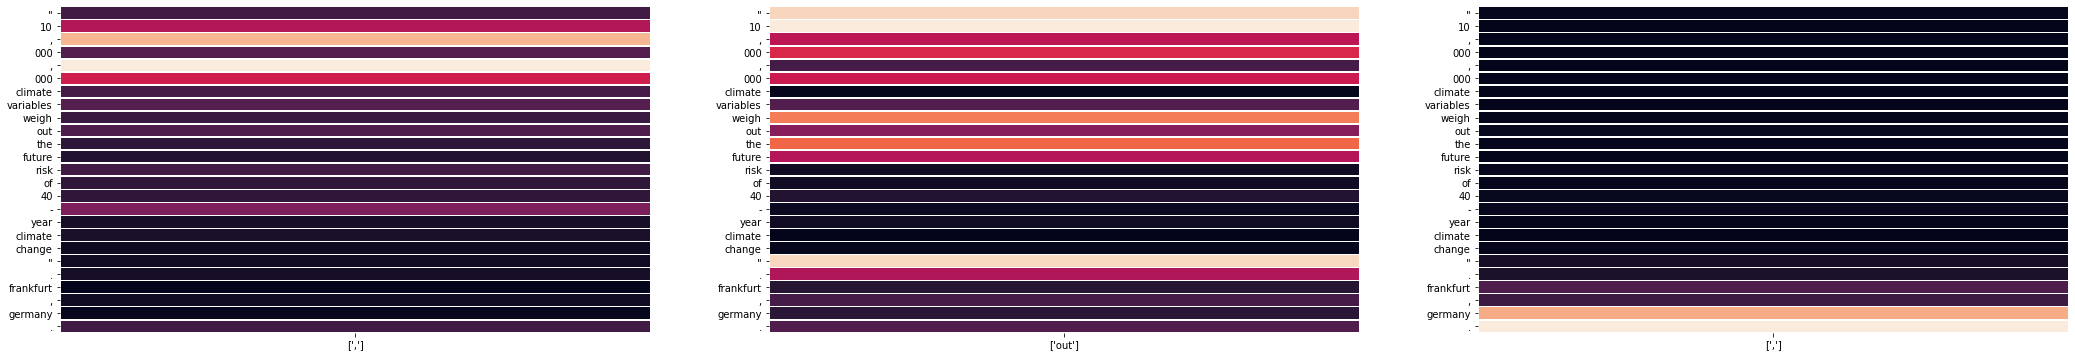


[ITERATION 138]
Current sentence: 	[CLS] " 10, 000, 000 climate variables weigh out the future risk of 40 - year climate change ". frankfurt, germany. [SEP]
Masked sentence: 	[CLS] [MASK] 10, [MASK], 000 climate variables weigh out the future risk of 40 - year climate change ". frankfurt, germany [MASK] [SEP]
Predictions: 	"" 000."


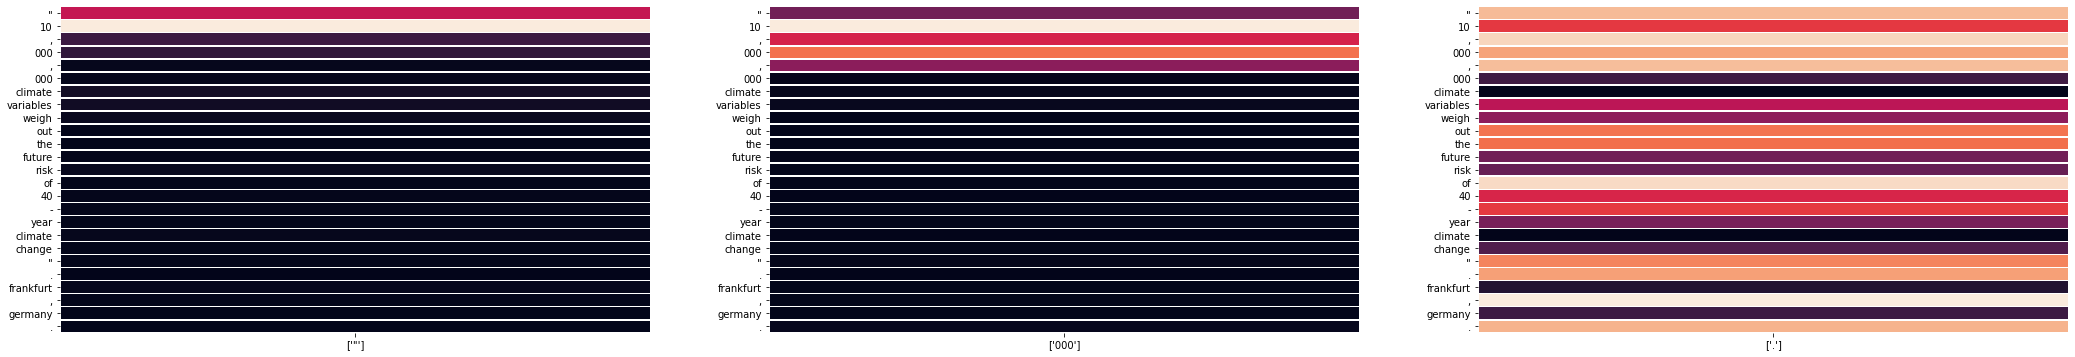


[ITERATION 139]
Current sentence: 	[CLS] " 10, 000, 000 climate variables weigh out the future risk of 40 - year climate change ". frankfurt, germany. [SEP]
Masked sentence: 	[CLS] [MASK] [MASK], 000, 000 climate variables weigh out the future risk of 40 - year climate change " [MASK] frankfurt, germany. [SEP]
Predictions: 	"10 " :"


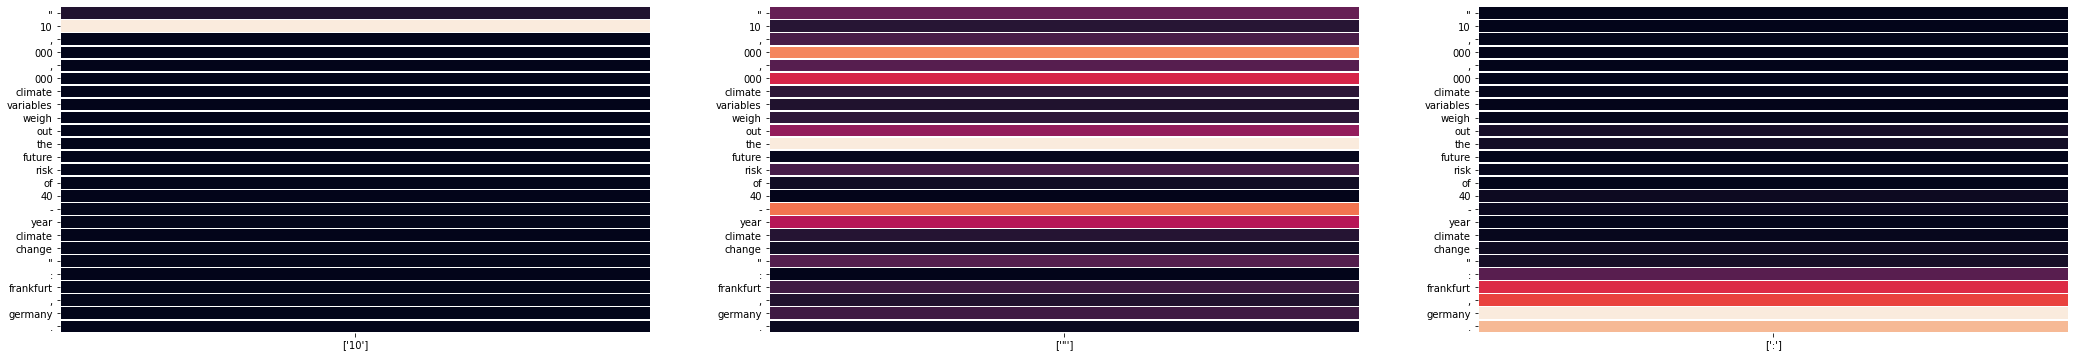


[ITERATION 140]
Current sentence: 	[CLS] " 10, 000, 000 climate variables weigh out the future risk of 40 - year climate change " : frankfurt, germany. [SEP]
Masked sentence: 	[CLS] " [MASK], 000, 000 climate variables weigh out the future risk of 40 - year climate change " : [MASK], germany. [SEP]
Predictions: 	"10 100 frankfurt"


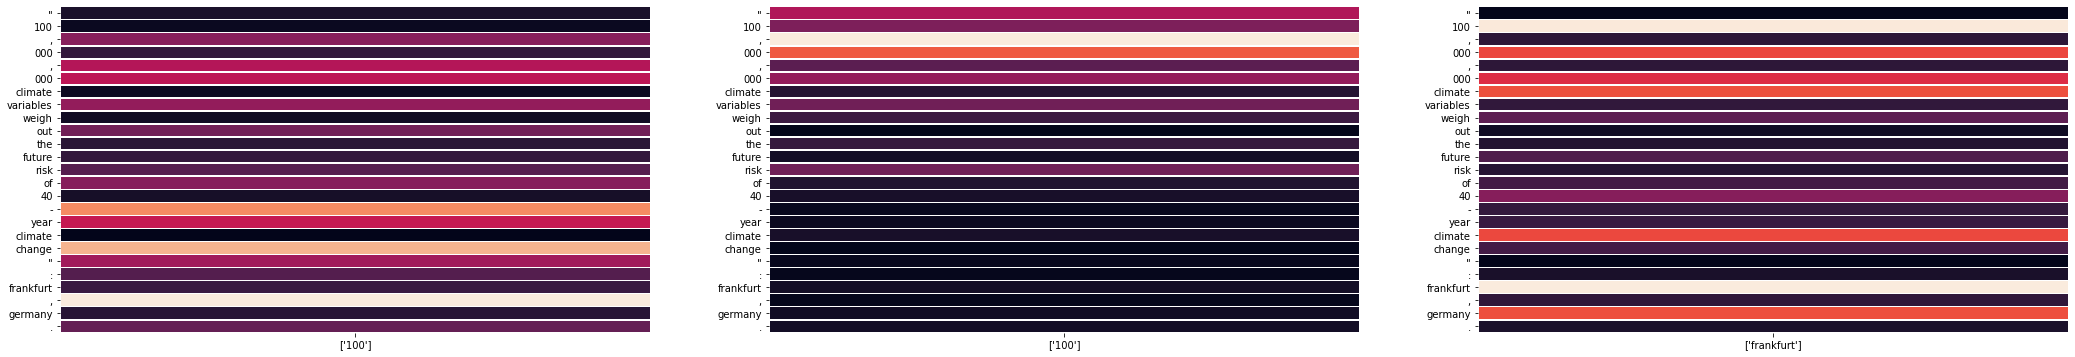


[ITERATION 141]
Current sentence: 	[CLS] " 100, 000, 000 climate variables weigh out the future risk of 40 - year climate change " : frankfurt, germany. [SEP]
Masked sentence: 	[CLS] " 100 [MASK] [MASK], 000 climate variables weigh out the future risk [MASK] 40 - year climate change " : frankfurt, germany. [SEP]
Predictions: 	"under +6"


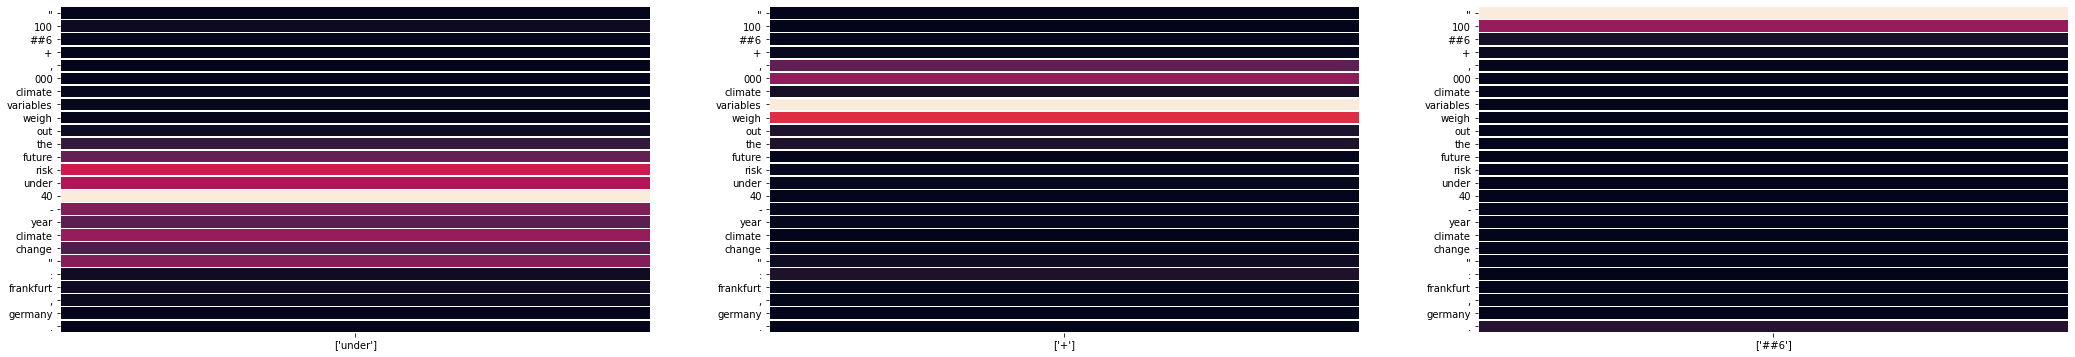


[ITERATION 142]
Current sentence: 	[CLS] " 1006 +, 000 climate variables weigh out the future risk under 40 - year climate change " : frankfurt, germany. [SEP]
Masked sentence: 	[CLS] [MASK] 1006 +, 000 climate [MASK] weigh out the future risk under [MASK] - year climate change " : frankfurt, germany. [SEP]
Predictions: 	"20 scientists ""


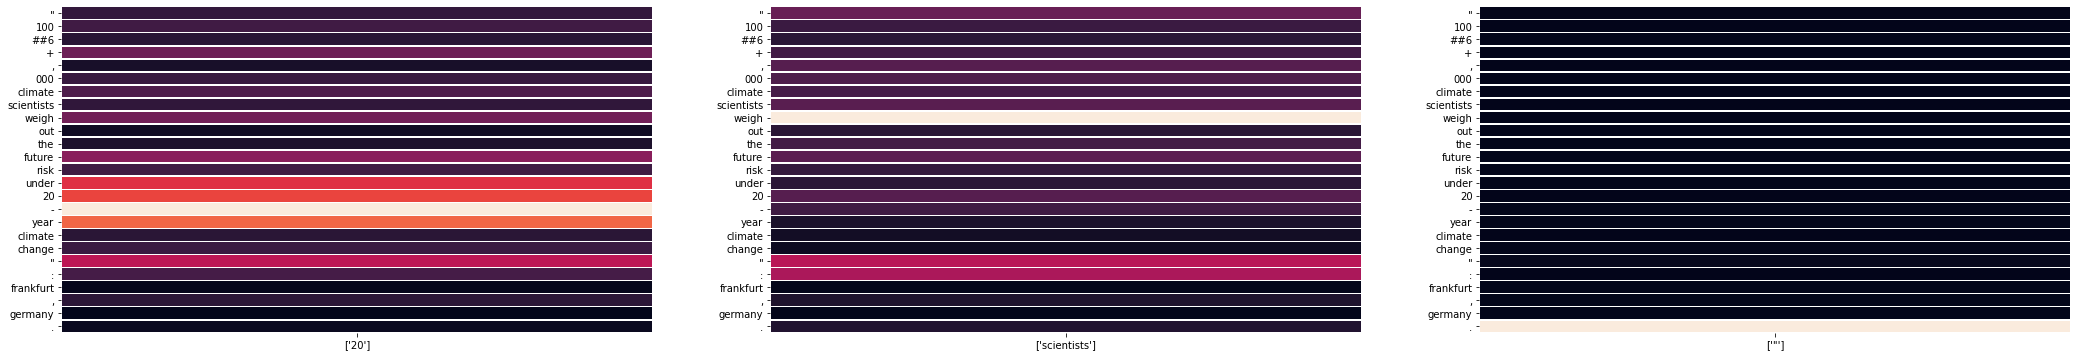


[ITERATION 143]
Current sentence: 	[CLS] " 1006 +, 000 climate scientists weigh out the future risk under 20 - year climate change " : frankfurt, germany. [SEP]
Masked sentence: 	[CLS] " 1006 +, 000 climate scientists weigh out the future risk under 20 - year climate change [MASK] : frankfurt, germany [MASK] [SEP]
Predictions: 	". "."


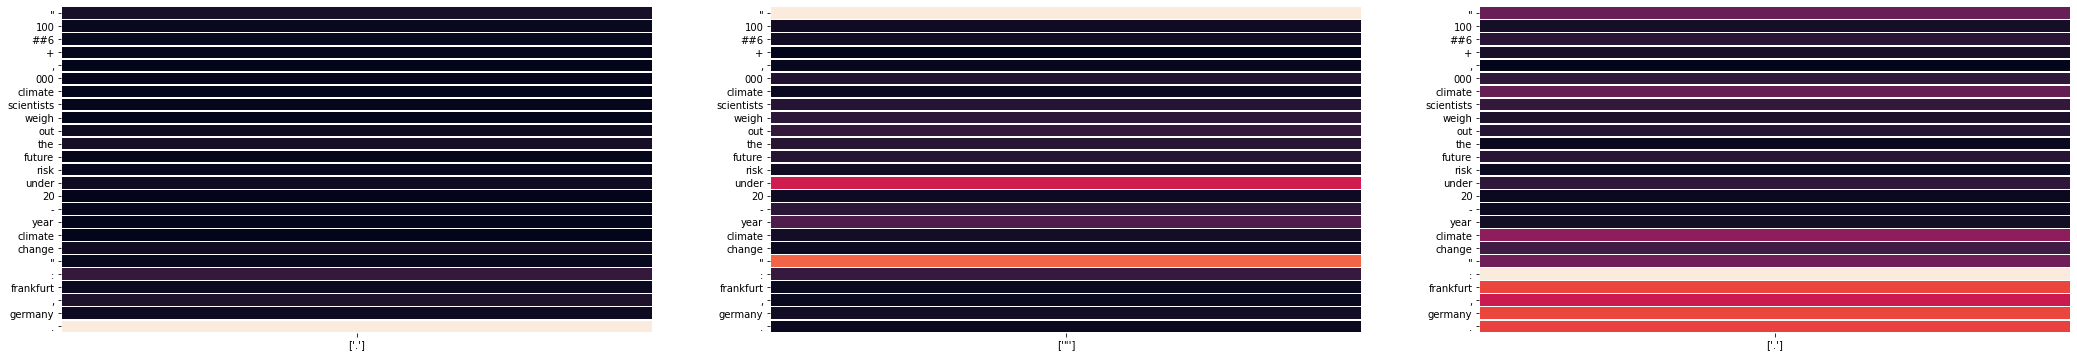


[ITERATION 144]
Current sentence: 	[CLS] " 1006 +, 000 climate scientists weigh out the future risk under 20 - year climate change " : frankfurt, germany. [SEP]
Masked sentence: 	[CLS] " 1006 +, 000 climate scientists weigh out the future risk under 20 - year climate change " : [MASK], germany [MASK] [SEP]
Predictions: 	";. stuttgart"


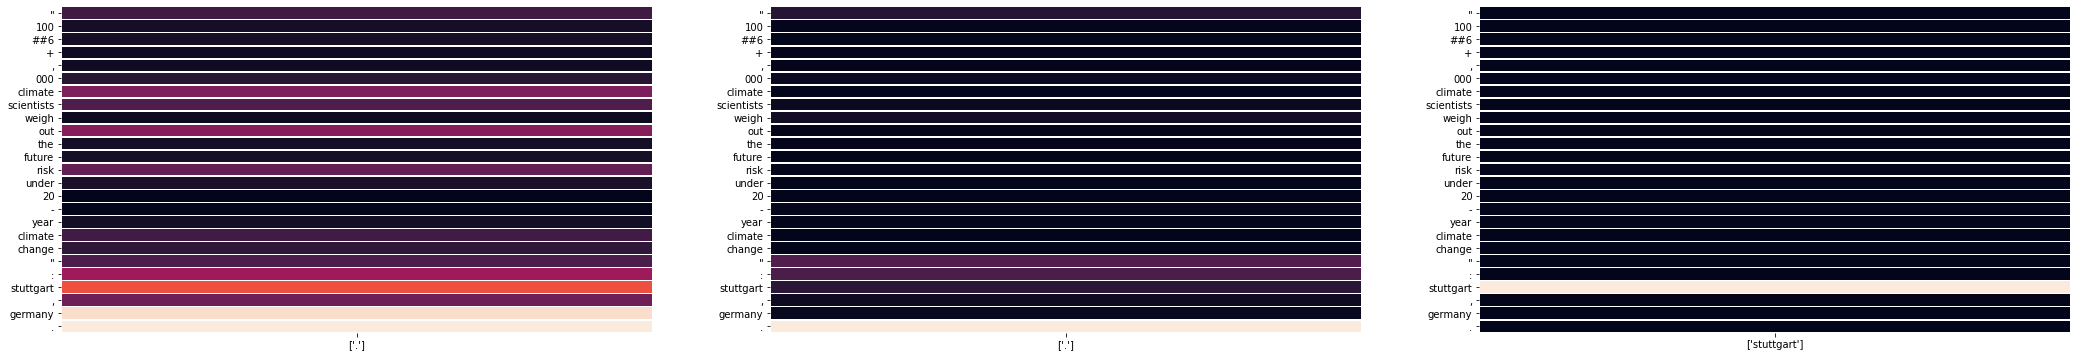


[ITERATION 145]
Current sentence: 	[CLS] " 1006 +, 000 climate scientists weigh out the future risk under 20 - year climate change " : stuttgart, germany. [SEP]
Masked sentence: 	[CLS] " 1006 +, 000 climate scientists weigh out the future risk under 20 - year climate change [MASK] : [MASK], [MASK]. [SEP]
Predictions: 	"march " nature"


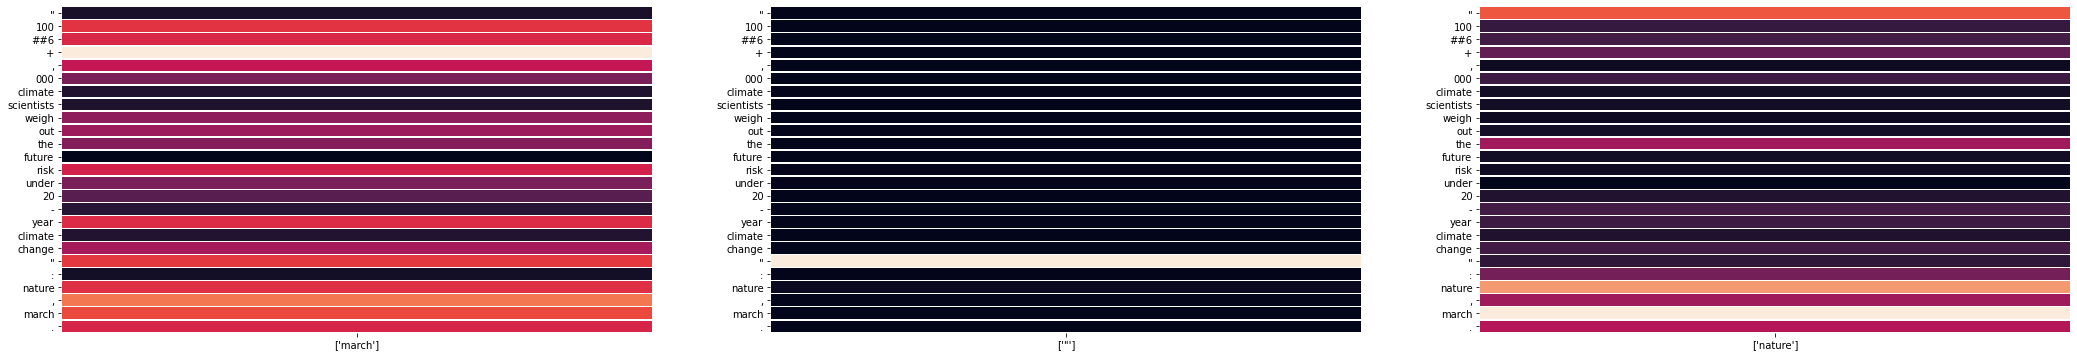


[ITERATION 146]
Current sentence: 	[CLS] " 1006 +, 000 climate scientists weigh out the future risk under 20 - year climate change " : nature, march. [SEP]
Masked sentence: 	[CLS] " 100 [MASK] +, 000 climate scientists weigh out the future risk under 20 - year climate change [MASK] [MASK] nature, march. [SEP]
Predictions: 	"##3 ","


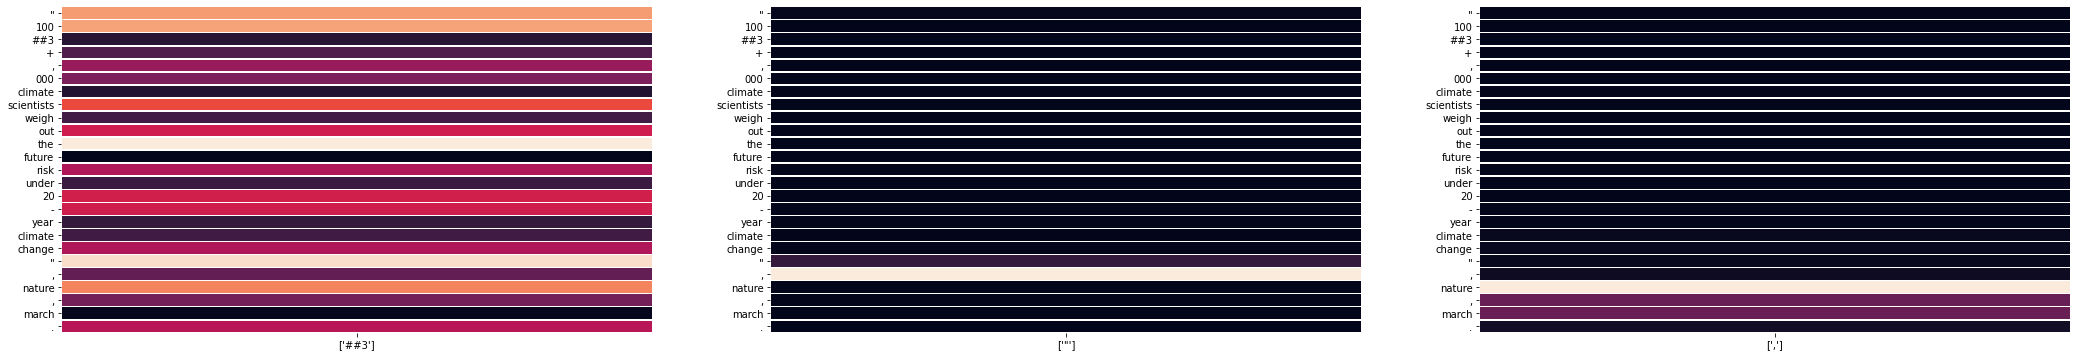


[ITERATION 147]
Current sentence: 	[CLS] " 1003 +, 000 climate scientists weigh out the future risk under 20 - year climate change ", nature, march. [SEP]
Masked sentence: 	[CLS] " 1003 +, 000 climate [MASK] weigh out the future risk under 20 - year climate change [MASK], [MASK], march. [SEP]
Predictions: 	"scientists " nature"


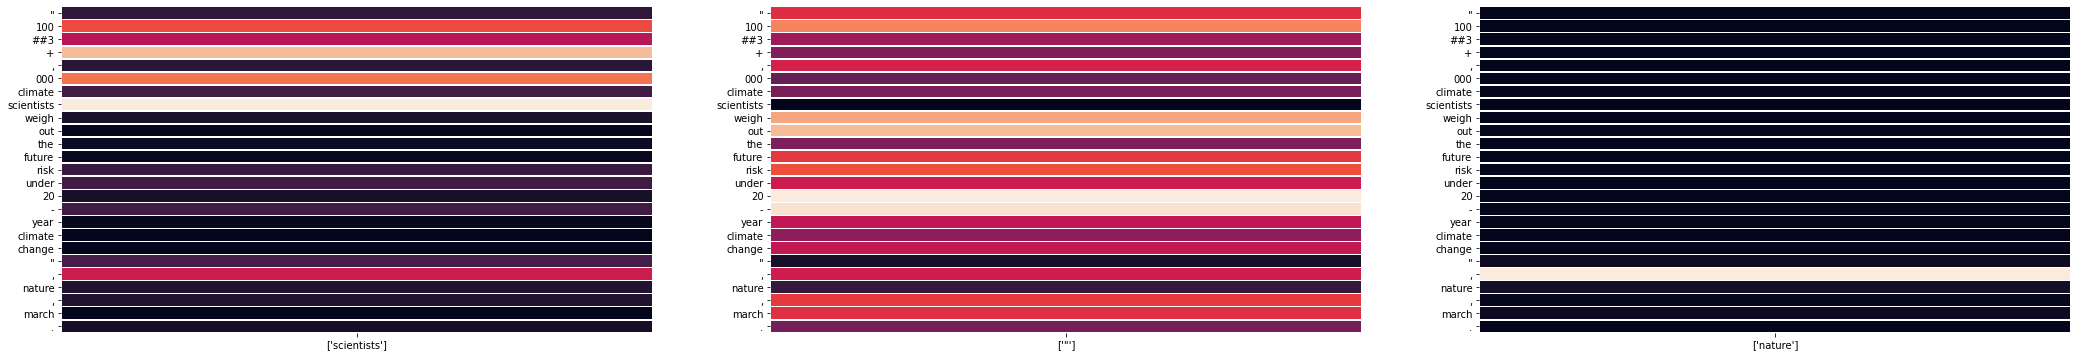


[ITERATION 148]
Current sentence: 	[CLS] " 1003 +, 000 climate scientists weigh out the future risk under 20 - year climate change ", nature, march. [SEP]
Masked sentence: 	[CLS] " 100 [MASK] +, [MASK] climate scientists weigh out the future risk under 20 - year climate change " [MASK] nature, march. [SEP]
Predictions: 	"where %,"


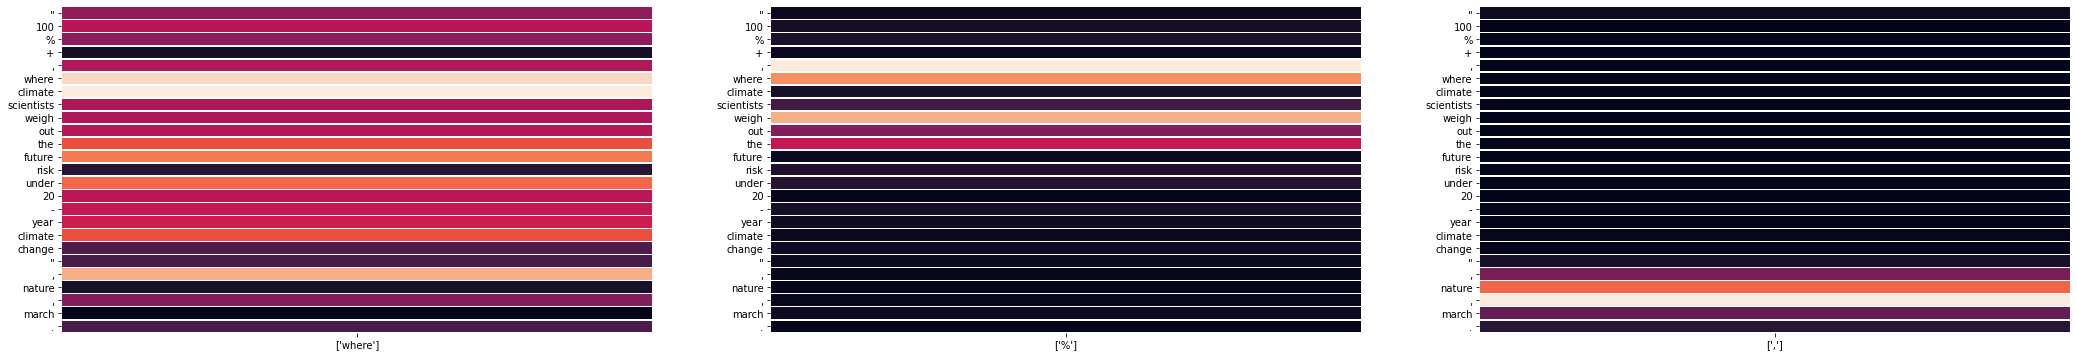


[ITERATION 149]
Current sentence: 	[CLS] " 100 % +, where climate scientists weigh out the future risk under 20 - year climate change ", nature, march. [SEP]
Masked sentence: 	[CLS] " 100 % + [MASK] [MASK] climate scientists weigh out the future risk under 20 - year climate change ", nature, march [MASK] [SEP]
Predictions: 	": how."


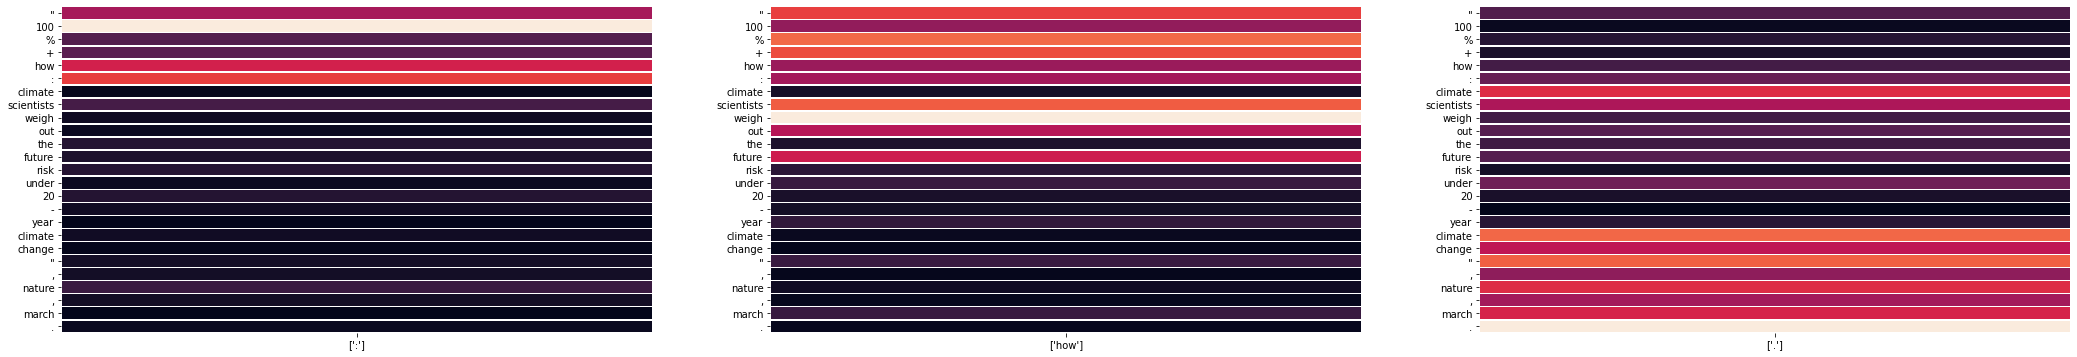


[ITERATION 150]
Current sentence: 	[CLS] " 100 % + how : climate scientists weigh out the future risk under 20 - year climate change ", nature, march. [SEP]
Masked sentence: 	[CLS] " 100 % [MASK] how [MASK] climate [MASK] weigh out the future risk under 20 - year climate change ", nature, march. [SEP]
Predictions: 	"of canadian scientists"


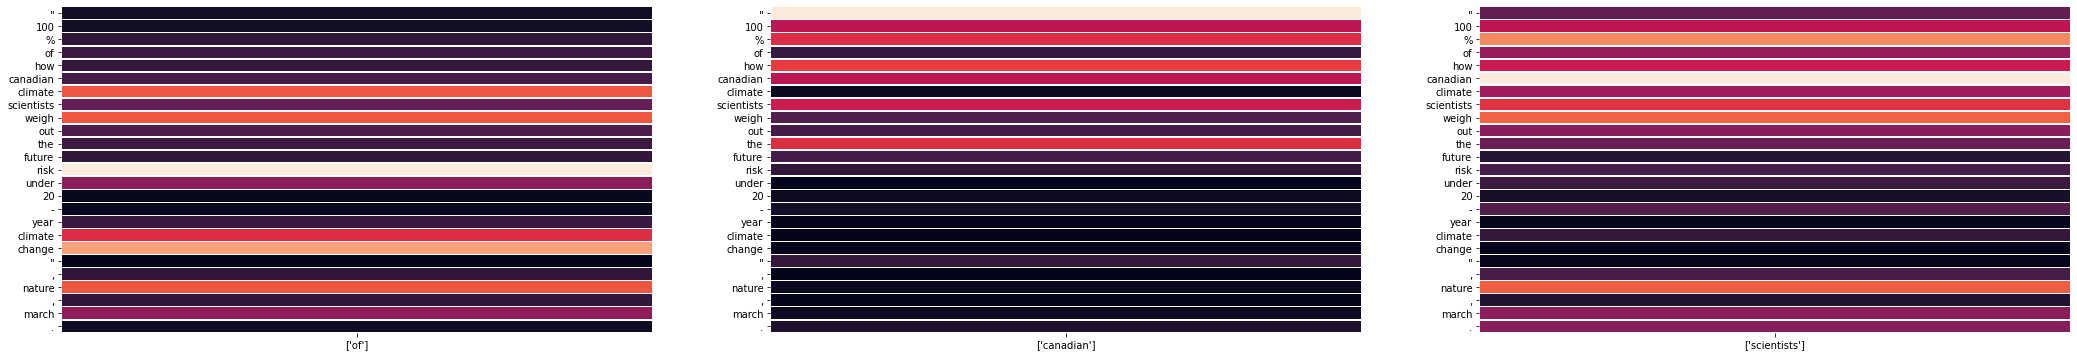


[ITERATION 151]
Current sentence: 	[CLS] " 100 % of how canadian climate scientists weigh out the future risk under 20 - year climate change ", nature, march. [SEP]
Masked sentence: 	[CLS] " [MASK] % of how [MASK] climate scientists [MASK] out the future risk under 20 - year climate change ", nature, march. [SEP]
Predictions: 	"figure young 80"


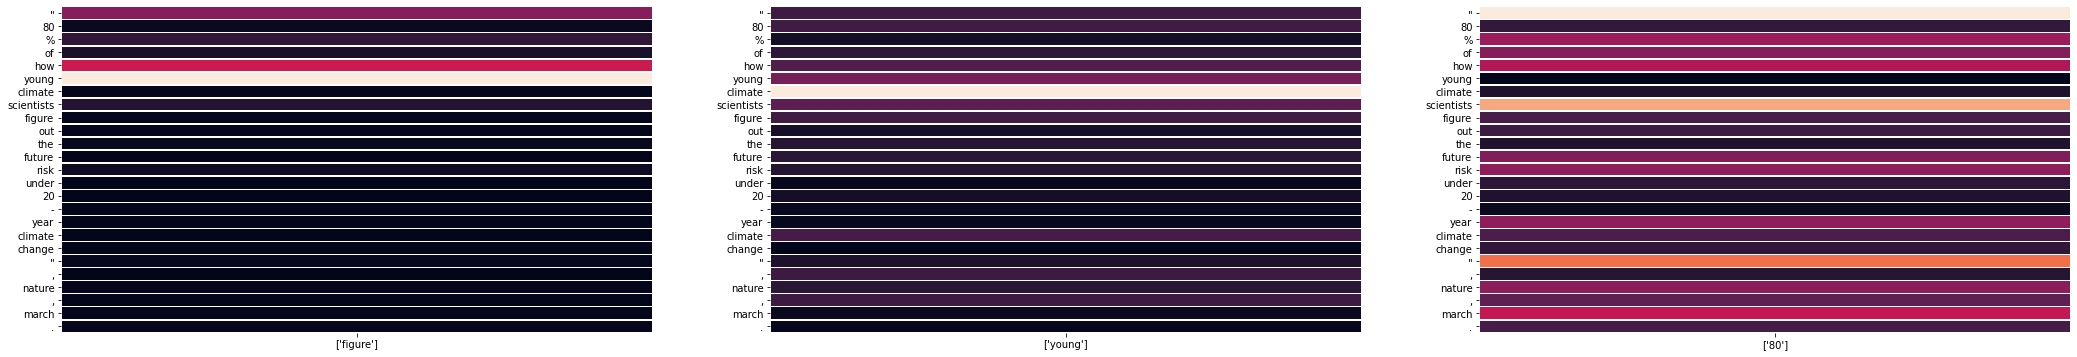


[ITERATION 152]
Current sentence: 	[CLS] " 80 % of how young climate scientists figure out the future risk under 20 - year climate change ", nature, march. [SEP]
Masked sentence: 	[CLS] " 80 % of [MASK] young climate [MASK] figure out the future risk under 20 - year climate change ", nature, march. [SEP]
Predictions: 	"norwegian scientists the"


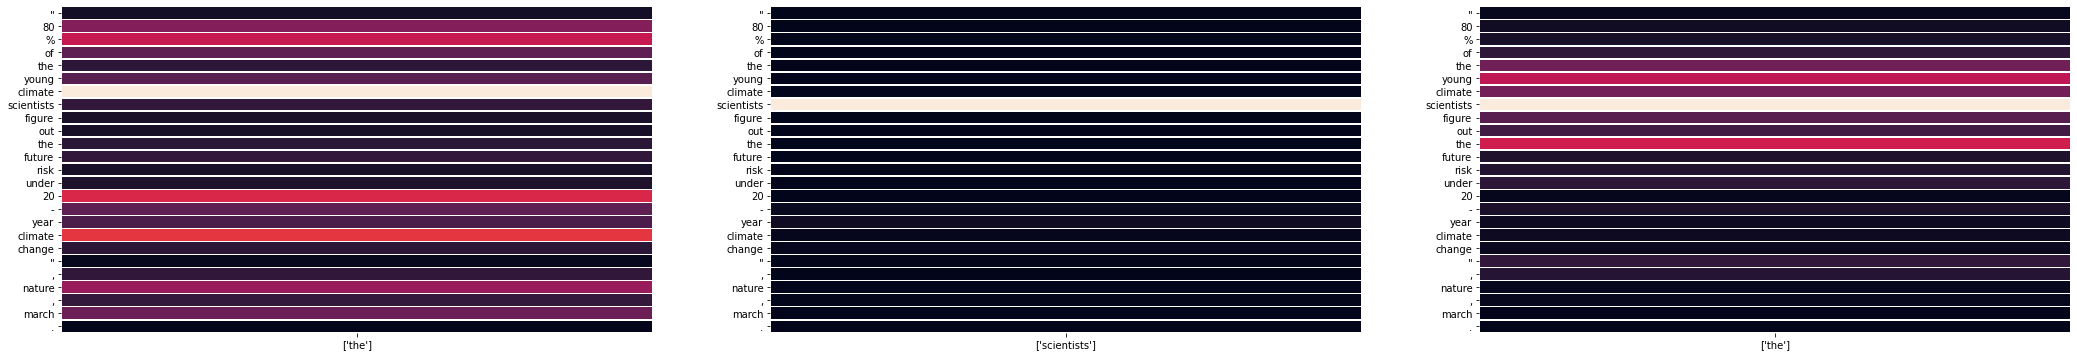


[ITERATION 153]
Current sentence: 	[CLS] " 80 % of the young climate scientists figure out the future risk under 20 - year climate change ", nature, march. [SEP]
Masked sentence: 	[CLS] " [MASK] % of the young climate [MASK] [MASK] out the future risk under 20 - year climate change ", nature, march. [SEP]
Predictions: 	"64 scientists figure"


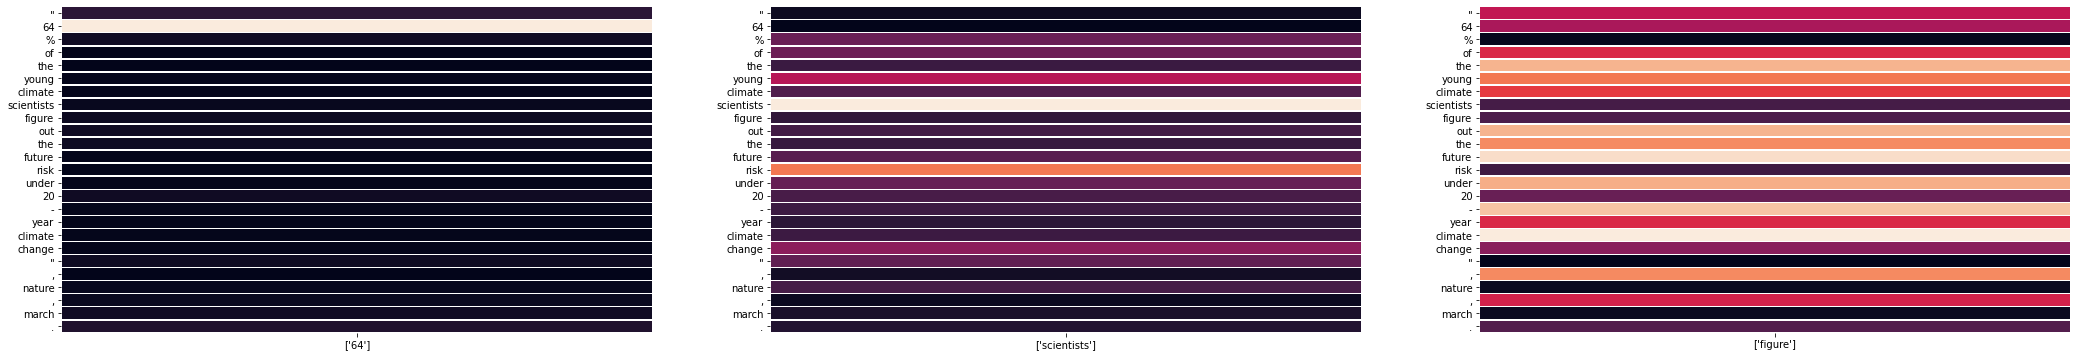


[ITERATION 154]
Current sentence: 	[CLS] " 64 % of the young climate scientists figure out the future risk under 20 - year climate change ", nature, march. [SEP]
Masked sentence: 	[CLS] " [MASK] % of the young climate scientists figure out the future risk under 20 - year [MASK] change ", [MASK], march. [SEP]
Predictions: 	"62 independent climate"


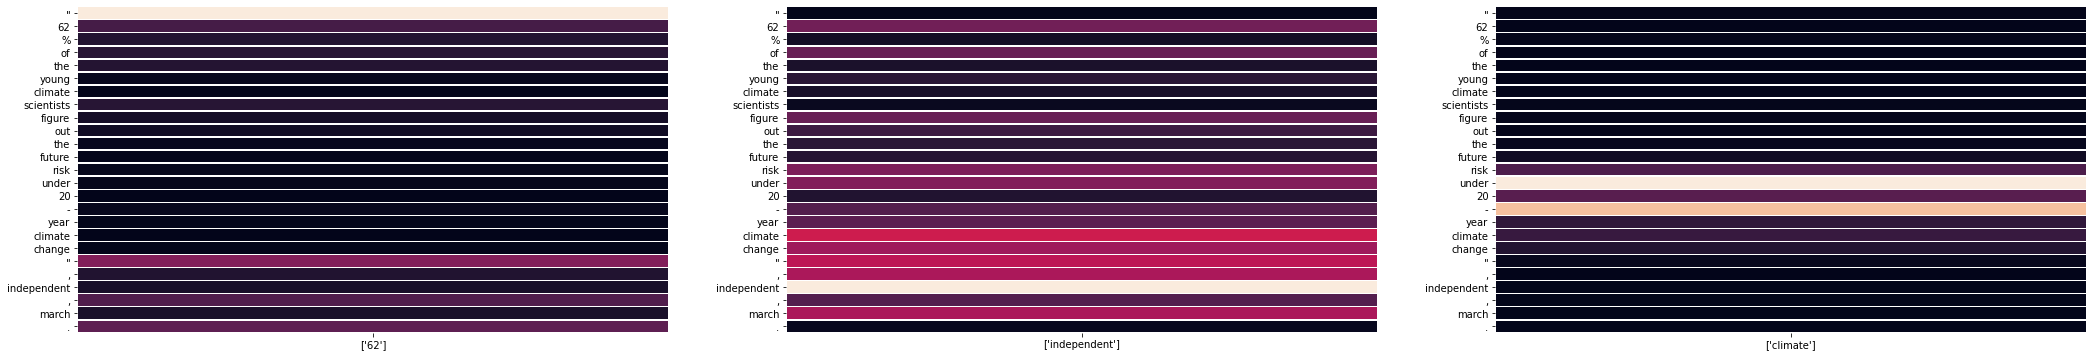


[ITERATION 155]
Current sentence: 	[CLS] " 62 % of the young climate scientists figure out the future risk under 20 - year climate change ", independent, march. [SEP]
Masked sentence: 	[CLS] " 62 % of the young climate scientists figure out the future risk [MASK] 20 - year climate [MASK] [MASK], independent, march. [SEP]
Predictions: 	"" change of"


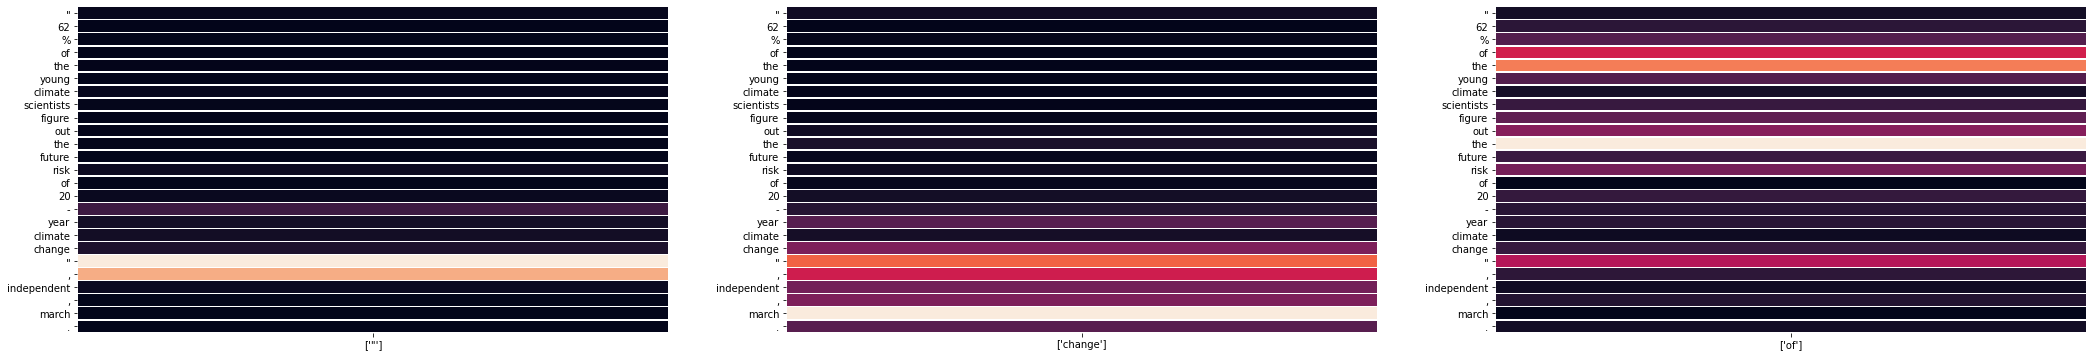


[ITERATION 156]
Current sentence: 	[CLS] " 62 % of the young climate scientists figure out the future risk of 20 - year climate change ", independent, march. [SEP]
Masked sentence: 	[CLS] " 62 [MASK] of the young climate scientists figure out the future risk of 20 - [MASK] climate change [MASK], independent, march. [SEP]
Predictions: 	"" year years"


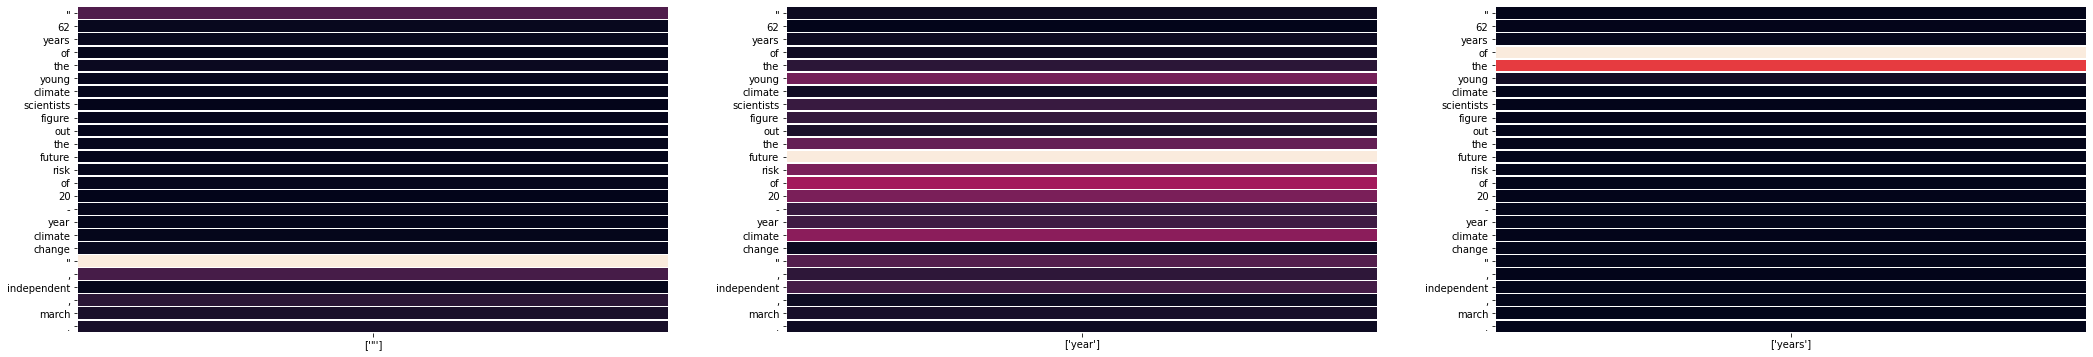


[ITERATION 157]
Current sentence: 	[CLS] " 62 years of the young climate scientists figure out the future risk of 20 - year climate change ", independent, march. [SEP]
Masked sentence: 	[CLS] " 62 years [MASK] the young climate scientists figure out the future risk of 20 - [MASK] climate change " [MASK] independent, march. [SEP]
Predictions: 	": fold :"


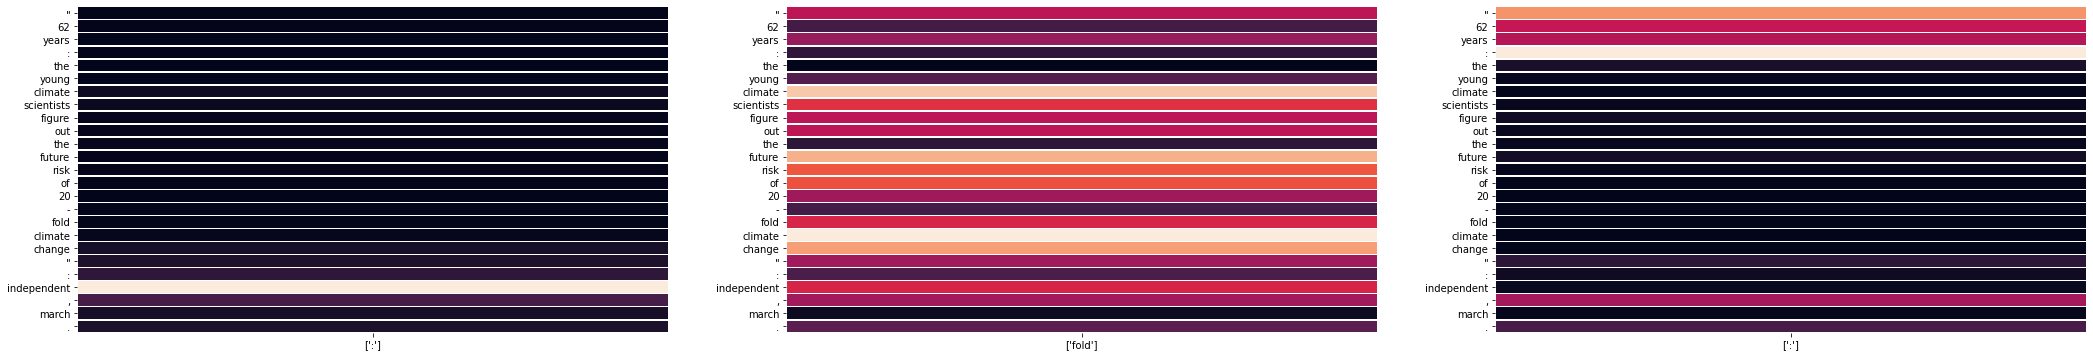


[ITERATION 158]
Current sentence: 	[CLS] " 62 years : the young climate scientists figure out the future risk of 20 - fold climate change " : independent, march. [SEP]
Masked sentence: 	[CLS] " 62 years : the [MASK] climate scientists figure out the future risk of 20 - fold climate change " : [MASK] [MASK] march. [SEP]
Predictions: 	"17 canadian nature"


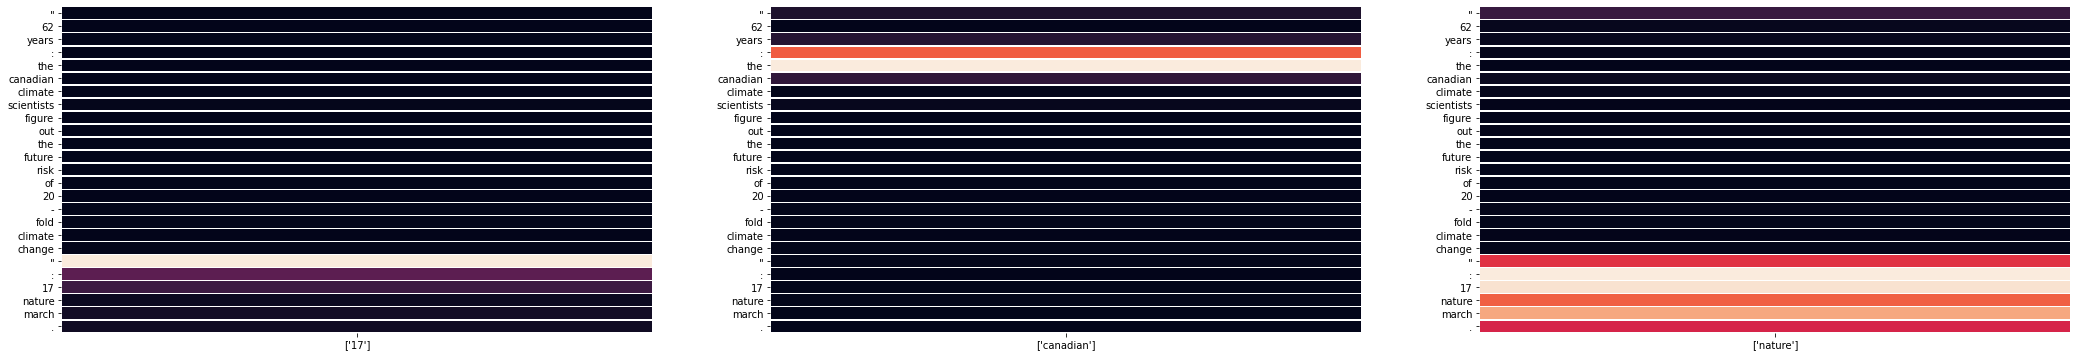


[ITERATION 159]
Current sentence: 	[CLS] " 62 years : the canadian climate scientists figure out the future risk of 20 - fold climate change " : 17 nature march. [SEP]
Masked sentence: 	[CLS] " 62 years : [MASK] canadian climate scientists figure out the future risk of 20 - fold climate change [MASK] : [MASK] nature march. [SEP]
Predictions: 	"" 41 a"


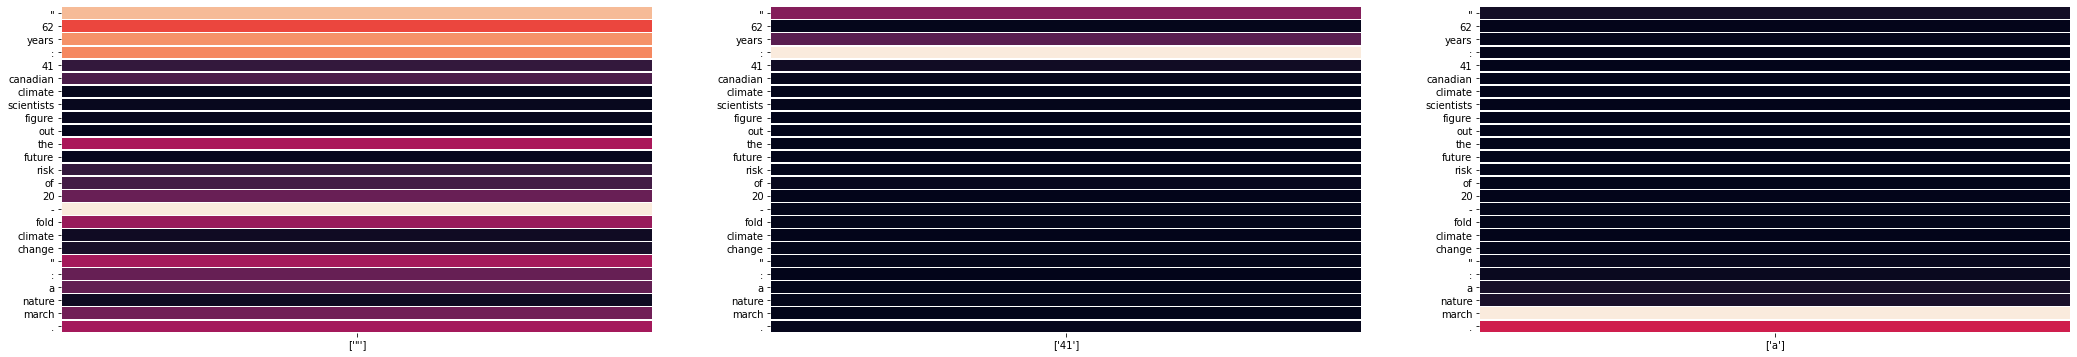


[ITERATION 160]
Current sentence: 	[CLS] " 62 years : 41 canadian climate scientists figure out the future risk of 20 - fold climate change " : a nature march. [SEP]
Masked sentence: 	[CLS] " 62 years [MASK] 41 canadian climate scientists figure out [MASK] future risk of 20 - fold climate change " : a nature [MASK]. [SEP]
Predictions: 	"a : guide"


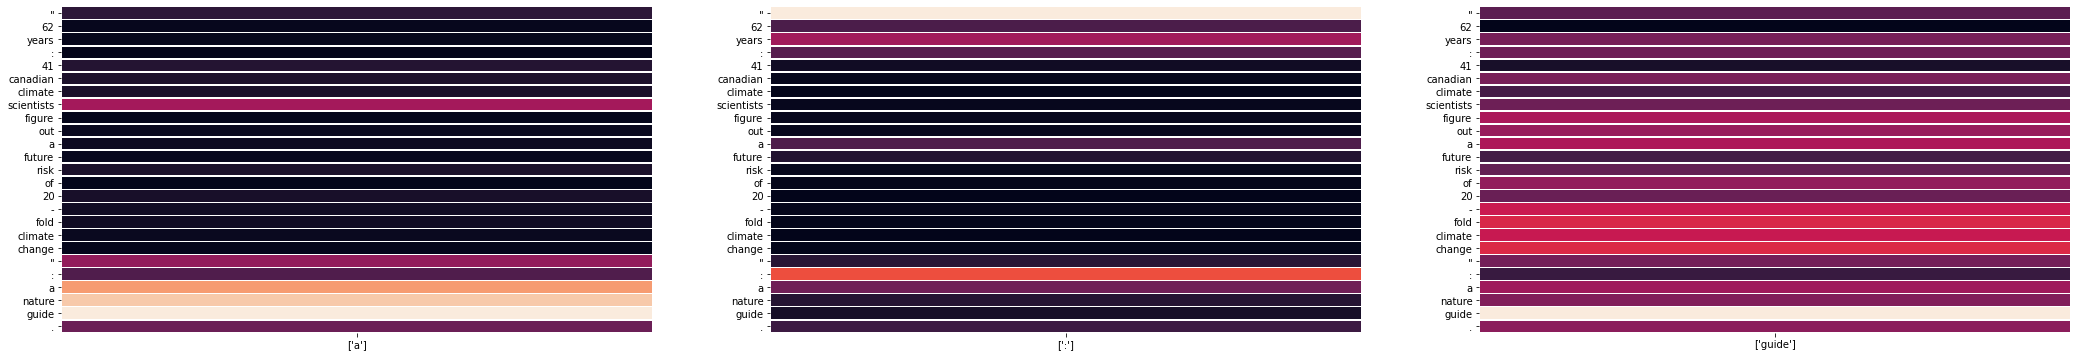


[ITERATION 161]
Current sentence: 	[CLS] " 62 years : 41 canadian climate scientists figure out a future risk of 20 - fold climate change " : a nature guide. [SEP]
Masked sentence: 	[CLS] " [MASK] years : 41 canadian climate scientists figure out [MASK] future risk of 20 - fold climate change " : a nature [MASK]. [SEP]
Predictions: 	"journal 50 the"


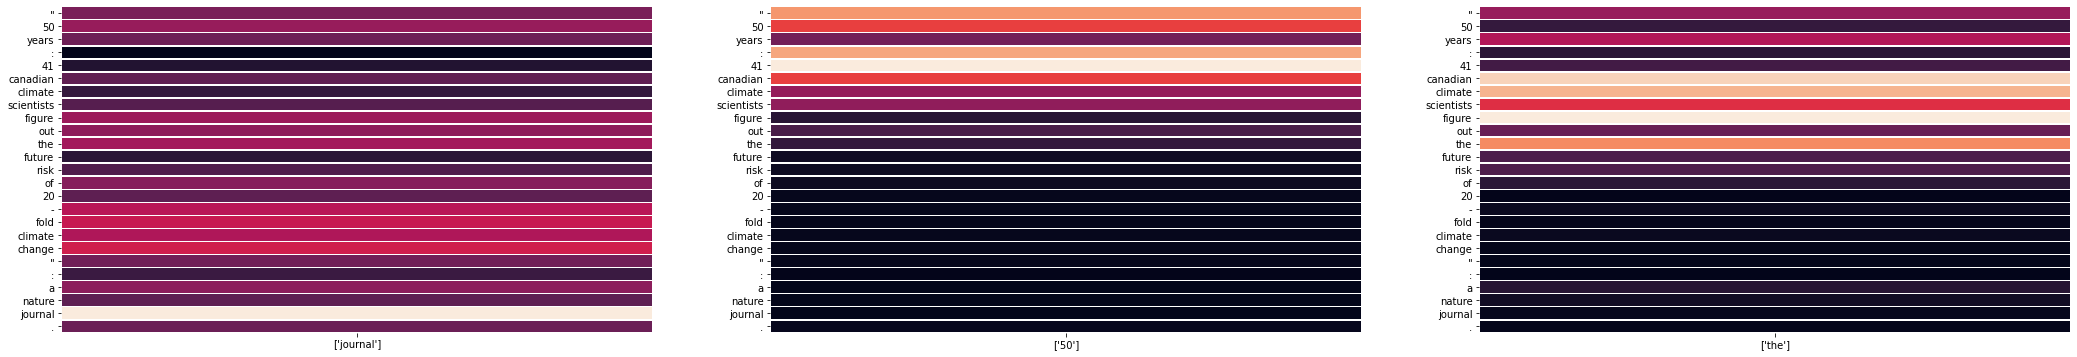


[ITERATION 162]
Current sentence: 	[CLS] " 50 years : 41 canadian climate scientists figure out the future risk of 20 - fold climate change " : a nature journal. [SEP]
Masked sentence: 	[CLS] " [MASK] years : 41 canadian [MASK] scientists figure out the future risk of [MASK] - fold climate change " : a nature journal. [SEP]
Predictions: 	"several 100 young"


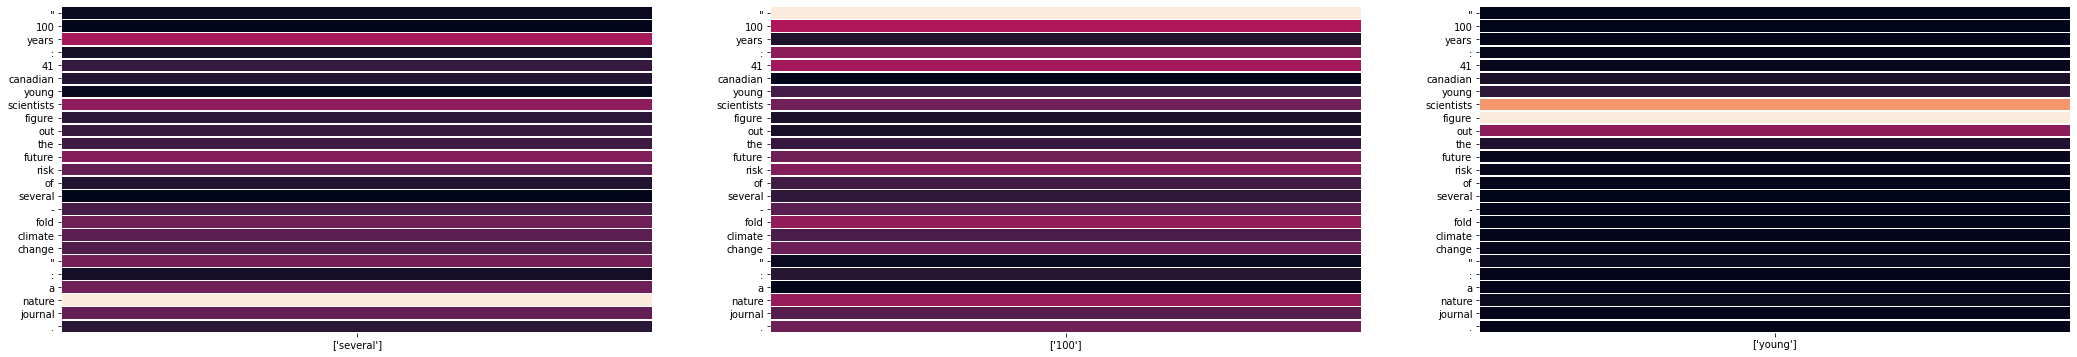


[ITERATION 163]
Current sentence: 	[CLS] " 100 years : 41 canadian young scientists figure out the future risk of several - fold climate change " : a nature journal. [SEP]
Masked sentence: 	[CLS] " 100 years : 41 canadian young [MASK] figure out [MASK] future risk of several - fold climate change " : a nature journal [MASK] [SEP]
Predictions: 	". scientists the"


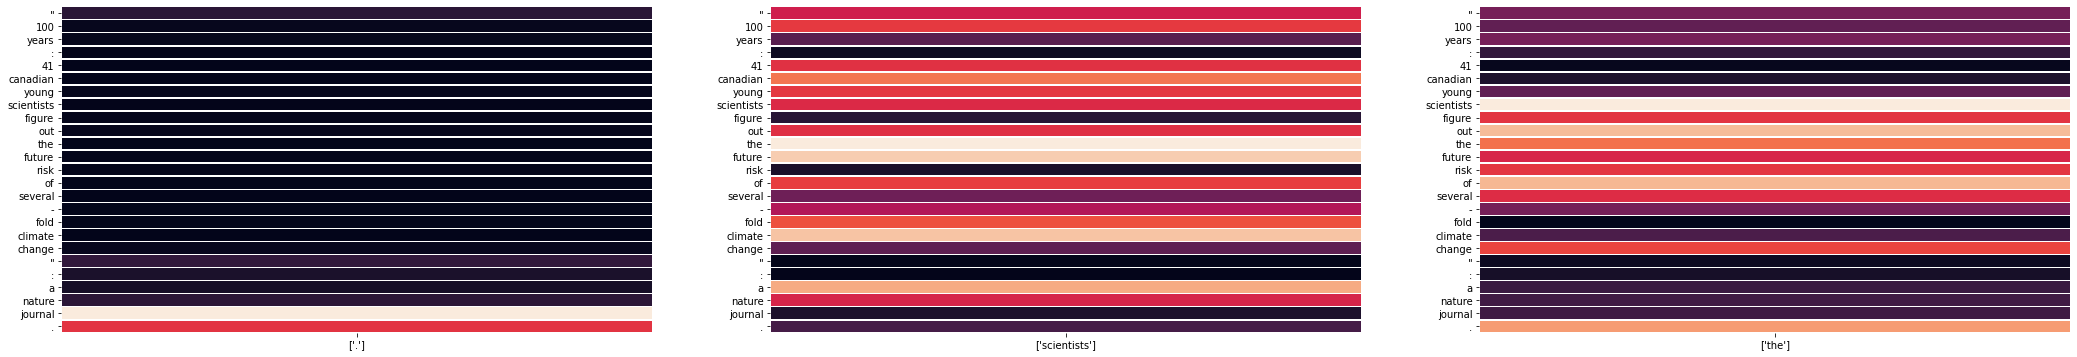


[ITERATION 164]
Current sentence: 	[CLS] " 100 years : 41 canadian young scientists figure out the future risk of several - fold climate change " : a nature journal. [SEP]
Masked sentence: 	[CLS] " [MASK] years : 41 canadian young scientists figure out the future risk of several - fold climate change " : a nature journal [MASK] [SEP]
Predictions: 	". 10 ;"


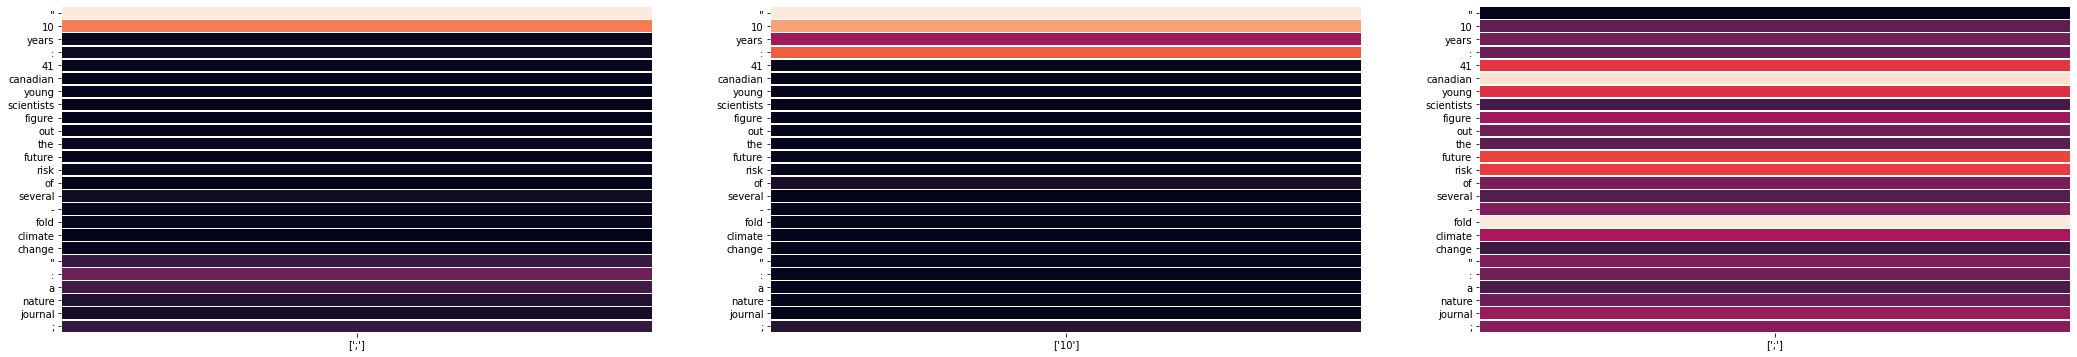


[ITERATION 165]
Current sentence: 	[CLS] " 10 years : 41 canadian young scientists figure out the future risk of several - fold climate change " : a nature journal ; [SEP]
Masked sentence: 	[CLS] " 10 [MASK] [MASK] 41 [MASK] young scientists figure out the future risk of several - fold climate change " : a nature journal ; [SEP]
Predictions: 	":. years"


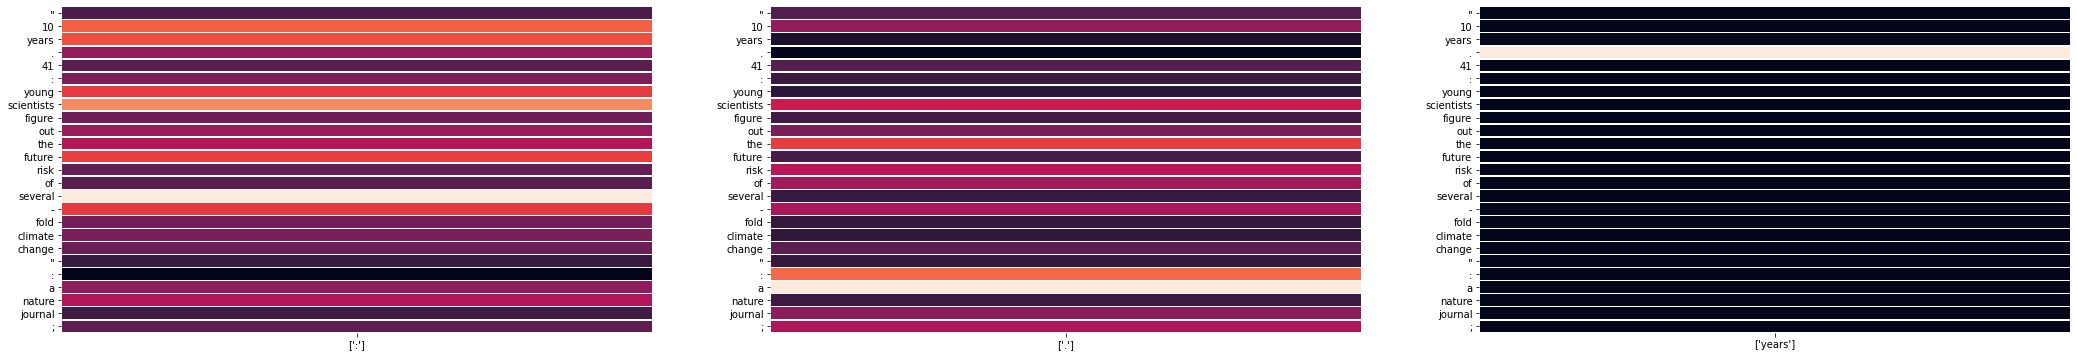


[ITERATION 166]
Current sentence: 	[CLS] " 10 years. 41 : young scientists figure out the future risk of several - fold climate change " : a nature journal ; [SEP]
Masked sentence: 	[CLS] " 10 years [MASK] 41 : young scientists figure out the [MASK] risk of [MASK] - fold climate change " : a nature journal ; [SEP]
Predictions: 	"current 10 under"


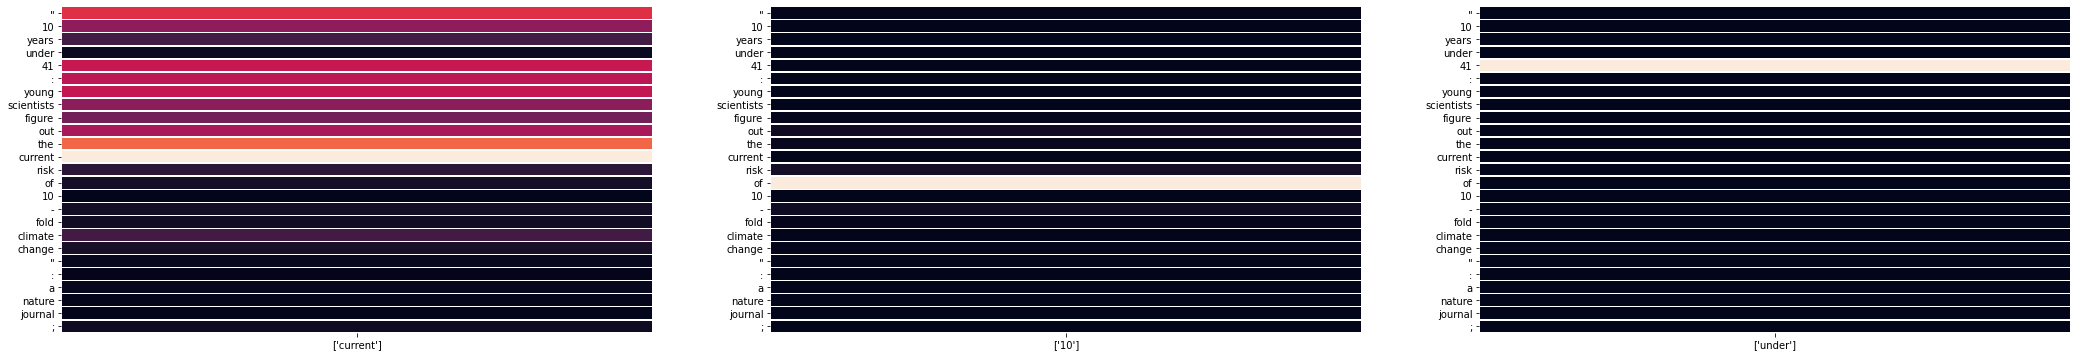


[ITERATION 167]
Current sentence: 	[CLS] " 10 years under 41 : young scientists figure out the current risk of 10 - fold climate change " : a nature journal ; [SEP]
Masked sentence: 	[CLS] " 10 years [MASK] [MASK] : young scientists figure out the current risk [MASK] 10 - fold climate change " : a nature journal ; [SEP]
Predictions: 	"of of old"


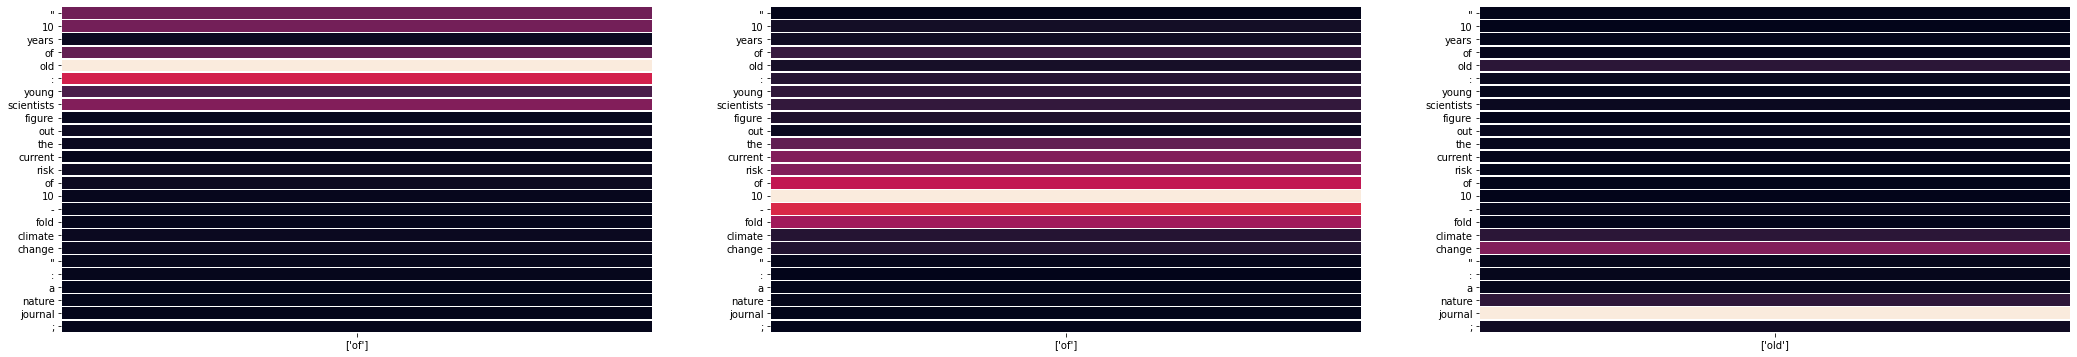


[ITERATION 168]
Current sentence: 	[CLS] " 10 years of old : young scientists figure out the current risk of 10 - fold climate change " : a nature journal ; [SEP]
Masked sentence: 	[CLS] " 10 years of [MASK] : young scientists figure out [MASK] current risk of 10 - fold climate change " : a nature [MASK] ; [SEP]
Predictions: 	"hope the book"


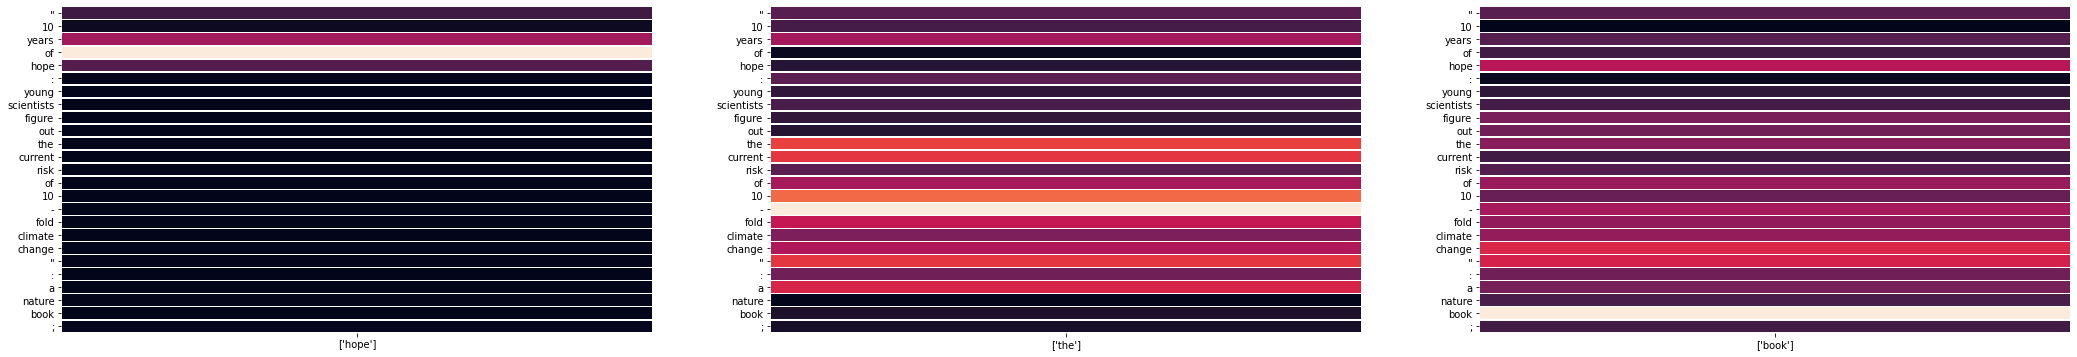


[ITERATION 169]
Current sentence: 	[CLS] " 10 years of hope : young scientists figure out the current risk of 10 - fold climate change " : a nature book ; [SEP]
Masked sentence: 	[CLS] " 10 years [MASK] hope : young [MASK] figure out the current risk [MASK] 10 - fold climate change " : a nature book ; [SEP]
Predictions: 	"of of scientists"


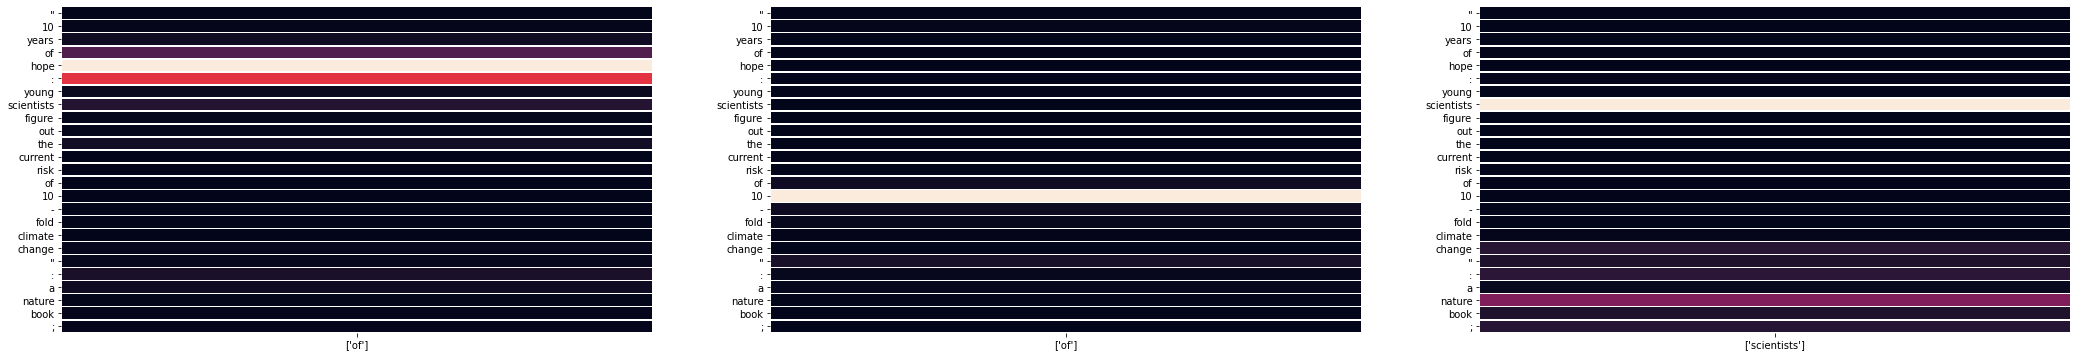


[ITERATION 170]
Current sentence: 	[CLS] " 10 years of hope : young scientists figure out the current risk of 10 - fold climate change " : a nature book ; [SEP]
Masked sentence: 	[CLS] " 10 years [MASK] hope : young scientists figure out the current risk of [MASK] - fold climate change " [MASK] a nature book ; [SEP]
Predictions: 	"of ten,"


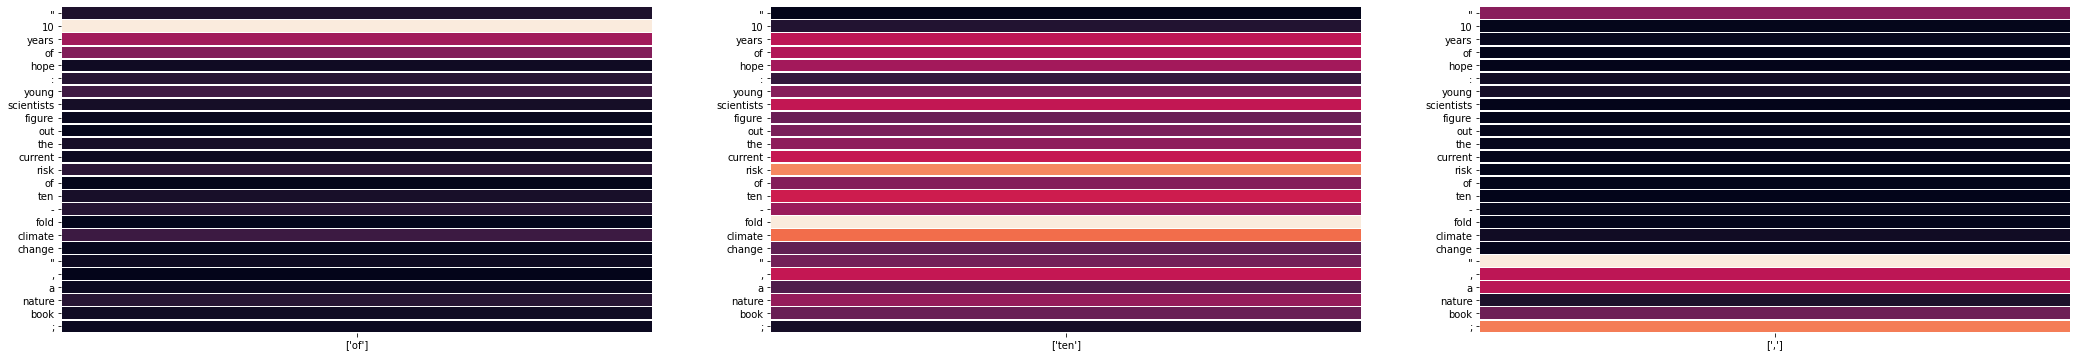


[ITERATION 171]
Current sentence: 	[CLS] " 10 years of hope : young scientists figure out the current risk of ten - fold climate change ", a nature book ; [SEP]
Masked sentence: 	[CLS] [MASK] 10 [MASK] of hope : young scientists figure out the current risk of ten - [MASK] climate change ", a nature book ; [SEP]
Predictions: 	"years year ""


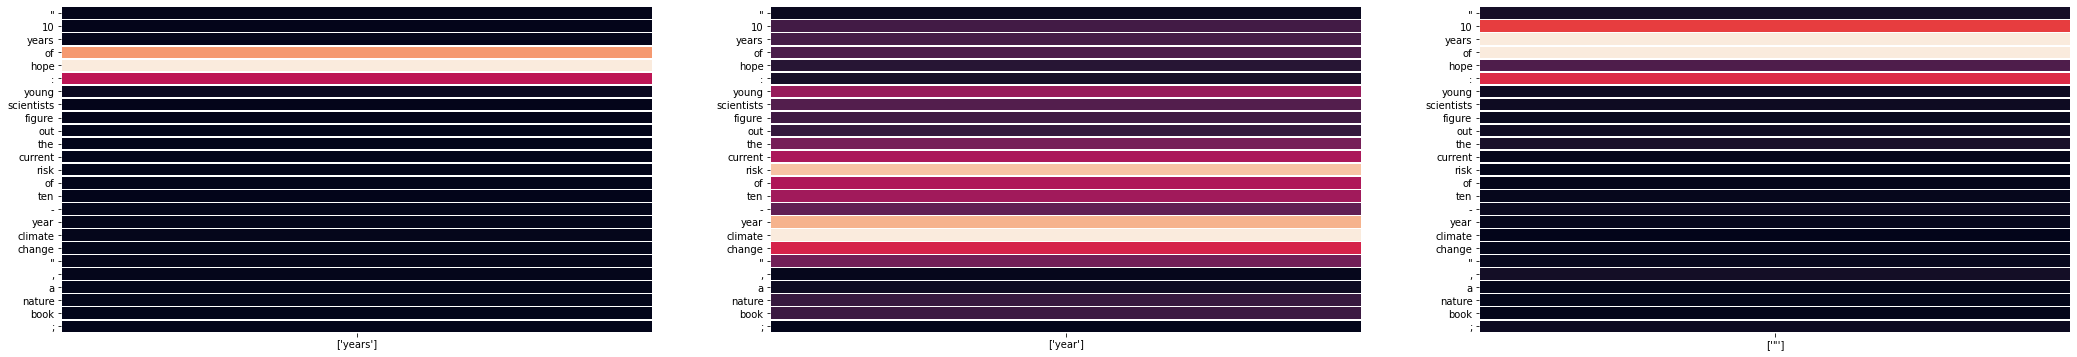


[ITERATION 172]
Current sentence: 	[CLS] " 10 years of hope : young scientists figure out the current risk of ten - year climate change ", a nature book ; [SEP]
Masked sentence: 	[CLS] " 10 years [MASK] hope : young scientists figure out the current risk of ten [MASK] year climate change ", a nature book [MASK] [SEP]
Predictions: 	"of - ;"


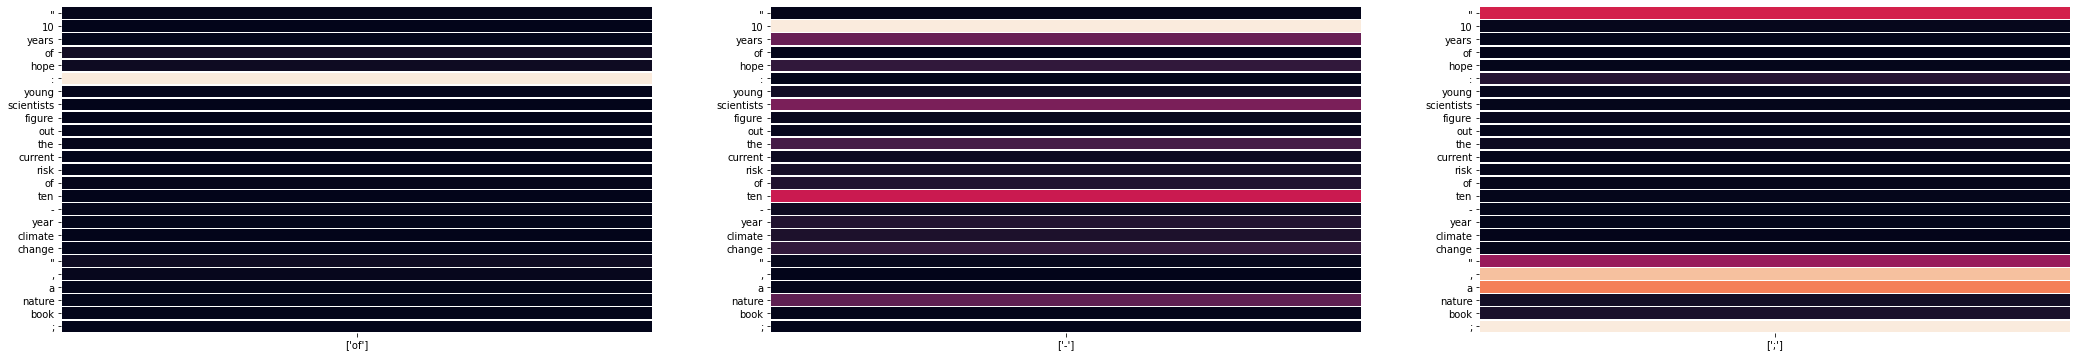


[ITERATION 173]
Current sentence: 	[CLS] " 10 years of hope : young scientists figure out the current risk of ten - year climate change ", a nature book ; [SEP]
Masked sentence: 	[CLS] " 10 years of hope [MASK] [MASK] scientists figure out the current risk of ten - year climate change ", a nature book [MASK] [SEP]
Predictions: 	": when."


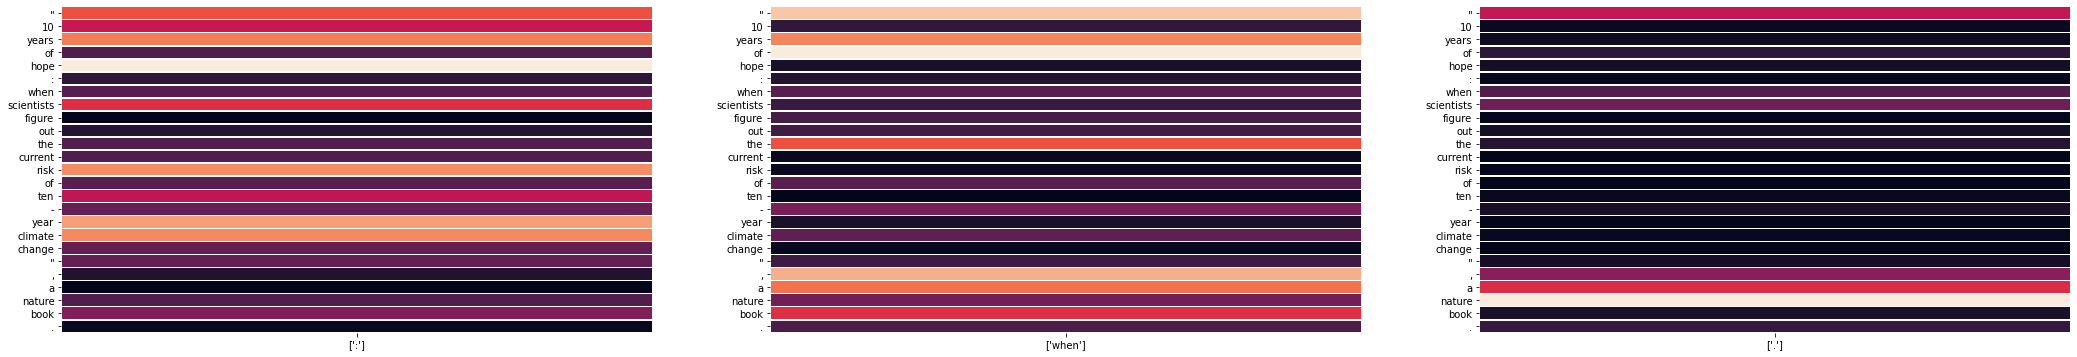


[ITERATION 174]
Current sentence: 	[CLS] " 10 years of hope : when scientists figure out the current risk of ten - year climate change ", a nature book. [SEP]
Masked sentence: 	[CLS] " 10 years of hope : when [MASK] figure out the current risk [MASK] ten - year climate change ", a nature book. [SEP]
Predictions: 	"i of we"


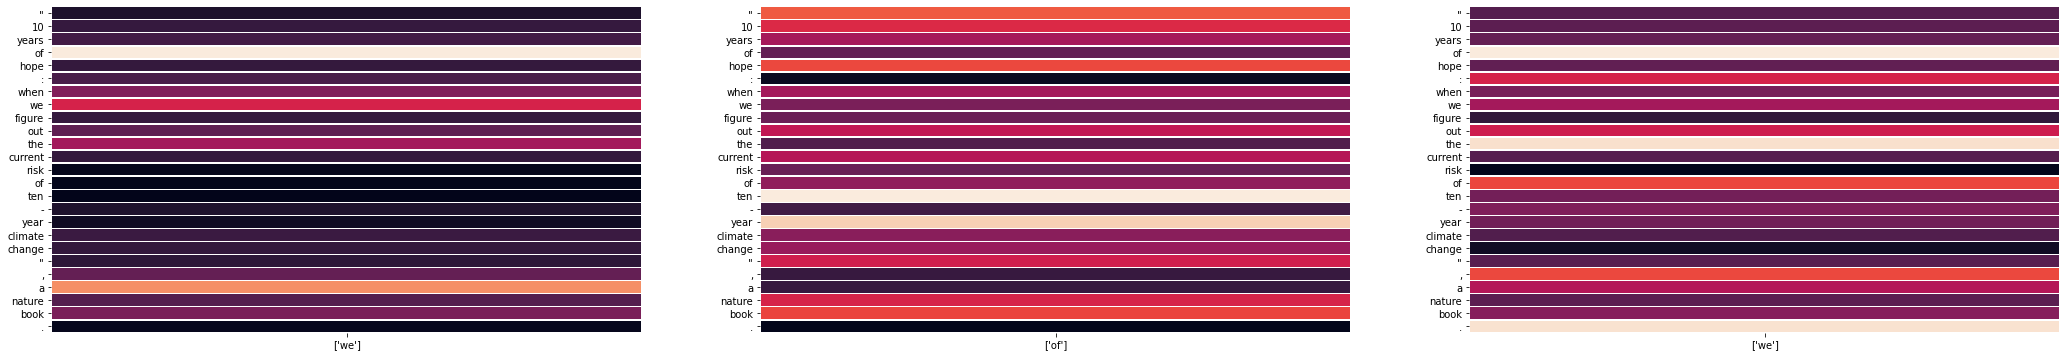


[ITERATION 175]
Current sentence: 	[CLS] " 10 years of hope : when we figure out the current risk of ten - year climate change ", a nature book. [SEP]
Masked sentence: 	[CLS] " 10 years of [MASK] : when we figure out [MASK] current risk of ten - year [MASK] change ", a nature book. [SEP]
Predictions: 	"the change climate"


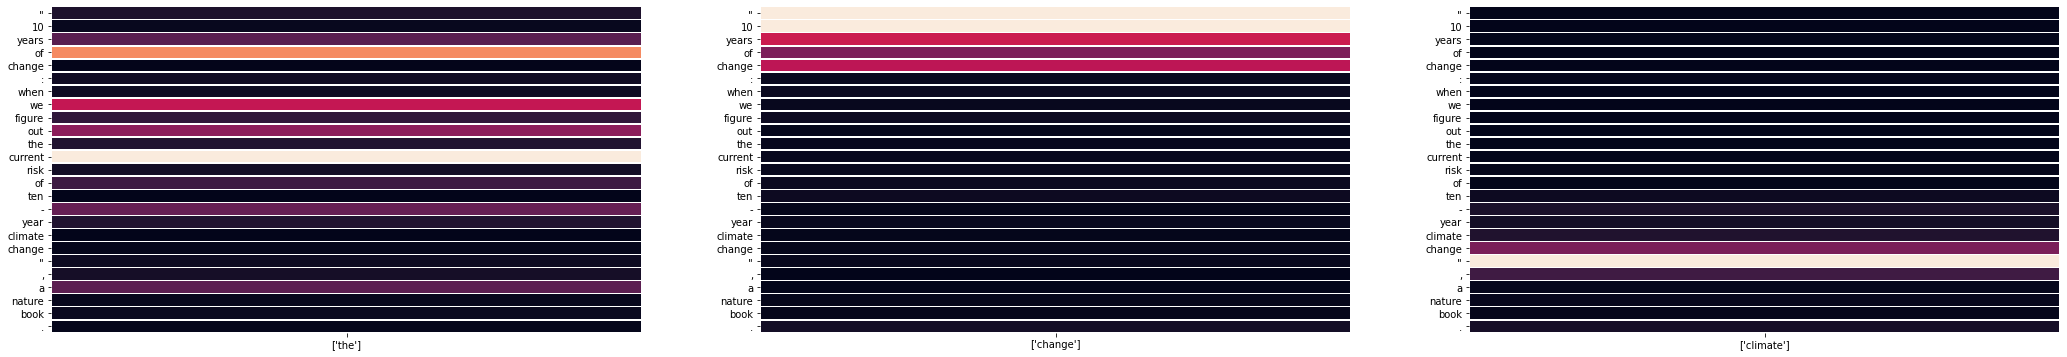


[ITERATION 176]
Current sentence: 	[CLS] " 10 years of change : when we figure out the current risk of ten - year climate change ", a nature book. [SEP]
Masked sentence: 	[CLS] " [MASK] years of change : when we figure [MASK] the current risk of ten - year climate [MASK] ", a nature book. [SEP]
Predictions: 	"out ten change"


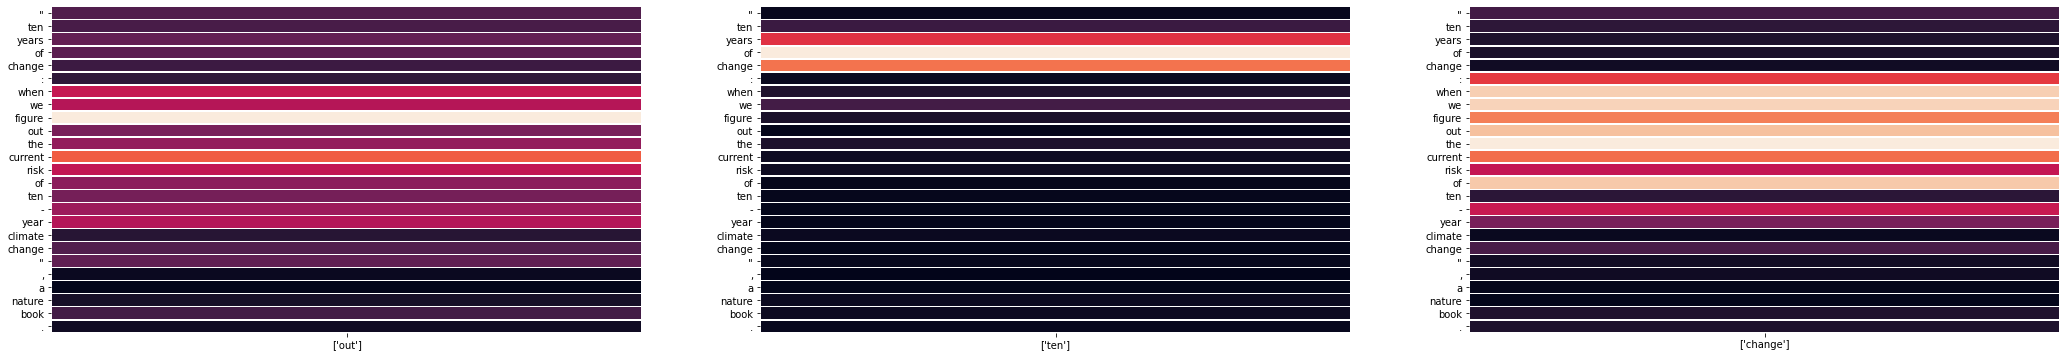


[ITERATION 177]
Current sentence: 	[CLS] " ten years of change : when we figure out the current risk of ten - year climate change ", a nature book. [SEP]
Masked sentence: 	[CLS] " ten years of change : when [MASK] [MASK] out the current [MASK] of ten - year climate change ", a nature book. [SEP]
Predictions: 	"figure scientists face"


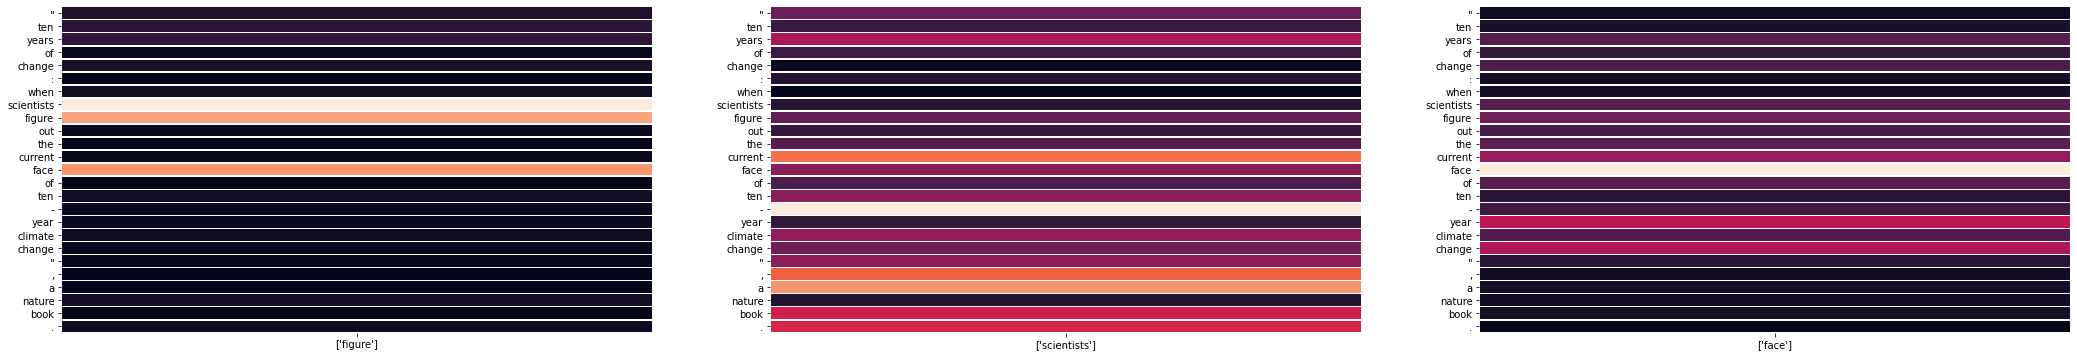


[ITERATION 178]
Current sentence: 	[CLS] " ten years of change : when scientists figure out the current face of ten - year climate change ", a nature book. [SEP]
Masked sentence: 	[CLS] " ten years [MASK] change : when scientists [MASK] out the current [MASK] of ten - year climate change ", a nature book. [SEP]
Predictions: 	"find of risk"


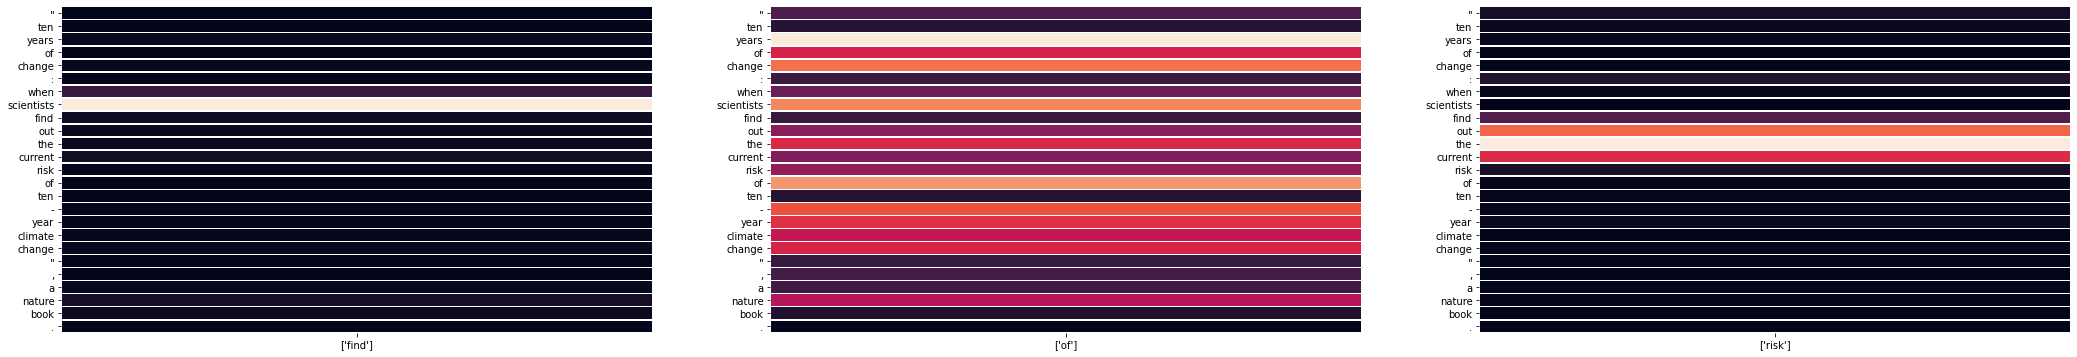


[ITERATION 179]
Current sentence: 	[CLS] " ten years of change : when scientists find out the current risk of ten - year climate change ", a nature book. [SEP]
Masked sentence: 	[CLS] " ten years of change [MASK] when scientists [MASK] [MASK] the current risk of ten - year climate change ", a nature book. [SEP]
Predictions: 	"assessed : estimate"


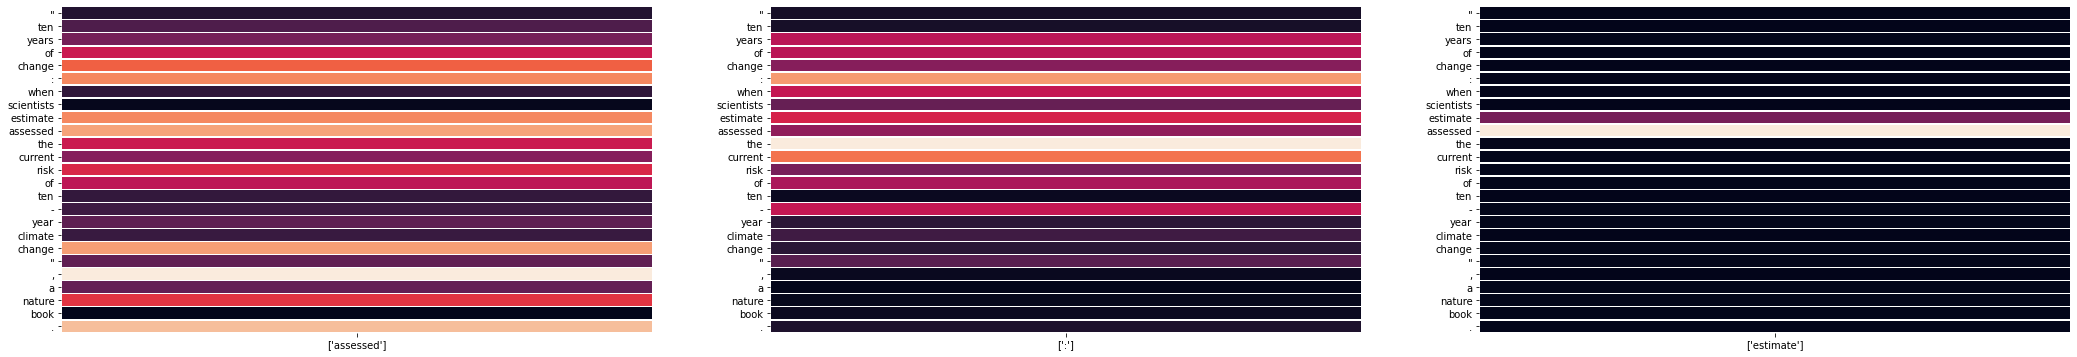


[ITERATION 180]
Current sentence: 	[CLS] " ten years of change : when scientists estimate assessed the current risk of ten - year climate change ", a nature book. [SEP]
Masked sentence: 	[CLS] " ten years of change : when scientists estimate [MASK] the current risk of ten [MASK] [MASK] climate change ", a nature book. [SEP]
Predictions: 	"million years for"


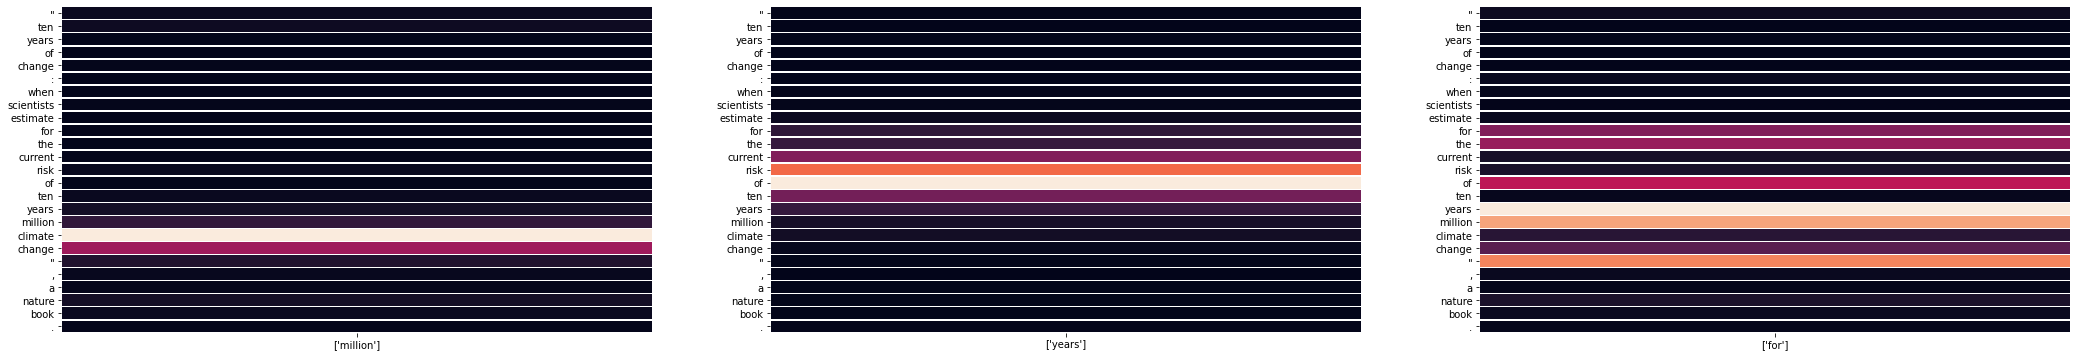


[ITERATION 181]
Current sentence: 	[CLS] " ten years of change : when scientists estimate for the current risk of ten years million climate change ", a nature book. [SEP]
Masked sentence: 	[CLS] " ten years of change : when scientists estimate for the current [MASK] of ten [MASK] million climate change [MASK], a nature book. [SEP]
Predictions: 	"- impact ""


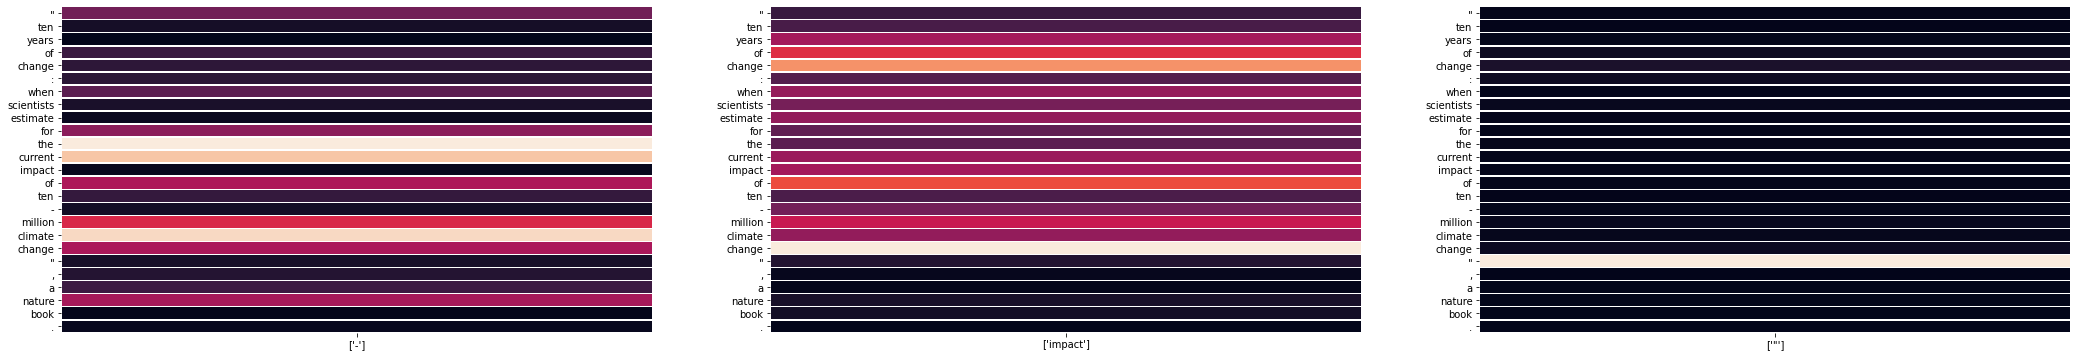


[ITERATION 182]
Current sentence: 	[CLS] " ten years of change : when scientists estimate for the current impact of ten - million climate change ", a nature book. [SEP]
Masked sentence: 	[CLS] " [MASK] years of change : when scientists estimate for the current impact [MASK] ten - million climate change [MASK], a nature book. [SEP]
Predictions: 	"of billion ""


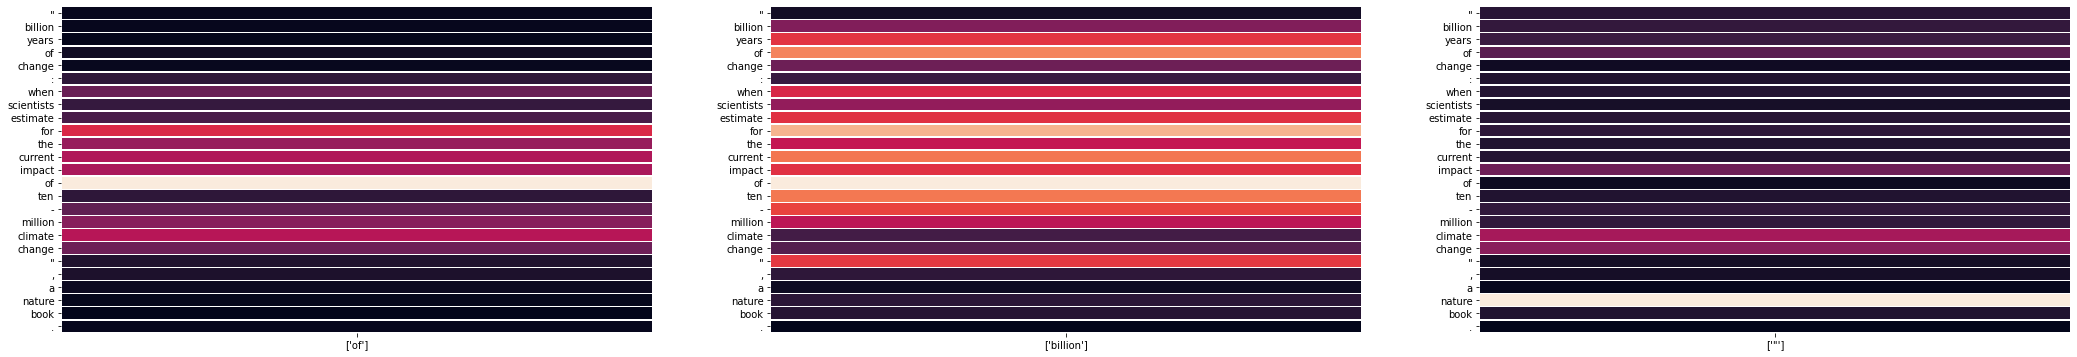


[ITERATION 183]
Current sentence: 	[CLS] " billion years of change : when scientists estimate for the current impact of ten - million climate change ", a nature book. [SEP]
Masked sentence: 	[CLS] " [MASK] years [MASK] change : when scientists estimate for the current impact of ten [MASK] million climate change ", a nature book. [SEP]
Predictions: 	"trillion of fifty"


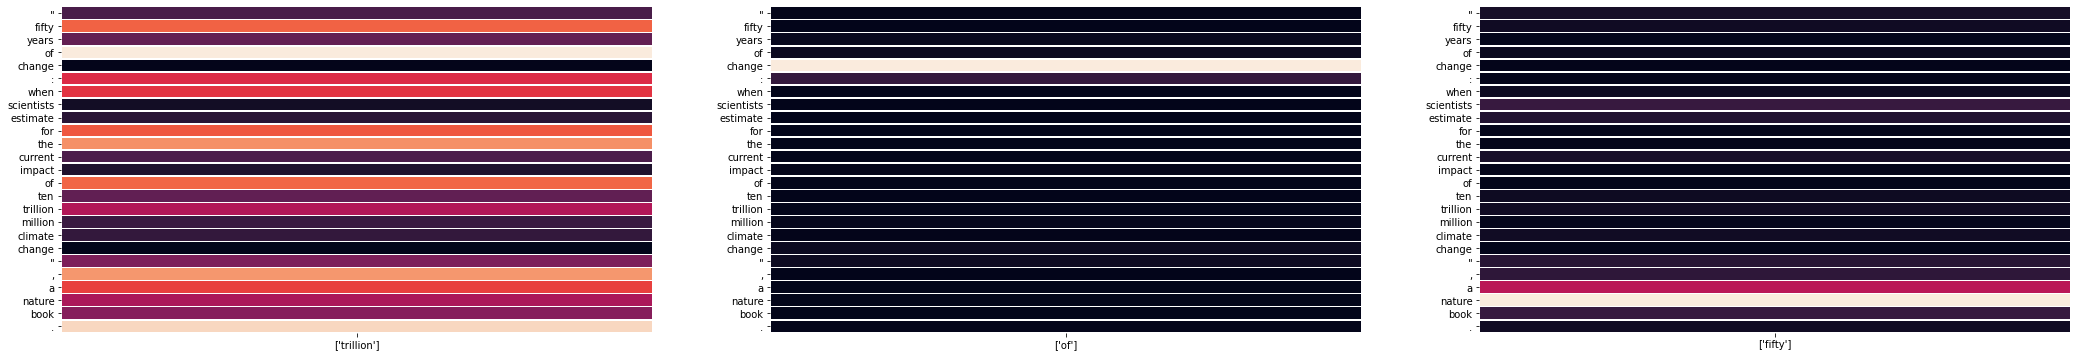


[ITERATION 184]
Current sentence: 	[CLS] " fifty years of change : when scientists estimate for the current impact of ten trillion million climate change ", a nature book. [SEP]
Masked sentence: 	[CLS] " fifty years [MASK] change [MASK] when scientists estimate for the current impact of ten trillion million climate change " [MASK] a nature book. [SEP]
Predictions: 	"of :,"


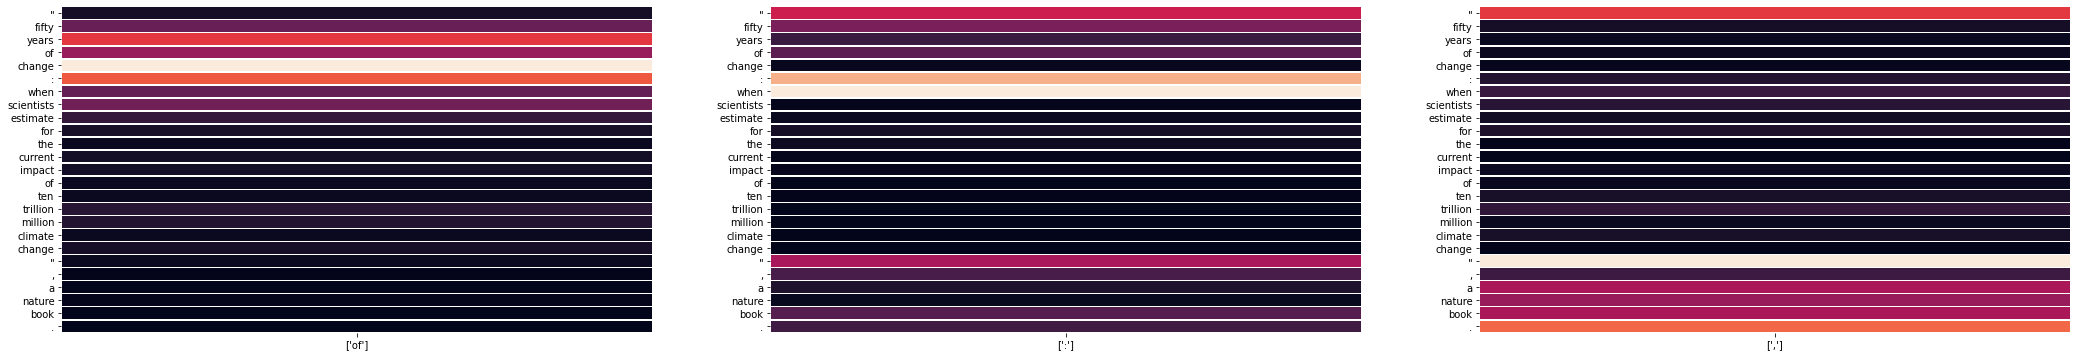


[ITERATION 185]
Current sentence: 	[CLS] " fifty years of change : when scientists estimate for the current impact of ten trillion million climate change ", a nature book. [SEP]
Masked sentence: 	[CLS] " [MASK] years of [MASK] [MASK] when scientists estimate for the current impact of ten trillion million climate change ", a nature book. [SEP]
Predictions: 	"great study 20"


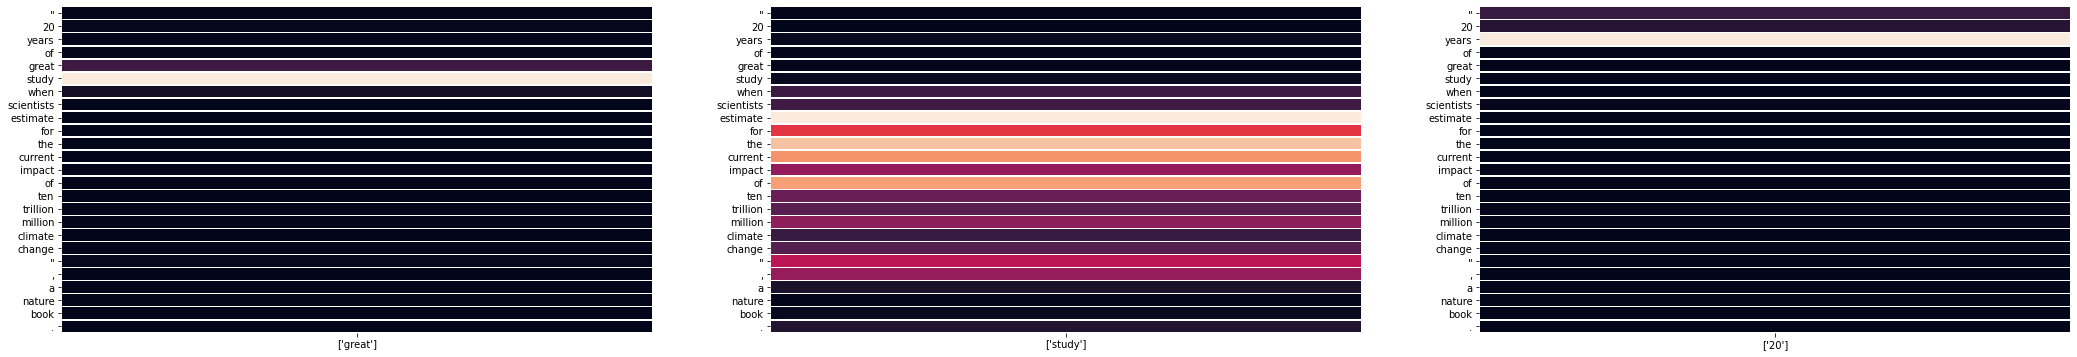


[ITERATION 186]
Current sentence: 	[CLS] " 20 years of great study when scientists estimate for the current impact of ten trillion million climate change ", a nature book. [SEP]
Masked sentence: 	[CLS] [MASK] 20 years of great [MASK] when [MASK] estimate for the current impact of ten trillion million climate change ", a nature book. [SEP]
Predictions: 	"complexity we ""


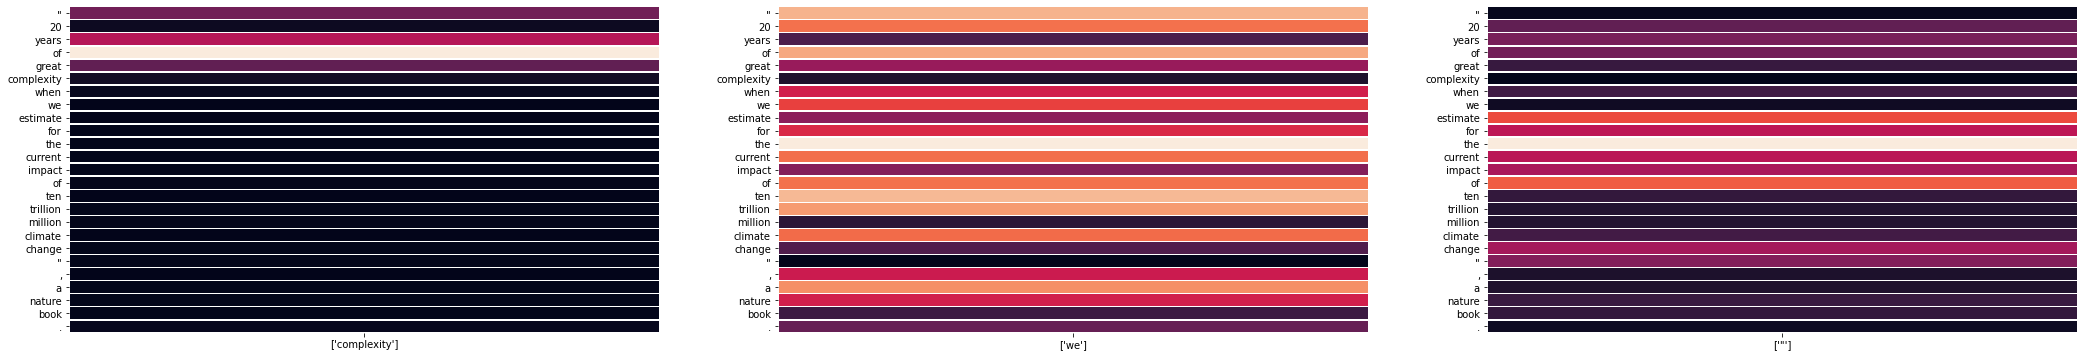


[ITERATION 187]
Current sentence: 	[CLS] " 20 years of great complexity when we estimate for the current impact of ten trillion million climate change ", a nature book. [SEP]
Masked sentence: 	[CLS] " 20 [MASK] of great [MASK] when we estimate for the current impact of [MASK] trillion million climate change ", a nature book. [SEP]
Predictions: 	"detail 20 years"


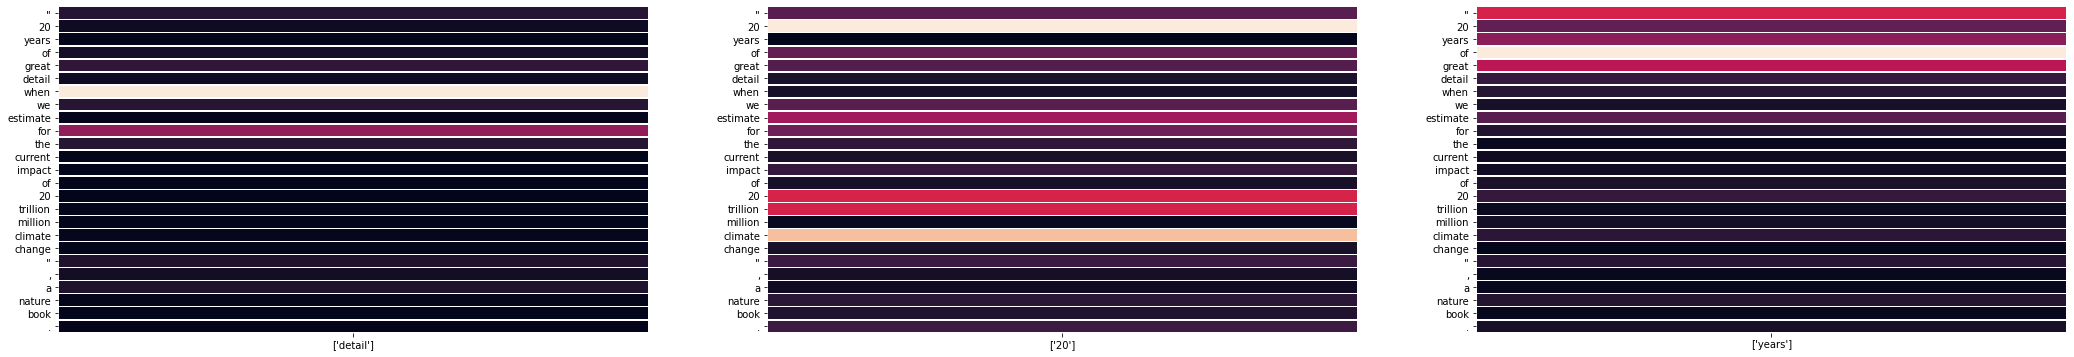


[ITERATION 188]
Current sentence: 	[CLS] " 20 years of great detail when we estimate for the current impact of 20 trillion million climate change ", a nature book. [SEP]
Masked sentence: 	[CLS] " 20 years of [MASK] detail when we estimate for the current impact of 20 trillion million [MASK] change ", a nature book. [SEP]
Predictions: 	"computer earth special"


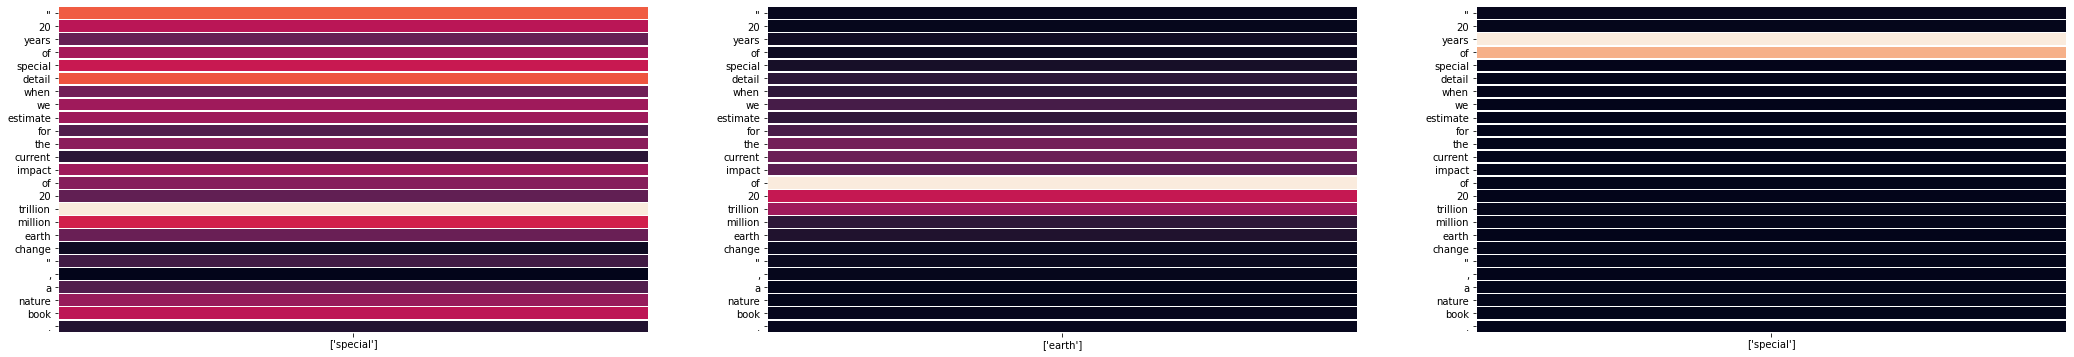


[ITERATION 189]
Current sentence: 	[CLS] " 20 years of special detail when we estimate for the current impact of 20 trillion million earth change ", a nature book. [SEP]
Masked sentence: 	[CLS] " 20 [MASK] [MASK] special detail when we estimate for the current impact of [MASK] trillion million earth change ", a nature book. [SEP]
Predictions: 	"times 20 in"


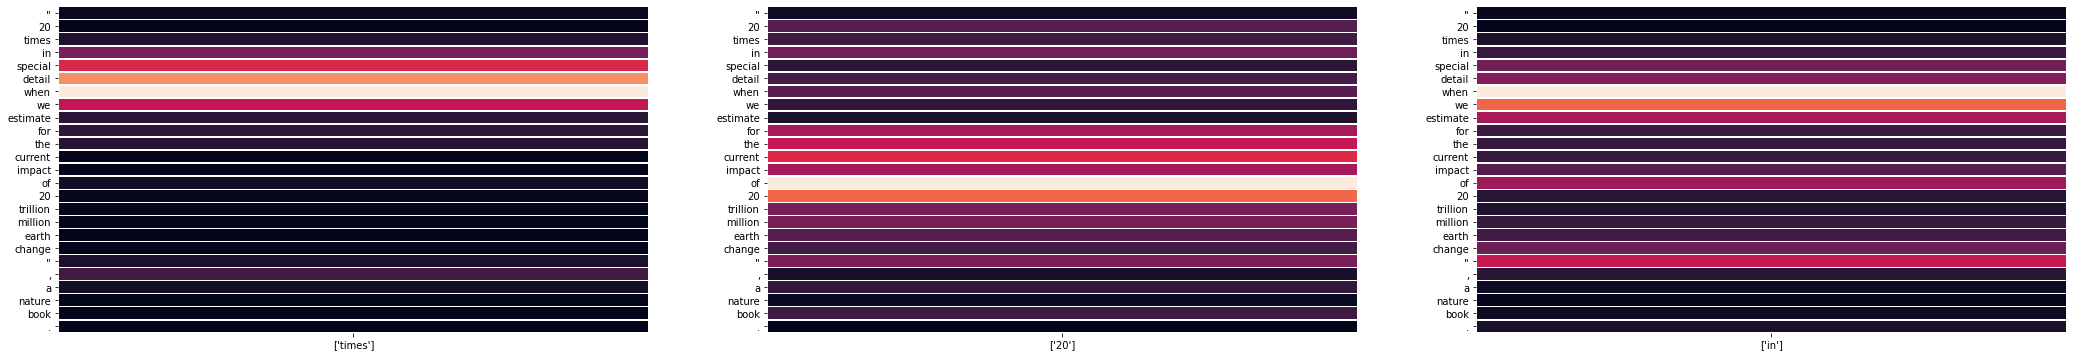


[ITERATION 190]
Current sentence: 	[CLS] " 20 times in special detail when we estimate for the current impact of 20 trillion million earth change ", a nature book. [SEP]
Masked sentence: 	[CLS] " 20 times in special detail [MASK] we estimate for the current impact [MASK] 20 trillion million earth change ", a nature book. [SEP]
Predictions: 	"should of can"


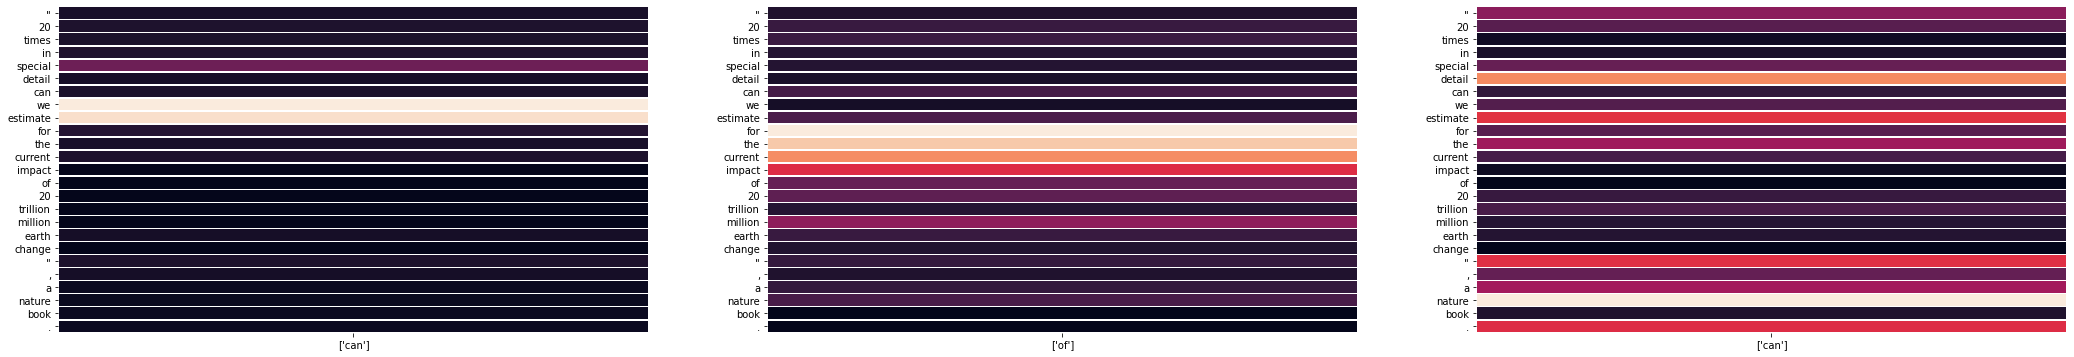


[ITERATION 191]
Current sentence: 	[CLS] " 20 times in special detail can we estimate for the current impact of 20 trillion million earth change ", a nature book. [SEP]
Masked sentence: 	[CLS] " 20 times in special detail can we [MASK] [MASK] the current impact of 20 trillion million earth change ", a nature book [MASK] [SEP]
Predictions: 	"compare understand."


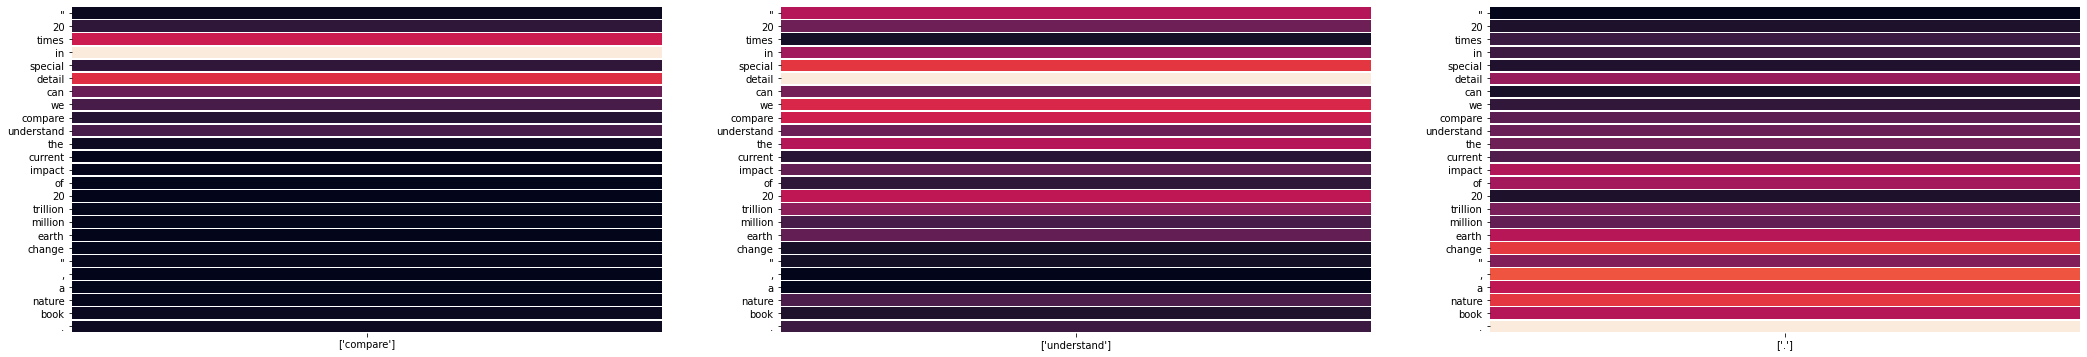


[ITERATION 192]
Current sentence: 	[CLS] " 20 times in special detail can we compare understand the current impact of 20 trillion million earth change ", a nature book. [SEP]
Masked sentence: 	[CLS] " 20 times in [MASK] [MASK] can we compare understand the current impact of 20 trillion million earth change ", a [MASK] book. [SEP]
Predictions: 	"the history scientific"


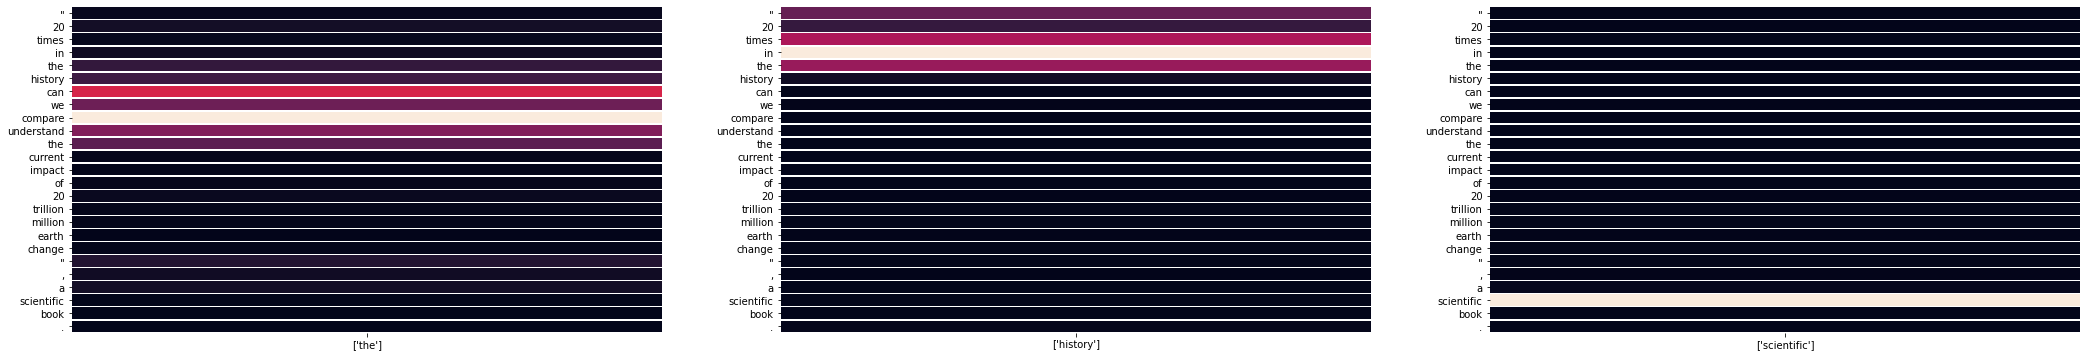


[ITERATION 193]
Current sentence: 	[CLS] " 20 times in the history can we compare understand the current impact of 20 trillion million earth change ", a scientific book. [SEP]
Masked sentence: 	[CLS] [MASK] 20 [MASK] in the history can we compare understand the current impact of 20 trillion million earth change ", a [MASK] book. [SEP]
Predictions: 	"how " 1989"


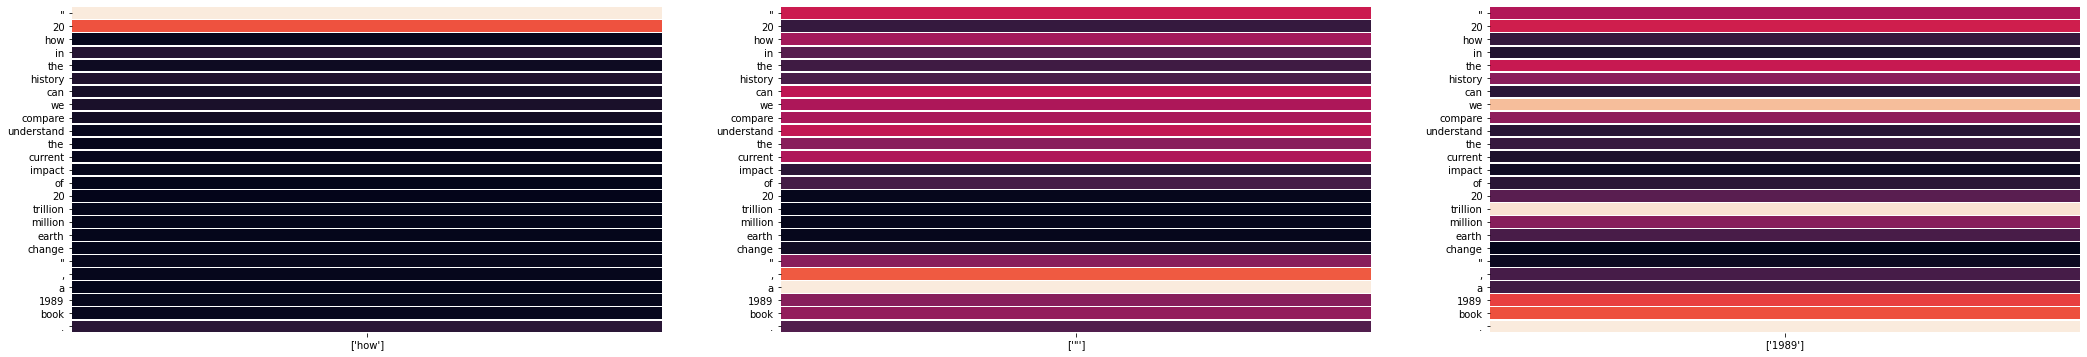


[ITERATION 194]
Current sentence: 	[CLS] " 20 how in the history can we compare understand the current impact of 20 trillion million earth change ", a 1989 book. [SEP]
Masked sentence: 	[CLS] [MASK] 20 [MASK] [MASK] the history can we compare understand the current impact of 20 trillion million earth change ", a 1989 book. [SEP]
Predictions: 	"" years in"


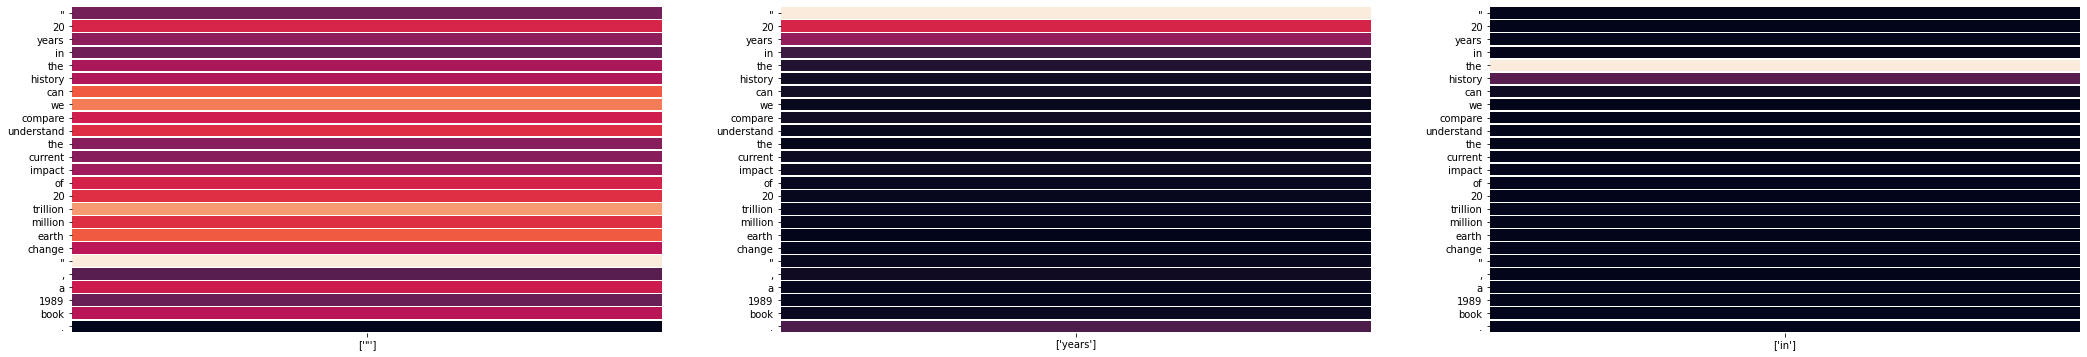


[ITERATION 195]
Current sentence: 	[CLS] " 20 years in the history can we compare understand the current impact of 20 trillion million earth change ", a 1989 book. [SEP]
Masked sentence: 	[CLS] " 20 years in [MASK] history can we [MASK] [MASK] the current impact of 20 trillion million earth change ", a 1989 book. [SEP]
Predictions: 	"understand get human"


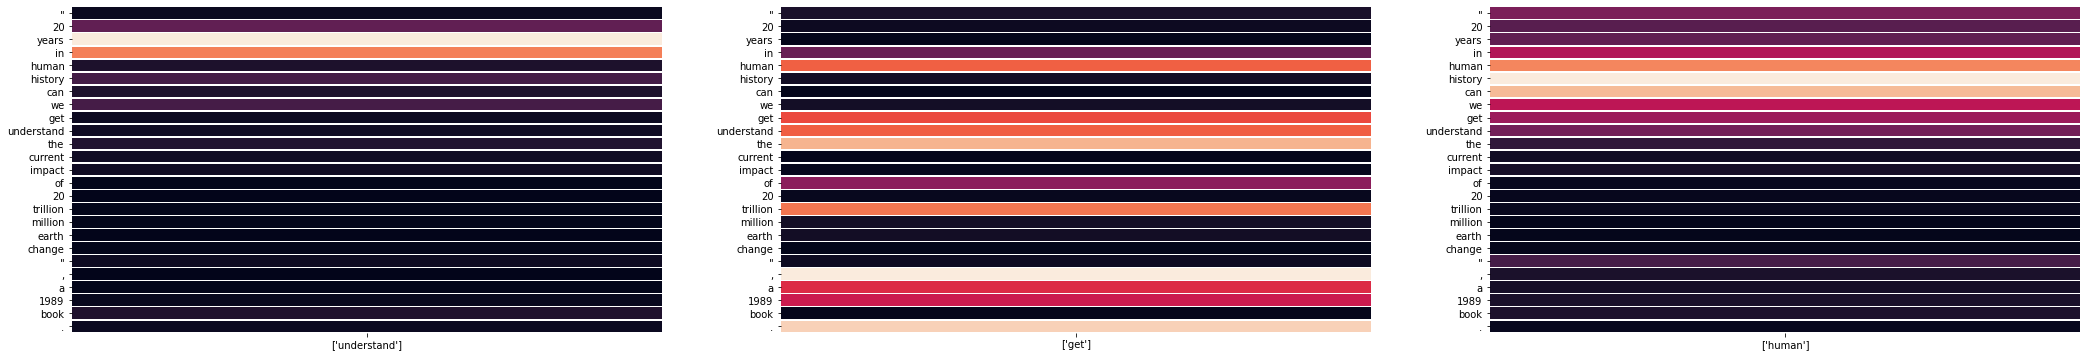


[ITERATION 196]
Current sentence: 	[CLS] " 20 years in human history can we get understand the current impact of 20 trillion million earth change ", a 1989 book. [SEP]
Masked sentence: 	[CLS] " 20 years [MASK] human [MASK] can we get understand [MASK] current impact of 20 trillion million earth change ", a 1989 book. [SEP]
Predictions: 	"of the history"


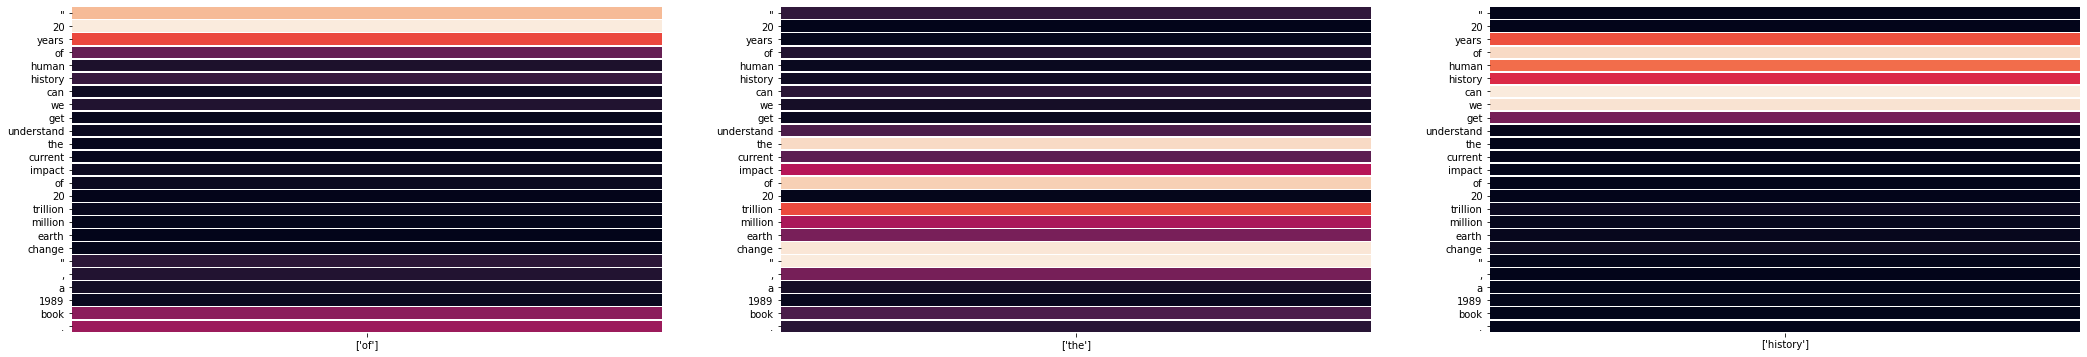


[ITERATION 197]
Current sentence: 	[CLS] " 20 years of human history can we get understand the current impact of 20 trillion million earth change ", a 1989 book. [SEP]
Masked sentence: 	[CLS] " 20 years of human history can [MASK] get understand the current impact [MASK] 20 trillion million earth change ", [MASK] 1989 book. [SEP]
Predictions: 	"a of it"


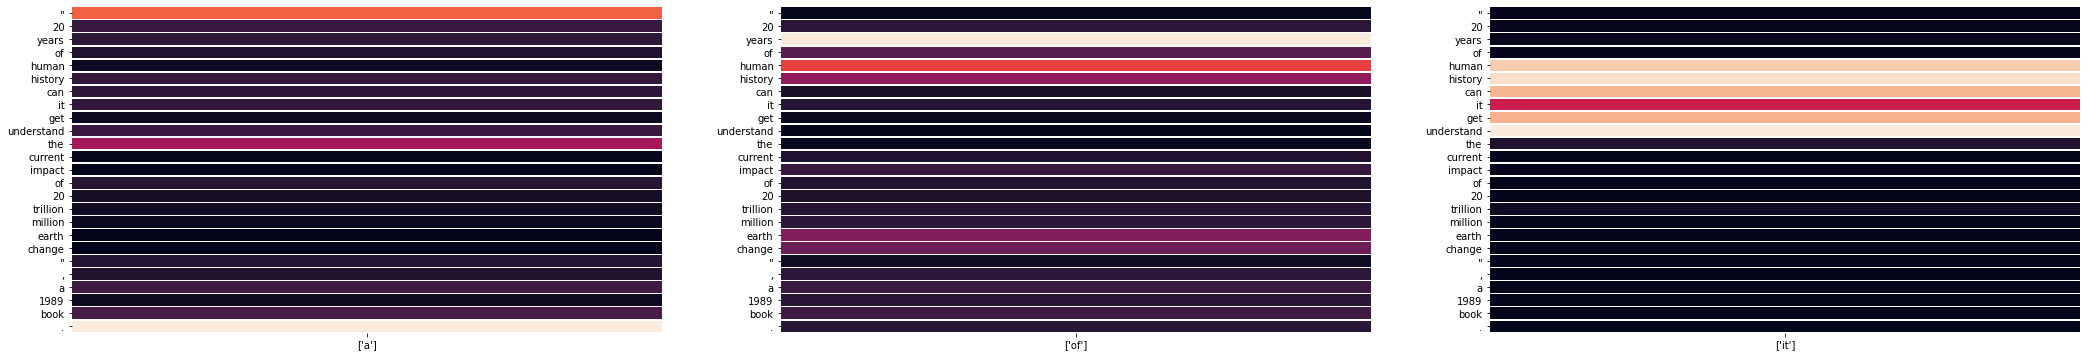


[ITERATION 198]
Current sentence: 	[CLS] " 20 years of human history can it get understand the current impact of 20 trillion million earth change ", a 1989 book. [SEP]
Masked sentence: 	[CLS] " 20 years of human [MASK] can it get understand the current impact of 20 trillion [MASK] earth change ", a 1989 book [MASK] [SEP]
Predictions: 	"; year occupation"


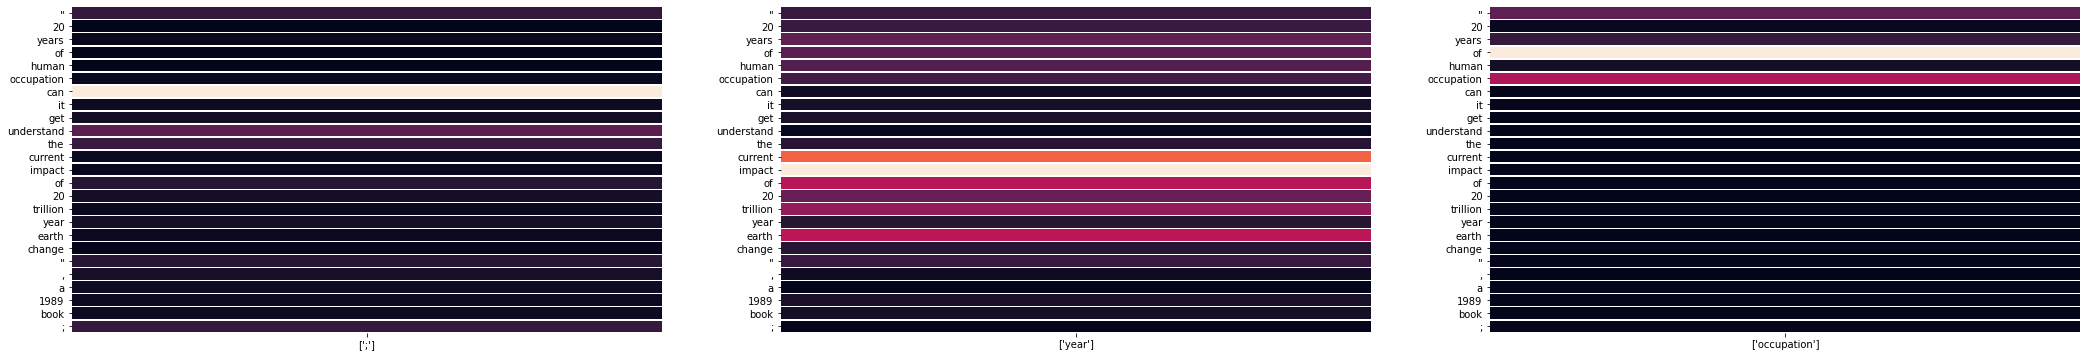


[ITERATION 199]
Current sentence: 	[CLS] " 20 years of human occupation can it get understand the current impact of 20 trillion year earth change ", a 1989 book ; [SEP]
Masked sentence: 	[CLS] " 20 years [MASK] human occupation can it get understand the current impact of [MASK] trillion year earth [MASK] ", a 1989 book ; [SEP]
Predictions: 	"era the of"


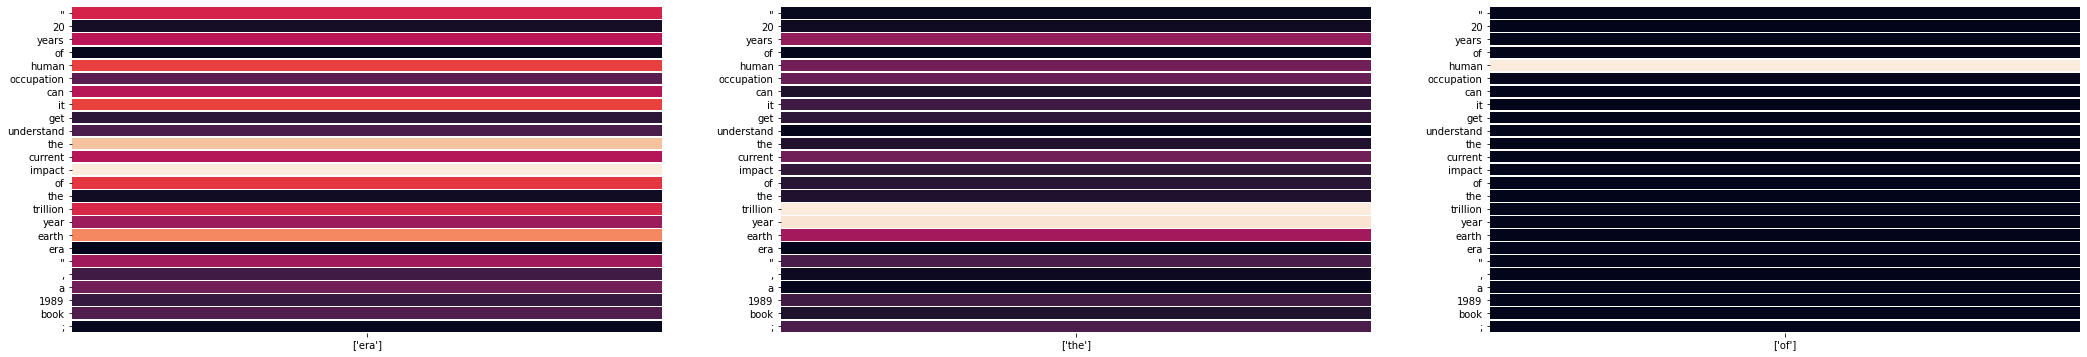


[ITERATION 200]
Current sentence: 	[CLS] " 20 years of human occupation can it get understand the current impact of the trillion year earth era ", a 1989 book ; [SEP]
Masked sentence: 	[CLS] " 20 years of [MASK] occupation can it get understand the current impact of the trillion [MASK] [MASK] era ", a 1989 book ; [SEP]
Predictions: 	"dollar dollar american"


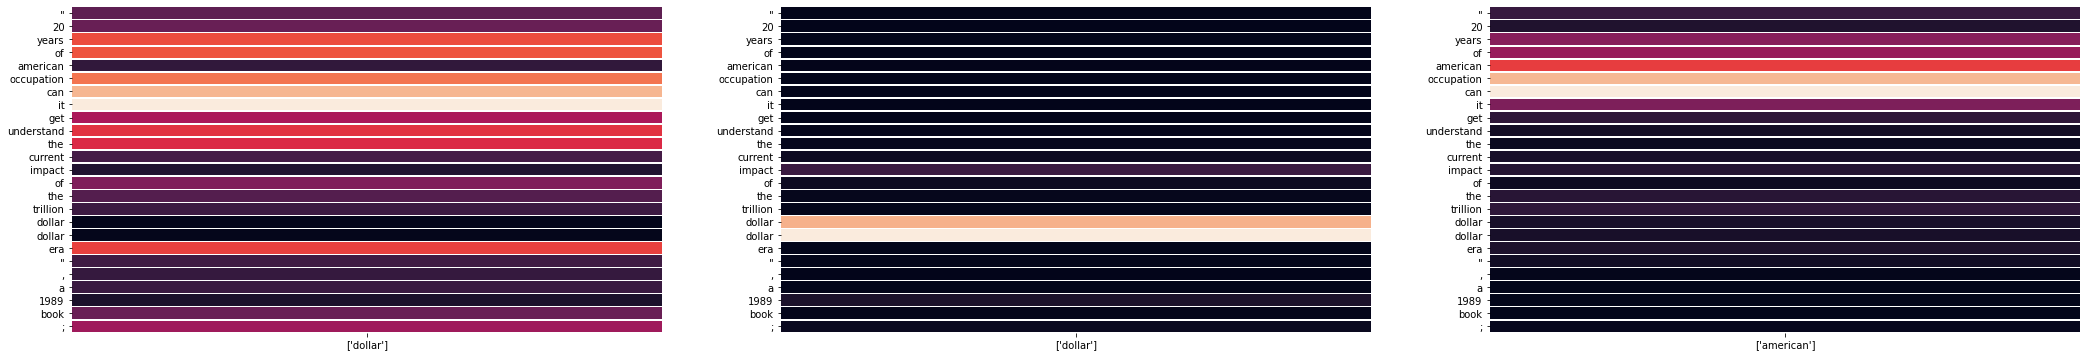

In [ ]:
sentence = "[MASK] " * 25
encoded = np.array(tokenizer.encode(sentence))
n_tokens_to_mask = 3
# init uniform probability
probs = [np.full(len(encoded)-2, 1/(len(encoded)-2)) for i in range(n_tokens_to_mask)]
counter = {i:0 for i in range(1, len(encoded))}

for i in range(200):

    print(f"\n[ITERATION {i+1}]")
    
    # Mask a token
    print(f"Current sentence: \t{tokenizer.decode(encoded)}")
    idx_mask = [np.random.choice(range(1, len(encoded)-1), p=probs[i], replace=False) for i in range(n_tokens_to_mask)]

    # print(f"Token to mask: \t{tokenizer.convert_ids_to_tokens(encoded[idx_mask])}")
    encoded[idx_mask] = tokenizer.mask_token_id
    print(f"Masked sentence: \t{tokenizer.decode(encoded)}")

    # Results
    res = model(torch.tensor([encoded]))
    logits = res['logits'][[0]*3,idx_mask, :]
    attention = torch.cat(res['attentions'])

    # top-k selection
    list_idx = []
    for i in range(3):
      val, ids = torch.topk(logits[i], 100)
      # print("TOP 100 words: ")
      # print(tokenizer.convert_ids_to_tokens(ids))
      dist = torch.distributions.categorical.Categorical(logits=val)
      idx = ids.gather(dim=-1, index=dist.sample().unsqueeze(-1)).squeeze(-1).item()
      list_idx.append(idx)
    print(f"Predictions: \t\"{tokenizer.decode(list_idx)}\"")

    # Replacing
    encoded[idx_mask] = list_idx

    # Plot
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(36,6))
    
    for i in range(n_tokens_to_mask):
        encoder_idx = np.random.randint(12)
        attention_mask_idx = np.random.randint(12) 
        a = attention[encoder_idx, attention_mask_idx]
        a = a[1:-1, idx_mask[i]].reshape(-1, 1).detach().numpy()
        a = a / sum(a)
        probs[i] = a.flatten()

        tokens = tokenizer.convert_ids_to_tokens(encoded)[1:-1]
        sns.heatmap(a, xticklabels=[f'{tokenizer.convert_ids_to_tokens([encoded[idx_mask[i]]])}'], yticklabels=tokens, cbar=False, linewidths=.5, ax=axes[i])
        # fig.show()
    plt.show()  

    

In [ ]:
len(prob)

75

In [ ]:
sentence = "[MASK] " * 25
encoded = np.array(tokenizer.encode(sentence))
n_tokens_to_mask = 7
# init uniform probability
prob = np.full(len(encoded)-2, 1/(len(encoded)-2))
counter = {i:0 for i in range(1, len(encoded))}

for i in range(200):

    print(f"\n[ITERATION {i+1}]")
    
    # Mask a token
    print(f"Current sentence: \t{tokenizer.decode(encoded)}")
    idx_mask = np.random.choice(range(1, len(encoded)-1), p=prob, size =n_tokens_to_mask, replace=False)

    # print(f"Token to mask: \t{tokenizer.convert_ids_to_tokens(encoded[idx_mask])}")
    encoded[idx_mask] = tokenizer.mask_token_id
    print(f"Masked sentence: \t{tokenizer.decode(encoded)}")

    # Results
    res = model(torch.tensor([encoded]))
    logits = res['logits'][[0]*n_tokens_to_mask,idx_mask, :]  #careful maybe 0 should be changed considering batch
    attention = torch.cat(res['attentions'])

    # top-k selection
    list_idx = []
    for i in range(n_tokens_to_mask):
      val, ids = torch.topk(logits[i], 100)
      # print("TOP 100 words: ")
      # print(tokenizer.convert_ids_to_tokens(ids))
      dist = torch.distributions.categorical.Categorical(logits=val)
      idx = ids.gather(dim=-1, index=dist.sample().unsqueeze(-1)).squeeze(-1).item()
      list_idx.append(idx)
    print(f"Predictions: \t\"{tokenizer.decode(list_idx)}\"")

    # Replacing
    encoded[idx_mask] = list_idx

    # Plot
    a = attention[:,:,1:-1, idx_mask].mean(axis=(0,1,-1)).detach().numpy()  # mean over ax0 that is encoders and ax1 that is attention_mask
    a = a.reshape(-1, 1)
    a = a / sum(a)
    prob = a.flatten()

    
    


[ITERATION 1]
Current sentence: 	[CLS] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [SEP]
Masked sentence: 	[CLS] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [SEP]
Predictions: 	"not or -. no his or"

[ITERATION 2]
Current sentence: 	[CLS] his or [MASK] - [MASK] no or [MASK] [MASK] [MASK] [MASK] [MASK] not [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK]. [SEP]
Masked sentence: 	[CLS] his or [MASK] - [MASK] no [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] not [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK]. [SEP]
Predictions: 	"he a their longer he his longer"

[ITERATION 3]
Current sentence: 	[CLS] his or their - [MASK] no longer longer [MASK] [MASK] [MASK] [MASK] not his [MA